Edvard August Eggen Sveum
FU Berlin
Matricelnummber: 5501132

In [1]:
import pandas as pd
import jsonlines
import json
from difflib import get_close_matches
import numpy as np
import matplotlib.pyplot as mpt

In [2]:
#path_FCV = 'D:/OneDrive/FU - Studentzeit/Innovations/Master/Methode and data/FCV-Export-Lens.jsonl'

def JsonLRead(path_list):
    List_of_patent_dictionaries = []
    for path in path_list:
        with jsonlines.open(path) as reader:
            for obj in reader:
                List_of_patent_dictionaries.append(obj)
        reader.close()
    return List_of_patent_dictionaries


In [2]:
Paths = ['Master/Granted Only/FCV-1900-2010.jsonl',
         'Master/Granted Only/FCV-2010-2016.jsonl',
         'Master/Granted Only/FCV-2016-2022.jsonl'
        ]
#List_of_patent_dictionaries = JsonLRead(Paths)

In [3]:
def JsonLRead_G(path_l): #Function to open a list of json list files
    List_of_patent_dictionaries = []
    for path in path_l:
        with jsonlines.open(path) as reader:
            for obj in reader:
                List_of_patent_dictionaries.append(obj)
        #reader.close()
    return pd.json_normalize(List_of_patent_dictionaries)
#Granted_data = JsonLRead_G(Paths)

Ex_path = ['Master/Granted Extended/Extended_exporv2t1900-2009.jsonl',
           'Master/Granted Extended/Extended_exporv2t2009-2015.jsonl',
           'Master/Granted Extended/Extended_exporv2t2015-2020.jsonl',
           'Master/Granted Extended/Extended_exporv2t2020-2022.jsonl'
          ]

Granted_data_extended = JsonLRead_G(Ex_path)

In [4]:
def set_index_Patent_id(Df):# sets index
    return Df.set_index(Df['jurisdiction']+Df['doc_number']+Df['kind'])
#Granted_data = set_index_Patent_id(Granted_data)
Granted_data_extended = set_index_Patent_id(Granted_data_extended)

In [5]:
#Granted_data = Granted_data.drop_duplicates(subset=['lens_id'], keep='first')
Granted_data_extended = Granted_data_extended.drop_duplicates(subset=['lens_id'], keep='first') #remove duplicate patent documents
#Granted_data_extended = Granted_data_extended.index.drop(Granted_data[Granted_data.isin(Granted_data_extended)].index)

In [6]:
#Granted_data = Granted_data.drop_duplicates(subset = 'lens_id',keep = 'first')

In [7]:
def IxIv2(df): #function to construct a dataframe with the inventor to inventor relationships (the resulting data is non-directional)
    temp_list = []
    res = df[(pd.notnull(df['biblio.parties.applicants']))]
    res = res[(pd.notnull(res['biblio.parties.inventors']))]
    for index in res.index:
        Target_I = pd.json_normalize(res.at[index,'biblio.parties.inventors'])
        if 'residence' in Target_I.columns:
            for sub_index in Target_I.index:
                temp = pd.DataFrame()
                temp['Inventor_I'] = np.full(shape = Target_I.shape[0], fill_value=Target_I.at[sub_index,'extracted_name.value'])
                temp['Inventor_J'] = Target_I['extracted_name.value']
                temp['Inventor_I_R'] =np.full(shape = Target_I.shape[0], fill_value=Target_I.at[sub_index,'residence'])
                temp['Inventor_J_R'] =Target_I['residence']
                temp['Patent_J+NR'] = np.full(shape = Target_I.shape[0], fill_value=index)
                temp_list.append(temp)
    frames = pd.concat(temp_list)
    frames['Inventor_I'] = frames['Inventor_I'].replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').str.strip(' ')
    frames['Inventor_J'] = frames['Inventor_J'].replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').str.strip(' ')
    #for i in frames.index:
     #   frames.at[i,'Inventor_I'] = str(frames.at[i,'Inventor_I']).replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').strip(' ')
      #  frames.at[i,'Inventor_J'] = str(frames.at[i,'Inventor_J']).replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').strip(' ')
    return frames



IXI = IxIv2(Granted_data_extended)


In [8]:
IxI = IXI.reset_index()
IxI.to_excel('IXI_ev1.xlsx')
IxI.to_csv('IXI_ev1.csv')

In [9]:
def IxAv2(df):#function to construct a dataframe with the inventor to applicant relationships (the resulting data is directional).
    temp_list = []
    res = df[(pd.notnull(df['biblio.parties.applicants']))]
    res = res[(pd.notnull(res['biblio.parties.inventors']))]
    for index in res.index:
        Target_I = pd.json_normalize(res.at[index,'biblio.parties.inventors'])
        Ap_Target = pd.json_normalize(res.at[index,'biblio.parties.applicants']) #pd.json_normalize(df[(pd.notnull(df['biblio.parties.applicants']))].at[index,'biblio.parties.applicants'])
        if 'residence' in Target_I.columns:
            if 'residence' in Ap_Target.columns:
                for Ap in Ap_Target.index:
                    temp = pd.DataFrame()
                    temp['Inventor'] = Target_I['extracted_name.value']
                    temp['Applicant'] = np.full(shape = Target_I.shape[0], fill_value=Ap_Target.at[Ap,'extracted_name.value'])
                    temp['Applicant_R'] =np.full(shape = Target_I.shape[0], fill_value=Ap_Target.at[Ap,'residence'])
                    temp['Inventor_R'] =Target_I['residence']
                    temp['Patent_J+NR'] = np.full(shape = Target_I.shape[0], fill_value=index)
                    temp_list.append(temp)
            elif 'residence' not in Ap_Target.columns:
                for Ap in Ap_Target.index:
                    temp = pd.DataFrame()
                    temp['Inventor'] = Target_I['extracted_name.value']
                    temp['Applicant'] = np.full(shape = Target_I.shape[0], fill_value=Ap_Target.at[Ap,'extracted_name.value'])
                    temp['Inventor_R'] =Target_I['residence']
                    temp['Applicant_R'] = 'TBD'
                    temp['Patent_J+NR'] = np.full(shape = Target_I.shape[0], fill_value=index)
                    temp_list.append(temp)
    frames = pd.concat(temp_list)
    frames['Inventor'] = frames['Inventor'].replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').str.strip(' ')
    frames['Applicant'] = frames['Applicant'].replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').str.strip(' ')
    #for i in frames.index:
     #   frames.at[i,'Inventor'] = frames.at[i,'Inventor'].replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').strip(' ')
      #  frames.at[i,'Applicant'] = frames.at[i,'Applicant'].replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').strip(' ')
    return frames
IxA = IxAv2(Granted_data_extended)

In [10]:
IxA = IxA.reset_index()
IxA.to_excel('IXA_ev1.xlsx')
IxA.to_csv('IXA_ev1.csv')

In [26]:
"""
Outdated Fuction construct define the inventor to inventor relationships


def Unpack_ITI(list_of_dicts): #
    Inv_Inv_edges = pd.DataFrame(columns=['Inventor_I', 'Inventor_J','Inventor_I_R', 'Inventor_J_R', 'Patent_J+NR'])
   
    for Dict in list_of_dicts:
        Patent_biblo =  Dict['biblio']
        jur = Patent_biblo['application_reference']['jurisdiction']
        doc_number = Patent_biblo['application_reference']['doc_number']
        #applicants =  Patent_biblo['parties']['applicants']
        if 'inventors' in Patent_biblo['parties']:
            inventors = Patent_biblo['parties']['inventors']
            if 'residence' and 'extracted_name'  in (inventors[0]):
                for inv_i in inventors:
                    for inv_j in inventors:
                        if 'residence' and 'extracted_name' in inv_i and inv_j:
                            if inv_i != inv_j:
                                index = Inv_Inv_edges.shape[0]
                                if 'residence' in inv_i:
                                    if 'residence' in inv_j:
                                        Inv_Inv_edges.at[index, 'Inventor_I'] = inv_i['extracted_name']['value'].replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').strip(' ')
                                        Inv_Inv_edges.at[index, 'Inventor_J'] = inv_j['extracted_name']['value'].replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').strip(' ')    
                                        Inv_Inv_edges.at[index, 'Inventor_I_R'] = inv_i['residence']
                                        Inv_Inv_edges.at[index, 'Inventor_J_R'] = inv_j['residence']
                                        Inv_Inv_edges.at[index, 'Patent_J+NR'] = jur+' '+doc_number
                                        Inv_Inv_edges.at[index, 'Publication Date'] = Dict['date_published']
                                    else:
                                        pass
                                else:
                                    pass
                            else:
                                pass
                        else: 
                            pass
            else:
                pass
        else:
            pass
    return Inv_Inv_edges
"""

In [ ]:
"""
def Unpack_ITA(list_of_dicts):
    Inv_Ap_eges = pd.DataFrame(columns=['Inventor', 'Applicant','Inventor_R', 'Applicant_R', 'Patent_J+NR'])
    for Dict in list_of_dicts:
        Patent_biblo =  Dict['biblio']
        jur = Patent_biblo['application_reference']['jurisdiction']
        doc_number = Patent_biblo['application_reference']['doc_number']
        if Dict['publication_type'] == 'GRANTED_PATENT':
    
            if 'applicants' in Patent_biblo['parties']:
                if 'inventors' in Patent_biblo['parties']:
                    
                    applicants =  Patent_biblo['parties']['applicants']
                    inventors = Patent_biblo['parties']['inventors']
                    for ap in applicants:
                        for inv in inventors:
                            if 'residence' in inv:
                                
                                index = Inv_Ap_eges.shape[0]
                                Inv_Ap_eges.at[index, 'Inventor'] = inv['extracted_name']['value'].replace(':',' ').replace(',',' ').replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').strip(' ')
                                Inv_Ap_eges.at[index, 'Applicant'] = ap['extracted_name']['value'].replace(':',' ').replace(',',' ').replace('.',' ').replace(';',' ').replace('DIPL ING',' ').replace('  ',' ').strip(' ')
                                Inv_Ap_eges.at[index, 'Inventor_R'] = inv['residence']
                                if 'residence' in ap:
                                    Inv_Ap_eges.at[index, 'Applicant_R'] = ap['residence']
                                else:
                                    Inv_Ap_eges.at[index, 'Applicant_R'] = 'TBD'
                                Inv_Ap_eges.at[index, 'Patent_J+NR'] = jur+' '+doc_number
                                Inv_Ap_eges.at[index, 'Publication Date'] = Dict['date_published']
                        else:
                            pass
                else:
                    pass
            else:
                pass
    return Inv_Ap_eges
IxA = Unpack_ITA(List_of_patent_dictionaries)
IxA.to_csv('Master/Granted Only/IxA_uncleaned.csv')
"""

In [9]:
def ITAR(IXA_DF): #searches for Residency from other patents or from inventor side. The process is time consuming and probably inefficent
    Sub = IXA_DF[IXA_DF['Applicant_R'] == 'TBD']
    for i in Sub.index:
        if IXA_DF.at[i, 'Applicant_R'] != 'TBD':
            pass
        elif IXA_DF.at[i, 'Applicant_R'] == 'TBD':
            Subsub = IXA_DF[(IXA_DF['Applicant'] == IXA_DF.at[i,'Applicant']) | (IXA_DF['Inventor'] == IXA_DF.at[i,'Applicant'])]
            for j in Subsub.index: 
                if IXA_DF.at[j,'Inventor'] == Sub.at[i,'Applicant']:
                    IXA_DF.at[i,'Applicant_R'] = IXA_DF.at[j,'Inventor_R']
                elif IXA_DF.at[j,'Applicant'] == Sub.at[i,'Applicant']:
                    if IXA_DF.at[j,'Applicant_R'] != 'TBD':
                        IXA_DF.at[i, 'Applicant_R'] = IXA_DF.at[j,'Applicant_R']
    return IXA_DF


In [10]:
def ITAR2(IXA_DF): #searches for Residency from other patents or from inventor side. The process is time consuming and probably inefficent
    Sub = IXA_DF[IXA_DF['Inventor_R'] == 'TBD']
    for i in Sub.index:
        if IXA_DF.at[i, 'Inventor_R'] != 'TBD':
            pass
        elif IXA_DF.at[i, 'Inventor_R'] == 'TBD':
            Subsub = IXA_DF[(IXA_DF['Applicant'] == IXA_DF.at[i,'Applicant']) | (IXA_DF['Inventor'] == IXA_DF.at[i,'Applicant'])]
            for j in Subsub.index: 
                if IXA_DF.at[j,'Inventor'] == Sub.at[i,'Applicant']:
                    IXA_DF.at[i,'Applicant_R'] = IXA_DF.at[j,'Inventor_R']
                elif IXA_DF.at[j,'Applicant'] == Sub.at[i,'Applicant']:
                    if IXA_DF.at[j,'Applicant_R'] != 'TBD':
                        IXA_DF.at[i, 'Inventor_R'] = IXA_DF.at[j,'Applicant_R']
    return IXA_DF

In [ ]:
def ITARv2(IxA): #searches for Residency from other patents or from inventor side. The process is time consuming.
    TBD = IxA[IxA['Applicant_R'] == 'TBD']
    for index in TBD.index:
        IxA.loc[(IxA['Applicant'].replace(' JR ',' ').replace(' JR',' ').replace('DIP ING',' ').replace('DIPL CHE',' ').replace('DIPL EL I',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DR',' ').strip(' ') == TBD.at[index,'Applicant'].replace(' JR ',' ').replace(' JR',' ').replace('DIP ING',' ').replace('DIPL CHE',' ').replace('DIPL EL I',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DR',' ').strip(' ')) and (IxA['Applicant_R'] == 'TBD'), 'Applicant_R'] = IxA[(IxA['Applicant'].replace(' JR ',' ').replace(' JR',' ').replace('DIP ING',' ').replace('DIPL CHE',' ').replace('DIPL EL I',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DR',' ').strip(' ') == TBD.at[index,'Applicant'].replace(' JR ',' ').replace(' JR',' ').replace('DIP ING',' ').replace('DIPL CHE',' ').replace('DIPL EL I',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DR',' ').strip(' ')) and (IxA['Applicant_R'] == 'TBD'), 'Applicant_R']
        IxA.loc[(IxA['Inventor'].replace(' JR ',' ').replace(' JR',' ').replace('DIP ING',' ').replace('DIPL CHE',' ').replace('DIPL EL I',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DR',' ').strip(' ') == TBD.at[index,'Applicant'].replace(' JR ',' ').replace(' JR',' ').replace('DIP ING',' ').replace('DIPL CHE',' ').replace('DIPL EL I',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DR',' ').strip(' ')) and (IxA['Applicant_R'] == 'TBD'), 'Applicant_R'] = IxA[(IxA['Applicant'].replace(' JR ',' ').replace(' JR',' ').replace('DIP ING',' ').replace('DIPL CHE',' ').replace('DIPL EL I',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DR',' ').strip(' ') == TBD.at[index,'Applicant'].replace(' JR ',' ').replace(' JR',' ').replace('DIP ING',' ').replace('DIPL CHE',' ').replace('DIPL EL I',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DR',' ').strip(' ')) and (IxA['Applicant_R'] == 'TBD'),'Inventor_R']
    return IxA

        

In [11]:
def incon_node_naming(edgeA):# function to identify similar names, the output is used to find possible namming inconsistencies.
    Ap = (edgeA['Applicant'].values)
    In = edgeA['Inventor'].values
    Ag = np.concatenate((Ap, In), axis = None)
    Ag_df = pd.DataFrame(Ag, columns = ['Nodes'] ).drop_duplicates()
    sim_df = Ag_df['Nodes'].map(lambda x: get_close_matches(x, Ag_df['Nodes'], n = 60, cutoff=0.85)).apply(pd.Series)
    sim_df.columns = sim_df.columns.map(str)
    sim2_df = sim_df.dropna(subset = ['1'])
    sim2_df.insert(0, 'ID_incr', range(1,1+len(sim2_df)))
    return sim_df, sim2_df                                  


In [216]:
def IxA_intersection_comp(I1,I2,DF):
    '''Find common interation Actors between defind names within a DataFrame of Edge List.
    Input, two names (I1 & I2), Edge list DataFrame (DF)'''
    temp1 = set(DF[DF[DF.columns[0]] == I1][DF.columns[1]].values)
    temp2 = set(DF[DF[DF.columns[0]] == I2][DF.columns[1]].values)
    print(temp1.intersection(temp2))
    

In [15]:
def Incorperate_Cleaning_Dic_IXA(Dic, DF):
    for key in Dic.keys():
    #for i in DF[DF['Applicant_R']=='TBD'].index: # residency is changed
            DF.at[key,'Applicant_R'] = Dic[DF.loc[key,'Applicant'].replace(' ',' ')][0] 
    return DF  

In [16]:
def Incorperate_Cleaning_Dic_IXA2(Dic, DF):
    for key in Dic.keys():
    #for i in DF[DF['Applicant_R'] == 'TBD'].index:
        Res = Dic[key]
        Rest = DF[DF['Applicant'] == key]
        for i in Rest.index:
            DF.at[i,'Applicant_R'] = Res
    return DF
def Incorperate_Cleaning_Dic_IXA2I(Dic, DF):
    for key in Dic.keys():
    #for i in DF[DF['Applicant_R'] == 'TBD'].index:
        Res = Dic[key]
        Rest = DF[DF['Inventor'] == key]
        for i in Rest.index:
            DF.at[i,'Inventor_R'] = Res
    return DF
def Incorperate_Cleaning_Dic_IXI2I(Dic, DF):
    for key in Dic.keys():
    #for i in DF[DF['Applicant_R'] == 'TBD'].index:
        Res = Dic[key]
        Rest = DF[DF['Inventor_I'] == key]
        for i in Rest.index:
            DF.at[i,'Inventor_I_R'] = Res
    return DF
def Incorperate_Cleaning_Dic_IXI2J(Dic, DF):
    for key in Dic.keys():
    #for i in DF[DF['Applicant_R'] == 'TBD'].index:
        Res = Dic[key]
        Rest = DF[DF['Inventor_J'] == key]
        for i in Rest.index:
            DF.at[i,'Inventor_J_R'] = Res
    return DF

In [95]:
def Homogneous_naming(name_dic, IxA, IxI): #
    for key in name_dic.keys():
        RIxA = IxA[(IxA['Applicant'].isin(name_dic[key]))|(IxA['Inventor'].isin(name_dic[key]))] 
        RIxI = IxI[(IxI['Inventor_I'].isin(name_dic[key]))|(IxI['Inventor_J'].isin(name_dic[key]))] 
        v = name_dic[key]
        for i in RIxA.index:
            for value in v:
                IxA.at[i,'Inventor'] = IxA.at[i,'Inventor'].replace(str(value), str(key))
                IxA.at[i,'Applicant'] =  IxA.at[i,'Applicant'].replace(str(value), str(key))
        for i in RIxI.index:
            for value in v:
                IxI.at[i,'Inventor_I'] = IxI.at[i,'Inventor_I'].replace(str(value), str(key))
                IxI.at[i,'Inventor_J'] = IxI.at[i,'Inventor_J'].replace(str(value), str(key))
    return IxA, IxI

In [96]:
def Homogneous_namingv2(name_dic, IxA, IxI): #
    for key in name_dic.keys():
        RIxA = IxA[(IxA['Applicant'].isin(name_dic[key]))|(IxA['Inventor'].isin(name_dic[key]))] 
        RIxI = IxI[(IxI['Inventor_I'].isin(name_dic[key]))|(IxI['Inventor_J'].isin(name_dic[key]))] 
        v = name_dic[key]
        for value in v:
            IxA['Inventor'] = IxA['Inventor'].replace(str(value), str(key))
            IxA['Applicant'] =  IxA['Applicant'].replace(str(value), str(key))
        for value in v:
            IxI['Inventor_I'] = IxI['Inventor_I'].replace(str(value), str(key))
            IxI['Inventor_J'] = IxI['Inventor_J'].replace(str(value), str(key))
    return IxA, IxI

In [18]:
def de_Hyphen(DF):
    for j in DF.columns[0:2]:
        for i in DF.index:
            DF.at[i,j] = str(DF.at[i,j]).replace('-',' ')
    return DF


In [41]:
def de_Puntuation_IxA(DF):
    DF['Applicant'] = DF['Applicant'].str.strip('.,;:').str.strip('.,;:').replace(',..',' ').replace(',',' ').replace('; ',' ').replace('.',' ').str.strip('  ').str.strip(';')
    DF['Inventor'] = DF['Inventor'].str.strip('.,;:').str.strip('.,;:').replace(',..',' ').replace(',',' ').replace('; ',' ').replace('.',' ').str.strip('  ').str.strip(';')
    return DF

In [132]:
def de_Puntuation_IxAL(DF):
    C1 = DF.columns[0]
    C2 = DF.columns[1]
    for i in DF.index:
        DF.at[i,C1] = DF.at[i,C1].strip('.,;:').strip('.,;:').replace(',..',' ').replace(',',' ').replace(':',' ').replace('; ',' ').replace('.',' ').replace('.',' ').strip('  ').strip(';').rstrip('  ').replace('  ',' ')
        DF.at[i,C2] = DF.at[i,C2].strip('.,;:').strip('.,;:').replace(',..',' ').replace(',',' ').replace(':',' ').replace('; ',' ').replace('  ',' ').replace('.',' ').strip('  ').strip(';').rstrip('  ').replace('  ',' ')
    return DF

In [175]:
def de_Doctor(DF): #should have done this from the start, but did not think off it after the manual dictionary had surpaced 1000 rows in lengts
    for j in DF.columns[0:2]:
        for i in DF.index:
            DF.at[i,j] = str(DF.at[i,j]).replace(' CHEMIE ING',' ').replace(' DIPL IN',' ').replace(' DIPL BSC',' ').replace(' DIPL (FH) MSC',' ').replace(' DIPL MSC',' ').replace(' DIPL M SC',' ').replace(' DIPL (FH) ',' ').replace(' DIPL (FH)',' ').replace(' DIPL MBA',' ').replace(' DIPL TEKCHN',' ').replace(' DIPL EL ETH',' ').replace(' DIPL FH',' ').replace(' ING ',' ').replace('DIPL JURIST DI',' ').replace('DIPL JUR DIPL',' ').replace('DIP ING',' ').replace('DIPL CHE',' ').replace('DIPL EL I',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DR',' ').replace('DIPL EL ING',' ').replace('DIPL EL ING HTL',' ').replace('PROF ',' ').replace('DIPL CHEM',' ').replace('DIPL PHY',' ').replace('DIPL PHYS',' ').replace('DIPL  ING',' ').replace('DIPL ING',' ').replace(' PROF',' ').replace(' DR RER',' ').replace(' DR ING CHE',' ').replace(' DR DIPL PH',' ').replace(' DR DIPL PH',' ').replace(' DR PHYS',' ').replace(' DR DIPL CHEM',' ').replace(' DR DIPL C',' ').replace(' DIPL PHYS DR',' ').replace(' DR DIPL PHYS',' ').replace(' DR RER NAT',' ').replace(' PROF DR',' ').replace(' DR DIPL',' ').replace(' DR ING',' ').replace(' DIPL ',' ').replace('DIPL ',' ').replace(' DIPL',' ').replace('DR ',' ').replace('  ',' ').strip(' ')
    return DF

In [22]:
def de_JR(DF): #should have done this from the start, but did not think off it after the manual dictionary had surpaced 1000 rows in lengts
    for j in DF.columns[0:2]:
        for i in DF.index:
            DF.at[i,j] = str(DF.at[i,j]).replace(' JR ',' ').replace(' JR',' ').strip(' ')
    return DF

In [23]:
def de_bracket(Df):
    for j in Df.columns[2:4]:
        for i in Df.index:
            Df.at[i,j] = str(Df.at[i,j]).strip("['']")
    return Df

In [172]:
def de_ING(Df):
    for j in Df.columns[0:2]:
        for i in Df.index:
            if len(Df.at[i,j]) > 3:
                S1 =Df.at[i,j][-1]
                S2 = Df.at[i,j][-2]
                S3 = Df.at[i,j][-3]
                if 'ING' in S3+S2+S1:
                    Df.at[i,j].rstrip('ING')
    return Df
            
    

In [ ]:
IxA[IxA['Applicant_R'] == 'TBD'].to_excel('IXA_ev1v1TBD.xlsx') #Findes missing residency

In [18]:
if 'index' in IxA.columns:
    IxA_cr = IxA.drop(columns = 'index')
else:
    IxA_cr = IxA
if 'index' in IxI.columns:
    IxI_cr = IxI.drop(columns = 'index')
else:
    IxI_cr = IxI

In [31]:
Inconsitent_naming, Inconsitent_naming_sup = incon_node_naming(IxA_cr)

In [60]:
#IxA = IxA.drop(columns=['level_0','Unnamed: 0','index'])

In [61]:
#IXI = IXI.drop(columns=['index'])

In [55]:
Inconsitent_naming_sup.to_excel('Master/Granted Only/Naming_inconsistency.xlsx')

NameError: name 'Inconsitent_naming_sup' is not defined

In [230]:
List_Manual_clean = { #will only correct Applicant_R her.
    "O'BRIEN JOHN F":['US'], 
    'GOMEZ RODOLFO A M':['AU'],
    'BRUCK ROLF' : ['DE'], 
    'AEROVIRONMENT INC A CALIFORNIA' : ['US'], # In the name
    'NISSAN TECHNICAL CT N A INC':['US'], #North american Technical center beloning Nissan https://virginiadb.com/company/F1574997/nissan-technical-center-north-america-inc.html
    'SEARETE LLC':['US'], #https://www.lens.org/lens/patent/191-983-161-609-279/frontpage?l=en
    'NG CASEY Y K':['US'], # NG CASEY Y K == NG CASEY Y.K. where not included in the strips and replace functions used in ITAR02
    'SCHNECK MICHAEL M':['US'], #SCHNECK MICHAEL M == SCHNECK MICHAEL M. 
   
    'PARISE; RONALD J.':['US'], # PARISE RONALD J == PARISE; RONALD J.
    'BURNS; DAVID JOHNSTON':['GB'], #BURNS DAVID JOHNSTON == BURNS; DAVID JOHNSTON
    'DEWEY SCOTT B':['US'], #'DEWEY SCOTT B' == 'DEWEY SCOTT B.'
    'VAN-DRENTHAM-SUSMAN HECTOR FILIPUS ALEXANDER':['GB'], # VAN-DRENTHAM-SUSMAN HECTOR FIL == VAN-DRENTHAM-SUSMAN HECTOR FILIPUS ALEXANDER
    'AGAR DAVID W':['DE'], # AGAR DAVID W. == AGAR DAVID W 
    'COLORADO SCHOOL OF MINES':['US'], # Name of applicant
    'OLEAGORDIA AGUIRRE INIGO JAVIE':['ES'], #
    'SCHOULTZ; ROGER A':['US'], #
    'NIELSON JAY P':['US'], #
    'DODGE; CLEVELAND E.':['US'],
    'WENZEL JOACHIM':['DE'],
    'KONIECZNY JORG-ROMAN':['DE'],
    'NI; XUAN Z.':['US','NI XUAN Z'],
    'BECHTEL BWXT IDAHO LLC':['US'], # State name included in name
    'KAGATANI TAKEO':['JP'], 
    'KAGATANI; TAKEO':['JP'],
    'CLINGERMAN BRUCE J.':['US'],
    'CRANE SAMUEL N':['US'],
    'MARGIOTT PAUL R':['US'],
    'SIMMONS JR TIMOTHY C':['US'],
    'HARRIS DONALD B':['US'],
    'MEACHAM G.B. KIRBY':['US'],
    'GRIEVE M. JAMES':['US'],
    'WEBSTER BRUCE A':['US'],
    'YOUNG ROSA T':['US'],
    'C MAR HOLDINGS LTD':['GB'], #https://find-and-update.company-information.service.gov.uk/company/02974834
    'SANDERSON, JR WILLIAM':['US'],
    'STUART ANDREW T B':['CA'],
    'LAWRENCE LIVERNORE NAT SECURIT':['US'], #https://www.llnsllc.com/
    'HARRINGTON MICHAEL D':['US'],
    'SWANSON KYLE D':['US'],
    'ROGERS STEPHEN P':['US'],
    'NASHBURN RICHARD F':['US'],
    'THIJSSEN JOHANNES H J':['US'],
    "O'HARA JEANETTE E":['US'],
    'FARIS SADEG M':['US'],
    'MOTSENBOCKER MARVIN A':['US'],
    'ERDLE ERICH K':['DE'],
    'HOLMES CHARLES M':['US'],
    'GABRIEL JEAN-CHRISTOPHE P':['US'],
    'YANG JEFFERSON Y':['US'],
    'BLUNK RICHARD H':['US'],
    'GUANGDONG HYDROGEN ENERGY SCIENCE AND TE':['CN'], #Institute name indicates residency
    'HARPER MATTHEW ALBERT MACLENNAN':['CA'],
    'SHABANA MOHSEN D':['US'],
    'VOSS HENRY H':['CA'],
    'JENSEN; MAURICE W': ['US'],
    'NELSON PATRICIA J':['US'],
    'HYUNDAI MOTOR CORP':['KR'],
    'TECK COMINCO METALS LTD':['CA'],
    'TRUMA GERATETECHNIK GMBH & CO':['DE'],
    'TRANSMIT GES FUR TECHNOLOGIETR':['DE'],
    'UNIV DE NEUCHATEL':['CH'],
    'HUTTENBERGER PRODUKTIONSTECHNI':['DE'],
    'INST QUIMICO DE SARRIA':['ES'],
    'GORINA LILIYA FEDOROVNA':['RU'],
    'SEVASTYANOV VLADIMIR VLADIMIROVICH':['RU'],
    'SEVASTYANOV ALEXANDER VLADIMIROVICH':['RU'],
    'KAGITANI TAKEO':['JP'],
    'SIMMONS JR  TIMOTHY C':['US'],
    'National Power Plc':['GB'],
    'FRYE JR  JOHN G':['US'],
    'INT FUEL CELLS CORPORATION':['US'],
    'YAO NENG PING':['US'],
    'CATANZARITE VINCENT OWEN':['US'],
    'IN SITU TECHNOLOGY INC':['US'],
    'FLUOROCARBON CO THE':['US'],
    'FLORIDA STATE OF BOARD OF REGE':['US'],
    'ENERGETICS SCIENCE':['US'],
    'REYNOLDS METALS CO':['US'],
    'US INTERIOR':['US'],
    'WIENER SCHWACHSTROMWERKE GMBH':['AT'],
    'LINCHETA MESEA EDUARDO T':['ES'],
    'UNIV ZARAGOZA':['ES'],
    'C MAR HOLDINGS LTD':['GB'],
    'National Power PLC':['GB'],
    'FRYE JR  JOHN G':['US'],
    'FRYE JR JOHN G':['US'],
    'GORINA LILIYA FEDOROVNA':['RU'],
    'C MAR HOLDINGS LTD':['GB'],
    'CATANZARITE VINCENT OWEN':['US'],
    'ENERGETICS SCIENCE':['US'],
    'FLORIDA STATE OF BOARD OF REGE':['US'],
    'FRYE JOHN G':['US'],
    'HUTTENBERGER PRODUKTIONSTECHNI':['DE'],
    'IN SITU TECHNOLOGY INC':['US'],
    'INST QUIMICO DE SARRIA':['ES'],
    'INT FUEL CELLS CORPORATION':['US'],
    'KAGATANI TAKEO':['JP'],
    'LINCHETA MESEA EDUARDO T':['ES'],
    'National Power Plc':['GB'],
    'SIMMONS TIMOTHY C':['US'],
    'TECK COMINCO METALS LTD':['CA'],
    'TRANSMIT GES FUR TECHNOLOGIETR':['DE'],
    'UNIV DE NEUCHATEL':['CH'],
    'UNIV ZARAGOZA':['ES'],
    'US INTERIOR':['US'],
    'WIENER SCHWACHSTROMWERKE GMBH':['DE'],
    'YAO NENG PING':['US'],
    'THE CURATORS OF THE UNIVERSITY OF MISSOURI': ['US'],
    'MESSER CUTTING & WELDING GMBH':['DE'],
    'TECK COMINCO METALS LTD':['US'],
    'GORINA LILIYA FEDOROVNA':['RU'], #Cooperates only with russians
    'The BOC Group Plc':['GB'],
    'VIBCO INC':['US'],
    'MESSER CUTTING & WELDING GMBH':['DE'],
    'US INTERIOR':['US'],
    'BUSSELL RAY V':['US'],
    'ENERGETICS SCIENCE':['US'],
    'WIENER SCHWACHSTROMWERKE GMBH':['DE'],
    'FLUOROCARBON CO THE':['GB'],
    'REYNOLDS METALS CO':['US'],
    'HWT GES FUR HYDRID UND WASSERSTOFFTECHNIK MBH':['DE'],
    'IN SITU TECHNOLOGY INC':['US'],
    "JOS HEISER VORM J WINTER'S SOHN GES M B H":['DE'],
    'SKYVIEW ENTPR':['US'],
    'HWT GES FUR HYDRID  UND WASSERSTOFFTECHNIK MBH':['DE'],
    'BLUNK RICHARD H':['US'],
    'THIJSSEN JOHANNES H J':['US'],
    'PARISE RONALD J':['US'],
    'VOSS HENRY H':['CA'],
    'NIELSON JAY P':['US'], # WILL MAKE THE ASSUMPTION THAT THE RESIDENCY OF INVENTOR AND APPLICANT ARE THE SAME SEE ??? ET AL. ()
    'DODGE CLEVELAND E':['US'],
    'HARRINGTON MICHAEL D':['US'],
    'SHABANA MOHSEN D':['US'],
    'HARPER MATTHEW ALBERT MACLENNAN':['CA'],
    'UNIV DE INSUBRIA':['IT'],
    'UNIV DE MILAN':['IT'],
    'METSO AUTOMATION MAPAG GMBH':['DE'],
    'MARTINEZ OLIVARES JOSE':['IT'],
    'LEE WOO SIK':['KR'],
    'PETROVSKY VLADIMIR':['RU'],
    'KIM JEONG WON':['KR'],
    'CAINE M FINNERTY':[''],
    'KIM GUN TAE':['KR'],
    'GU WENBIN':['US'],
    'SEO JUNG WOO':['KR'],
    'JONG HAK KIM':['KR'],
    'REICHMAN BENJAMIN':['US'],
    'JO JANG HO':['KR'],
    'JAE JUN KO':['KR'],
    'LEE CHI SEUNG':['KR'],
    'YU SEUNGAH':['KR'],
    'DAVIDSON PETER':['GB'],
    'TOWNSEND CARL W':['UR'],
    'MEDIC NIKOLAJ':['DE'],
    'BENJAMIN J EMLEY':['US'],
    'BIRDWELL JEFFREY D':['US'],
    'ULISES CANO CASTILLO':['MX'],
    'IRMA LORENA ALBARRÁN SÁNCHEZ':['MX'],
    'SMITH BRUCE R':['US'],
    'TANOUE SHIGERU':['JP'],
    'WOO EUN SU':['KR'],
    'FRAUKE POHLKI':['US'],
    'JASON T BREWER':['US'],
    'WILFRIED BRAJE':['US'],
    'ANA LUCIA RELO':['US'],
    'LARREA ARBAIZAR ANGEL':['ES'],
    'IRINI AKRITOPOULOU ZANZE':['US'],
    'CHOI SUNG YOON':['KR'],
    'BOCHIROL LOUIS':['FR'],
    'DOULAT JACQUES':['FR'],
    'SEO SEONG JIB':['KR'],
    'CHAO BENJAMIN S':['US'],
    'LINCHETA MESEA EDUARDO T':['ES'],
    'GERHARD MAYER':['DE'],
    'STEVAN W DJURIC':['US'],
    'KAREN ESQUIVEL ESCALANTE':['MX'],
    'MARIA AUXILIADORA SCARAMELO BALDANZA':['BR'],
    'HUBERT LEIBLE':['DE'],
    'LUIS GUILHERME DE SÁ':['BR'],
    'TAISA EVA FUZIGER GUTIERRES':['BR'],
    'ISABELA CALDEIRA LEITE LEOCADIO':['BR'],
    'SELMA APARECIDA VENÂNCIO':['BR'],
    'ALICE CALDERARA':['IT'],
    'JONATHAN RAMÍREZ COUTIÑO':['MX'],
    'JUAN MANUEL PERALTA HERNÁNDEZ':['MX'],
    'LEE DONG HYUN':['KR'],
    'ROSA DE GUADALUPE GONZÁLEZ HUERTA':['MX'],
    'ERNESTO LÓPEZ CHÁVEZ':['MX'],
    'GARY LEPP':['KY'],
    'EDWARD A CALVIN':['US'],
    'KUBOTA KAZUNORI':['JP'],
    'BERNARD DESCALES':['CH'],
    'NICOLAS VANHECKE':['CH'],
    'KENTAROU YOSHIDA':['JP'],
    'KOUICHI TAKEUCHI':['JP'],
    'SATOSHI MATSUMOTO':['JP'],
    'GERARDUS JOSEPH MARIA KOPER':['NL'],
    'RUTGER ALEXANDER DAVID VAN RAALTEN':['NL'],
    'BRANDON BEARD':['CH'],
    'CHAD ROBERT PAFFHAUSEN':['US'],
    'ADAM KENNETH SIMON':['US'],
    'JONATHAN M RATHBUN':['US'],
    'HAGER MARTIN':['DE'],
    'JANOSCHKA TOBIAS':['DE'],
    'ANTONIO LORENZO ANTOZZI':['IT'],
    'VALÉRIA PERFEITO VICENTINI':[''],
    'MASTERMAN THOMAS CRAIG':['US'],
    'FRANCISCO JAVIER RODRÍGUEZ VALADEZ':['MX'],
    'MARTIN SCHMAL':['BR'],
    'ROBERT P DONLEY':['US'],
    'ZHEN CHEN':['US'],
    'XUN OUYANG':['US'],
    'CASTILLO ULISES CANO':['MX'],
    'CASTRO RITO MIJAREZ':['MX'],
    'WHITTENBERGER WILLIAM A':['GB'],
    'BRUNSON GORDON W':['GB'],
    'ROMESBERG TODD A':['GB'],
    'BARTOS RANDALL J':['GB'],
    'WHITTENBERGER JOSEPH W':['GB'],
    'CHAUDRON VALÉRY':[FR''],
    'BOUCHARD PATRICK':['FR'],
    'REBER JEAN DANIEL':['FR'],
    'BERTRAND LUCAS JEAN':['FR'],
    'HOGUET CHRISTOPHE':['FR'],
    'LUCILE VOIRON':['FR'],
    'SERGE BESSE':['FR'],
    'SAITO MASASHI':['JP'],
    'WAKAMATSU SHUHEI':['JP'],
    'SHIMURA MITSUNORI':['JP'],
    'VILLAR ARTURO CAJIGA':['US'],
    'VILLAR VICENTE CAJIGA':['US'],
    'MUNTHE STEFAN':['SE'],
    'BURCHER BENJAMIN':['FR'],
    'CHANG IN GAB':['KR'],
    'WOZNICZKA BOGUSLAW':['CA'],
    'HA JEONG SEOK':['KR'],
    'SHIN SEOKMOON':['KR'],
    'MUÑOZ LEONARDO DE SILVA':['MX'],
    'YING WANG':['US'],
    'EDSON GONCALVES':['BR'],
    'COX GERHARD':['DE'],
    'RYAN THOMAS STURKO':['US'],
    'JEREMY ERON FETVEDT':['US'],
    'CAINE FINNERTY':['US'],
    'PAUL OETINGER':['US'],
    'PER VIDAR HAMNVIK':['NO'],
    'DEREK WOLFE':['US'],
    'PAUL BRYAN JOHNSON':['US'],
    'TATSUYA YAGUCHI':['JP'],
    'ALLISON SPEERS':['US'],
    'JENNA YOUNG':['US'],
    'EYTAN BARUCH LEVY':['IL'],
    'CAMILOTTI FLAVIO':['US'],
    'NILOFAR NABIRAN':['DE'],
    'VENKAT GOVINDARAJAN':['US'],
    'JOHN ROST':['US'],
    'ALAN SILVERMAN':['US'],
    'NICHOLS PAUL JUDE':['US'],
    'DRAGO JAMES':['US'],
    'DIBBLE RICHARD LYNN':['US'],
    'BERND KUHN':['DE'],
    'THOMAS ECKARDT':['DE'],
    'TILMANN BECK':['DE'],
    'WILLEN JOE QUADAKKERS':['DE'],
    'WERNER THEISEN':['DE'],
    'HWANG CHAN YEON':['KE'],
    'HARADA EIICHI':['JP'],
    'MURAT GUNAY':['US'],
    'SINGHAL SUBHASH CHANDRA':['US'],
    'MADHUSUDHAN CHILENGI P':['US'],
    'ANELLI PIETRO':['IT'],
    'PASINI FRANCO':['IT'],
    'FETCENKO MICHAEL A':['US'],
    'SAPRU KRISHNA':['US'],
    'HONG KUOCHIH':['US'],
    'FETCENKO MICHEL ARTHUR':['US'],
    'DHARIA DILIP J':['US'],
    'MARU HANSRAJ':['US'],
    'FRANCIS ARTHUR WELLINGTON SR':['US'],
    'MOON DAVID MURDOCK':['US'],
    'FOLSER GEORGE ROBERT':['US'],
    'FRANCIS ARTHUR WELLINGTON':['US'],
    'RUSSOW JURGEN':['DE'],
    'PUDICK SHELDON':['US'],
    'WANG CHIU LING':['US'],
    'CARL WILLIAM P':['US'],
    'PHILIP CHARLES SYMONS':['US'],
    'RAYMOND WILLIAM VINE':['US'],
    'WILLIAM JOSEPH HARRISON':['US'],
    'VASVARI JANOS':['HU'],
    'RADNAI IMRE ING':['HU'],
    'BALDAUF LAJOS':['HU'],
    'SCHAUB HERBERT RAYMOND':['US'],
    'RUSSOW JUERGEN':['DE'],
    'OVSHINSKY STANDFORD R':['US'],
    'SEONHI RO':['CH'],
    'MARQUARDT OLIVER':['DE'],
    'NISHIMURA KUNIO':['JP'],
    'MONTANARI FERNANDO':['IT'],
    'QUICI SILVIO':['IT'],
    'MANFREDI AMEDEA':['IT'],
    'TRO ADJEMIAN KEVORK':['US'],
    'TURPIN MARK CHRISTOPHER':['GB'],
    'BAGNYUKOV SERGEI ANATOLYEVICH':['RU'],
    'CLARK JOHN P III':['IE'],
    'SHIBATA SOICHI':['JP'],
    'SAKAGUCHI YOSHIMITSU':['JP'],
    'TAGUCHI HIROAKI':['JP'],
    'SMALLWOOD JOHN E':['IE'],
    'FOURE MICHAEL':['FR'],
    'HIGHGATE DONALD JAMES THE WILD':['GB'],
    'WARIISHI YOSHINORI':['JP'],
    'PATIL MALLANAGOUDA DYAMANAGOUD':['US'],
    'FAIRCHILD DOUGLAS P':['US'],
    'MEISSNER DIETER':['DE'],
    'OETJEN HANS FRIEDRICH':['DE'],
    'FETCENKO MICAHEL A':['US'],
    'SU IMJUN':['US'],
    'YOUNG KWO':['US'],
    'ESQUIVEL BOJÓRQUEZ JUAN PABLO':['ES'],
    'SABATÉ VIZCARRA MARÍA DE LES NEUS':['ES'],
    'SANTANDER VALLEJO JOAQUIN':['ES'],
    'FRANCISCO ELIZALDE BLANCASDANIEL':['MX'],
    'SERGEY PUZHAEV':['US'],
    'RAMKUMAR KRISHNAN':['US'],
    'CODY FRIESEN':['US'],
    'DAVID A DIGGINS':['US'],
    'LEBEGUE WILLIAM':['FR'],
    'LIGONESCHE RENAUD':['FR'],
    'JEAN LE BIDEAU':['BE'],
    'AURÉLIE GUYOMARD LACK':['BE'],
    'DOMINIQUE GUYOMARD':['BE'],
    'BERNARD LESTRIEZ':['BE'],
    'CHRISTIAN L BELADY':['US'],
    'BRANDON AARON RUBENSTEIN':['US'],
    'BRIAN JANOUS':['US'],
    'SEAN M JAMESU':['US'],
    'KIM JI HONG':['KR'],
    'HAODONG LI':['US'],
    'HILTON STEELE BRIAN CHARLES':['GB'],
    'FRANCISCO MHERANDE CUEVAS MUÑIZ':['MX'],
    'ABRAHAM ULISES CHAVEZ RAMIREZ':['MX'],
    'ANDRES DECTOR ESPINOZA':['MX'],
    'MINERVA GUERRA BALCÁZAR':['MX'],
    'JANET LEDESMA GARCÍA':['MX'],
    'JAY P PHILLIPS':['US'],
    'TODD TRIMBLE':['US'],
    'DANIEL ALEJANDRO ANGMEN BERNABEL':['MX'],
    'TORRES HERRERO NURIA':['ES'],
    'ISAAC BERNABÉ PÉREZ RAYA':['MX'],
    'GRACIA TORTADES ISABEL':['ES'],
    'HEINRICH KLAUS':['DE'],
    'FARRAUTO ROBERT JOSEPH':['US'],
    'TOYOSAWA SHINICHI':['JP'],
    'YEN ROBERT J':['IT'],
    'CASTRO EMORY DE':['IT'],
    'FUNG KUAN ZONG':['US'],
    'JANG HYUNG SUK':['KR'],
    'LEE SEUNG JUN':['KR'],
    'SEO JOON YOUNG':['KR'],
    'YOON JI MIN':['KR'],
    'HUSSAIN NABEEL':['ZA'],
    'XOCHITL DOMÍNGUEZ BENETTON':['BE'],
    'YOLANDA ALVAREZ GALLEGO':['BE'],
    'BERT BOUWMAN':['BE'],
    'GARETH ROSS PEMBERTON':['US'],
    'CSABA ALFOLDI':['US'],
    'ANTOINE FRENAL':['FR'],
    'DIDIER ROBERT':['FR'],
    'IRINA KOBRIN':['IL'],
    'OMRI FEINGOLD':['IL'],
    'ORI TZIDON':['IL'],
    'ABEL HERNANDEZ GUERRERO':['MX'],
    'OH TAE HYEON':['KR'],
    'ORERA CLEMANTE VICTOR':['ES'],
    'SANG SANG WOO':['KR'],
    'KIM CHANG MIN':['KR'],
    'ZACHARY FOWLER':['US'],
    'NI XUAN Z':['US'],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    '':[''],
    
    }

In [43]:
temp

{'C MAR HOLDINGS LTD',
 'CATANZARITE VINCENT OWEN',
 'ENERGETICS SCIENCE',
 'FLORIDA STATE OF BOARD OF REGE',
 'FLUOROCARBON CO THE',
 'FRYE JOHN G',
 'GORINA LILIYA FEDOROVNA',
 'HUTTENBERGER PRODUKTIONSTECHNI',
 'IN SITU TECHNOLOGY INC',
 'INST QUIMICO DE SARRIA',
 'INT FUEL CELLS CORPORATION',
 'KAGATANI TAKEO',
 'LINCHETA MESEA EDUARDO T',
 'National Power Plc',
 'REYNOLDS METALS CO',
 'SEVASTYANOV ALEXANDER VLADIMIROVICH',
 'SEVASTYANOV VLADIMIR VLADIMIROVICH',
 'SIMMONS TIMOTHY C',
 'TECK COMINCO METALS LTD',
 'TRANSMIT GES FUR TECHNOLOGIETR',
 'TRUMA GERÄTETECHNIK GMBH & CO KG',
 'UNIV DE NEUCHATEL',
 'UNIV ZARAGOZA',
 'US INTERIOR',
 'WIENER SCHWACHSTROMWERKE GMBH',
 'YAO NENG PING'}

In [5]:
redef_names = {
    'HYUNDAI MOTOR CO LTD':['HYUNDAI MOBIS CO LTD','HYUNDIA MOTOR COMPANY','HYNDAI MOTOR COMPANY','HYUNDAI MOTOR GOMPANY','HYUNDAI MOTOR LTD','HYUNDAI MOTOR COMPANY','HYUNDAI MOTOR GOMPANY','HYUNDAI HYSCON CO LTD','HYUNDAI MOTOR CORP'],
    'NISSAN MOTOR':['NISSON MOTOR','NISSAN MOTOR K K','NISSAN MOTO CO LTD','NISSANK MOTOR CO LTD'],
    'DAIMLER AG':['DAIMIER AG'],
    'GM GLOBAL TECH OPERATIONS LLC':[
        'GM GLOBAL TECH OPERATIONS INC','GM GLOBAL TECHNOLOGIES OPERATIONS INC',
        'C/O GM GLOBAL TECH OPERATIONS LLC','GM GLOBAL TECHNOOGY OPERATIONS LLC','GM GLOBAL TECHNLOGY OPERATIONS LLC',
        'GM GLOBAL TECH OPERATIONS LLC','GM GLOBAL TECH OPERATIONS INC',
        'GM GLOBARL TECHNOLOGY OPERATIONS LLC',
        'GM GLOBAL TECHNOLOGY OPEATIONS LLC','GL GLOBAL TECHNOLOGY OPERATIONS LLC',
        'GM GLOBAL TECH OPERATIONS INC','GEM GLOBAL TECHNOLOGY OPERATIONS LLC','GM GLOBAL TECHNOLOGY OPEATIONS LLC','GL GLOBAL TECHNOLOGY OPERATIONS LLC',
        'GM GLOBAL TECH OPERATIONS INC','GM GLOBAL TECHNOLOGY OPEATIONS LLC','GM GLOBAL TECHNOLOGY OPERARTIO',
        "GM GLOBAL TECHNOLOGIES OPERATIONS LLC",'GM GLOBAL TECHNOLOGIES OPERATI',
        'GM GLOBAL TECH OPERATIONS LLC (N D GES D STAATES DELAWARE)',"GM GLOBAL TECH OPERATIONS LLC (N D GESETZEN DES STAATES DELAWARE)",
        'GM GLOBAL TECH OPERATIONS','GM GLOBAL TECHNOLOGY OPERTIONS LLC','GM GLOBAL TECH OPERATIONS LLC LLC','GENERAL MOTORS CORPOROTION',
        'GEN MOTORS CORPOROTION','GEN MOTORS CORP','GENERALS MOTORS CORP','GEN MOTORS CORP','GENERALS MOTORS CORP','GM Global TECH OPERATIONS LLC'
                                    ],
    'SFC SMART FUEL CELL AG':['SFC SMART FUEL AG','SFC SMART FUEL CELL GMBH'],
    'HYTEON INC':['HYTHEON INC'],
    'PANASONIC CORP':['PANSONIC CORP','MATSUSHITA ELECTRIC IND CO LTD','MATUSHITA ELECTRIC IND CO LTD'],
    'PITTSBURGH ELECTRIC ENGINES INC':['PITTSBURGH ELECTRIC ENGINES IN','PITTSBURGH ELECTRIC ENGINE INC'],
    'SUMITOMO ELECTRIC INDUCTRIES LTD':['SUMITOMO ELECTRIC INDUSTRIES','SUMITOMO ELECTIC IND LTD'],
    'KANSAI ELECTRONIC POWER CO INC':['KANSAI ELECTRIC POWER CO','THA KANSAI ELECTRICAL POWER CO INC'],
    'GINER ELECTROCHEMICAL SYSTEMS LLC':['GINER ELECTRO CHEMICAL SYSTEMS','GINER ELECTROCHEMICAL SYSTEMS'],
    'ST MICROELECTRONICS SA':['ST MICROELECTRONICS SAS','ST MICROELECTRONICS TOURS SAS'],
    'BROOKHAVEN SCIENCEASSOCIATES LLC':['BROOKHAVEN SCIENCE ASS LLC','BROOKHAVEN SCIENCES ASS LLC','BROOKHAVEN SCIECNE ASS LLC','BROOKHAVEN SCIENCEASSOCIATES LLC'],
    'LG ELECTRONICS INC':['LG ELECTRONICS TIANJIN'],
    'SANYO ELECRTRIC CO LTD':['SANYO ELECTRIC CO','SANYO ELECTRIC CO LTED','SANYO ELECTRONIC CO LTD'],
    'CONSEJO SUPERIOR INVESTIGACION':['CONSEJO SUPERIOR INVESTG CIENT'],
    'DELPHI TECH INC':['DELPHI TECH LLC'],
    'TAYLOR EARL JENNINGS':['TAYLOR E JENNINGS'],
    'ANDERSON EVERETT BRAGG':['ANDERSON EVERETT B'],
    'MAZANEC TERRY':['MAZANEC TERRY J'],
    'BENTELEY JEFFERY M':['BENTLEY JEFFREY M'],
    'ESHRAGHI RAYMOND R':['ESHRAGHI RAY R','ESHRAGHI RAYMOND RMOND R'],
    'MERZHANOV ALEXANDR GRIGORYEVIC':['MERZHANOV ALEXANDR GRIGORYEVICH'],
    'VAN BEEK JOHANN R G C M':[
        'BEEK JOHANN R G C M',
        'VAN VAN BEEK JOHANN R G C M'
    ],
    'PRESLAND MURRAY ROBERT':['PRESLAND MURRAY R'],
    'BUCKLEY ROBERT GEORGE':['BUCKLEY ROBERT G'],
    'TALLON JEFFREY LEWIS':[
        'TALLON JEFFREY L',
        'TALLON JEFFREY LEWISEWIS'
    ],
    'LIU CHANG MING':['LI CHANGMING'],
    'ANKERSMIT HENDRIK JAN':['ANKERSMIT HENDRIK J'],
    'XUE LIANG AN':['XUE LIANG A'],
    'KAGATANI TAKEO':['KAGITANI TAKEO'],
    'PETTIT WILLIAM HENRY':['PETTIT WILLIAM H','PETTIT WILLIAM HENRY HENRY'],
    'WITZIGREUTER JOHN DOUGLAS':['WITZIGREUTER JOHN D','WITZIGREUTER JOHN DOUGLASOUGLAS','WITZIGREUTER JOHN D.','WITZIGREUTER JOHN DOUGLAS.'],
    'ONG ESTELA TAN':['ONG ESTELA T'],
    'MCALISTER ROY EDWARD':[
        'MCALISTER ROY E',
        'MCALISTER ROY EDWARD EDWARD',
        'MCALISTER ROY EDWARD EDWARDDWARD EDWARD',
        'MCALISTER ROY EDWARD EDWARDDWARD',
        'MCALISTER ROY EDWARD EDWARD.',
        'MCALISTER ROY E',
        'MCALISTER ROY',
        'MCALISTER ROY EDWARD EDWARD.'],
    'PEDICINI CHRISTOPHER STEVEN':['PEDICINI CHRISTOPHER S'],
    'STETSON NED':['STETSON NED T'],
    'SIANO ROBERT':['SAINO ROBERT'],
    'HITACHI LTD':['HIATCHI LTD'],
    'UMICORE AG & CO KG':['UNICORE AG & CO KG'],
    'INSTITUTE OF NUCLEAR ENERGY RES':[
        'INST NUCLEAR ENERGY RES',
        'INST NUCLEAR ENERGY RES AEC',
        'INST OF NUCLEAR ENERGY RES LUN',                             
        'INST OF NUCLEAR ENERGY RES ATO',
        'INSTITUTE OF NUCLEAR ENERGY RESEARCH AEC'
    ],
    'SGL CARBON AG':['SGL KARBON AG'],
    'FORSCHUNGSZENTRUM JÜLICH GMBH':[
        'FORSCHUNGSZENTRUM JUELICH GMBH',
        'FORSCHUNGSZEUTRUM JUELICH GMBH'
    ],
    'ELRINGKLINGER AG':['ERLINGKLINGER AG'],
    'BATTELLE MEMORIAL INSTITUTE':[
        'BATTELL MEMORIAL INSTIT JUT',
        'BATTELLE MEMORIAL INST INTERNA'
    ],
    'MTI MICRO FUEL CELLS INC':['MTI MICROFUEL CELLS INC'],
    'SHINKO ELECTRIC INDUSTRY CO':['SHINKO ELECTRIC IND CO'],
    'UT BATTELLE LLC':['UT-BATTELLE LLC'],
    'HONEYWELL INT INC':['HONEYWELL INC'],
    'BLUM STEPHAN':['BLUM STEPHEN'],
    'LUEHRS BERND':['LUHRS BERND'],
    'WU I LONG':['WU I-LONG'],
    'WU CHIA TIEN':['WU CHIA-TIEN','WU CHAI-TIEN'],
    'WU CHIA YUN':['WU CHIA-YUN'],
    'PROTONEX TECHNOLOGY CORP':['PROTONEX TECH CORP'],
    'ZAKRYTOE AKSIONERNOE OBSCHESTV':['ZAKRYTOE AKTSIONERNOE OBSCHEST'],
    'ROLLS ROYCE PLC':['ROLLS ROYCE PLLC','ROLLS ROYCE & ASS'],
    'THE CALIFORNIA INST OF TECH':['CALIFORNIA INST OF TECHN','CALIFORNIA INSTITUITE OF TECHN'],
    'BORSIG PROCESS HEAT EXCHANGER GMBH':['BORSIG PROCESS HEAT EXCHANGER'],
    'ASAHI KASEI CORP':['ASAHI KASEI E-MATERIALS CORP','ASAHI KASEI E MATERIALS CORP','ASAHI KASEI CHEMICALS CORP'],
    'HÄRING THOMAS':['HAERING THOMAS','HARING THOMAS'],
    'HÄRING RIMA':['HAERING RIMA','HARING RIMA'],
    'PLUG POWER INC':['PLUG POWER LLC','PLUG POWER L L C'],
    'SAMSUNG ELECTRONICS CO LTD':['SAMSUNG ELECTRONCIS CO LTD','SAMSUNG ELECTRONICS LTD',],
    'FUELCELL ENERGY INC':['FUEL CELL ENERGY INC','FUELCELL ENERGY LLC','FUELCELL ENERGY','FUEL ENERGY INC','FUELCELL ENERGY LTD','FUELCELL ENERGY INC INC','FUELCELL ENERGY INC LTD'],
    'PETILLO PHILIP J':['PETILLO PHILLIP J'],
    'PETILLO STEPHEN C':['PATILLO STEPHEN C'],
    'ISE CORP':['SE CORP'],
    'MTI MICRO FUEL CELLS INC':['MTI MICROFUEL CELLS INC'],
    'NAN YA PRINTED CIRCUIT BOARD CORP':['NAN YA PRINTED CIRCUIT BOARD','NAN YA PRINTED CIRCUIT BOARD C','NAN YA PRINTED CIRCUIT BOARD CORPORATIO'],
    'BAYERISCHES ZENTRUM FÜR ANGEWANDTE ENERGIEFORSCHUNG E V':['ZAE BAYERN BAYERISCHES ZENTRUM FUER ANGEWANDTE ENERGIEFORSCHUNG EV','ZAE BAYERN BAYERISCHES ZENTRUM FUER ANGEWANDTE ENERGIEFORSCHUNG E V'],
    'Toshiba Energy Systems & Solutions Corporation':['TOSHIBA FUEL CELL POWER SYSTEMS CORP','TOSHIBA FUEL CELL POWER SYS'],
    'HEWLETT PACKARD DEVELOPMENT CO LP':['HEWLETT PACKARD DEVELOPMENT CO'],
    'CELLTECH POWER LLC':['CELLTECH POWER INC'],
    'STC UNM':['STCUNM'],
    'KOREAN INSTITUTE OF SCIENCE AND TECH':['KOREA INST IND TECH','KOREA INST SCI & TECH','KOREA INSTITUE OF SCIENCE AND TECH'],
    'TOPSØE FUEL CELL AS':['TOPSOEE FUEL CELL AS','TOPSOE FUEL CELL AS','TOPSOEE HALDOR F A','TOPSOE HALDOR AS'],
    'UNIV NAT TAIWAN SCIENCE & TECHNOLOGY':['UNIV NAT TAIWAN SCIENCE TECH'],
    'SHOWA DENKO KK':['SHOW A DENKO K K'],
    'IRD FUEL CELLS AS':['IRD FUEL CELL AS'],
    'THOMAS HÄRING AND RIMA HÄRING':['THOMAS HARING AND RIMA HARING'],
    'NGK INSULATORS LTD':['NKG INSULATORS LTD'],
    'KABUHSIKI KAISHA TOSHIBA':['KABUSHIKA KAISHA TOSHIBA'],
    'AIR LIQUIDE':[
        "L'AIR LIQUIDE",'L AIR LIQUIDE S A DIRECTOIRE E',"AIR LIQUIDE SA POUR ETUDE ET EXPL DES PROCEDES GEORGES CLAUDE",
        "LAIR LIQUIDE SA POUR LETUDE ET IEXPLOITATION DES PROCEDES GEORGES CLAUDE","LAIR LIQUIDE SA POUR IETUDE ET LEXPLOITATION DES PROCEDES GEORGES CLAUDE",
        "LAIR LIQUIDE SA POUR L’ETUDE ET LEXPLOITATION DES PROCEDES GEORGES CLAUDE","LAIR LIQUIDE SA POUR LETUDE ET L’EXPLOITATION DES PROCEDES GEORGES CLAUDE",
        "LAIR LIQUIDE SA POUR LETUDE ET LEXPLOITATION DES PROCEEDES GEORGES CLAUDE","LAIR LIQUIDE SA POUR LETUDE ET LEXPLOITATION DES PROCEDEES GEORGES CLAUDE",
        "LAIR LIQUIDE SA POUR LETUDE ET L EXPLOITATION DES PROCEDES GEORGES CLAUDE","LAIR LIQUIDE SA POUR LETUDE ET LEXPOITATION DES PROCEDES GEORGES CLAUDE",
        "L AIR LIQUIDE SA POUR L EXPL DES PROCEDES GEORGES CLAUDE","LAIR LIQUIDE SA POUR LETUDE ET LEXPLOITATION DES PROCES GEORGES CLAUDE",
        "L’ AIR LIQUIDE SA POUR L’ ETUDE ET L’ EXPLOITATION DES PROCEDES GEORGES CLAUDE","L AIR LIQUIDE SOCIETEANONYME POUR L ETUDE ET L EXPL DES PROCEDES GEORGES CLAUDE",
        "L AIR LIQUIDE SOCIÉTÉ ANONYME POUR L ÉTUDE ET L EXPL DES PROCEDES GEORGES CLAUDE",'AIR LQUIDE SANTE INTERNATIONAL','AIR LIQUIDE SANTE (INTERNATIONAL)',
        'AIR LIQUIDE SANTÉ (INTERNATIONAL)','AIR LIQUIDE SANTÉ INT','AIR LIQUIDE SANTE INT',
        'L AIR LIQUID SA POUR LE TUDE E','LAIR LIQUIDE SA POUR LETUDE',
        'L AIR LIQUIDE SA R POUR L ETUD','AIR LIQUIDE SERVICES',
        'AIR LIQUIDE SANTE SERVICES','AIR LIQUIDE MEDICAL SYSTEMS',
        'AIR LIQUIDE OIL AND GAS SERVICES LTD','AIR LIQUIDE OIL & GAS SERVICES LTD',
        "L'ER LIKID SOSETE ANONIM PUR L'ETYUD E L'EKSPLUATASON DE PROSEDE ZHORZH KLOD"
                  ],
    'GS YUASA CORP K K':['GS YUASA CORP'],
    'INER AEC':['INER AE'],
    'RENAULT SA':['RENAULT SAS'],
    'MITSUBISHI HEAVY IND LTD':['MITSABISHI HEAVY IND LTD'],
    'UNIV OF ST ANDREWS':['UNIV ST ANDREWS'],
    'CERAMATEC INC':['CERRAMATEC INC','CERAMATES INC','CEKAMATEC INC'],
    'STANTON ADVANCED CERAMICS INC':['STANTON ADVANCED CERAMICS LLC'],
    'NUVERA FUEL CELLS EUROP SRL':['NUVERA FUEL CELLS EUROPE S R L','NIUVERA FUEL CELLS EUROP S P A'],
    'BASF FUEL CELL GMBH':['BASF FUEL CELL RES GMBH','BASF FJUL TSELL GMBKH'],
    'CELAYA EMPARANZA GALDOS INT SA':['CELAYA EMPARANZA GALDOS SA'],
    'RENNEBECK KLAUS':['RENNEBECK KLAUS DR','RENNEBECK KLAUS PROF'],
    'HEMPELMANN ROLF':['HEMPELMANN ROLF PROF'],
    'SOFCO EFS HOLDINGS LLC':['SOFOCO EFS HOLDINGS LLC','SFCO EFS HOLDINGS LLC'],
    'ACUMENTRICS CORP':['ACUMENTRICS SOFC CORP'],
    'AIRBUS GMBH':['AIRBUS DS GMBH',"AIRBUS OPERATIONS GMBH",'EHJRBAS OPEREHJSHNZ GMBKH','AIRBUS DEFENCE & SPACE GMBH'],
    'REGENESYS TECH LTD':['REGENESYS TECH LIMITED','REGENESYS TECHNOLOGY LTD','INST NAT DE LA RECH SCIENT'],
    'CT NAT DE LARECH SCIENT':['CTRE NAT DE LA RECH SCIENT','CENTR NAT DE LA RECH SCIENT','INST NAT DE LA RECH SCIENT','CT DE LA RECH SCIENT'],
    'INST NAT RECH SCIENTIFQUE':['INST NAT RECH SCIENT','INST NAT RECH SCIENT INRS'],
    'DE NORA ELETTRODI SPA':['DE NORA ELETRODI S P A','DE NORA ELETTRODI S P A','NORA FUEL CELLS EUROP SPA DE','NORA ELETTRODI S P A','NORA FUEL CELLS S P A DE','NORA FUEL CELL S P A DE'],
    'VOLOSHCHENKO GEORGIJ NIKOLAEVICH':['VOLOSHCHENKO GEORGIJ NIKOLAEVI'],
    'ELECTRICITÉ DE FRANCE':['ELECTRICITE DE FRANCE','ELECTRICITE DE FRANCE PARIS','ELECTRICITÉ DE FRANCE PARIS'],
    'CERAMIC FUEL CELLS LTD':['CEREMIC FUEL CELLS LTD','CENTRE NAT RECH SCIENT'],
    'BALLARD POWERS SYSTEMS INC':['BALLARD POWER SYSTEMS','BALLARD POWER SYSTEM INC','BALLARD GENERATION SYSTEMS INC','BALLARD GENERATION SYSTEMS'],
    'MANN & HUMMEL GMBH':['MANN+HUMMEL GMBH'],
    'KOREA ADVANCED INST OF SCIENCE & TECH':['KOREA ADVANCED INSTUTUTE OF SCIENCE AND TECHNOLOGY','KOREA ADVANCED INST SCI & TECH','KOREA ADVANCED INSTITUTE OF SCIENCE & TECH','KAIST KOREA ADVANCED INST OF SCIENCE & TECH','KOREAN ADVANCED INST OF SCIENCE AND TECHNOLOGY'],
    'BEGUERY PATRICK RENE':['BEGUERY PATRICK'],
    'IDA TECH LLC':['IDATECH LLC','IDATECH L L C','IDA TECH L L C','IDATECH LLC','IDATECH L L C','IDA TECH L L C'],
    'RIEGEL JÜRGEN':['RIEGEL DR JÜRGEN','RIEGEL JUERGEN'],
    'PATTERSON TIMOTHY W':['PATTERSON TIMOTHY','PATTERSON JR TIMOTHY W','PATTERSON TIMOTHY W JR','PATERSON JUN TIMOTHY W'],
    'DHAR SUBHASH K':['DHAR SUBHASH'],
    'MARINE INSTR S A':['MARINE INSTR'],
    'ATANASSOV PLAMEN B':['ATANASSOV PLAMEN'],
    'ALTERGY SYSTEMS INC':['ALTERGY SYSTEMS'],
    'TOYOTA MOTOR CO LTD':[
        'TOYOTA JIDOSHA KABUSHIKI KAISA','TOYOTA JIDOSHA KAUSHIKI KAISHA', 
        'TOYOTA JIDOSHA KABUSHIKI KAIHS','TOYOTA JIDOSHA KABSHIKI KAISHA',
        'TOOYOTA JIDOSHA KABUSHIKI KAIS','TOYOTA JIDOSHI KABUSHIKI KAISHA',
        'TOYOTA JIDOSHA KUBUSHIKI KAISHA','TOYOTA JIDOSHA KABUSHIKL KAISHA',
        'TOYOTA JIDOSHA KUBUSHIKI KAISH','TOYOTA JIDOSHA KAKUSHIKI KAISH',
        'TOYOTA JIDOSHA KABSUHIK KAISHA','TOYODA JIDOSHA KABUSHIKI KAISH',
        'TOYATA JIDOSHA KABUSHIKI KAISH','TOKYO JIDOSHA KABUSHIKI KAISHA',
        'TOKYO JIDOSHA KABUSHIKI KAISHI','TOYOTA JIDOSHA KABUSHIKI',
        'TOYOTA JIDOSHA KABUSHIKI KAISHA','TOYOYTA JIDOSHA KABUSHIKI KAISHA',
        'TOYOTA JIDOSHA KABUSIKI KAISHA','TOYOTA JIDOSHA KABUSHIKI KAISA',
        'TOYOTA JIDOSHA KABUSHIKI KAIHS','TOYOTA JIDOSHA KABSHIKI KAISHA',
        'TOYOTA JIDOSHA KANUSHIKI KAISHA','TOYOTA JIDOSHA KABUSHIKI KIASHA',
        'TOTOTA JIDOSHA KABUSHIKI KAISHA','TOYOTA JIDOSHA KABUSHISHI KAISHA','TOYOTA JIDOSHO K K',
        'TOYOLA AUTOCAR CO LTD', 'TOYOTA AUTOCAR LTD','TOYOTA JIDHOSHA KK','TOYOATA JIDOSHA KK','TOYOTA JIDOSHOKKI KK',
        'TOYOTA JIDOSHOK K I K K','TOYOTA JIDOSHOKKI KARIYA KK','TOYOTA JIDOSHA KABUSIKI KAISHA',
        'TOYOTA CHUO KENKYUSHO KK','TOYODA CHUO KENKYUSHO KK','TOYOTA JIDOSHA KABUSIKI KAISHA','TOYOTA MOTOR CORP','TOYOTA JIDOSHA KK TOYOTA MOTOR CORPORATION','CATALER CORP TOYOTA MOTOR CO L'
                           
                          ],
    'HONDA MOTOR CO LTD':['HONDA MOTOR CP LTD','HOND MOTOR CO LTD','HONDA MOTOR LTD','HONDA GIKEN KOYGO KABUSHIKI KAISHA','HONDA GIKEN KOGYO KABUSHIKE KA'],
    'BAYERISCHE MOTOREN WERKE AG':['BAYERISCHE MOTOR WERKE AG'],
    'KIA MOTORS CORP':['KIA MORORS CORP'],
    'AEROVIRONMENT INC':['AERO VIRONMENT INC'],
    'SUZUKI MOTOR CORP':['SUZIKI MOTOR CORP','SUZUKI MOTOR CO','SUZUKI MOTOHIRO'],
    'DAIMLER CHRYSLER AG':['DAIMLCHRYSLER AG'],
    'BLOOM ENERGY CORP':['BLOOM ENEGY CORP','BLOOM ENERY CORP'],
    'WÄRTSILÄ FINLAND OY':['WAERTSILAE FINLAND OY','WAERTSILAEFINLAND OY'],
    'P 21 POWER FOR THE 21ST CENTURY GMBH':['P 21 POWER FOR THE 21ST CENTUR','P21 POWER FOR THE 21ST CENTURY'],
    'SUMITOMO WIRNG SYSTEMS LTD':['SUMITOMO WIRING SYSTEMS'],
    'FORD GLOBAL TECHNOLOGIE LLC':[
        'FORD GLOBAL TECH LLC',
        'FORD GLOBAL TECH INC','FORD GLOBAL TECHNOLOGIES LLCA',
        'FORD GLOBAL TECHNOLOGIES LLCA','FORD GLOUBAL TEKNOLODZHIZ ELELSI','FORD GLOBAL TECH',
        'FORD GLOUBAL TEKNOLODZHIZ ELELSI','FORD GLOBAL TECH LLC N D GES D STAATES DELAWARE',
        'FORD GLOBAL TECHNOLOGIE LLC','FORD GLOBAL TECH','FORD MOTOR CO',
        'FORD GLOBAL TECHNOLOGIE LLCNOLOGIE LLC',
        'FORD GLOBAL TECHNOLOGIE LLCNOLOGIE LLCNOLOGIE LLC',
        'FORD GLOBAL TECHNOLOGIE LLCNOLOGIE LLC'
                                  ],
    'AUDI AG':['AUDII AG'],
    'ENERGY CONVERSION DEVICES INC':['ENERGY CONVERSION DEVUCES INC'],
    'MANABE KOTA':['MANABE KOUTA'],
    'SAMSUNG SDI CO LTD':['SAMSUNG SDI CO LTD SDI','SAMSUNG SDI CO','SAMSUNG SDI LTD'],
    'UNIVERSITI MALAYSIA PAHANG':['UNIV MALAYSIA PAHANG'],
    'CONCEPTION & DEV MICHELIN SA':['CONCEPTION DEV MICHELIN S A','CONCEPTIN ET DEV MICHELIN S A'],
    'DBB FUEL CELL ENGINES GMBH':['DBB FUEL CELL ENGINES GES MIT'],
    'HALTINER KARL J':['HALTINER KARL J JR'],
    'FAVILLE MICHAEL THOMAS':['FAVILLE MICHAEL T'],
    'STUART ENERGY SYS CORP':['STURANT ENERGY SYSTEMS CORP'],
    'EBERSPAECHER J GMBH & CO KG':['EBERSPAECHER J GMBH & CO','EBERSPAECHER CATEM GMBH & CO'],
    'JX NIPPON OIL & ENERGY CORP':['JXTG NIPPON OIL & ENERGY CORP'],
    'MAZZOTTA COSIMO S':['MAZZOTTA COSIMO'],
    'FARKAS LASZLO':['FARKAS LASZIO'],
    'UTC POWER CORP LLC':[
        'UTC FUEL CELLS LLC',
        'UTC FUEL CELLS CORP',
        'UTC FUEL CELLS LTD',
        'UTC FUEL CELLS',
        'INTERNAT FUEL CELLS CO LLC',
        'UTC FUEL CELL INC',
        'UTC FUEL CELLS LLC N D GES D S',
        'UTC FUEL CELLS L L C',
        'INT FUEL CELLS LLC',
        'UTC FUEL CELLS L L C',
        'VTC FUEL CELLS LLC',
        'UTC FUEL CELLS LIC',
        'UTC FUEL CELLS LTD',
        'UTC FUEL CELLS INC',
        'INT FUEL CELLS LLC',
        'UTC FUEL CELLS',
        'UTC FUEL CELL INC'
    ],
    'EBERSPÄCHER CLIMATE CONTROL SYSTEMS GMBH & CO KG':['EBERSPAECHER CLIMATE CONTROL SYS GMBH & CO KG'],
    'DEUTSCHES ZENTRUM FÜR LUFT UND RAUMFAHRT E V':[
        'DEUTSCHES ZENTRUM FÜR LUFT- UND RAUMFAHRT E V',
        'DEUTSCHES ZENTRUM FÜR LUFT- UND RAUMFAHRT EV',
        'DEUTSCHES ZENTRUM FÜR LUFT UND RAUMFAHRT E V DLR',
        'DEUTSCHES ZENTRUM FUR LUFT- UND RAUMFAHRT E V',
        'DEUTSCHES ZENTRUM FUER LUFT & RAUMFAHRT EV',
        'DEUTSCHES ZENTRUM FUR LUFT UND RAUMFAHRT E V',
        'DEUTSCHES ZENTRUM FUER LUFT UND RAUMFAHRT E V DLR'
    ],
    'LG FUEL CELL SYSTEMS INC':['LG FUELL CELL SYSTEMS INC'],
    'INTELLIGENT ENERGY LTD':['INTELLIGENT ENERGY INC','INTELLIGEN ENERGY LTD','INTELLIGENT ENERGY LIMITED'],
    'OHTSUKA RYUJI':['OHTSUKA RYUHJI'],
    'HYUNDAI AUTRON CO LTD':['HYUNDAI AUTRON CO'],
    'TOYOTA MOTOR ENG & MFG NORTH AMERICA INC':['TOYOTA ENG & MFG NORTH AMERICA','TOYOTA MOTOR NORTH AMERICA INC','TOYOTO MOTOR ENGINEERING & MFG NORTH AMERICA INC'],
    'TRUMA GERÄTETECHNIK GMBH & CO KG':['TRUMA GERAETETECHNIK GMBH & CO','TRUMA GERATETECHNIK GMBH & CO','TRUMA GERAETETECHNIK GMBH & CO KG','TRUMA GERATETECHNIK GMBH & CO KG','TRUMA GERÄTETECHNIK GMBH & CO KG KG'],
    'KO HAENG JIN':['KO HAENGJIN'],
    "COMMISSARIAT À L'ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES":[
        "COMMISSARIAT A L'ENERGIE ATOMIQUE ET AUX ENERGIES ALTEMATIVES",
        "COMMISSARIAT A LENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES CEA",
        "COMMISSARIAT A LENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES C E A",
        "COMMISSARIAT À L ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES",
        "COMMISSARIAT L ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES",
        "COMMISSARIAT I ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES",
        'COMMISSARIAT A LENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES CEA',
        'COMMISSARIAT A LENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES C E A',
        'COMMISSARIAT ENERGIE ATOMIQUE',"COMMISSARIAT A L'ENERGIE ATOMIQUE",'COMMISSARIAT A L ENERGY ATOMIQUE',
        "COMMISSARIAT A L'ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES",
        "COMMISSARIAT Á L ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES","COMMISSARIAT À L'ENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES",
        "COMMISSARIAT A L'ÉNERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES","COMMISSARIAT A LENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES",
        "COMMISARIAT A L'ENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES","COMMISSARIAT A L’ENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES",
        "COMMISSARIAT A LENERGIE ATOMOIQUE ET AUX ENERGIES ALTERNATIVES","COMMISSARIAT A L ENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES",
        "COMMISSARIAT A LENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVE","COMISSARIAT A LENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES",
        "COMMISSARIAT A LENERGIE ATOMICUE ET AUX ENERGIES ALTERNATIVES","THE COMMISSARIAT A L'ENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES",
        "COMMISSARIAT A LENERGIE ATOMIQUE ET AL ENERGIES ALTERNATIVES","COMMISSARIAT A L ENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES FR",
        "THE COMMISSARIAT A L'ENERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES (CEA)",
        "COMMISSARIAT A LENERGIE ATOMIQUE ET AUX ENERGIES ENERGIES ALTERNATIVES","COMMISSARIAT A LENERGIE ET AUX ENERGIES ALTERNATIVES",
        'COMMISSARIAT À L EN ATOMIQUE ET AUX EN ALTERNATIVES','COMMISARIAT A L EN ATOMIQUE ET AUX EN ALTERNATIVES',
        'COMMISSARIAT A L & PRIME EN ATOMIQUE ET AUX EN ALTERNATIVES',"COMMISSARIAT A L'ENERGIE ATOMIQUE ET AUX ENE ALT",
        "COMMISSARIAT A LENERGIE ATOMIQUE ET AUX ENE ALT", "KOMMISSARIAT A L'ENERZHI ATOMIK E O ENERZHI ALTERNATIV",
        "KOMMISSARIAT A L EHNERZHI ATOMIK EH O EHNERZHI AL TERNATIV",'COMMISSARIAT Á L ÈNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES',"COMMISSARIAT À L'ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES",
        "COMMISSARIAT À L'ÉNERGIE ATOMIQUE ET AUX ENERGIES ALTERNATIVES",
        'KOMISSARIAT A L EHNERZHI ATOMI','KOMMISSARIAT A L EHNERZHI ATOMIK',
        "THECOMMISSARIAT À L'ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES ET AUX ENERGIES ALTERNATIVES (CEA)",
        "THECOMMISSARIAT À L'ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES ET AUX ENERGIES ALTERNATIVES",
        "COMMISSARIAT À L'ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES ET AUX ENE ALT",
        "COMMISSARIAT À L'ÉNERGIE ATOMIQUE ET AUX ÉNERGIES ALTERNATIVES FR",
        
],
    'DRIESSEN AEROSPACE GROUP NV':['DRIESSES AEROSPACE GROUP N V'],
    'GEO-LINE CO LTD':['GEO LINE CO LTD'],
    'EICKHOFF STEVEN J':['EICKOFF STEVEN J','EICKHOFF STEVEN','EICKHOFF STEVEN J J'],
    'HORJI YOSHIYUKI':['HORII YOSHIYUKI'],
    'SANYO AQUA TECHNOLOGY CO LTD':['SANYO AQUE TECHNOLOGY CO LTD'],
    'AIRBUS SAS':['AIRBUS DS SAS','AIRBUS DEFENCE & SPACE SAS'],
    'JX NIPPON OIL & ENERGY CORP':['JXTG NIPPON OIL & ENERGY CORP'],
    'MENON PREM C':['MENON PREM'],
    'CHAPMAN DARYL':['CHAPMAN DARLYL'],
    'INT FUEL CELLS LLC':['INT FUEL CELLS CORP','INT FUEL CELLS INC','INT FUEL CELLS CORPORATION'],
    'EPOWER ENGINE SYSTEMS LLC':['EPOWER ENGINE SYSTEMS L L C'],
    '24M TECHNOLOGIES INC':['24 M TECHNOLOGIES INC'],
    'CLEAN MOBILE AG':['CLEAN MOBILE GMBH'],
    'FAIRLIE MATTHEW J':['FAIRLIE MATTHEW'],
    'STUART ANDREW T B':['STUART ANDREW T'],
    'CONTINENTAL AUTOMOTIVE GMBH':['CONTINENTAL AUTIMOTIVE GMBH','SIEMENS VDO AUTOMOTIVE INC','SIEMENS AUTOMOTIVE INC','SIEMENS VDO AUTOMOTIVE CORP'],
    'VALEO SYSTEMES THERMIQUES':['VALEO SYSTEMS THERMIQUES'],
    'GEN MOTORS GLOBAL TECHNOLOGY':['GEN MOTORS GLOBALTECHNOLOGY OP'],
    'SHANGDONG HUAXIA SHENZHOU NEW MATERIAL CO LTD':['SHANDONG HUAXIA SHENZHOU NEW MAT CO LTD','SHANDONG HUAXIA SHENZOU NEW MATERIAL CO LTD','SHANDONG HUAZIA SHENZHOU NEW MATERIAL CO LTD'],
    'PRINTER RIBBON INKERS P R I LTD':['PRINTER RIBBON INKERS P R I LT'],
    'UTC POWER CORP LLC':['UTC POWER CORP'],
    "O'NEIL JONATHAN":["O'NEILL JONATHAN"],
    'SCHOONEBEEK RONALD JAN':['SCHOONEBEEK RONALD J'],
    'TRABOLD THOMAS A':['TRABOLD THOMAS'],
    'PEUGEOT CITROËN AUTOMOBILES SA':[
        'PSA PEUGEOT CITROEN AUTOMOBILES SA',
        'PEUGOT CITROEN AUTOMOBILES SA',
        'PSA PEUGEOT CITROEN AUTOMOBILES SA',
        'PEUGEOT CITROEN AUTOMOBILES SA',
        'PEUGOT CITROEN AUTOMOBILES SA',
        'PSA PEUGEOT CITROEN AUTOMOBILES SA'
    ],
    'ISOM JOSHUA D':['ISOM JOSHUA'],
    'KO JAE JUN':['KO JAE J'],
    'KIM YOUNG MIN':['KIM YOUNG M'],
    'LEE JONG HYUN':['LEE YOUNG HYUN'],
    'ZODIAC AEROTECHNICS':['ZODIAC AEROTECHINICS','ZODIAC AEROTHECNICS'],
    'HINDLE POWER INC':['HINDLEPOWER INC'],
    'CUMMINS POWER GENERATION INC':['CUMMINS POWER GENERATION IP IN','CUMMINS POWER GENERATION IP'],
    'PARKER-HANNIFIN CORP':['PARKER HANNIFIN CORP'],
    "JEON SOON IL":['JEON SOONIL'],
    "ENERGY POWER SYSTEMS LLC":['EXERGY POWER SYSTEMS INC'],
    'MAHLE BEHR GMBH & CO KG':['BEHR GMBH & CO KG','BEHR GMBH & CO'],
    "CLEAN EMISSIONS TECHNOLOGIES INC":['CLEAN EMISSIONS TECH INC'],
    "CLELAND JOHN G":['CLELAND JOHN'],
    "RENAULT SA":['RENAULT SAS'],
    "EPSILOR-ELECTRIC FUEL LTD":['EPSILOR ELECTRIC FUEL LTD'],
    "DAY RICHARD M":['DAY RICHARD'],
    "INTEGRATED POWER TECHNOLOGY CORP":['INTEGRATED POWER TECHNOLOGY CO'],
    "SHISHIAI KK":['SHISHIAI K K'],
    "INST NAT DES SCIENCES APPLIQUÉES DE LYON":['INST NAT SCIENCES APPLIQUEES LYON'],
    "UNIVERSITÉ LYON 1 CLAUDE BERNARD":['UNIV LYON 1 CLAUDE BERNARD'],
    "INST FRANÇAIS DES SCIENCES ET TECHNOLOGIES DES TRANSPORTS RÉSEAUX":['IFSTTAR INST FRANÇAIS DES SCIENCES ET TECHNOLOGIES DES TRANSPORTS RÉSEAUX','IFSTTAR INST FRANCAIS DES SCIENCES ET TECHNOLOGIES DES TRANSPORTS RESEAUX','INST FRANÇAIS DES SCIENCES ET TECH DES TRANSP RÉSEAUX','IFSTTAR INSTITUT FRANCAIS DES SCIENCES ET TECHNOLOGIES DES TRANSP RESEAUX'],
    "BOTTI JEAN J":['BOTTI JEAN'],
    "BAE SYSTEM CONTROL INC":['BAE SYS CONTROLS INC','BAE SYSTEM CONTROL CORP','BAE SYSTEM CONTROL L L C','BAE SYSTEM CONTROL CO LTD'],
    "HOFF JANN CLAUS":['HOFFJANN CLAUS'],
    "KIM JAE YEON":['KIM JAEYEON'],
    "MCCUE GEOFFREY":['MCCUE GEOFF'],
    "REINZ DICHTUNG GMBH":['REINZ-DICHTUNGS-GMBH'],
    "LIEBHERR-AEROSPACE LINDENBERG GMBH":['LIBHERR AEROSPACE LINDENBERG G'],
    "TEVVA MOTORS LTD":['TEVA MOTORS LTD'],
    "ABD ELHAMID MAHMOUD H":['ELHAMID MAHMOUD H A'],
    "MIKHAIL YOUSSEF MORCOS":[
        'MIKHAIL YOUSSEF M',
        'MIKHAIL YOUSSEF MORCOS MORCOS'
    ],
    "AKADEMIA GÓRNICZO HUTNICZA IM STANISŁAWA STASZICA W KRAKOWIE":[
        'AKADEMIA GÓRNICZO-HUTNICZA IM STANISŁAWA STASZICA W KRAKOWIE',
        'AKADEMIA GÓRNICZO HUTNICZA IM STANISLAWA STASZICA W KRAKOWIE',
        'AKADEMIA GORNICZO HUTNICZA IM STANISLAWA STASZICA W KRAKOWIE'
    ],
    "ZSOMBOK GYOERGY":['ZSOMBOK GYOERGY DR'],
    "RITTERHOFF JURGEN":['RITTERHOFF JUERGEN'],
    "BRUECK ROLF":['BRUCK ROLF'],
    "FRANKLIN JERROLD E":['FRANKLIN JERROLD'],
    "OROS JAMES M":['OROS JAMES'],
    "STOLTE RALF HENNING":['STOLTE RALF-HENNING','STOLTE RAL F KHENNING','SHTOL TE RAL F KHENNING'],
    "GRIEVE MALCOLM JAMES":['GRIEVE MALCOLM J'],
    "HALTINER KARL JACOB":['HALTINER KARL J','HALTINER KARL','HALTINER KARL J JR'],
    "FRANKLIN JERROLD E":['FRANKLIN JERROLD'],
    "OROS JAMES M":['OROS JAMES'],
    "VOELZKE RONALD":['VOLZKE RONALD'],
    "KAUPERT ANDREAS":['KAUEPERT ANDREAS'],
    "MAGNA STEYR FAHRZEUGTECHNIK AG & CO KG":['MAGNA STEYR FAHRZEUGTECHNIK AG'],
    "DOBRIN VICTOR D":['DOBRIN VICTOR'],
    "WELLS BRIAN W":['WELLS BRIAN'],
    "RAILWAY TECHNICAL RES INST KOK":['RAILWAY TECHNICAL RES INST'],
    "MAG AEROSPACE IND LLC":['MAG AEROSPACE IND INC'],
    'ALTERGY SYSTEMS INC':['ALTERGY SYSTEMS'],
    'RICHTER KENNETH E':['RICHTER KEN E'],
    'FREUDENBERG CARL KG':['FREUDENBERG CARL','FREUDENBERG CARL FA'],
    'CRUMM AARON T':['CRUMM AARON'],
    'TEKNOLOGIAN TUTKIMUSKESKUS VTT OY':['TEKNOLGIAN TUTKIMUSKESKUS VTT OY'],
    'MARTINREA INTERNATIONAL INC':['MARTINREA INTERNAT INC'],
    'SHARP SPENCER':['SHARP SPECER'],
    'GASTEIGER HUBERT A':['GASTEIGER HUBERT'],
    'TESCOM CORP':['TESKOM CORP'],
    'LEE MYUNG-JIN':['LEE MYUNG JIN'],
    'TIMMONS ADAM T':['TIMMONS ADAM'],
    'QUANTUM TECHNOLOGIES INC':['QUANTUM TECHNOLOGIES'],
    'BLESCHNER WERNER':['BELSCHNER WERNER'],
    'C R D CT RICERCHE DUCATI TRENTO S R L':['C R D CT RICERCHE DUCATI TRENT'],
    'KK SAGINOMIYA SEISAKUSHO':['SAGINOMIYA SEISAKUSHO INC'],
    'PLASTIC OMNIUM ADVANCED INNOVATION AND RES S A':['PLASTIC OMNIUM ADVANCED INNOVATION & RES'],
    'DONNELLY FRANK WEGNER':['DONNELLY FRANK W'],
    'DEGNER MICHAEL W':['DEGNER MICHAEL'],
    'ENERGYYIELD LLC':['ENERGYIELD LLC'],
    'DAEWOO SHIPBUILDING AND MARINE ENGINEERING CO LTD':['DAEWOO SHIPBUILDING AND MARINE ENG CO LTD','DAEWOO SHIPBUILDING&MARINE ENG CO LTD'],
    'SMALING RUDOLPH M':['SMALING RUDOLF M'],
    'ROLLS ROYCE CORP':['ROLLS-ROYCE CORP'],
    'PIPER LAWRENCE G':['PIPER LAWRENCE'],
    'BYL MARTIN':['BYL MARTEN'],
    'KOREA INSITUTE OF ENERGY RES':['KOREA INST ENERGY RES','KOREA ENERGY RESEARCH INST','KOREA ENERGY RES INST','KOREA INSTITUE OF ENERGY RES','KOEA INSTITUTE OF ENERGY RES'],
    'SCHULZE JÖRG':['SCHULZE JOERG'],
    'MUELLER MARTIN':['MOELLER MARTIN'],
    'FARNOW TECHNOLOGIES PTY LTD':['FARNOW TECHNOLOGY PTY LTD'],
    'LIQUID ROBOTICS INC':['LIQUID ROBOTICS'],
    'ROUSTAEI ALEX HR':['ROUSTAEI ALEX'],
    'TURBOMECA':['TURBOMEKA'],
    'BÖLD MARTIN':['BOELD MARTIN'],
    'ELECTRO MOTIVE DIESEL INC':['ELECTRO-MOTIVE DIESEL INC'],
    'MACHUCA JOE C':['MACHUCA JOE'],
    'DOW GLOBAL TECHNOLOGIES LLC':['DOW GLOBAL TECHNOLOGIES INC'],
    'LAIB TREVOR M':['LAIB TREVOR'],
    'E-TRACTION EUROPE B V':['E TRACTION EUROPE BV'],
    'LIEBHERR-COMPONENTS BIBERACH GMBH':['LIEBHERR COMPONENTS BIHERACH GMBH','LIEBHERR COMPONENTS BIBERACH','LIEBHERR COMPONENTS BIBERCH GMBH'],
    'NUVERA FUEL CELLS LLC':['NUVERA FUEL CELLS INC','NUVERA FUEL CELL INC','NUVERA FUEL CELLS','NUVERA FUELS CELLS LLC','NUVERA FUEL CELLS LLP','NUVERA FUEL CELLS LLC LLP','NUVERA FUEL CELLS LLC LLC'],
    'TIMES POWER CORP':['TIME POWER CO'],
    'ASIA PACIFIC FUEL CELL TECH LTD':['ASIA PACIFIC FUEL CELL TECH','ASIA PACIFIC FUEL CELL TECHNOLOGIES LTD'],
    'SIEMENS TRANSP SYSTEMS SAS':['SIEMENS TRANSP SYSTEM S A S'],
    'SCHMIDT RAINER W':['SCHMIDT RAINER'],
    'LEBOE DAVID A':['LEBOE DAVID'],
    'CHOI SEO-HO':['CHOI SEOHO'],
    'SIEMENS HEALTHCARE DIAGNOSTICS INC':['SIEMENS HEALTHCARE DIAGNOSTICS'],
    'MAGNA STEYR ENGINEERING AG & CO KG':['MAGNA STEYR ENG AG & CO KG'],
    'CUMMINS INC':['CUMMINS IP INC'],
    'BEDENBECKER MARKUS':['BEDEBECKER MARKUS'],
    'NG CASEY Y K':['NG CASEY Y'],
    'KING ROBERT DEAN':['KING ROBERT D'],
    'SONG DONGWOO':['SONG DONG'],
    'REHAU AG & CO':['REHAU AG + CO'],
    'SON SEUNG UK':['SON SEUNG-UK'],
    'SPAWNT PRIVATE SARL':['SPAWNT PRIVATE S R L'],
    'LEGACY AUTOMATION POWER & DESIGN LTD':['LEGACY AUTOMATION POWER & DESI'],
    'MARTIN ANTHONY ROBERT':['MARTIN ANTHONY R'],
    'PEZ GUIDO P':['PEZ GUIDO'],
    'JENA BATTERIES GMBH':['JENABATTERIES GMBH','JENEBATTERIES GMBH'],
    'BIAN JUNE S':['BIAN JUNE'],
    'DAGGETT DAVID L':['DAGGETT DAVID'],
    'GARRIDO ESCUDERO AMALIO':['GARRIDO EHSKUDERO AMALIO'],
    'DEGNER MICHAEL W':['DEGNER MICHAEL'],
    'GO2 POWER INC':['GO2 POWER INC'],
    'LEE MYUNG JIN':['LEE MYUNG-JIN'],
    'MCELROY JAMES F':['MCELROY JAMES'],
    'ROTECH HOLDINGS LTD':['ROTECH HOLDING LTD'],
    'RANJARD JEAN-FRANCOIS':['RANJARD JEAN FRANCOIS'],
    'CUN DAVID WONG':['CUN DAVID W'],
    'GUANGDONG HYDROGEN ENERGY SCIENCE & TECH CO LTD':['GUANGDONG HYDROGEN ENERGY SCIENCE AND TE'],
    'GROSS KARL J':['GROSS KARL'],
    'UNIVERSITÉ PARIS SUD XI':['UNIV PARIS SUD XI'],
    'HINO MOTORS LTD':['C/O HINO MOTORS LTD'],
    'FRICK JÖRN':['FRICK JOERN'],
    'SAKAJO YUICHI':['SAKAJOH YUUICHI'],
    'ALBERTUS PAUL S':['ALBERTUS PAUL'],
    'ROCHESTER INSITUTE OF TECH':['ROCHESTER INST OF TECH'],
    'BIGBEE-HANSEN WILLIAM J':['BIGBEE-HANSEN WILLIAM'],
    'OLSEN ALBERT D':['OLSEN ALBERT'],
    'MOORE WESLEY F':['MOORE WESLEY'],
    'MA THOMAS TSOI HEI':['MA THOMAS TSOI-HEI'],
    'DEWEY SCOTT B':['DEWEY SCOTT'],
    'FERNANDEZ DENNIS S':['FERNANDEZ DENNIS','FERNANDEZ DENNIS SUNGA'],
    'BENDER DONALD A':['BENDER DONALD'],
    'MANIKOWSKI AMBROSE F':['MANIKOWSKI AMBROSE F JR'],
    'STANEK JOSEPH F':['STANEK JOSEPH'],
    'WOOSHIN IND CO LTD':['WOOSHIN IND CO'],
    'LIAO JEN LI':['LIAO JEN-LI'],
    'LIAO FANG YING':['LIAO FANG-YING'],
    'LIAO YU SENG':['LIAO YU-SENG'],
    'OSBORNE KURT DAVID':['OSBOME KURT DAVID'],
    'KIM SAE HOON':['KIM SAE H'],
    'MORSELLI RICCCARDO':['MORSELLI RICCARDO'],
    'CONTINENTAL AUTOMOTIVE SYSTEMS':['CONTINENTIAL AUTOMOTIVE SYSTEM'],
    'SANDERSON WILLIAM F':['SANDERSON JR WILLIAM'],
    'WAGNER THOMAS ALAN':['WAGNER THOMAS A'],
    'P C KRAUSE & ASSOCIATES INC':['P C KRAUSE & ASS INC'],
    'HWANG BOO SUNG':['HWANG BOO-SUNG'],
    'HOBMEYR RALPH T J':['HOBMEYR RALPH'],
    'ROUSTAEI ALEX HR':['ROUSTAEI ALEX'],
    'HALL STEPHEN IVOR':['HALL STEPHEN I','HALL STEPHEN R'],
    
    'HY9 CORP':['HY 9 CORP'],
    'ALBERTUS PAUL S':['ALBERTUS PAUL'],
    'SCHAEFFLER TECHNOLOGIES AG':['SCHAEFFLER TECHNOLOGIES GMBH'],
    'CHOI SEO HO':['CHOI SEOHO','CHOI SEO-HO'],
    'MOORE WESLEY F':['MOORE WESLEY'],
    'OLSEN ALBERT D':['OLSEN ALBERT'],
    'GREENHILL CRAIG J':['GREENHILL CRAIG'],
    'D B A ECOTALITY NORTH AMERICA ELECTRIC TRANSPORATION ENGINEERING CORP':['D B A ECOTALITY NORTH AMERICA ELETRIC TRANSP ENGINEERING CORP','D B A ECOTALITY NORTH AMERICA ELECTRIC TRANSP ENGINEERING CORP',
                                                                            'ELECTRIC TRANSP ENGINEERING CORP DBA ECOTALITY NORTH AMERICA','ELECTRIC TRANSP ENGINEERING CORP D B A ECOTALITY NORTH AMERICA','ELETRIC TRANSP ENGINEERING CORP D B A ECOTALITY NORTH AMERICA','ELECTRIC TRANSPORATION ENGINEERING CORP D B A ECOTALITY NORTH AMERICA'],
    'DIEHL DEFENCE GMBH & CO KG':['DIEHL BGT DEFENCE GMBH & CO KG'],
    'FARNOW TECHNOLOGIES PTY LTD':['FARNOW TECHNOLOGY PTY LTD'],
    'WASHINGTON KIRK B':['WASHINGTON KRIK B'],
    'REMBACH PAUL F':['REMBACH PAUL'],
    'CIPOLLINI NED EMIDIO':['CIPOLLINI NED E'],
    'KIA MOTORS COMPANY':['KIA MOTOR COMPANY'],
    'KRIETZMAN MARK HOWARD':['KRIETZMAN MARK H'],
    'MARUTA ELECTRIC BOATWORKS LLC':['MARUTA ELECTRIC BOATWORKS L L'],
    'MEANEY DANIEL J':['MEANEY JR DANIEL J'],
    'ZENTRUM FÜR SONNENENERGIE UND WASSERSTOFF FORSCHUNG BADEN WÜRTTEMBERG GEMEINNÜTZIGE STIFTUNG':[
        'ZENTRUM FÜR SONNENENERGIE-UND WASSERSTOFF- FORSCHUNG BADEN-WÜRTTEMBERG GEMEINNÜTZIGE STIFTUNG',
        'ZENTRUM FÜR SONNENENERGIE- UND WASSERSTOFF-FORSCHUNG BADEN-WÜRTTEMBERG GEMEINNÜTZIGE STIFTUNG',
        'ZENTRUM FUER SONNENENERGIE UND WASSERSTOFF FORSCHUNG BADEN WUERTTEMBERG GEMEINNUETZIGE STIFTUNG',
        'ZENTRUM FUR SONNENENERGIE UND WASSERSTOFF FORSCHUNG BADEN WURTTEMBERG','ZENTRUM FUR SONNENENERGIE  UND WASSERSTOFF FORSCHUNG BADEN WURTTEMBERG',
        'ZENTRUM FUER SONNENENERGIE UND WASSERSTOFF FORSCHUNG BADEN WUERTTEMBERG','ZENTRUM FÜR SONNENENERGIE UND WASSERSTOFF FORSCHUNG BADEN WÜRTTEMBERG',
        'ZENTRUM FÜR SONNENENERGIE UND WASSERSTOFF FORSCHUNG BADEN WÜRTTEMBERG GEMEINNÜTZIGE STIFTUNG GEMEINNÜTZIGE STIFTUNG'
    ],
    'GRUNE HORST':['GRUENE HORST'],
    'HNO GREEN FUELS INC':['HNO GREENFUELS INC'],
    'KARLSSON SOREN':['KARLSSON SOEREN'],
    'CHRISTOPHEL CLAUS D':['CHRISTOPHEL CLAUS-D'],
    'BRANDSTETTER CHAIM':['BRANDSTETTER HAIM'],
    'MCELROY JAMES F':['MCELROY JAMES'],
    'LISI DANIEL JOHN':['LISI DANIEL J'],
    'BASELEY JOHN':['BEASLEY JON'],
    'STANEK JOSEPH F':['STANEK JOSEPH'],
    'LLOYD JONATHAN ANTHONY':['LLOYD JOHN ANTHONY'],
    'KARVOUNTZI GEORGIA C':['KARVOUNTZI GEORGIA'],
    'SWINDELL EDWARD LE ROY':['SWINDELL EDWARD LEROY'],
    'GALATTI STEPHEN':['GALATTI JR STEPHEN'],
    'RAMOS AGUNDO OCTAVIO EMILIO':['RAMOS AGUNDO OCTAVIO'],
    'LANG HANS PETER':['LANG HANS-PETER'],
    'WAGNER THOMAS ALAN':['WAGNER THOMAS A'],
    'TIMMONS ADAM T':['TIMMONS ADAM'],
    'TECHNOVOILE SA':['TECHNOVOILE S A'],
    'IINNOVIA FILMS LTD':['INNOVIA FILMS LTD'],
    'CANEPA RICHARD THOMAS':['CANEPA RICHARD T'],
    'WELCHKO BRIAN A':['WELCHKO BRIAN'],
    "TECHNOLOGIES' XANADU OF RESONATORY-SOLAR-SYSTEMED CO LTD":["TECH XANADU OF RESONATORY SOLAR SYSTEMED CO LTD"],
    'KONIECZNY JOERG ROMAN':['KONIECZNY JORG-ROMAN','KONIECZNY JOERG-ROMAN'],
    'SZWABOWSKI STEVEN':['SZWABOWSKI STEVE'],
    'ROUTTENBERG DAVID MICHAEL':['ROUTTENBERG MICHAEL','MEANEY DANIEL J JR'],
    'CONTINI VINCENT':['CONTINI VINCE'],
    'CHANG YUEN MING':['CHANG YUEN-MING'],
    'BLUM JOACHIM':['BLUM JOCHAIM'],
    'BRIGHTON FRED G':['BRIGHTON II FRED G'],
    'BIAN JUNE S':['BIAN JUNE'],
    'MASAKI DAISUKE':['MASAKI I DAISUKE'],
    'CHERY AUTOMOBILE CO LTD':['SAIC CHERY AUTOMOBILE CO LTD'],
    'LEGACY AUTOMATION POWER & DESIGN LTD':['LEGACY AUTOMATION POWER & DESI'],
    'GENERAL MOTORS LLC N D GES D STAATES DELAWARE':['GEN MOTORS LLC N D GES D STAATES DELAWARE','GENERAL MOTORS LLC ( N D GES D STAATES DELAWARE )','GENERAL MOTORS CORP N D GES D STAATES DELAWARE','GENERAL MOTORS CORP (N D GES D STAATES DELAWARE)'],
    'HUSSON GEOFFROY':['HUSSSON GEOFFROY'],
    'DODGE CLEVELAND E':['DODGE JR CLEVELAND E'],
    'YANG HAIYU':['YANG HAI'],
    'YEO JAE-SEONG':['YEO JAESEONG'],
    'KANG DAL MOH':['KANG DAL MO'],
    'LOPES CORREIA TAVARES ANA BERTA':['LOPES CORREIA TAVARES ANA BERT','LOPES CORREIA TAVARES ANA'],
    'SCHMIDT MICHAEL ROLAND':['SCHMIDT MICHAEL R'],
    'CHAIRMAN DEFENCE RESEARCH&DEVELOPMENT ORGANISATION':['CHAIRMAN DEFENCE RES & DEVELOPMENT ORGANISATION','CHAIRMAN DEFENCE RES & DEV ORGANISATION'],
    'JUNG JIN HWAN':['JUNG JIN-HWAN'],
    'MUELLER MARTIN':['MOELLER MARTIN'],
    'SHIMOI RYOICHI':['SIMOI RYOICHI'],
    'COORDENAÇÃO DOS PROGRAMAS DE PÓS GRADUAÇÄO DE ENGENHARIA DA UNIV FED DO RIO DE JANE':['COORDENAÇÃO DOS PROGRAMAS DE PÓS GRADUAÇÃO DE ENGENHARIA DA UNIV FED DO RIO DE JANEIRO','COORDENAÇÃO DOS PROGRAMAS PÓS GRADUAÇÃO DE ENGENHARIA DA UNIV FED DO RIO DE JANEIRO','COORDENAÇÃO DOS PROGRAMAS DE PÓS GRADUAÇÃO DE ENGENHARIA DA UNIV FEDERAL DO RIO DE JANEIRO','COORDENAÇÃO DOS PROGRAMAS DE PÓS GRADUAÇÃO DE ENGENHARIA DA UNIVERSIDADE FED DO RIO DE JANEIRO'],
    'YU CHUAN TECHNOLOGY ENTPR CO LTD':['YU CHUAN TECHNOLOGY ENTPR CO L'],
    'MA THOMAS TSOI HEI':['MA THOMAS TSOI-HEI'],
    'ATANASSOV PLAMEN B':['ATANASSOV PLAMEN'],
    'DOUGNIER FRANÇOIS':['DOUGNIER FRANCOIS'],
    'VAN SCHAFTINGEN JULES-JOSEPH':['VANSCHAFTINGEN JULES-JOSEPH','SCHAFTINGEN JULES-JOSEPH'],
    'SHIN HWAN SOO':['SHIN HWAN S'],
    'KIM SAE HOON':['KIM SAE H'],
    'P C KRAUSE & ASSOCIATES INC':['PC KRAUSE & ASS INC','P C KRAUSE & ASS INC'],
    'UEHARA SHIGETAKA':['UEHARA SIGETAKA'],
    'G OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA JUZHNO ROSSIJSKIJ GU EHKONOMI':['G OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA OMSKIJ GTU'],
    'HOELZLE MARKUS':['HOLZLE MARKUS'],
    'WU CHEN YANG':['WU CHEN-YANG'],
    'WOOSHIN IND CO LTD':['WOOSHIN IND CO'],
    'YU CHUAN TECHNOLOGY ENTPR CO LTD':['YU CHUAN TECHNOLOGY ENTPR CO L'],
    'HNO GREEN FUELS INC':['HNO GREENFUELS INC'],
    'EASELINK GMBH':['EASE LINK GMBH'],
    'HATTA KENTARO':['HATTA KENTANO'],
    'UNIV NAT TAIWAN SCIENCE & TECHNOLOGY':['UNIV NAT TAIWAN SCIENCE TECH'],
    'ALTERGY SYSTEMS':['ALTERGY SYSTEMS INC'],
    'STAATS ROBERT V':['STAATS III ROBERT V'],
    'ROTECH HOLDINGS LTD':['ROTECH HOLDING LTD'],
    'MUENZNER MARKUS':['MUNZNER MARKUS'],
    'MILEY GEORGE H':['MILEY GEORGE'],
    'KOBAYASHI MITURU':['KOBAYASI MITURU'],
    'UNIV ONTARIO INST OF TECHNOLOGIES':['UNIV ONTARIO INST OF TECHNOLOGY'],
    'BRIGHTON FRED G':['BRIGHTON FRED','BRIGHTON II FRED G'],
    'NOETZEL JOHN G':['NOETZEL JOHN'],
    'BAVARIAN FARSHAD':['BAVARIAN FRARSHAD'],
    'MOTSENBOCKER MARVIN ANDREW':['MOTSENBOCKER MARVIN','MOTSENBOCKER MARVIN A'],
    'NOETZEL JOHN G':['NOETZEL JOHN'],
    'ROUTTENBERG DAVID MICHAEL':['ROUTTENBERG MICHAEL'],
    'ABELE ANDRIS R':['ABELE ANDRIS'],
    'ST PIERRE JEAN':['ST-PIERRE JEAN'],
    'KASHYAP RAVINDRA L':['KASHYAP RAVINDRA'],
    'MAHALLI YAHYA Y':['MAHALLI YAHYA'],
    'KING ROBERT DEAN':['KING ROBERT D'],
    'SCHMALZRIEDT SVEN':['SCHMALZRIED SVEN'],
    'ARIZONA SCIENCE AND TECHNOLOGY ENTPR LLC':['ARIZONA SCIENCE AND TECH ENTPR LLC'],
    'GEO SUNG GYOO':['GEO SUNG-GYOO'],
    'ADAM PAUL K':['ADAMS PAUL'],
    'ALESSI DONALD PAUL':['ALESSI JR DONALD PAUL','ALESSI DONALD P'],
    'RANNEBERG JENS':['RENNEBERG JENS'],
    'TECHNOVOILE SA':['TECHNOVOILE S A'],
    'BEVAN KAREN E':['BEVAN KAREN'],
    'REUTER JOHANNES W':['REUTER JOHANNES'],
    'HITACHI CONSTRUCTION MACHINERY':['HITACHI CONSTRUCTION MACH CO'],
    'CANTERO GONZALBO JESÚS MARÍA':['CANTERO GONZALBO JESUS MARIA'],
    'MARUTA ELECTRIC BOATWORKS LLC':['MARUTA ELECTRIC BOATWORKS L L'],
    'LEITZ JUERGEN M':['LEITZ JUERGEN'],
    'GREEN CHARGE NETWORKS LLC':['GREEN CHARGE NETWORKS'],
    'QUANTUM TECHNOLOGIES INC':['QUANTUM TECHNOLOGIES'],
    'ZINGER DONALD S':['ZINGER DONALD'],
    'CROOK RANDAL L':['CROOK RANDALL L'],
    'SHOWA WATER IND CO LTD':['SHOWA WATER IND CO'],
    'YEO JAE-SEONG':['YEO JAESEONG'],
    'KANG DAL MOH':['KANG DAL MO'],
    'GREENHILL CRAIG JAMES':['GREENHILL CRAIG J','GREENHILL CRAIG'],
    'WILNECHENKO BRUCE CONRAD':['WILNECHENKO BRUCE C'],
    'YNTEMA THEODORE DOUGLAS':['YNTEMA THEODORE D'],
    'TOYOTA JIDOSHOKKI KK TOYOTA MO':['TOYOTA JIDOSHOK K I K K TOYOTA'],
    'LIAO JEN LI':['LIAO JEN-LI','LIAO REN-LI'],
    'LIAO YU SENG':['LIAO YU-SENG'],
    'WELCHKO BRIAN A':['WELCHKO BRIAN'],
    'CHANG YUEN MING':['CHANG YUEN-MING'],
    'HAAS HERWIG R':['HAAS HERWIG'],
    'YANG JEFFERSON YS':['YANG JEFFERSON Y'],
    'BIO CELLULAR DESIGN AERONAUTICS AFRICA SA':[],
    'SHIM JI HYUN':['SHIM JIHYUN'],
    'RAHDAMOHAN SUBBARAYA':['RADHAMOHAN SUBBARAYA'],
    'SHOWA WATER IND CO LTD':['SHOWA WATER IND CO'],
   'NIPPON CHEMICALS IND CO':['NIPPON CHEMICAL IND'],
   'HITACHI CABLE CO':['HITACHI CABLE'],
   'CARLETON LIFE SUPPORT SYSTEMS INC':['CARLETON LIFE SUPPORT SYS INC'],
   'FRYE JR JOHN G':['FRYE JR  JOHN G'],
   'LOS ALAMOS NAT SECURITY':['LOS ALAMOS NAT SECURITY LLC'],
   'NAT UNIV CORP YOKOHAMA NAT UNI':['NAT UNIV CORP YOKOHAMA NAT UNIV'],
   'ANTIG TECHNOLOGY CO LTD':['ANTIG TECH CO LTD','ANTIG TECHNOLOGY CORP','ANTIG TECHNOLOGY CO LTD'],
   'WS REFORMER GMBH':['VS REFORMER GMBKH'],
   'HWANG BOO SUNG':['HWANG BOO-SUNG'],
   'LAWRENE LIVERMORE NAT SECURITY LLC':['L LIVERMORE NAT SECURITY LLC','LAWRENNCE LIVERMORE NAT SECURI'],
   'UNIV SAINT LOUIS':['UNIV ST LOUIS'],
   'PREMIUM POWER CORP':['PREMIUM PAUEHR CORP'],
   'WÄRTSILÄ FINLAND OY':['WAERTSILAE FINLAND OY','WAERTSILAEFINLAND OY'],
   'SPRINT COMMUNICATIONS CO LP':['SPRINT COMMUNICATIONS CO'],
   'CATALER CORP':['CATALAR CORP'],
   'IMM INST FUR MIKROTECHNIK MAINZ GMBH':['INST MIKROTECHNIK MAINZ GMBH'],
   'RAKETNO KOSM KORPORATSIJA EHNE':['RAKETNO KOSM KORPORATSIYA EN I'],
   'CHANGCHUN APPLIED CHEMISTRY':['CHANGCHUN APPLIED CHEMSISTRY I'],
   'INDEPENDENT ENERGY PARTNERS IN':['INDEPENDANT ENERGY PARTNERS IN'],
   'FUMA TECH GES FUER FUNKTIONELL':['FUMA TECH GES FUR FUNKTIONELLE'],
   'ANGSTROM POWER INC':['ANGSTROM POWER'],
   'SUNRISE POWER CO LTD':['SUNRISE POWER CO','DALIAN SUNRISE POWER CO LTD'],
   'SHIN-ETSU CHEMICAL CO LTD':['SHINETSU CHEMICAL CO'],
   'KELLOGG BROWN & ROOT INC':['KELLOGG BROWN AND ROOT INC','KELLOGG BROWN & ROOT LLC'],
   'KIM HONG KUN':['KIM HONGSUN'],
   'BHP BILLITON SA LTD':['BHP BILLITON S A LTD'],
   'DE NORA SPA':['UHDENORA SPA','DENORA S P A','UDENORA S P A','UHDENORA SPA','DENORA S P A'],
   'UNIV BEIJING SCIENCE & TECH':['UNIV BEIJING SCI & TECH'],
   'ROLLS ROYCE FUEL CELL SYSTEMS LTD':['ROLLS ROYCE FUEL CELL SYSTEMS','ROLLS-ROYCE FUEL CELL SYSTEMS LTD'],
   'LYNNTECH INC':['LYNNETECH INC'],
   'FUTUREE FUEL CELL SOLUTIONS GMBH':['FUTUREE FUEL CELL SOLUTIONS GM'],
   'NORA EHLETTRODI S P A DE':['NORA ELECTRODI S P A DE','NORA ELETTRODI S P A','NORA ELECTRODE S P A DE','DE NORA ELETTRODI S P A'],
   'GLOBAL THERMOELECTRIC INC':['GLOBAL THERMMELECTRIC INC'],
   'SHEN LI HIGH TECH CO LTD':['SHEN LI HIGH TECH CO LTD SHANG'],
   'SHIH CHIH KANG':['SHIH CHIH-KANG'],
   'SHANGHAI SHEN LI HIGH TECH CO':['SHANGHAI SHENLI HIGH TECH CO','SHANGHAI SHENJIAN HIGH TECHNOL','SHANGHAI SHENGLI SCI TECH CO L'],
   'GAS RES INST':['GAS RES INST INC'],
   'TECSIS TECNOLOGIA SIST S AVA':['TECSIS TECNOLOGIA E SIST S AVA'],
   'HYDRO QUEBEC':['HYDRO-QUEBEC'],
   'TAKITA YUSAKU':['TAKITA YUUSAKU'],
   'SHENLI SCIENCE & TECHNOLOGY CO':['SHENLI SCIENCE TECHNOLOGY CO L','SHENLI SCIENCE & TECHNOLOGY'],
   'KIM HA SUCK':['KIM HA-SUCK','KIM HASUCK'],
   'STEKOL NIKOVA NATAL JA MIKHAJLOVNA':['STEKOL NIKOVA NATAL JA MIKHAJL'],
   'STEKOL NIKOV JURIJ ALEKSANDROVICH':['STEKOL NIKOV JURIJ ALEKSANDROV'],
   'HAMILTON SUNDSTRAND CORP':['HAMILTON SUNSTRAND CORP'],
   'CONSEJO SUPERIOR INVESTIGACION':['CONSEJO SUPERIOR INVESTG CIENT'],
   'XINYUAN POWER CO LTD':['XINYUAN POWER CO LTD DALIAN','DALIAN XINYUAN POWER CO LTD'],
   'NAT INST FOR MATERIALS SCIENCE':['NAT INST MATERIALS SCIENCE','NAT INSTITUTE OF MATERIALS SCIENCE'],
   'US NANOCORP INC':['U S NANOCORP INC','U S NANOCORP INC'],
   'PHILIP MORRIS USA INC':['PHILLIP MORRIS USA INC','PHILLIPS MORRIS USA INC'],
   'SCHLUMBERGER TECHNOLOGY CORP':['SCHLUMBERGER TECHNOLOGY BV'],
   'WHITE FOX TECHNOLOGIES LTD':['WHITEFOX TECHNOLOGIES LTD'],
   'GALLOWAY TERRY R':['GALLOWAY TERRY'],
   'LIU CHING-HSIUNG':['LIU CHINGHSIUNG'],
   'SHURTLEFF JAMES KEVIN':['SHURTLEFF J KEVIN'],
   'LADD ERIC J':['LADD ERIC'],
   'KEEFER BOWIE G':['KEEFER BOWIE'],
   'BOEING CORP':['BOEING CO'],
   'ASIA PACIFIC FUEL CELL TECH LTD':['ASIA PACIFIC FUEL CELL TECH'],
   'PAUL GEISSLER GMBH':['PAUL GEISLER GMBH'],
   'TOYO TANSO CO LTD':['TOYO TANSO CO'],
   'LEIBNIZ INST FUER FESTKOERPER':['LIEBNIZ INST FUR FESTKOERPER U','LEIBNIZ INST F FESTKOERPER UND'],
   'MILLENNIUM CELL INC':['MILLENIUM SELL INK'],
   'SANDIA CORP OPERATOR OF SANDIA NAT LAB':['SANDIA CORP OPERATOR OF SANDIA'],
   'DEMIDOV YURIJ MIKHAJLOVICH':['DEMIDOV JURIJ MIKHAJLOVICH'],
   'ANTIG TECHNOLOGY CO LTD':['ANTIG TECHNOLOGY CORP','ANTIG TECHNOLOGY INC'],
   'JAPAN RES INSITUTE LTD':['JAPAN RES INST LTD'],
   'HERITAGE ENVIRONMENTAL SERVICES LLC':['HERITAGE ENVIRONMENT SERVICES','HERITAGE ENVIRONMENTAL SERV'],
   'KRATSCHMAR KENNETH W':['KRATSCHMAR KEN W'],
   'LINDSTROM JEREMY S':['LINDSTROM JEREMY'],
   'DUFFY TORRENCE L':['DUFFY TORRENCE'],
   'LIOU CHING SHIUNG':['LIU CHING-HSIUNG','LIU CHINGHSIUNG'],
   'BESSETTE RUSSEL R':['BESSETTE RUSSELL R'],
   'YAN SUSAN G':['YAN SUSAN'],
   'CONOCO PHILLIPS COMPANY':['CONOCOPHILLIPS CO'],
   'SHENGGUANG SCIENCE & TECHNOLOG':['SHENGGUANG SCIENCE AND TECHNOL'],
   'TAI-HER YANG':['TAIHE YANG'],
   'TECSIS TECNOLOGIA E SIST S AVANÇADOS S A':['TECSIS TECNOLOGIA SIST S AVA','TECSIS TECNOLOGIA E SIST S AVA'],
   'SHENGGUANG SCI & TECH CO LTD':['SHENGGUANG TECH CO LTD'],
   'OVONIC BATTERY CO INC':['OVONIC BATTERY CO','OVONIC BATTERY CO LTD','OUVONIK BEHTTERI KOMPANI INK'],
   'SHANGHAI SHENLI SCIENCE & TECH':['SHANGHAI SHENLI SCIENCE TECHNO','SHANGHAI SHENLI SCIENCE AND TE'],
   'NANJUNDIAH CHENNIAH':['NANJUDIAH CHENNIA'],
   'ENERGY CONVERSION DEVICES INC':['ENERGY CONERSION DEVICES INC','ENERGY CONVERSION DEVUCES INC'],
   'CLAUSTHALER UMWELTTECHNIK INST':['CLAUSTHALER UMWELTTECHNIKINSTI'],
   'HYUP JIN I & C CO LTD':['HYUPJIN I & C CO LTD'],
   'GRAFTECH INC':['GRAFTTECH INC'],
   'SHANGHAI INST CERAMIC CHEM':['SHANGHAI INST CERAMICS'],
   'UNIV NORTHWESTERN':['UNIV NORTHEASTERN','UNIV NORTHWEST'],
   'GR INTELLECTUAL RESERVE LLC':['GRINTELLECTUAL RESERVE LLC'],
   'UNIV CHINA SCIENCE & TECH':['UNIV CHINA SCI & TECH'],
   'TYCO ELECTRONICS AMP KK':['TYCO ELECTRONICS JAPAN G K'],
   'RIKEN KK':['RIKEN K K'],
   'BLUM STEPHAN RUEDIGER':['BLUM STEPHAN RUDIGER','BLUM SHTEFAN RJUDIGER'],
   'UNIV BEIHANG':['UNIV BEI HANG'],
   'YATAI FUEL CELL SCI & TECH CO':['YATAI FUEL CELL SCIENCE & TECH'],
   'ELECTRO POWER SYSTEMS SPA':['ELECTRO POWER SYSTEMS S R L','ELECTRO POWER SYSTEMS MFG S R L'],
   'CEAP BV':['CEAP B V'],
   'HANKOOK TIRE MFG CO LTD':['HANKOOK TIRE CO LTD'],
   'HYPERION CATALYSIS INT L INC':['HYPERION CATALYSIS INT','HYPERLON CATALYSIS INT L INC','HYPERION CATALYSIS INTERNAT IN'],
   'DAIDO METAL CO LTD':['DAIDO METAL CO'],
   'ACAL ENERGY LTD':['ACAL ENEGY LTD'],
   'OORJA PROTONICS INC':['OORJA PROTONICS'],
   'CLAUSTHALER UMWELTTECHNIK INST':['CLAUSTHALER UMWELTTECHNIKINSTI'],
   'ALTERGY SYSTEMS INC':['ALTERGY SYSTEMS'],
   'DALIAN INST CHEMICAL PHYSICS CAS':['DALIAN INST CHEM & PHYSICS CAS'],
   'HYDRA FUEL CELL CORP':['HYDRO FUEL CELL CORP'],
   'THE TRUSTEES OF BOSTON COLLEGE':['TRUSTEES BOSTON COLLEGE'],
   'SAKAI CHEMICAL INDUSTRY CO LTD':['SAKAI CHEMICAL INDUSTRY CO'],
   'MITSUBISHI PLASTICS INC':['MITSUBISHI PLASTICS IND'],
   'UNIV HARBIN POLYTECHNIQUE':['UNIV HARBIN POLYTECHNIC'],
   'NIPPON HIGH DEGREE PAPER INDUS':['NIPPON HIGH GRADE PAPER INDUST'],
   'JENSON MARK LYNN':['JENSON MARK L'],
   'WEISS VICTOR HENRY':['WEISS VICTOR H'],
   'PARKER GARTH R':['PARKER GARTH R JR'],
   'UNIV OF HONG KONG':['UNIV HONG KONG'],
   'E I DUPONT CANADA COMPANY':['E I DU PONT CANADA COMPANY'],
   'STRUTT PETER ROGER':['STRUTT PETER R'],
   'KEAR BERNARD HENRY':['KEAR BERNARD H'],
   'NATIONL POWER PLC':['NAT POWER PLC','NAT POWER PL'],
   'POWERAVENUE CORP':['POWER AVENUE CORP'],
   'WAINRIGHT JESSE S':['WAINRIGHT JESSE'],
   'DUDIK LAURIE A':['DUDIK LAURIE'],
   'NANYA CIRCUIT BOARDS CO LTD':['NANYA CIRCUIT BOARD CO LTD'],
   'FUEL CELL TECHNOLOGIES INC':['FUELSELL TECHNOLOGIES INC','FUEL CELL TECHNOLOGIES LTD'],
   'DOS REIS SIGNO TADEU':['REIS SIGNO TADEU'],
   'BENSON GLEN E':['BENSON GLEN'],
   'LEE WOO KUM':['LEE WOO-KUM'],
   'AMENDOLA STEVEN C':['AMENDOLA STIVEN','AMENDOLA STEVEN'],
   'SEOUL NAT UNIV IND FOUNDATION':['SEOUL NAT UNIV R&DB FOUNDATION'],
   'NIPPON CHEMICAL DENSHI CO LTD':['NIPPON CHEMICAL DENSI CO LTD','NIPPON CHEMICAL DENSHI INC'],
   'KERRES JOCHEN':['KERRES JOCHEM','KERRES JOCHEN DR'],
   'GS FUELCELL CO LTD':['S FUELCELL CO LTD'],
   'KOREA RES INST CHEM TECH':['KOREA RES INST CHEMICAL TECH'],
   'UNIV MONTREAL':['UNIV MONTREAL L'],
   'KUPERMAN ALEXANDER E':['KUPERMAN ALEXANDER'],
   'FINNERTY CAINE M':['FINNERTY CAINE'],
   'SHINKO ELECTRIC INDUSTRY CO':['SHINKO ELECTRIC IND CO'],
   'ABBOTT DIABETES CARE INC':['ABBOTT DIABETES CARE IN'],
   'INST VYSOKOTEMPERATURNOJ ELEKT':['INST VYSOKOTEMPERATURNOJ EHLEK'],
   'REGENESYS TECHNOLOGY LTD':['REGENESYS TECH LTD'],
   'TOYOTA TECHNICAL DEV CORP':['TOYOTA TECHNICAL DEV CORPORATION'],
   'ASTRIS ENERGI INC':['ASTRIS EN INC'],
   'CHANGSHA FENGRI ELECTRIC GROUP':['CHANGSHA FENGRI ELECTRICAL EQU'],
   'KIM YOUNG JUNG':['KIM YOUNG-JUN','KIM YOUNGJUN','KIM YOUNG JUN'],
   'MIM CERAMICS CO LTD':['MIM CERAM CO LTD'],
   'CHENG SHAO-AN':['CHENG SHAOAN'],
   'CHAN KWONG YU':['CHAN KWONG-YU'],
   'TOYOTA AUTO BODY CO LTD':['TOYOTA AUTO BODY CO'],
   'EKSTRÖM HENRIK':['EKSTROM HENRIK','EKSTROEM HENRIK'],
   'HY 9 CORP':['HY9 CORP'],
   'PROTONETICS INTERNATIONAL INC':['PROTONETICS INTERNAT INC'],
   'INHA-INDUSTRY PARTNERSHIP INST':['INHA IND PARTNERSHIP INST'],
   'SWANSON STEVEN T':['SWANSON STEVE'],
   'INST METAL RES CHINESE ACAD SC':['INST METALS CHINESE ACAD SCI'],
   'ZTEK CORP':['ZTEC CORP'],
   'NANOPRODUCTS CORP':['NANO PRODUCTS CORP'],
   'CLAUS JOACHIM':['CLAUSS JOACHIM','CLAUB JOACHIM'],
   'SCHNELLER ARNOLD':['SCHNELLER ARNOLD DR'],
   'EXXON MOBIL CHMICAL PATENTS INC':['EXXON MOBIL CHEM PATENTS INC','EXXONMOBIL CHEM PATENTS INC','EXXON CHEMICAL PATENTS INC'],
   'FUGLEVAND WILLIAM A':['FUGLEVAND WILLIAM'],
   'HYPERION CATALYSIS INTERNAT IN':['HYPERION CATALYSIS INT L INC'],
   'NEAH POWER SYSTEMS INC':['NEATH POWER SYSTEMS INC',''],
   'INTEGRATED FUEL CELL TECHNOLOGIES INC':['INTEGRATED FUEL CELL TECHNOLOG'],
   'T J TECHNOLOGIES INC':['T J TECHNOLOGIES'],
   'MEGGIT UK LTD':['MEGGITT UK LTD','MEGGITT (UK) LTD'],
   'HANNELORE BINSMAIER GALLINAST':['HANNELORE BINSMAIER GEB GALLIN'],
   'AMOCO CORP':['BP AMOCO CORP'],
   'GREATBATCH LTD':['GREATBATCH W LTD'],
   'WILLIAMS ADVANCED MATERIALS INC':['WILLIAMS ADVANCED MATERIALS IN'],
   'MEDZHITT JU KEJ LTD':['MEDZHITT JUKEJ LTD'],
   'JARKE JOSEPH M':['JARKE JR JOSEPH M'],
   'HUTTENBERGER PRODUKTIONSTECHNI':['HUETTENBERGER PRODUKTIONSTECHN'],
   'GASKATEL GMBH':['GASKATEL GMBKH'],
   'KUAN YEAN DER':['KUAN YEAN-DER'],
   'LEE IN SUNG':['LEE IN-SUNG','LEE IN SU'],
   'HENDRIKS RUDOLF':['KHENDRIKS RUDOLF'],
   'ANKERSMIT HENDRIK JAN':['ANKERSMIT HENDRIK J','ANKEVSMIT HENDRIK J'],
   'HAILANDE ENERGY RESOURCE TECHN':['HAILANDE ENERGY SOURCE TECH DE'],
   'INST OF GAS TECHNOLOY':['INST GAS TECHNOLOGY'],
   'RYU JI SEUNG':['RYU JI SUN'],
   'TOYOTA TECHNICAL CT USA INC':['TOYOTA TECHNICAL CT U S A INC','TOYOTA TECHNICAL CENTER USA INC'],
   'FORSKNINGSCT RISO':['FORSKNINGSCT RISOE'],
   'HANKOOK TIRE MFG CO LTD':['HANKOOK TIRE CO LTD'],
   'WANG CHI S':['WANG CHI'],
   'GUANGZHOU INST OF CHEMISTRY C':['GUANGZHOU INST OF CHEMISTRY'],
   'INER AEC':['INER AE'],
   'LAWRENCE JEREMY CARL':['LAWRENCE JEREMY'],
   'SANCHEZ JEAN YVES':['SANCHEZ JEAN-YVES','SANCHEZ JEAN-IVES'],
   'YANG DE QIAN':['YANG DE-QIAN','YANG DEQIAN'],
   'MILLER BALTHASAR C M':['MILLER BALTHASAR C'],
   'MOHAPATRA SATISH C':['MOHAPARTA SATISH C'],
   'BLACK LIGHT POWER INC':['BLACKLIGHT POWER INC','BLACKLIGHT POWER INC STAR'],
   'ATI PROPERTIES INC':['ATI PROPERTIES LLC'],
   'ROTECH HOLDINGS LTD':['ROTECH HOLDING LTD'],
   'SQUIRRELL HOLDING CO LTD':['SQUIRREL HOLDINGS LTD','SQUIRREL HOLDING LTD'],
   'UNIV MASSACHUSETTES':['UNIV MASSACHUSETTS'],
   'SHANGHAI MICRO SYSTEM AND INFO':['SHANGHAI MICROSYSTEM & INFORMA'],
   'GRUZDEV ALEXANDER IVANOVICH':['GRUZDEV ALEKSANDR IVANOVICH'],
   'BAYER MATERIALSCIENCE AG':['BAYER MAT SCIENCE AG'],
   'DAIDO METAL CO LTD':['DAIDO METAL IND LTD'],
   'SURTEC PRODUKTE UND SYSTEME FU':['SURTEC PRODUKTE UNS SYSTEME FU','SUR TEC PRODUKTE UND SYSTEME F'],
   'ENERGETICS SYSTEMS CORP':['ENERGYTICS SYSTEMS CORP'],
   'TVN SYSTEM CO':['TVN SYSTEMS INC'],
   'DYER CHRISTOPHER KENNETH':['DYER CHRISTOPHER K','DYER CHRISTOPHER','DYER CHRISTOPHER KENNETH KENNETH'],
   'GUANGZHOU INST OF CHEMISTRY':['GUANGZHOU INST OF CHEMISTRY C'],
   'UNIV NAT SUN YAT SEN':['UNIV SUN YAT SEN'],
   'STANDARD OIL CO':['STANDARD OIL CO OHIO'],
   'KOREAN INST OF SCIENCE AND TECHNOLOGY':['KOREA INST OF SCIENCE TECHNOLO','KOREA INST OF ENERGY TECHNOLOG'],
   'PLANSEE GMBH REUTTE':['PLANSEE AG REUTTE'],
   'TEXACO OVONIC FUEL CELL LLC':['TEXACO OVORIC FUEL CELL LLC','TEXACO OVONIC FUEL CELL UC'],
   'GRUBER KARL':['GRUBER KARL DR','GRUBER KARL  DR',''],
   'JIANGSU SHUANGDENG POWER CO LT':['JIANGSU SHUANGDENG POWER SUPPL'],
   'LYNN TECH POWER SYSTEMS LTD':['LYNNTECH POWER SYSTEMS LTD'],
   'THE UNIV OF KENTUCKY RES FOUND':['UNIV KENTUCKY RES FOUND'],
   'UNI STUTTGART LEHRSTUHL UND INST FUR CHEMISCHE VERFAHRENSTECHNIK':[
       'UNIV STUTTGART INST FUR CHEMISCHE VERFAHRENSTECHNIK',
       'UNI STUTTGART LEHRSTUHL UND I',
       'UNIV STUTTGART LEHRSTUHL UND I',
       'UNI STUTTGART LEHRSTUHL',
       'UNI STUTTGART LEHRSTUHL',
       'UNIV STUTTGART INST FUER CHEMISCHE VERFAHRENSTECHNIK',
       'UNI STUTTGART LEHRSTUHL UND INST FUR CHEMISCHE VERFAHRENSTECHNIK UND INST FUR CHEMISCHE VERFAHRENSTECHNIK UND INST FUR CHEMISCHE VERFAHRENSTECHNIKNST FUR CHEMISCHE VERFAHRENSTECHNIK',
       'UNI STUTTGART LEHRSTUHL UND INST FUR CHEMISCHE VERFAHRENSTECHNIK UND INST FUR CHEMISCHE VERFAHRENSTECHNIK UND INST FUR CHEMISCHE VERFAHRENSTECHNIK'
                                                                      ],
   'ENER 1 INC':['ENER1 INC'],
   'RHONE POULENC CHIM BASE':['RHONE POULENC CHIMIE'],
   'ADVANCED HYDROGEN TECHNOLOGIES CORP':['ADVANCED HYDROGEN TECHNOLOGIES'],
   'INFINEON TECHNOLOGIES AUSTRIA AG':['INFINEON TECHNOLOGIES AUSTRIA'],
   'MAHLENDORF FALKO':['MAHLENDORF FALKO DR'],
   'BING ZHU':['BIN ZHU'],
   'SOFCO EFS HOLDINGS LLC':['SFCO EFS HOLDINGS LLC','SOFOCO EFS HOLDINGS LLC'],
   'FROEHLICH LOTHAR':['FROHLICH LOTHAR'],
   'STATOIL AS':['STATOIL ASA'],
   'KLAASSEN JODY JON':['KLAASSEN JODY J','KLASSEN JODY J'],
   'YAN JENN FENG':['YAN JENN-FENG'],
   'DALIAN INST CHEMICAL PHYSICS CAS':['DLIAN INST OF CHEMICAL PHYSICS'],
   'OHLSEN LEROY J':['OHLSEN LEROY'],
   'MALLARI JONATHAN C':['MALLARI JONATHAN'],
   'SAMSUNG DISPLAY DEVICES CO LTD':['SAMSUNG DISPLAY SERVICES CO LT'],
   'REGENESYS HOLDINGS LTD':['REGENESYS HOLDING LTD'],
   'WMV APP BAU GMBH & CO KG':['WMV APPBAU GMBH & CO KG'],
   'SK CORP':['SE CORP'],
   'KELLEY DANA A':['KELLEY DANA'],
   'SEVASTYANOV VLADIMIR VLADIMIROVICH':['SEVASTYANOV VLADIMIR VLADIMIRO','SEVASTYANOV VLADIMIR VLADIMIROVICHVICH'],
   'NIKITIN SERGEI VASILIEVICH':['NIKITIN SERGEJ VASIL EVICH'],
   'LIPILIN ALEXANDER SERGEEVICH':['LIPILIN ALEKSANDR SERGEEVICH'],
   'SEVASTYANOV ALEXANDER VLADIMIROVICH':['SEVASTYANOV ALEXANDER VLADIMIR','SEVASTYANOV ALEXANDER VLADIMIROVICHOVICH'],
   'PERMELEC ELECTRODE LTD':['PREMELEC ELECTRODE LTD','PERMELEC ELECTRODE'],
   'YATLUK JURY GRIGORIEVICH':['JATLUK JURIJ GRIGOR EVICH'],
   'TOMAZIC GERD':['TOMAZIC GERD DR','TOMAZIC GERD  DR'],
   'LITTEER BRIAN A':['LITTEER BRIAN'],
   'DEN NORSKE STATS OL JESELSKAP':['NORSKE STATS OLJESELSKAP'],
   'YANG TAI HER':['YANG TAI-HER'],
   'BURCH STEVEN D':['BURCH STEVEN'],
   'GOEBEL STEVEN G':['GOEBEL STEVEN','GOEBEL STEPHEN G'],
   'PETTIT WILLIAM HENRY':['PETTIT WILLIAM H','PETTIT WILLIAM'],
   'CATALYTIC MATERIALS LLC':['CATALYTIC MATERIALS'],
   'IRD FUEL CELLS AS':['IRD FUEL CELL AS'],
   'HYDROGEN TECHNOLOGY LTD':['HYDROGEN TECH LTD'],
   'WACKER CHEMIE GMBH':['WACKER CHEMIE AG'],
   'KADMOS AE EPENDYTIKON PROTOVOU':['KADMOS AE EPENDYTICON PROTOVOU'],
   'VERYKIOS XENOPHON E':['VERYKIOS XENOPHON','VERIKIOS XENOPHON'],
   'HIGHVELD STEEL AND VANADIUM CORP LTD':['HIGHVELD STEEL AND VANADIUM CO'],
   'PINNACLE VRB LTD':['PINNACLE VRB'],
   'ECR ELECTRO CHEMICAL RES LTD':['E C R ELECTRO CHEMICAL RES LTD'],
   'GILLETTE COMPANY BOSTON':['GILLETTE COMPANY SOUTH BOSTON'],
   'SMEDLEY STUART':['SMEDLEY STUART I'],
   'SOLAR REACTOR TECHNOLOGIES':['SOLAR REACTORS TECHNOLOGIES IN'],
   'POWERDISC DEV CORPORATION LTD':['POWER DISC DEV CORP LTD','POWERDISC DEV CORP LTD'],
   'KABUSHIKI KAISHA EQUOS RES':['KABUSHIKIKAISHA EQUOS RES CO L','KABUSHIKIKAISYA EQUOS RES','KABUSHIKIKAISHA EQOUS RES','KABUSHIKAISHA EQUOS RES','KABUSHIKIKAISHA EQOUS RESEARCH'],
   'HOCKADAY ROBERT G':['KOCKADAY ROBERT G','HOCKADAY; ROBERT G.','HOCKADAY ROBERT G.'],
   'RADEBOLD REINHART':['RADEBOLD REINHART DR'],
   'BARBER JEFFREY LEWIS':['BARBER JEFFREY L'],
   'U S NANOCORP INC':['U S NANOCORP'],
   'YANG YU QIANG':['YANG YU-QIANG'],
   'PRECISION COMBUSTION INC':['PREC COMBUSTION INC'],
   'NGK INSULATORS LTD':['NKG INSULATORS LTD'],
   'GRAFTECH INC':['GRAFTTECH INC'],
   'MARUTA ELECTRIC BOATWORKS LLC':['MARUTA ELECTRIC BOATWORKS L L'],
   'HOELLER STEFAN':['HOLLER STEFAN'],
   'KUETER UWE':['KUTER UWE'],
   'PINNACLE VRB LTD':['PINNACLE VRB'],
   'MUELLER JUERGEN':['MUELLER JOERG'],
   'GUTHER THOMAS':['GUTH THOMAS'],
   'KOEHNE HEINRICH':['KOHNE HEINRICH'],
   'VAILLANT BV':['VAILLANT N V'],
   'VALENCE TECHNOLOGY INC':['VALENCE TECHNOLOGY NEVADA INC'],
   'CLAWSON LAWRENCE G':['CLAWSON LAWRENCE'],
   'BENTELEY JEFFERY M':['BENTLEY JEFFREY M'],
   'THIJSSEN JOHANNES H J':['THIJSSEN JOHANNES'],
   'WANG CHI':['WANG CHI S'],
   'SCHMIDT MANFRED':['SCHMID MANFRED'],
   'VERYKIOS XENOPHON E':['VERYKIOS XENOPHON','VERIKIOS XENOPHON'],
   'KADMOS AE EPENDYTICON PROTOVOU':['KADMOS AE EPENDYTIKON PROTOVOU'],
   'DE MARINIS MICHAEL':['DEMARINIS MICHAEL'],
   'DE CASTRO EMORY S':['DECASTRO EMORY S','DE CASTRO EMORY','DE KASTRO EHMORI S','DE CASTRO EMORY S S','DE CASTRO EMORY S.','DE CASTRO EMORY SAYRE.','DE CASTRO EMORY SAYRE'],
   'ALLEN ROBERT J':['ALLEN ROBERT','ALLEN ROBERT DZH','ALLEN ROBERT J.','ALLEN ROBERT J','ALLEN ROBERT.'],
   'SHELL INTERNATTONALE RES MIJ B':['SHELL INTERNATIONALE RES BR MI'],
   'INTERNAT FUEL CELLS CO LLC':['INTERNAT FUEL CELLS L L C'],
   'NIPPON CHEMICALS IND CO':['NIPPON CHEMICAL IND'],
   'AVENTS RESEARCH & TECHNOLOGIES':['AVENTIS R SEARCH & TECHNOLOGY'],
   'PEDICINI CHRISTOPHER STEVEN':['PEDICINI CHRISTOPHER S'],
   'WITZIGREUTER JOHN DOUGLAS':['WITZGREUTER JOHN D','WITZIGRUETER JOHN D','WITIZGREUTER JOHN D','WITZIGREUTER JOHN D'],
   'NANOMATERIALS RESEARCH CORP':['NANOMATERIALS RES CORP'],
   'ENERGY PARTNERS INC':['ENERGY PARTNERS L C'],
   'STEFENER MANFRED':['STEFENER MANFRED DR','STEFENER DR MANFRED'],
   'UCAR CARBON THCHNOLOGY CORP':['UCAR CARBON THCHNOOLOGY CORP'],
   'SIMMONS TIMOTHY C':['SIMMONS JR TIMOTHY C','SIMMONS JR  TIMOTHY C'],
   'JOHNSSEN WOLF':['JOHNSSEN WOLF DR'],
   'SGL TECHNIK AG':['SGL TECHNIK GMBH'],
   'ZIAKA ZOE D':['ZIAKA ZOE'],
   'National Power Plc':['National Power PLC'],
   'SIEMENS AG':['SIEMENS AKTENGESELLSCHAFT','SIEMENS AKTIENGESELLSCHATF'],
   'GIBB PETER R':['GIBB PETER'],
   'POW ERIC G':['POW ERIC'],
   'LINES DONALD A':['LINES DONALD'],
   'FLETCHER NICHOLAS J':['FLETCHER NICHOLAS'],
   'VOSS HENRY H':['VOSS HENRY'],
   'LOCKHEED MARTIN ENERGY LLC':['LOCKHEED MARTIN ENERGY LLC','LOCKHEED MARTIN ENERGY RES COR'],
   'CSI RICERA APPLICATA MONTEDISO':['CSI RICERCA APPLICATA MONTEDIS'],
   'ESHRAGHI RAYMOND R':['ESHRAGHI RAY R','ESHRAGHI RAY'],
   'CELESTE SALVATORE A':['CELESTE SALVATORE'],
   'SEED CAPITAL INVESTMENTS':['SEED CAPITAL INVESTMENTS SCT B'],
   'MOARD DAVID M':['MOARD DAVID'],
   'BCS TECHNOLOGY INC':['BCS TECHNOLOGY'],
   'OLAH GEORGE A':['OLAH GEORGE'],
   'PRAKASH G K SURYA':['PRAKASH SURYA'],
   'BOSSEL ULF G':['BOSSEL ULF','BOSSEL ULF DR','BOSSEL ULF G DR'],
   'LOCKHEAD MARTIN TACTICAL DEFEN':['LOCKHEED MARTIN TACTICAL DEFEN'],
   'KANG SUNG GOON':['KANG SUNG-GOON'],
   'ANKERSMIT HENDRIK JAN':['ANKERSMIT HENDRIK J','ANKERSMIT JAN HENDRIK','ANKEVSMIT HENDRIK J'],
   'WELLMAN CJB LTD':['WELLMAN CJB LIMITED'],
   'LAMPINEN MARKKU J':['LAMPINEN MARKKU'],
    'PLANSEE AG REUTTE':['PLANSEE GMBH REUTTE'],
    'LIU CHANG-MING':['LI CHANGMING'],
    'XUE LIANG A':['XUE LIANG','XUE LIANG AN'],
    'DONALDSON RICHARD':['DONELSON RICHARD'],
    'CARGNELLI JOSEPH':['CARGNELLI JOE'],
    'MAZANEC TERRY J':['MAZANEC TERRY I','MAZANAC TERRY J','MAZANEC TERRY','MAZANNECK TERY J'],
    'STEININGER KARL HEINZ':['STEININGER KARL-HEINZ'],
    'PSI TECHNOLOGY CO':['PSI TECNOLOGY CO'],
    'WINKLER WOLFGANG PROF DR':['WINKLER WOLFGANG DR PROF'],
    'ELECTRIC POWER RES INST':['ELECTRIC POWER RES INC'],
    'TALLON JEFFREY LEWIS':['TALLON JEFFREY L','TALLON JEFFERY L'],
    'BUCKLEY ROBERT GEORGE':[
        'BUCKLEY ROBERT G',
        'BUCKLEY ROBERT GEORGEEORGE'
    ],
    'PRESLAND MURRAY ROBERT':[
        'PRESLAND MURRAY R',
        'PRESLAND MURRAY ROBERTOBERT'
    ],
    'CORBIN STEPHEN F J':['CORBIN STEPHEN'],
    'APTE PRASAD S':['APTE PRASAD'],
    'ANDERSON EVERETT BRAGG':['ANDERSON EVERETT B','ANDERSON EVERETT'],
    'TAYLOR EARL JENNINGS':[
        'TAYLOR E JENNINGS',
        'TAYLOR EARL J',
        'TAYLOR EARL JENNINGSENNINGSENNINGS',
        'TAYLOR EARL JENNINGSENNINGS'
    ],
    'MCCULLOUGH FRANCIS P':['MCCULLOUGH JR FRANCIS P','MCCULLOUGH FRANCIS P JR'],
    'BCS TECHNOLOGY INC':['BCS TECHNOLOGY'],
    'DODGE CLEVELAND E':['DODGE JR CLEVELAND E'],
    'TIOXIDE GROUP PLC':['TIOXIDE GROUP LTD'],
    'ONG ESTELA TAN':['ONG ESTELLA T','ONG ESTELA T','ONG ESTELA'],
    'DONADO RAFAEL A':['DONADO RAFAEL I'],
    'RENLUND GARY M':['RENLUND GARY'],
    'SYAMMACH MUSTAFA A':['SYAMMACH MUSTAFA'],
    'MACKERELL RICHARD R':['MACKERELL RICHARD'],
    'HUETTINGER KLAUS J PROF DR':['HUETTINGER KLAUS J PROF DR ING'],
    'PARK SANG KIL':['PARK SANG-KIL','PARK SANG-KI'],
    'ALLIED SIGNAL AEROSPACE':['ALLIEDSIGNAL AEROSPACE'],
    'ALSTHOM ATLANTIQUE':['ALSTHOM ATLANTIQUE PARIS'],
    'KARICHEV ZIYA R':['KARICHEV Z R'],
    'REVZIS MARK A':['REVZIS M A'],
    'DURACELL INT':['DURACELL INC'],
    'POTJE KAMLOTH KARIN':['POTJE-KAMLOTH KARIN'],
    'LUZ ELECTRIC FUEL ISRAEL LIMIT':['LUZ ELECTRIC FUEL ISRAEL LTD'],
    'HOFMANN HANS':['HOFMANN HANS DR'],
    'LAWLESS WILLIAM N':['LAWLESS WILLIAM'],
    'WATKINS DAVID S':['WATKINS DAVID'],
    'KETCHAM THOMAS D':['KETCHAM THOMAS'],
    'KORDESCH KARL V':['KORDESCH KARL','KORDESCH K V'],
    'HASHIMOTO KOJI':['HASIMOTO KOJI','HASHIMOTO KEIJI'],
    'TETZLAFF KARL HEINZ':['TETZLAFF KARL-HEINZ'],
    'SCHMID DIETER':['SCHMID DIETER DR'],
    'RUSSOW JUERGEN':['RUSSOW JUERGEN DR'],
    'RUHL ROBERT C':['RUHL ROBERT'],
    'LINDSTROEM OLLE B':['LINDSTROM OLLE DR'],
    'PROTOTECH INC':['PROTOTECH CO'],
    'BOULTON THOMAS WESLEY':['BOULTON THOMAS W','BOULTON THOMAS','BOULTON THOMAS WESLEY WESLEY'],
    'WATANABE MASAHIRO':['WATANABLE MASAHIRO'],
    'HONEYWELL INC':['HONEYWELL INT INC'],
    'LEVY ALEXANDER HENRY':['LEVY ALEXANDER H'],
    'DIAMOND SHAMROCK CORP':['DIAMOND SHAMROCK CHEM','DIAMOND SHAMROCK TECHN'],
    'MARICLE DONALD L':['MARICLE DONALD'],
    'LU WEN TONG P':['LU WEN-TONG P'],
    'YAO NENG PING':['YAO NENG-PING'],
    'CATANZARITE VINCENT OWEN':['CATANZARITE VINCENT O','CATANZARITE VINCENT OWENWEN'],
    'RCE RICERCHE CONVERSIONE EN SP':['R C E RICERCHE CONVERSIONE EN'],
    'MARIANOWSKI LEONARD GEORGE':['MARIANOWSKI LEONARD G'],
    'WICKE EWALD':['WICKE EWALD DR'],
    'KUSSNER ALBRECHT':['KUESSNER ALBRECHT DR'],
    'CONRADTY FIRMA C':['CONRADTY FA C'],
    'JUNGER ERNST WALDEMAR':['JUNGNER ERNST WALDEMAR'],
    'TREADWELL WILLIAM DUPRE':['TREADWELL WILLIAM D'],
    'PARKS JOHN W':['PARKS JOHN'],
    'HERMAN JACOB KEYZER':['HERMAN JACOB KEIJZER'],
    'REID JAMES HENRY':['REID JAMES H'],
    'ADVANCED RES AND BUSINESS LABORATORY':['ADVANCED RES AND BUSINESS LAB'],
    'ALBERT LUDWIGS UNIVERSITÄT FREIBURG':['ALBERT LUDWIG UNIVERSITÄT FREIBURG'],
    'KOLON FASHION MATERIAL INC':['KOLON FAHION MATERIAL INC','KOLON FASHION MAT INC'],
    'FRAUNHOFER GES FORSCHUNG':[
        'FRAUNHOFER GES ZUR FÖRDERUNG DER ANGEWANDTEN FORSCHUNG E V',
        'FRAUNHOFER GES FORDERUNG ANGEW','FRAUNHOFER GES ZUR FÖRDERUNG DER ANGEWANDTEN FORSCHUNG E V',
        'FAUNHOFER GES ZUR FOERDERUNG DER ANGEWANDTEN FORSCHUNG E V',
        'FRAUNHOFER-GESELLSCHAFT ZUR FÖRDERUNG DER ANGEWANDTEN FORSCHUNG E V',
        'FRAUNHOFER-GESELLSCHAFT ZUR FOERDERUNG DER ANGEWANDTEN FORSCHUNG E V',
        'FRAUNHOFER-GESELLSCHAFT ZUR FOERDERUNG DER ANGEWANDTEN FORSCHUNG',
        'FRAUNHOFER GESELLSCHAFT ZUR FOERDERUNG DER ANGEWANDTEN FORSCHUNG',
        'FRAUNHOFER GESELLSCHAFT ZUR FOERDERUNG DER ANGEWANDTEN FORSCHUNG E V'
                               ],
    'GRONWALD OLIVER':['GRONWALD OLIVIER'],
    'UNIST ULSAN NAT INST SCIENCE & TECHNOLOGY':['UNIST (ULSAN NAT INST OF SCIENCE AND TECHNOLOGY)','UNIST(ULSAN NAT INST OF SCIENCE AND TECHNOLOGY)'],
    'UNIV DONG EUI IND ACAD COOP FOUND':['UNIV DONG EUI IND ACAD COOP FO','UNIV DONGGUK IND ACAD COOP'],
    'YAMAMOTO TAIZOU':['YAMAMOTO TAIZO'],
    'KIM TAE HOON':['KIM TAE HO','KIM TAE HOO','LIM TAE HO','KIM TAE-HO'],
    'GULLÁ ANDREA F':['GULLA ANDREA F','GULLA ANDREA','GALLA ANDREA F'],
    'KIM HYUN YOO':['KIM HYUNYOO','KIM HYUN-YOO','KIM HYUN YOU'],
    'KWON HYUCK ROUL':['KWON HYUCK-ROUL','HYUCKROUL','KWON HYUCKROUL'],
    'HONG YOUNG TALK':['HONG YOUNG TAIK'],
    'CHOI JONG HO':['CHOI JONG-HO'],
    'LEE SANG YOUNG':['LEE SANG-YOUNG'],
    'PORTER ROBERT J':['POTTER ROBERT J'],
    "O'NEIL JONATHAN":["O'NEILL JONATHAN"],
    'STOLTE RALF-HENNING':['STOLTE RALF HENNING','STOLTE RAL F-KHENNING','SHTOL TE RAL F-KHENNING'],
    'NIPPON STEEL & SUMITOMO METAL CORP':['NIPPON STEEL SUMITOMO METAL CORP'],
    'INST DE INVESTIGACIONES ELECTRICAS':['INST DE INVESTIG ELÉCTRICAS'],
    'RAMAKRISHNAN TERIZKHANDUR S':['RAMAKRISHNAN TERIZHANDUR S'],
    'WALTER JOSEPH':['WALTER JOE'],
    'IMAMURA JUNKO':['IMAMURA JYUNKO'],
    'NØRSKOV JENS':['NORSKOV JENS','NOERSKOV JENS'],
    'BONDARENKO ALEXANDER S':['BONDARENKO ALEXANDER'],
    'LAURENT JEAN YVES':['LAURENT JEAN-YVES'],
    'GAILLARD FRÉDÉRIC':['GAILLARD FREDERIC'],
    'ADAMS PAUL H':['ADAMS PAUL'],
    'NAT UNIV OF TAINAN':['NAT UNIV TAINAN'],
    'RIDGEWAY KRISTOFFER H':['RIDGEWAY KRISTOFFER'],
    'AL-THABAITI SHAEEL':['ALTHABAITI SHAEEL'],
    'KINOSHITA KIMIO':['KINOSHITA KIM'],
    'NAT UNIV SINGAPORE':['UNIV SINGAPORE'],
    'CARNEVALE CHRISTOPHER JOHN':['CARNEVALE CHRISTOPHER J'],
    'GRANDJEAN AGNÈS':['GRANDJEAN AGNES'],
    'VALLAT CHARLÈNE':['VALLAT CHARLENE'],
    'OHTSUKA RYUHJI':['OHTSUKA RYUJI','OTSUKA RYUJI'],
    'AJAYAN PULICKEL M':['AJAYAN PULICKEL'],
    'LIAO WEN HUANG':['LIAO WEN-HUANG'],
    'MORRIS WILLIAM F':['MORRIS WILLIAM'],
    'NOVACCO LAWRENCE J':['NOVACCO LAWRENCE'],
    'DARLING ROBERT MASON':['DARLING ROBERT M'],
    "O'BRIEN ERIC J":["O'BRIEN ERIC"],
    'PARK JUNG WON':['PARK JOUNG-WON','PARK JOUNGWON'],
    'LEE MYUNG JIN':['LEE MYUNG-JIN','LEE MYUNG JIN'],
    'HWANG SEUNG-SIK':['HWANG SEUNGSIK'],
    'LEE DOO YEON':['LEE DOOYEON','LEE DOO-YEON'],
    'OH DUK JIN':['OH DUKJIN','OH DUK-JIN'],
    'MACKINNON SEAN M':['MACKINNON SEAN'],
    'BUDINSKI MICHAEL K':['BUDINSKI MICHAEL'],
    'YANG TAI HER':['YANG TAI-HER'],
    'POLITECHNIKA POZNAŃSKA':['POLITECHNIKA POZNANSKA'],
    'REDFLOW R&D PTY LTD':['REDFLOW R & D PTY LTD','REDFLOW PTY LTD'],
    'CAMPAGNIE GENERALE DES ETABLISSEMENTS MICHELIN':['CIE GÉNÉRALE DES ETABLISSEMENTS MICHELIN'],
    'VAUGHEY JOHN T':['VAUGHEY JOHN'],
    'BRUSHETT FIKILE RICHARD':['BRUSHETT FIKILE R'],
    'KREUER KLAUS-DIETER':['KROJER KLAUS-DITER'],
    'SHEN PEI KANG':['SHEN PEIKANG'],
    'KUM YOUNG BUM':['KUM YOUNGBUM'],
    'KIM SAE HOON':['KIM SAEHOON','KIM SE HOON'],
    'VAN HASSEL BART ANTONIE':['VAN HASSEL BART A'],
    'CHANG IN SEOP':['CHANG IN-SEOP'],
    'AN JUN YEONG':['AN JUNYEONG'],
    'CARBONX B V':['CARBONX IP B V'],
    'LIN WEN HUA':['LI WENHUAN'],
    'PERRY MICHAEL L':['PERRY MICHAEL'],
    'SPINK SCOTT A':['SPINK SCOTT'],
    'LOTT DAVID R':['LOTT DAVID'],
    'BAYYUK SHIBLI HANNA I':['BAYUUK SHIBLIHANNA I','BAYYUK SHIBLIHANNA I','BAYYUK SHIBLIHANNA'],
    'KIM JONG HEE':['KIM JONG-HEE','KIM JONGHEE'],
    'JO KI HOON':['JO KI-HOON','JO KIHOON'],
    'KIM YOUNG HWAN':['KIM YOUNGHWAN'],
    'LEE JEONG HE':['LEE JEONGHE','LEE JEONG HEE','LEE JEONG-HEE',''],
    'LEE YUN YONG':['LEE YUNYONG'],
    'KIM MIN SUK':['KIM MIN-SUK','KIM JINSUK'],
    'HWANG JENN JIANG':['HWANG JENN-JIANG'],
    'HUANG ZHEN MING':['ZHANG ZHENGMING'],
    'VATT FJUEL SELL KORP':['VATT F JUEHL SELL KORP'],
    'FEDERAL NOE G BJUDZHETNOE UCHREZHDENIE NATSIONAL NYJ I SKIJ TS KURCHATOVSKIJ INST':['FEDERALNOE G BJUDZHETNOE UCHREZHDENIE NATSIONALNYJ I TS KURCHATOVSKIJ INST'],
    'WEINGAERTNER DAVID S':['WEINGAERTNER DAVID'],
    'BECKER JÖRG':['BECKER JOERG'],
    'THOMPSON ERIC L':['THOMSON ERIC L'],
    'WAGNER FREDERICK TADEUSZ':['WAGNER FREDERICK T','WAGNER FREDRICK T','WAGNER FREDERICK','WAGNER FREDERICK TADEUSZ TADEUSZ'],
    'WOOD THOMAS E':['WOOD THOMAS'],
    'SCHMOECKEL ALISON K':['SCHMOECKEL ALISON'],
    'MYFC AB':['MY FC AB'],
    'UNIVERSITÉ JOSEPH FOURIER':['UNIV JOSEPH FOURIER'],
    'SHIBATA KAZUNORI':['SIBATA KAZUNORI'],
    'DE MIRANDA PAULO EMILIO VALADÃO':[
        'DE MIRANDA PAULO EMILIO VALADAO',
        'DE MIRANDA PAULO EMILIO VALAD O',
        'MIRANDA PAULO EMÍLIO VALADÃO',
        'DE MIRANDA PAULO EMÍLIO VALAD O'
                                      ],
    'DESÁ LUIS GUILHERME':['DE SÁ LUIS GUILHERME','DE SA LUIS GUILHERME'],
    'GUTIERRES TAÍSA EVA FUZIGER':['GUTIERRES TAISA EVA FUZIGER'],
    'VENÂNCIO SELMA APARECIDA':['VENANCIO SELMA APARECIDA'],
    'LEOCÁDIO ISABELA CALDEIRA LEITE':['LEOCADIO ISABELA CALDEIRA LEITE'],
    'VICENTINI VALÉRIA PERFEITO':['VICENTINI VALERIA PERFEITO'],
    'OXITENO SA IND E COMERCIO':['OXITENO S A IND E COMERCIO'],
    'INST ALBERTO LUIZ COIMBRA DE POSGRADUACAO E PESQUISA DE ENGENHARIA COPPE UFRJ':['INST ALBERTO LUIZ COIMBRA DE POS GRADUACAO E PESQUISA DE ENGENHARIA COPPE/UFRJ','INST ALBERTO LUIZ COIMBRA DE POS GRADUACAO E PESQUISA DE ENGENHARIA-COPPE/UFRJ'],
    'DOOSAN FUEL CELL AMERICA INC':['DOOSAN FUEL CELL AMERICAK INC','DOOSAN FUEL CELL AMREICA INC'],
    'EXERGY POWER SYSTEMS INC':['EXERGY POWER SYSTERMS INC'],
    'THYSSENKRUPP UHDE CHLORINE ENGINEERS ITALIA S R L':['THYSSENKRUPP UHDE CHLORINE ENG ITALIA S R L','THYSSENKRUPP UHDE CHLORINE ENG (ITALIA) S R L'],
    'ENCITE LLC':['ENCITE LLLC'],
    'ROH BUM WOOK':['ROH BUMWOOK'],
    'HWANG IN CHUL':['HWANG INCHUL','HWANG INCHEUL'],
    'KIM HAN SUNG':['KIM HANSUNG'],
    'OH HYUNG SUK':['OH HYUNG-SUK'],
    'LOVLEY DEREK R':['LOVLEY DEREK'],
    'CURELLO ANDREW J':['CURELLO ANDREW'],
    'GILLISPIE BRYAN A':['GILLISPIE BRYAN'],
    'KELLER JOSEPH M':['KELLER JOSEPH'],
    'THOMPSON DAVID ALLEN':['THOMPSON DAVID A'],
    'LEE JAE SEUNG':['LEE JAESEUNG',''],
    'STEINBACH ANDREW JAMES':['STEINBACH ANDREW J','STEINBACH ANDREW J L','STEINBACH ANDREW'],
    'DEBE MARK K':['DEBE MARK'],
    'HAUG ANDREW T':['HAUG ANDREW'],
    'ZHANG HUAMIN':['ZHANG HUA'],
    'DALIAN RONGKE POWER CO LTD':['DALIAN RONGKEPOWER CO LTD'],
    'WIELAND FRIEDRICH WILHELM':['WIELAND FRIEDRICH W'],
    'CUF QUIMICOS IND S A':['CUF-QUIMICOS IND S A'],
    'HOTTA KOUJI':['HOTTA KOJI'],
    'UNIV WITWATERSRAND':['UNIV WITWATERSRAND JHB'],
    'TAI CHANG-HSIEN':['TAI CHAN-HSIEN','TAI CHANG HSIEN','TSAI CHUN-HSIEN'],
    'MIAO JR MING':['MIAO JR-MING'],
    'WANG YAO NAN':['WANG YAO-NAN'],
    'HNO GREEN FUELS INC':['HNO GREENFUELS INC'],
    'STIMITS JASON L':['STIMITS JASON'],
    'HWANG BING JOE':['HWANG BING-JOE'],
    'DO JING SHAN':['DO JING-SHAN'],
    'LIN CHI WEN':['LIN CHI-WEN',''],
    'LEE JYH FU':['LEE JYH-FU'],
    'HU SHAO KANG':['HU SHAO-KANG'],
    'CHEN CHING HSIANG':['CHEN CHING-HSIANG','CHEN CHING HSIANG','CHEN CHENG-HSIN'],
    'YEN SHIH CHIEH':['YEN SHIH-CHIEH'],
    'YOO SUNG JONG':['YOO SUNG JONGS','YOU SUNG JONG'],
    'KIM SOO KIL':['KIM SOO-KIL'],
    'NAM SUK WOO':['NAM SUK-WOO'],
    'LIM TAE HOON':['LIM TAE-HOON'],
    'HONG SEONG AHN':['HONG SEONG-AHN','HONG SEONG AN','HONG SEONG A'],
    'PARK JONG SOO':['PARK JONG-SOO'],
    'LEE SUNG WOOK':['LEE SUNG-WOOK'],
    'UNIV NATIONAL CHIAO TUNG':['UNIV NAT CHIAO TUNG'],
    'HENDRIKSEN PETER VANG':['KHENDRIKSEN PETER VANG'],
    'MIKKELSEN LARS':['MIKKEL SEN LARS','MIKEL SEN LARS'],
    'SØGAARD MARTIN':['SOGAARD MARTIN','SOEGAARD MARTIN'],
    'LIPKA STEPHEN M':['LIPKA STEFEN M'],
    'SWARTZ CHRISTOPHER RAY':['SWARTZ CHRISTOPHER R'],
    'IKEZOE KEIGO':['IKEZOE KEJGO'],
    'JOHNSON RES & DEV COMPANY INC':['JOHNSON RES & DEV CO INC'],
    'PELED EMANUEL':['PELED EHMANUEHL'],
    'OXYNERGY LTD':['OXENERGY LTD'],
    'KIM KI WON':['KIM KI-WON'],
    'NAM TAE HYEON':['NAM TAE-HYEON'],
    'AHN JOU HYEON':['AHN JOU-HYEON'],
    'AHN HYO JUNG':['AHN HYOJUNG'],
    'AHN HYO JUN':['AHN HYO-JUN'],
    'CHO GYU BONG':['CHO GYU-BONG'],
    'CHUNG SE KYO':['CHUNG SE-KYO'],
    'KANG DONG WOO':['KANG DONG-WOO'],
    'CHO KWON KOO':['CHO KWON-KOO'],
    'RYU HO SUK':['RYU HO-SUK'],
    'SUH JUNG DO':['SHU JUNG DO'],
    'LARSEN PETER HALVOR':['LARSEN PETER KHALVOR','LARSEN PETER KHAL VOR','LARSEN PETER KHALVUR'],
    'SMITH ANDERS':['SMIT ANDERS'],
    'LINDEROTH SØREN':['LINDEROTH SOEREN','LINDEROTH SOREN','LINDEROT SEREN','LINDEROS SEREN'],
    'BERLOWITZ PAUL JOSEPH':['BERLOWITZ PAUL J','BERLOWITZ PAUL'],
    'BARCKHOLTZ TIMOTHY ANDREW':['BARCKHOLTZ TIMOTHY A'],
    'FULLER TIMOTHY J':['FULLER THIMOTHY J'],
    'ZIMMERMANN JOERG':['ZIMMERMAN JOERG'],
    'SCHROOTEN JEREMY A':['SCHROOTEN JEREMY'],
    'DURAND FABIEN':['DURNAD FABIEN'],
    'MURADOV NAZIM Z':['MURADOV NAZIM'],
    'FENTON JAMES M':['FENTON JAMES'],
    'ALP ABDULLAH BASAR':['ALP ABDULLAH B'],
    'JENA BATTERIES GMBH':['JENABATTERIES GMBH','JENEBATTERIES GMBH'],
    'UNIVERSITÉ DE CERGY PONTOISE':['UNIV DE CERGY PONTOISE'],
    'KIM JONG PIL':['KIM JONG-PIL'],
    'NIPPON SODA CO':['NIPPON SODA LTD CO'],
    'ATANASSOV PLAMEN B':['ATANASSOV PLAMEN','ANTANASSOV PLAMEN'],
    'HERSHKOWITZ FRANK H':['HERSHKOWITZ FRANK','HERSHKOWITZ FRANZ'],
    'CENTRE NATIONAL DE LA RECHERCHES SCIENT':['CENTRE NATIONAL DE RECHERCHE SCIENT'],
    'AREVA NP':['AREVA NS','AREVA NC'],
    'RENEWABLE ENERGY DYNAMICS TECHNOLOGY LTD':[
        'RENEWABLE ENERY DYNAMICS TECHNOLOGY LTD',
        'RENEWABLE ENERGY DYNAMICS TECH LTD','RENEWABLE ENERGY DYNAMICS TECH',
        'RENEWABLE ENERGY DYNAMICS TECHNOLOGY LTDNOLOGY LTD'
    ],
    'STEINHÜBL SIMON':['STEINHUEBL SIMON','STEINHUBL SIMON'],
    'SCHUMM BROOKE':['SCHUMM JR BROOKE','SCHUMM BROOKE JR'],
    'ALEEES ECO ARK CO LTD':['ALEEES EHKO ARK KO LTD'],
    'COLEMAN PHILIP DENNIS':['COLEMAN PHILIP D'],
    'MURRAY GREGORY E':['MURRAY GREG E'],
    'NAPOLITANO MARCO':['NAPOLITANO MARKO'],
    'KRASSOWSKI DANIEL WITOLD':['KRASSOWSKI DANIEL','KRASSOWSKI DANIEL W','KRASSOWSKI DANIEL WITOLDITOLD','KRASSOWSKI DANIEL WITOLDITOLD W'],
    'YOON HEE SUNG':['YOON HEESUNG'],
    'MERZOUGUI BELABBES AHMED':['MERZOUGUI BELABBES A','MERZOUGUI BELABBES'],
    'YOSHIDA KOSEI':['YOSHIDA KOUSEI'],
    'WANG CHIN TSAN':['WANG CHIN-TSAN'],
    'KOHL PAUL A':['KOHL PAUL'],
    'STAMENKOVIC VOJISLAV R':['STAMENKOVIC VOJISLAV'],
    'MARKOVIC NENAD M':['MARKOVIC NENAD'],
    'ABD ELHAMID MAHMOUD H':['ABD ELHAMID MAHMOUD M','ABD ELHAMID MAHMOUD','ELHAMID MAHMOUD H'],
    'MIKHAIL YOUSSEF MORCOS':['MIKHAIL YOUSSEF M','MIKHAIL YOUSSEF'],
    'DADHEECH GAYATRI VYAS':['DADHEECH GAYATRI'],
    'TURK THOMAS R':['TUREK THOMAS'],
    'COVESTRO DEUTSCHLAND AG':['COVESTRO DUETSCHLAND AG'],
    'BATAWI EMAD':['BATAWI EMAD DR','BATAWI EMAD EL'],
    'PETERSEN ERIC R':['PETERSEN ERIC',''],
    'CHOI SEONG-WOO':['SEONGWOO'],
    'PARK JUNG OCK':['PARK JUNGOCK','PARK JUNG-OCK',''],
    'LEE WON MOK':['LEE WON-MOK','LEE WONMOK'],
    'KING ABDUL AZIZ CITY FOR SCIENCE AND TECHNOLOGY KACST':['KING ABDULAZIZ CITY FOR SCIENCE AND TECH KACST'],
    'UNIV DE FRANCHE-COMTE':['UNIV FRANCHE COMTE'],
    'CHEN FA-LIN':['CHEN FALIN',''],
    'LEE DONG HOON':['LEE DONG-HOON'],
    'KIM NA YOUNG':['KIM NAYOUNG','KIM NA-YOUNG'],
    'LEE MOO SEOK':['LEE MOO-SEOK'],
    'SHIN YONG CHEOL':['SHIN YONG-CHEOL'],
    'MCELROY JAMES F':['MCELROY JAMES'],
    'BALLANTINE ARNE W':['BALLANTINE ARNE'],
    'MUKAI YUJI':['MUKAI YUUJI'],
    'BÜCHI FELIX':['BUECHI FELIX N','BUCHI FELIX','BUECHI FELIX'],
    'LÖVGREN TOMMY':['LOEVGREN TOMMY','LOVGREN TOMMY'],
    'ASAHI KASEI E-MATERIALS CORP':['ASAHI KASEI E MATERIALS CORP'],
    'EWE FORSCHUNGSZENTRUM FÜR ENERGIETECHNOLOGIE E V':['EWE FORSCHUNGSZENTRUM FUER ENERGIETECHNOLOGIE E V'],
    'YOON DUK HYOUNG':['YOON DUK-HYOUNG'],
    'AKAGI YOSUKE':['AKAGI YOUSUKE'],
    'HUANG CHIU PING':['HUANG CHIU-PING','HUANG CHIOU-PING'],
    'HSUEH KAN LIN':['HSUEH KAN-LIN'],
    'TSAI LI DUAN':['TSAI LI-DUAN'],
    'CHANG SUNG CHUN':['CHANG SUNG-CHUN'],
    'RE FUEL TECHNOLOGY LTD':['FUEL TECHNOLOGY LTD E'],
    'ASAHI KASEI CORP':['ASAHI KASEI CHEMICALS CORP','ASAHI KASEI E-MATERIALS CORP'],
    'MITSUBISHI MATERIALS CORP':['MITSUBISHI METAL CORP'],
    'TECSIS TECNOLOGIA E SIST S AVANÇADOS S A':['TECSIS TECNOLOGIA E SIST S AVANÇADOS LTDA','TECSIS TECHNOLOGIA E SIST S AVANCADOS LTDA'],
    'NANODINAMIKS EHNERDZHI INK':['NANODAJNEHMIKS EHNERDZHI INK'],
    'HAN MIN FANG':['HAN MINFANG'],
    'ENERGIEONDERZOEKCENT':['STICHTING ENERGIEONDERZOEK'],
    'MAZANEC TERRY J':['MANZANEC TERRY'],
    'FRYE JOHN G':['FRYE JR JOHN G','FRYE JOHN G JR'],
    'WATANABE MISA':['WATANABE M'],
    'UNIV SEJONG IND ACAD COOP FOUND':['UNIV SEJONG IND ACAD COOP FOUD'],
    'LEE SANG YONG':['LEE SANG-YONG'],
    'OHTA TOHRU':['OTHA TOHRU'],
    'LEE MYUNG JIN':['LEE MYUNGJIN'],
    'SHEN PEI KANG':['SHEN PEI K'],
    'YU JUNG HAN':['YU JUNGHAN'],
    'SEOL JONG-HEON':['SEOK JONGHEON'],
    'NIPPON STEEL Chemical & Material Co':['NIPPON STEEL & SUMIKIN CHEM CO','NIPPON STEEL & SUMIKIN MAT CO'],
    'INO TADASHI':['IINO TADASHI'],
    'FEDERAL NOE G BJUDZHETNOE OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA MO GU':[
        'FEDERAL NOE G BJUDZHETNOE OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA IR GU',
        'FEDERAL NOE G BJUDZHETNOE OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA SAMAR',
        'FEDERAL NOE G BJUDZHETNOE OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA POVOL',
        'FEDERAL NOE G BJUDZHETNOE OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA KUBAN',
        'FEDERAL NOE G BJUDZHETNOE OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA JUZHN',
        'FEDERAL NOE G BJUDZHETNOE OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA SANKT',
        'FEDERAL NOE G VOENNOE OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA VOENNYJ A',
        'FEDERAL NOE G OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA MORSKOJ GU IM ADM',
        'FEDERAL NOE G OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA MO G AKADEMIJA VO',
        'FEDERAL NOE G OBRAZOVATEL NOE UCHREZHDENIE VYSSHEGO PROFESSIONAL NOGO OBRAZOVANIJA VOENNYJ AVIAT INZ',
        'FEDERAL NOE G BJUDZHETNOE UCHREZHDENIE NAUKI INST VYSOTEMPERATURNOJ EHLETROKHIMII URAL SKOGO OTDEL R',
        'FEDERAL NOE G BJUDZHETNOE UCHREZHDENIE NAUKI INST VYSOKOTEMPERATURNOJ EHLEKTROKHIMII URAL SKOGO OTDE',
        'FEDERALNOE GOSUDARSTVENNOE BYUDZHETNOE UCHREZHDENIE NAUKI INST VYSOKOTEMPERATURNOJ ELEKTROKHIMII URA'
    ],
    'PETERSON ERIC CLARENCE':['PETERSON ERIC C','PETERSON ERIC'],
    'CHOI SEONG-WOO':['CHOI SEONGWOO'],
    'CHEN FA-LIN':['CHEN FANGLIN'],
    'YOO DUCK YOUNG':['YOO DUCKYOUNG'],
    'WU FU CHI':['WU FU-CHI'],
    'YU DU YUAN':['YU DU-YUAN'],
    'SALOKA GEORGE STEVEN':['SALOKA GEORGE STEVE','SALOKA GEORGE S','SALOKA GEORGE','SALOKA GEORGE STEVEN STEVEN','SALOKA GEORGE STEVEN STEVENTEVEN'],
    'SULEK MARK S':['SULEK MARK'],
    'SPAHR PAUL P':['SPAHR PAUL'],
    'GARNIT SADOK':['GARNI SADOK'],
    'LE GALLO PATRICK':['LE GALLO PATRIK'],
    'LE CANUT JEAN MARC':['LE CANUT JEAN-MARC'],
    'FELLOWS RICHARD G':['FELLOWS RICHARD'],
    'LEE JIN KYU':['LEE JIN-KYU','LEE JINKYU'],
    'HEO JIN SEOK':['HEO JIN-SEOK'],
    'JANG MIN CHUL':['JANG MINCHUL'],
    'KANG DAL MOH':['KANG DALMO'],
    'MARGINEANU CORINA G':['MARGINEANU CORINA'],
    'TUNG CHUN CHIN':['TUNG CHUN-CHIN'],
    'LEO FRANK X':['LEO FRANK'],
    'KALLESOE CHRISTIAN':['KALLESOEE CHRISTIAN'],
    'CHRISTENSEN LEIF HØJSLET':['CHRISTENSEN LEIF HOEJSLET'],
    'REISER CARL A':['REISER CARL'],
    'DE NORA PERMELEC LTD':['NORA PERMELEC LTD DE'],
    'LIN GUANG-YONG':['LIN GUANGYONG'],
    'KÖLKER KARL-HEINZ':['KOLKER KARL-HEINZ'],
    'SCRUGGS MICHAEL G':['SCRUGGS MICHAEL'],
    'GUINDY WADE W':['GUINDY WADE'],
    'WHITEHEAD ADAM':['WHITEHEAD ADAM DR'],
    'HARRER MARTIN  FH':['HARRER MARTIN','HARRER MARTIN DIPL FH'],
    'WUHAN TROOWIN POWER SYSTEM TECHNOLOGY CO LTD':['WUHAN TROOWIN POWER SYS TECH CO LTD'],
    'ANTONELLI DAVID MICHAEL':['ANTONELLI DAVID M'],
    'ILDOF & C CO LTD':['ILDOF&C CO LTD'],
    'WANG FU CHENG':['WANG FU-CHENG'],
    'LIU ZHI-XIANG':['LIU ZHIXIANG'],
    'LEE SANG MIN':['LEE SANGMIN'],
    'BERNARD JÉRÔME':['BERNARD JEROME','BERNARD JERA ME'],
    'INST NAT DES SCIENCES APPLIQUÉES DE TOULOUSE':[
        'INST NAT DES SCIENCES APPLIQUEES DE TOULOUSE',
        'INSTITUTNAT DES SCIENCES APPLIQUEES DE TOULOUSE',
        'INST NAT DES SCIENCES APPLIQUÉES DE TOULOUSE'
    ],
    'MERCIER RÉGIS':['MERCIER REGIS'],
    'SRIDHAR KR':['SRIDHAR K R'],
    'KWON BU KIL':['KWON BUKIL'],
    'LEE HYUN JOO':['LEE HYUNJOO'],
    'HÖRPEL GERHARD':['HOERPEL GERHARD'],
    'FRIESEN CODY A':['FRIESEN CODY'],
    'MIHALKA MICHAEL JOHN':['MIHALKA MICHAEL'],
    'FUMA TECH GES FÜR FUNKTIONELLE MEMBRANEN UND ANLAGENTECHNOLOGIE MBH':['FUMA TECH GES FUR FUNKTIONELLE MEMBRANEN UND ANLAGENTECHNOLOGIE MBH'],
    'KIM KYOUNG JU':['KIM KYOUNG-JU'],
    'KNUCKEY KATHRYN JANE':['KNUCKEY KATHRYN'],
    'ROCHESTER DAVID LEE':['ROCHESTER DAVID'],
    'JX NIPPON OIL & ENERGY CORP':['JX NIPPON OIL ENERGY CORP'],
    'JOSHI ASHOK V':['JOSHI ASHOK'],
    'KARLSSON SÖREN':['KARLSSON SOREN'],
    'SON JI WON':['SON JI-WON'],
    'NOH HO SUNG':['NOH HO-SUNG'],
    'LEE HAE WEON':['LEE HAE-WEON'],
    'KIM HAE RYOUNG':['KIM HAE-RYOUNG'],
    'AREVA STOCKAGE DENERGIE':['AREVA STOCKAGE D EN'],
    'ADCOCK PAUL L':['ADCOCK PAUL'],
    'HOOD PETER DAVID':['HOOD PETER D'],
    'SUNG YUNG EUN':['SUNG YUNG-EUN'],
    'CHO YOON HWAN':['CHO YOON-HWAN'],
    'JUNG NAM GEE':['JUNG NAMGEE'],
    'CHOE HEE MAN':['CHOE HEEMAN'],
    'CHO YONG HUN':['CHO YONG-HUN'],
    'SNU R & D FOUNDATION':['SNU R&DB FOUNDATION','SNU & R & DB FOUNDATION'],
    'CHUANG STEVEN S C':['CHUANG STEVEN S'],
    'MATTEJAT ARNO':['MATTEJAT ARNO DR'],
    'STÜHLER WALTER':['STUEHLER WALTER','STRUEHLER WALTER','STUHLER WALTER'],
    'ADVENT TECHNOLOGIES':['ADVENT TECHNOLOGIES SA','ADVENT TECHNOLOGIES A E'],
    'KHIBINO MASAKHIKO':['HIBINO MASAHIKO'],
    'RONNEY PAUL D':['RONNEY PAUL'],
    'TOPSEEH FJUEHL SELL AS':['TOPSE F JUEHL SEHL AS'],
    'CLEAREDGE POWER CORP':['CLEAREDGE POWER LLC','CLEAREDGE POWER INC'],
    'SUH JUN WON':['SUH JUNWON','SUH JUN-WON'],
    'KIM JAN DEE':['KIM JAN-DEE'],
    'KWEON HO JIN':['KWEON HO-JIN'],
    'BALLANTINE ARNE WATSON':['BALLANTINE ARNE W'],
    'GHIELMI ALESSANDRO':['GHIELMI ALESANDRO'],
    'GOTTMANN MATTHIAS':['GOTTMAN MATTHIAS','GOOTMANN MATTHIAS'],
    'KARRUPAIAH CHOCKKALINGAM':['KARUPPAIAH CHOCKKALINGHAM'],
    'FINN JOHN E':['FINN JOHN'],
    'MOFAKHAMI ARASH':['MOFAKAMI ARASH'],
    'HAYDEN BRIAN ELLIOT':['HAYDEN BRIAN ELLIOTT'],
    'OUTOKUMPU VDM GMBH':['OUTOKUMPU VDM GMBKH'],
    'CHEN WAN SHU':['CHEN WAN-SHU'],
    'HAN TZU HSIEN':['HAN TZU-HSIEN'],
    'CHENG SHU HUI':['CHENG SHU-HUI'],
    'PAK CHAN HO':['PAK CHANHO','PAK CHAN-HO'],
    'CHANG HYUCK':['CHANG HYUK'],
    'KIM JI MAN':['KIM JI-MAN'],
    'WINE DAVID W':['WINE DAVID'],
    'BIGARRÉ JANICK':['BIGARRE JANICK','BIGARRE JANNICK'],
    'SOULES AURÉLIEN':['SOULES AURELIEN'],
    'UNIV MONTPELLIER':['UNIV DE MONTPELLIER II','UNIV MONTPELLIER 2','UNIV MONTPELLIER 1','UNIV MONTPELLIER II'],
    'ITM POWER RESEARCH LTD':['ITM POWER (RESEARCH) LTD','ITM POWER (RESEARCH) LTD *','ITM POWER RESEARCH LTD *'],
    'HWANG CHANG SING':['HWANG CHANGSING','HWANG CHANG-SING'],
    'CHANG CHUN LIANG':['CHANG CHUN-LIANG'],
    'CHUANG CHIH MING':['CHUANG CHIH-MING'],
    'TSAI CHUN HUANG':['TSAI CHUN-HUANG'],
    'CHENG SHIH WEI':['CHENG SHIH-WEI'],
    'ATOMIC ENERGY COUNCIL—INST OF NUCLEAR ENERGY RES':[
        'ATOMIC ENERGY COUNCIL- INST OF NUCLEAR ENERGY RES',
        'ATOMIC ENERGY COUNCIL-INSTITUTE OF NUCLEAR ENERGY RES',
        'ATOMIC ENERGY COUNCIL INSTITUE OF NUCLEAR RES'
    ],
    'SCHOENEWEISS MICHAEL R':['SCHOENEWEISS MICHAEL'],
    'BECKERT WIELAND':['BECKERT WIELAND DR'],
    'STELTER MICHAEL':['STELTER MICHAEL DR','STELRER MICHAEL','STELTER MICHAEL NAT'],
    'JAHN MATTHIAS':['JAHN MATTHIAS DR'],
    'PÖNICKE ANDREAS':['POENICKE ANDREAS'],
    'MCLEAN GERARD F':['MCLEAN GERARD'],
    'NEVIN KELLY P':['NEVIN KELLY'],
    'YOO DAE-JONG':['YOO DAEJONG','YOU DAE-JONG'],
    'CHOI SEONG-WOO':['CHOI SEONGWOO',''],
    'CHOU YEONG SHYUNG':['CHOU YEONG-SHYUNG'],
    'STEVENSON JEFFRY W':['STEVENSON JEFFRY'],
    'SFEIR JOSEPH':['SFEIR JOSEF'],
    'KAISER ANDREAS':['KAISER ANDREAS DR'],
    'KIM EUN YOUNG':['KIM EUN-YOUNG'],
    'BRÄUNINGER SIGMAR':['BRAUNINGER SIGMAR','BRAEUNINGER SIGMAR'],
    'WEBER CHRISTOPH J':['WEBER CHRISTOPH'],
    'ÜBLER CHRISTOPH':['UEBLER CHRISTOPH'],
    'ROTH MICHAEL':['ROTH MICHAEL DR'],
    'KRITZER PETER':['KRITZER PETER DR'],
    'SCHARFENBERGER GUNTER':['SCHARFENBERGER GUNTER DR'],
    'SHARFENBERGER GUNTER':['SHARFENBERGER GJUNTER'],
    'WAGNER RUDOLF':['WAGNER RUDOLF DR'],
    'NANOCELL SYSTEMS INC':['NANO CELL SYSTEMS INC'],
    'BAUMANN FRANK':['BAUMANN FRANK DR'],
    'LIMBECK UWE':['LIMBECK UWE M','LIMBECK UWE DR'],
    'KAGAN JEFFREY ASHER':['KAGAN JEFFREY A'],
    'IACOVANGELO CHARLES DOMINIC':['IACOVANGELO CHARLES D'],
    'PECHENIK ALEXANDER N':['PECHENIK ALEXANDER'],
    'KONG SANG JUN':['KONG SANG-JUN'],
    'PARK KWANG JIN':['PARK KWANG-JIN','PARK KWANGJIN'],
    'DECKER DOUGLAS E':['DECKER DOUGLAS'],
    'HOFFMANN JOACHIM':['HOFFMANN JOACHIM DR','KHOFFMANN JOAKHIM'],
    'BERAUD JEAN MARC':['BERAUD JEAN-MARC'],
    'PAUCHET JOËL':['PAUCHET JOEL'],
    'KIM JUN YOUNG':['KIM JUN-YOUNG'],
    'MIN MYOUNG KI':['MIN MYOUNG-KI'],
    'KIM HEE TAK':['KIM HEE-TAK'],
    'PEDRAZA DIAZ FERNANDO':['PEDRASA DIAS FERNANDO'],
    'CONCURRENT TECHNOLOGIES CORP':['CONCURRENT TECHNOLOGIES CORP CTC'],
    'LEE TAEWON':['LEE TAE-WOO'],
    'BYUN SUN JUNG':['BYUN SUNJUNG'],
    'ARIAS-THODE YOLANDA MERIAH':['ARIAS-THODE YOLANDA M','ARIAS-THODE Y MERIAH'],
    'RYU BO HYUN':['RYU BO-HYUN'],
    'JUN CHANG SUNG':['JUN CHANG-SUNG'],
    'LEE TAE WON':['LEE TAEWON'],
    'MOON KIL HO':['MOON KILHO','MOON KIL-HO'],
    'GUANGDONG INST OF ECOENVIRONMENTAL AND SOIL SCIENCES':['GUANGDONG INST OF ECO ENVIRONMENTAL AND SOIL SCIENCES'],
    'TROFIMENKO NIKOLAI':['TROFIMENKO NIKOLAI DR'],
    'HALTINER KARL JACOB':['HALTINER JR KARL JACOB','HALTINER JR KARL J','HALTINER KARL JACOB JR'],
    'BADURA CHARLES JOSEPH':['BADURA CHARLES J'],
    'KANG KU YEN':['KANG KU-YEN'],
    'LIU CHING JUNG':['LIU CHING-JUNG'],
    'TAI CHUN HO':['TAI CHUN-HO'],
    'OWEJAN JON P':['OWEJAN JOHN P'],
    'ROCK JEFFREY ALLAN':['ROCK JEFF A','ROCK JEFFREY A','ROCK JEFFREY ALLANLLAN'],
    'SPENCER STEVEN J':['SPENCER STEPHEN J'],
    'PARMELEE WILLIAM PAUL':['PARMELEE WILLIAM'],
    'NAUGLER STEVEN K':['NAUGLER STEVEN','NAUGLER STEVE'],
    'VDM METALS GMBH':['VDM METALS INT GMBH'],
    'PROTSAILO LESIA V':['PROTSAILO LESIA'],
    'PANASONIC INTERNAT PROPERTY MAN CO LTD':['PANASONIC INTELLETUAL PROPERTY MAN CO LTD'],
    'BRAUN ROBERT J':['BRAUN ROBERT'],
    'CHIAPPETTA JR LOUIS':['CHIAPETTA JR LOUIS'],
    'VANDERSPURT THOMAS HENRY':['VANDERSPURT THOMAS H'],
    'WILSON MATTHEW P':['WILSON MATTHEW'],
    'GOETTLER RICHARD W':['GOETTLER RICHARD','GOETTLER RICH'],
    'MEYERS JERRY D':['MEYERS JERRY'],
    'JOHNSON LARRY L':['JOHNSON LARRY'],
    'YU JEN FENG':['YU JEN-FENG'],
    'LIN JUN MENG':['LIN JUN-MENG'],
    'ROUALDES STÉPHANIE':['ROUALDES STEPHANIE'],
    'GALIANO HERVÉ':['GALIANO HERVE'],
    'KIM DONG RAK':['KIM DONG-RAK'],
    'GHAMOUSS FOUAD':['GHAMOUS FOUAD'],
    'UNIV CERGY PONTOISE':['UNIV DE CERGY-PONTOISE'],
    'VISCO STEVEN J':['VISCO STEVEN'],
    'OTTERSTEDT RALPH':['OTTERSTEDT RALPH DR'],
    'LAUBE JÖRG':['LAUBE JORG','LAUBE JOERG'],
    'KHOFF JANN KLAUS':['KHOFFJANN KLAUS','KHOF JANN KLAUS','HOFF JANN CLAUS'],
    'RÖHRL ANDREAS':['ROHRL ANDRES','ROEHRL ANDREAS','ROHRL ANDREAS'],
    'FONGALLAND DHARSHINI CHRYSHANTHA':['FONGALLAND DHARSHINI CHRYSHANT'],
    'UNIST ACADEMY-INDUSTRY RES CORP':['UNIST ACADEMY IND RES CORP'],
    'ANDERSON TRAVIS MARK':['ANDERSON TRAVIS M'],
    'PRATT HARRY D':['PRATT HARRY'],
    'SUNG YUNG EUN':['SUNG YUNG-EUN'],
    'CHO YONG HUN':['CHO YONG-HUN'],
    'BACKOV RÉNAL':['BACKOV RENAL'],
    'SMITH PAUL H':['SMITH JR PAUL H'],
    'YU JI HAENG':['YU JI-HAENG'],
    'LEE HEE LAK':['LEE HEE-LAK'],
    'HAN IN SUB':['HAN IN-SUB'],
    'SEO DOO WON':['SEO DOO-WON'],
    'KIM SEO YOUNG':['KIM SEO-YOUNG'],
    'KIM SE YOUNG':['KIM SEYOUNG','KIM SE-YOUNG'],
    'WOO SANG KUK':['WOO SANG-KUK'],
    'KIM SUN DONG':['KIM SUN-DONG',''],
    'JIN SEON AH':['JIN SEON-AH'],
    'KETCHAM THOMAS DALE':['KETCHAM THOMAS D'],
    'BATAWI EMAD':['BATAWI DR EMAD',''],
    'EL BATAWI EMAD':['EI BATAWI EMAD'],
    'CURELLO MICHAEL R':['CURELLO MICHAEL'],
    'HAREL FABIEN':['AREL FABEN'],
    'KALLESØE CHRISTIAN':['KALLESOE CHRISTIAN'],
    'BERNARD JÉRÔME':['BERNARD JÉRÃ ME'],
    'BHAVARAJU SAI V':['BHAVARAJU SAI','BHAVARAJA SAI'],
    "AREVA STOCKAGE D'ENERGIE":['AREVA STOCKAGE DENERGIE'],
    'RODICK ROBERT SAMUEL':['PODICK ROBERT SAMUEL'],
    'ADCOCK PAUL L':['ADCOCK P L'],
    'CHUANG STEVEN S C':['CHUANG STEPHEN S C'],
    'LAUBE JÖRG':['LAUBE JÖRG DR'],
    'SMITH PAUL H':['SMITH PAUL H JR'],
    'OCHOCINSKI CHRISTOPHER ADAM':['OCHOCINSKI CHRISTOPHER A'],
    'LEISTRA JAMES A':['LEISTRA JAMES','LIESTRA JAMES'],
    'LOGAN BRUCE E':['LOGAN BRUCE'],
    'SCHNEIDER JONATHAN R':['SCHNEIDER JONATHAN'],
    'UNIV INCHEON IND ACAD COOP':['UNIV INCHEON IND ACAD COOP FOUND'],
    'ZERFASS HANS RAINER':['ZERFAS HANS RAINER','ZERFASS HANS RAINER DR'],
    'ASS POUR LA RECH ET LE DÉVELOPPEMENT DE MÉTHODES ET PROCESSUS IND ARMINES':[
        'ASS POUR LA RECH ET LE DEV DE METHODES ET PROCESSUS IND ARMINES','ASS POUR LA RECH ET LE DEV DES METHODES ET PROCESSUS IND (ARMINES)',
        'ASSOCIATION POUR LA RECH ET LE DEVELOPPEMENT DES METHODES ET PROCESSUS INDUSTRIELS'
    ],
    'TONG YUYE J':['TONG YUYE'],
    'FALTA STEVEN R':['FALTA STEVEN'],
    'LANG MATTHEW A':['LANG MATTHEW'],
    'DI FIORE DANIEL C':['DI FORE DANIEL C','DI FIORE DANIEL','DIFIORE DANIEL','DI FIORE DANIEL C C'],
    'HAYES JOEL R':['HAYES JOEL'],
    'BUISMAN CEES JAN NICO':['BUISMAN CEES JAN'],
    'HAMELERS HUBERTUS VICTOR MARIE':['HAMELERS HUBERTUS VICTOR'],
    'STRIK DAVID PETRUS BONEFATIUS THEODORUS BERNARDUS':['STRIK DAVID PETRUS BONIFACIUS THEODORUS BERNARDUS'],
    'STICHTING WETSUS CT EXCELLENCE SUSTAINABLE WATER TECHNOLOGY':['STICHTING WETSUS CT EXCELLENCE SUSTAINABLE WATER T','STICHTING WETSUS CENTRE OF EXCELLENCE FOR SUSTAINABLE WATER TECH'],
    'DHILLON JASWANT JAS S':['DHILLON JASWANT JAS'],
    'VERMEIREN PHILIPPE':['VERMEJREN FILIPPE'],
    'CLAES ANDRE VIKTOR':['KLAES ANDRE VIKTOR'],
    'ADRIANSENS WALTER':['ADRIANSENS VAL TER'],
    'ALEXANDROVICHSEROV ALEXEY':['ALEXANDROVICHSEROV ALEXY'],
    'KÜHN SASCHA':['KUEHN SASCHA'],
    'FAUVARQUE JEAN FRANÇOIS':['FAUVARQUE JEAN FRANCOIS'],
    "KOMMISSARIAT A L'ENERZHI ATOMIK E O ENERZHI ALTERNATIV":["KOMISSAR JA A L EHNERZHI ATOMIK EH OZ EHNERZHI AL TERNATIV","KOMMISSARIAT A L EHNERZHI ATOMIK EH O EHNERZHI AL TERNATIV"],
    "L'AIR LIQUIDE SOCIÉTÉ ANONYME POUR L'ETUDE ET L'EXPLOITATION DES PROCÉDÉS GEORGES CLAUDE":[
        "L AIR LIQUIDE SOCIÉTÉ ANONYME POUR L ETUDE ET L EXPL DES PROCÉDÉS GEORGES CLAUDE",
        "L'AIR LIQUIDE SOCIÉTÉ ANONYME POUR L'ÉTUDE ET L'EXPLOITATION DES PROCEDES GEORGES CLAUDE",
        "L'AIR LIQUIDE SOC ANONYME POUR L'ETUDE ET L’EXPLOITATION DES PROCEDES GEORGES CLAUDE",
        "L'AIR LIQUIDE SOCIÉTÉ ANONYME POUR L'ÉTUDE","L AIR LIQUIDE SOCIÉTÉ ANONYME POUR L ÉTUDE",
        "L AIR LIQUIDE SOCIÉTÉANONYME POUR L ETUDE ET L EXPL DES PROCÉDÉS GEORGES CLAUDE",
        "L'AIR LIQUIDE SOCIÉTÉ ANONYME POUR L'ÉTUDE ET L'EXPLOITATION DES PROCEDES GEORGES CLAUDE",
        "L'AIR LIQUIDE SOC ANONYME POUR L'ETUDE ET L’EXPLOITATION DES PROCEDES GEORGES CLAUDE"
        "ET L'EXPLOITATION DES PROCEDES GEORGES CLAUDE","ET LEXPLOITATION DES PROCEDES GEORGES CLAUDE",
        "L'AIR LIQUIDE SA POUR L'ETUDE ET L'EXPLOITATION DES PROCEDES GEORGES CLAUDE",
        "L'ER LIKID SOSETE ANONIM PUR L'ETYUD E L'EKSPLUATASON DE PROSEDE ZHORZH KLOD",
        "LER LIKID SOSETE ANONIM PUR LETYUD E LEKSPLUATASON DE PROSEDE ZHORZH KLOD",
        "L'ER LIKID SOSETE ANONIM PUR L'ETJUD E L'EKSPLUATASON DE PROSEDE ZHORZH KLOD"
    ],                                                                                
    'POIROT CROUVEZIER JEAN PHILIPPE':['POIROT CROUVEZIER JEAN PHILIPP'],
    'RAPAPORT PINKHAS A':['RAPAPORT PINKHAS'],
    'KNIGHTS SHANNA DENINE':['KNIGHTS SHANNA D','KNIGHTS SHANNA'],
    'UENSAL OEMER':['UNSAL OMER','UENSAL OEMER DR'],
    'REED DAVID J':['REED DAVID'],
    'LEBZELTER DEREK R':['LEBZELTER DEREK'],
    'ROCKWARD TOMMY Q T':['ROCKWARD TOMMY'],
    'ERDLER GILBERT':['ERDLER GILBERT DR'],
    'MÜLLER CLAAS':['MULLER CLAAS','MUELLER CLASS','MUELLER CLAAS DR','DR MUELLER CLAAS','MUELLER CLAAS'],
    'BARNARD PAUL':['BARNARD PAULA','BARNARD POL'],
    'UNIQUE GLOBAL POSSIBILITIES AUSTRALIA PTY LTD':['UNIQUE GLOBAL POSSIBILITES AUSTRALIA PTY LTD'],
    'KLUGE CLAUS PETER':['KLJUGE KLAUS PETER'],
    'CERAMTEC GMBH':['CERAMTEE GMBH','CERAM GMBH'],
    'CHELLAPPA ANAND S':['CHELLAPPA ANAND'],
    'WOOD LOWELL L':['WOOD JR LOWELL L'],
    '19TH SPACE ENERGY LLC':['19 SPACE ENERGY LLC'],
    'KIM YUN SUNG':['KIM YUNSUNG'],
    'UNIV FLORIDA STATE RES FOUND':['UNIV FLORIDA STATE RES FOUND INC'],
    'WILLIAMS JEFFREY D':['WILLIAMS JEFF D'],
    'COMS FRANK D':['COMS FRANK'],
    'FLY GERALD W':['FLY GERALD','FLY GERALD A'],
    'ERICSSON TELEFON AB L M':['ERICSSON TELEFON AB L M (PUBL)'],
    'DE ROUFFIGNAC CATHERINE HELEN':['DE ROUFFIGNAC CATHERINE'],
    'HODGKINSON ADAM JOHN':['HODGKINSON ADAM'],
    'TREW PETER ANTHONY':['TREW PETER ANTONY'],
    'GITTLEMAN CRAIG S':['GITTLEMAN CRAIG'],
    'BRENNER ANNETTE M':['BRENNER ANNETTE'],
    'WALLACE ANDREW PAUL':[
        'WALLACE ANDREW',
        'WALLACE ANDREW P',
        'WALLACE ANDREW PAULAUL',
        'WALLACE ANDREW PAULAUL P'
    ],
    'MELACK JOHN M':['MELACK JOHN'],
    'UNIV HONG KONG SCIENCE & TECH':['UNIV HONG KONG SCIENCE & TECHN'],
    'KING ROBERT DEAN':['KING ROBERT DIN'],
    'SALASU LEMBIT':['SALASOO LEMBIT'],
    'LEE MI SOON':['LEE MISOON'],
    'KIM MIN JIN':['KIM MINJIN'],
    'BAE BYUNG CHAN':['BAE BYUNGCHAN'],
    'LANDI BRIAN J':['LANDI BRIAN'],
    'ROCHESTER INSTITUTE TECH':['ROCHESTER INST TECH'],
    'ENERGY DIAGNOSTIC LTD':['ENERGY DIAGNOSTICS LTD'],
    'CARTWRIGHT MICHAEL D':['CARTWRIGHT MICHAEL'],
    'CLINGERMAN BRUCE JEFFREY':['CLINGERMAN BRUCE J','CLINGERMAN BRUCE'],
    'HARRIS DANIEL I':['HARRIS DANIEL L','HARRIS DANIEL'],
    'ROGAHN AARON R':['ROGAHN AARON'],
    'UNIV KEBANGSAAN MALAYSIA':['UNIV KEBANGSAAN MALAYSIA UKM'],
    'KANURI SRIDHAR V':['KANURI SRIDHAR'],
    'CHEFFA DARIO':['CEFFA DARIO'],
    'BORELLO LUISA':['BORELLO LUIZA'],
    'DOBULIS BEBA T':['DOBULIS BEBA'],
    'BOUNOR LEGARE VÉRONIQUE':['BOUNOR LEGARRE VERONIQUE','BOUNOR LEGARE VERONIQUE'],
    'NIEPCERON FRÉDÉRICK':['NIEPCERON FREDERICK'],
    'GERARD JEAN FRANÇOIS':['GERARD JEAN FRANCOIS','BERARD JEAN FRANCOIS','BERARD JEAN FRANÇOIS'],
    'INST NAT DES SCIENCES APPLIQUEES':['INST NAT SCIENCES APPLIQ','INSTITUT NAT DES SCIENCES APPLIQUEES'],
    'GUMMALLA MALLIKA':['GUMMALLA MALILKA'],
    'ECOLE NATIONALE SUPÉRIEURE DE CHIMIE DE MONTPELLIER':['ECOLE NAT SUPÉRIEURE DE CHIMIE DE MONTPELLIER'],
    'CHOI JIN SUB':['CHOI JINSUB'],
    'GASDA MICHAEL D':['GASDA MICHAEL'],
    'CHAUDRON VALÉRY':['CHAUDRON VALERY'],
    'VOIRON LUCILE':['VOIRON LUCILLE'],
    'HOGUET CHRISTOPHE':['HOGUET JEAN CHRISTOPHE'],
    'IM DONG MIN':['IM DONGMIN'],
    'LANDES HARALD':['LANDES HARALD DR'],
    'VORA SHAILESH D':['VORA SHAJLESH D'],
    'VORTMEYER NICOLAS':['VORTMEJER NIKOLAS'],
    'KONRAD GERHARD':['KONRAD GERHARD DR'],
    'LANGAN RICHARD A':['LANGAN RICHARD'],
    'YANG JEFFERSON Y S':['YANG JEFFERSON YS','YANG JEFFERSON','YANG JEFFERSON Y S Y S'],
    'FALLGREN PAUL H':['FALLGREN PAUL'],
    'SONG MIN KYU':['SONG MIN K JU'],
    'RHEE HEE WOO':['RHEE HEEWOO'],
    'GOTTWICK ULRICH':['GOTTWICK ULRICH DR'],
    'BARBER JOHN':['BARBER JOHN H'],
    'LEE SANG WOO':['LEE SANGWOO'],
    'MÜCKE ROBERT':['MUECKE ROBERT'],
    'MENZLER NORBERT H':['MENZLER NORBERT'],
    'BUCHKREMER HANS PETER':['BUCHKREMER HANS PETER DR','BUCHKREMER PETER'],
    'RÜTTINGER MATTHIAS':['RUETTINGER MATTHIAS'],
    'BRANDNER MARCO':['BRANDNER MARCO DR'],
    'VENSKUTONIS ANDREAS':['VENSKUTONIS ANDREAS DR'],
    'DELACOURT GRÉGOIRE':['DELACOURT GREGOIRE'],
    'BELACK JÖRG':['BELACK JÖRG DR','BELACK JOERG'],
    'TECHNETICS GROUP FRANCE SAS':['TECHNETICS GROUP FRANCE SAS FR'],
    'STEFAN IONEL C':['STEFAN IONEL'],
    'GOLDMAN JAY L':['GOLDMAN JAY'],
    'PRENNINGER PETER':['PRENNINGER PETER DR'],
    'RECHBERGER JÜRGEN':['RECHBERGER JUERGEN'],
    'MOOSE SCOTT C':['MOOSE SCOTT O'],
    'NIELSEN MARTIN REFSLUND':['NIL SEN MARTIN REFSLUND'],
    'ERIKSTRUP NIELS':['EHRIKSTRUP NIL S KH B','ERIKSTRUP NIELS H B'],
    'WACHSMAN ERIC D':['WACHSMAN ERIC'],
    'VAN ASSCHE IV FREDERICK MARTIN':['ASSCHE IV FREDERICK MARTIN VAN'],
    'FISHER TOBIN J':['FISHER TOBIN'],
    'YI JUNG SEOK':['YI JUNG S'],
    'FREY MATTHEW H':['FREY MATTHEW'],
    'HAMROCK STEVEN JOSEPH':['HAMROCK STEVEN J','HAMROCK STEVEN'],
    'HAUGEN GREGORY MEIS':['HAUGEN GREGORY M'],
    'WANG JIA XU':['WANG JIA X'],
    'ADZIC RADOSLAV R':['ADZIK RADOSLAV R','ADZIC RADOSLAV'],
    'DANØ SUNE':['DANE SUNE'],
    'NIELSEN JENS ULRIK':['NIL SEN JENS ULRIK','NIL SEN JENS UL RIK'],
    'USTERUD HARALD':['USTERUD KHARAL D'],
    'BARBOIU MIHAIL DUMITRU':['BARBIOU MIHAIL DUMITRU'],
    'GARRETTSON GLEN A':['GARRETTSON GLEN'],
    'DABEL JEREMY W':['DABEL JEREMY'],
    'SKALA GLENN W':['SKALA GLENN'],
    'FISCHER PETER':['FISCHER PETER DR'],
    'REICHELT ARNO GÖDECKE':['REICHELT ARNO GOEDECKE'],
    'PEINECKE VOLKER':['PEINECKE VOLKER DR'],
    'BARTON RUSSELL HOWARD':['BARTON RUSSELL H','BARTON RUSSEL H','BARTON RUSSELL','BARTON RUSSELL HOWARD HOWARD'],
    'WOOD ROLAND A':['WOOD ROLAND'],
    'LEICHTFRIED GERHARD':['LEICHTFRIED GERHARD DR'],
    'GANS KHUBERT':['GANS HUBERT'],
    'HAN JUNG CO LTD':['HANJUNGNCS CO LTD'],
    'PIERPONT DANIEL M':['PIERPONT DANIEL'],
    'MATHIAS MARK':['MATHIAS MARK F','MATHIAS MARK E'],
    'MADDEN THOMAS H':['MADDEN THOMAS'],
    'KATIKANENI SAI P':['KATIKANENI SAI'],
    'DALY JOSEPH M':['DALY JOSEPH'],
    'FAROOQUE MOHAMMAD':['FAROOQUE HOHAMMAD'],
    'RICE GORDON L':['RICE GORDON'],
    'MOESER GEOFFREY D':['MOSER GEOFFREY D'],
    'FAGLEY JOHN C':['FAGEY JOHN C'],
    'MATA MARIANNE E':['MATA MARIANNE'],
    'STOIA TINA R':['STOIA TINA'],
    'MULDOON JOHN G':['MULDOON JOHN'],
    'NICOTERA PAUL D':['NICOTERA PAUL'],
    'EDLUND DAVID J':['EDLUND DAVID'],
    'THURN LORA B':['THRUN LORA B'],
    'AHARON ADI':['AKHARON ADI'],
    'JOHANNESSEN TUE':['JOHANNESEN TUE','JOKHANNESSEN TUEH'],
    'AMMINEX EMISSIONS TECHNOLOGY AS':['AMMINEX EMISSIONS TECH AS','AMMINEX EMISSIONS TECH A/S'],
    'LUKITSCH MICHAEL J':['LUKITSCH MICHAL J','LUKITSCH MICHAEL K'],
    'HORTOP MATTHEW K':['HORTOP MATT K'],
    'BLANCHET SCOTT C':['BLANCHET SCOTT'],
    'CROSS JAMES C':['CROSS III JAMES C'],
    'JACOBSON ALLAN J':['JACOBSEN ALAN J'],
    'JOOS NATHANIEL IAN':['JACOBSON ALLAN J'],
    'JOOS NATHANIEL IAN':['JOOS NATHANIAL IAN','JOOS NATHANIEL'],
    'LEE WEN CHIN':['LI WEN CHIN'],
    'GOLDMAN JAY L':['GOLDMAN JAY'],
    'LEE SANG WOO':['LEE SANGWOO'],
    'JEON WOO SUNG':['JEON WOOSUNG'],
    'YOON SUNG PIL':['YOON SUNG P'],
    'CHANG IN GAB':['CHANG INGAB'],
    'GITTLEMAN CRAIG S':['GITTLEMAN CRAIG'],
    'HICKEY DARREN B':['HICKEY DARREN'],
    'HINTZ ROBERT M':['HINTZ ROBERT'],
    'KELLEY RONALD JAMES':['KELLEY RONALD J'],
    'PRATT STEVEN DUANE':['PRATT STEVEN D'],
    'PENNISI ROBERT W':['PENNISI ROBERT'],
    'JOUNG YOUNG SOO':['JOUNG YOUNGSOO'],
    'YOON SANG HO':['YOON SANGHO'],
    'BAE GYU JONG':['BAE GYUJONG'],
    'MILLER DANIEL P':['MILLER DANIEL'],
    'MODARRESI HASSAN':['MODARRESI KHASSAN'],
    'STEPHAN CONSTANCE R':['STEPAN CONSTANCE R','STEPAN CONSTANCE','STEPHAN CONSTANCE','STEPHAN CONSTANCE R R'],
    'CURELLO MICHAEL R':['CURELLO MICHAEL'],
    'GHIRELLI NICOLAS':['GIRELLI NIKOLA'],
    'BORGOGNONI FABIO':['BORGON ONI FABIO'],
    'SANTUCCI ALESSIA':['SANTUCHCHI ALESSIJA'],
    'MARINI FABRIZIO':['MARINI FABRITSIO'],
    'ENEA AGENZIA NAZ PER LE NUOVE TECHNOLOGIE L EN E LO SVILUPPO ECONOMICO SOSTENIBILE':[
        'ENEA AGENZIA NAZ PER LE NUOVE TECNOLOGIE L EN E LO SVILUPPO ECONOMICO SOSTENIBILE',
        "ENEA   AGENZIA NAZ PER LE NUOVE TECNOLOGIE L'ENERGIA E LO SVILUPPO ECONOMICO SOSTENIBILE",
        "AGENZIA NAZ PER LE NUOVE TECNOLOGIE L EN E LO SVILUPPO ECONOMICO SOSTENIBILE ENEA"
    ],
    'SOPCHAK DAVID ANDREW':['SOPCHAK DAVID A'],
    'PHAM AI QUOC':['PHAM QUOC'],
    'LEE JEAN L':['LEE JEAN'],
    'GASDA MICHAEL DAVID':['GASDA MICHAEL D'],
    'EISMAN GLENN A':['EISMAN GLENN'],
    'MARSH STEPHEN ALAN':['MARSH STEPHEN A','MARSH STEPHEN'],
    'HILL LAWRENCE W':['HILL LAWRENCE'],
    'BRENNER ANNETTE M':['BRENNER ANNETTE'],
    'FUNDACIO INST DE RECERCA EN EN DE CATALUNYA IREC':['FUNDACIÓ INST DE RECERCA EN EN DE CATALUNYA'],
    'SOLVAY SPECIALTY POLYMERS ITALY S PA':['SOLVAY SPECIALTY POLYMERS IT'],
    'BROST RONALD DAVID':['BROST RONALD D'],
    'EHRENTRAUT HARALD':['EHRENTRAUT HARALD DR'],
    'MAGOŃSKI ZBIGNIEW':['MAGONSKI ZBIGNIEW'],
    'WENZEL SVEN':['WENZEL SVEN DR'],
    'CHANDRAN RAVI R':['CHANDRAN RAVI'],
    'DAY MICHAEL JOHN':['DAY MICHAEL J'],
    'CARRETERO GONZÁLEZ JAVIER':['CARRETERO GONZALEZ JAVIER'],
    'CASTILLO MARTÍNEZ ELIZABETH':['CASTILLO MARTINEZ ELIZABETH'],
    'BAUGHMAN RAY HENRY':['BAUGHMAN RAY H'],
    'ELEKTRO PAUER SISTEMZ S P A':['EHLEKTRO PAUEHR SISTEMZ S P A'],
    'SPAWNT PRIVATE S À R L':['SPAWNT PRIVATE SARL'],
    'VENKATARAMAN RAMAKRISHNAN':['VENKATARAMAN RAMAKIRSHNAN'],
    'MITTELSTEADT CORTNEY K':['MITTELSTEADT CORTNEY'],
    'LA CONTI ANTHONY B':['LACONTI ANTHONY B'],
    'RUTKOWSKI BRIAN D':['RUTKOWSKI BRIAN'],
    'LERNER SETH E':['LERNER SETH'],
    'LENOUVEL FRANÇOIS':['LENOUVEL FRANCOIS'],
    'MATHE STÉPHANE':['MATHE STEPHANE'],
    'LEE NAM WOO':['LEE NAMWOO'],
    'LEE CHANG HA':['LEE CHANGHA'],
    'THOMPSON ANDREW M':['THOMPSON ANDREW'],
    'SALA BÉATRICE':['SALA BEATRICE'],
    'WILLEMIN STÉPHANIE':['WILLEMIN STEPHANIE'],
    'VAN DER LEE ARIE':['VAN DER LI ARI'],
    'CAILLARD AMAËL':['CAILLARD AMAEL'],
    'SGROI ANTHONY':['SGROI JR ANTHONY','SGROI ANTHONY JR'],
    'PRINZ FRIEDRICH B':['PRINCE FRIEDRICH B'],
    'GÜR TURGUT M':['GUER TURGUT M'],
    'BLENNOW PETER':['BLENNOV PETER'],
    'NIELSEN KARSTEN AGERSTED':['NIL SEN KARSTEN AGERSTED'],
    'PERSSON ÅSA':['PERSSON ASA','PERSSON AASA','PERSON ASA'],
    'KHANSEN KENT KAMMER':['KHANSEN KENT KAME'],
    'LARSEN JØRGEN GUTZON':['LARSEN JORGEN GUTZON','LARSEN JÃ RGEN GUTZON','LARSEN JOERGEN GUTZON','LARSEN JORGEN GUTSON','LARSEN JERGEN GUTTSON'],
    'RYGH SIVERTSEN BÖRGE':['RYGH SIVERTSEN BOERGE'],
    'WHITACRE JAY':['WHITACRE JAY F'],
    'OLSOMMER DAVID':['OL SOMMER DAVID'],
    'THOMAS JESSE':['THOMAS JESSE M'],
    'FISHER TOBIN':['FISHER TOBIN J'],
    'LABRECHE TIMOTHY':['LABRECHE TIM'],
    'KIM KI HYUN':['KIM KIHYUN'],
    'BODÉN ANDREAS':['BODÈN ANDREAS','BODEN ANDREAS'],
    'DAEGU GYEONGBUK INST SCIENCE & TECH':['DAEGU GYEONGBUK INST SCIENCE'],
    'INST FOR ADVANCED ENGINEERING':['INST ADVANCED ENGINEERING'],
    'SUPPES GALEN':['SUPPES GALEN J'],
    'BURRESS JACOB':['BURRESS JACOB W'],
    'SCHABEL HANS JÖRG':['SCHABEL HANS JOERG'],
    'HAM DONG JIN':['HAM DONGJIN'],
    'JEONG JOON SEON':['JEONG JOONSEON'],
    'HAN SUENG HOON':['HAN SUENGHOON'],
    'PARK JUN YOUNG':['PARK JUNYOUNG'],
    'LEE JAE YOUNG':['LEE JAEYOUNG'],
    'HAN JONG HEE':['HAN JONGHEE'],
    'YOUL CHON CHEMICAL CO LTD':['YOULCHON CHEMICAL CO LTD'],
    'LECLANCHÉ S A':['LECLANCHE′ S A','LECLANCHE SA'],
    'SENNER RALPH':['SENNER RALF'],
    'EASTERN MICHIGAN UNIVERSITY':['EASTERN MICHIGAN UNIV'],
    'LEE MAW CHAWIN':['LEE MAW CHWAIN'],
    'SCHOLTZ KARSTEN':['SCHOLZ KARSTEN'],
    'VANDERWEES DOUGLAS':['VANDERWEES DOUG'],
    'MARLIN SAMUEL':['MARLIN SAMUEL S'],
    'KUMMEROW JACK':['KUMMEROW JACK A','KUMMEROW JACK A C'],
    'HEO SEONG IL':['HEO SEONGIL'],
    'VINCENT RÉMI':['VINCENT RÈMI','VINCENT REMI'],
    'THORNTON DOUGLAS':['THORNTON DOUGLAS A'],
    'CONTINI VINCENT':['CONTINI VINCENT J'],
    'GEORGE PAUL E':['GEORGE II PAUL E'],
    'UNIV CLAUDE BERNARD LYON':['UNIVERSITÉ CLAUDE BERNARD LYON I'],
    'ERNST LOUIS F':['ERNST JR LOUIS F','ERNST JR LOUIS'],
    'SNYDER WILLIAM':['SNYDER WILLIAM J'],
    'LEE HOON HUI':['LEE HOONHUI'],
    'QUATANNENS MICHAEL':['QUATANNENS MICHAEL L','QUATANNENS MICHAEL P'],
    'UNIVERSITÉ PIERRE ET MARIE CURIE PARIS 6':['UNIV PIERRE ET MARIE CURIE PARIS 6'],
    'JANG IN GAP':['JANG INGAP'],
    'LOEVENBRUCK CÔME':['LOEVENBRUCK COME'],
    'BOUKHALFA ABDELKRIM':['BOUKHALFA ABELDKRIM'],
    'TALBOT BENOÎT':['TALBOT BENOIT'],
    'DONNELLY NIALL':['DONNELLY NIALL J'],
    'VANCE ZEBULON D':['VANCE JR ZEBULON D'],
    'PHILIPPOTEAU VINCENT':['PHLIPPOTEAU VINCENT'],
    'RAKOTONDRAINIBE ANDRÉ':['RAKOTONDRAINIBE ANDRE'],
    'TURPIN CHRISTOPHER':['TURPIN MARK CHRISTOPHER','TURPIN M C'],
    'UNIV DE LORRAINE':['UNIV LORRAINE'],
    'JOHNSTON ALAN':['JOHNSTON ALAN J'],
    'MAHONEY MICHAEL':['MAHONEY F MICHAEL'],
    'GOTTESFELD SHIMSON':['GOTTESFELD SHIMSHON'],
    'LITZINGER KEVIN P':['LITTSINGER KEVIN P'],
    'KLITHOLM CLIVER':['KLITKHOL M KLIVER'],
    'CHANG IK WHANG':['CHANG IKW HANG'],
    'GENPORT S R L':['GEMPORT S R L'],
    'DI IORIO STÉPHANE':['DI IORIO STEPHANE'],
    'HOLLADAY JAMIE D':['HOLLADAY JAMELYN D'],
    'MATA MARIANNE':['MATA MARIANNE E'],
    'ÅSTRÖM KIM':['ÅSTRÖM KIM','AASTRÖM KIM'],
    'MEINHARDT KERRY':['MEINHARDT KERRY D'],
    'WEAVER THOMAS ALLAN':['WAGNER THOMAS ALAN'],
    'GOLDBACH JAMES':['GOLDBACH JAMES T'],
    'MOUNTZ DAVID':['MOUNTZ DAVID A'],
    'TROXEL RUSSELL':['TROXEL RUSSELL M'],
    'SANDAHL JOEL':['SANDAHL JOEL E'],
    'BEUTEL MATTHEW':['BEUTEL MATTHEW J'],
    'JOHNSTON ANTHONY':['JOHNSTON ANTHONY M','JOHNSTON ANTHONY MATTHEW'],
    'FIROUZI ALI':['FIROUZI ALI DR'],
    'FOURMIGUE JEAN FRANÇOIS':['FOURMIGUE JEAN FRANCOIS'],
    'GERZSENY JOSEPH':['GERZSENY JOSEPH C'],
    'SCHULDZIG HANS GEORG':['SCHULDZIG HANSGEORG','SHCHUL DZIG KHANSGEORG'],
    'SHCHUL DZIG KHANSGEORG':['SHUL DTSIG KHANSGEORG'],
    'BRONOLD MATTHIAS':['BRONOLD MATTHIAS DR'],
    'WOOD LOWELL L':['WOOD JR LOWELL L'],
    'BERNTSEN GEORGE':['BERNTSEN GEORGE P'],
    'GHEZEL AYAGH HOSSEIN':['GHEZEL AYAGH HOSSEIN G'],
    'SANCHEZ CLÉMENT':['SANCHEZ CLEMENT'],
    'JANOT RAPHAËL':['JANOT RAPHAEL'],
    'LAMM ARNOLD':['LAMM ARNOLD DR'],
    'ROZIÈRE JACQUES':['ROZIERE JACQUES'],
    'MINTEER SHELLEY':['MINTEER SHELLEY D'],
    'TREU BECKY':['TREU BECKY L'],
    'KULAKOV EVGENY B':['KULAKOV EVGENIJ B'],
    'RYU SEONG PIL':['RYU SEONGPIL'],
    'FAIRBANKS FLOYD':['FAIRBNKS FLOYD','FAIRBANKS FLOYD B'],
    'SCHÄFER SASCHA':['SCHAEFER SASCHA'],
    'BROWN DAVID':['BROWN DAVID P'],
    'GUTZON LARSEN JOERGEN':['GUTZON LARSEN JORGEN'],
    'LLOYD JOHNATHAN ANTHONY':['LLOYD JONATHAN ANTHONY'],
    'AGNEW GERARD':['AGNEW GERARD D','AGNEW GERARD DANIEL'],
    'BIEDERMAN BRUCE PHILIP':['BIEDERMAN BRUCE P'],
    'MARGIOTT PAUL':['MARGIOTT PAUL R','MARIGIOTT PAUL R'],
    'JANOUSEK MARTIN':['JANOUSEK MARTIN DR'],
    'MAJAGI SHIVANAND':['MAJAGI SHIVANAND I'],
    'ERIKSTRUP NIELS':['ERIKSTRUP NIELS H B','EHRIKSTRUP NIL S'],
    'WEXEL DIRK':['WEXEL DIRK M'],
    'LÖNNROTH NADJA':['LOENNROTH NADJA'],
    'PETERSON DONALD GEORGE':['PETERSON DONALD G'],
    'FERGUSON DENNIS EARL':['FERGUSON DENNIS E'],
    'MONTIE GREG':['MONTIE GREG J'],
    'GALLAGHER EMERSON RICHARD':['GALLAGHER EMERSON R','GALLAGHER EMERSON'],
    'MCGILL BRUCE':['MCGILL BRUCE J'],
    'KATZ BRUCE':['KATZ BRUCE D'],
    'DE JONGHE LUTGARD C':['DEJONGHE LUTGARD C','DE JONGHE LUTGARD'],
    'HOCHGRAF CLARK':['HOCHGRAF CLARK G'],
    'STEPAN CONSTANCE R':['STEPHAN CONSTANCE','STEPAN CONSTANCE'],
    'BRANTLEY JENNIFER':['BRANTLEY JENNIFER E'],
    'TA HWA UNIV OF SCIENCE AND TECHNOLOGY':['TA HWA UNIVERSITY OF SCIENCE AND TECHNOLOGY'],
    'BUCSICH HERBERT':['BUCSICH HERBERT ING'],
    'SHAPIRO ANDREW PHILIP':['SHAPIRO ANDREW PHILP'],
    'JAHNKE FRED':['JAHNKE FRED C'],
    'HAHN ROBERT':['HAHN ROBERT DR'],
    'CORDELLE FRÉDÉRIQUE':['CORDELLE FREDERIQUE'],
    'ION POWER GROUP LLC':['ION POWER GROUP'],
    'TÜBKE JENS':['TÜBKE JENS DR','TUEBKE JENS'],
    'PINKWART KARSTEN':['PINKWART KARSTEN DR'],
    'PINKWART KARSTEN':['PINKWART KARSTEN DR'],
    'SOCZKA GUTH THOMAS':['SOZCKA GUTH THOMAS','SOCZKAGUTH THOMAS DR'],
    'LUCAS THOMAS':['LUCAS THOMAS M'],
    'VALENTINE SETH':['VALENTINE SETH D'],
    'GRIGORENKO NIKOLAY A':['GRIGORENKO NIKOLAJ A'],
    'SURDOVAL WAYNE':['SURDOVAL WAYNE A'],
    'GLASSMAN JONATHAN LOUIS':['GLASSMANN JONATHAN LOUIS','GLASSMAN JONATHAN L','GLASSMAN JONATHAN LOUISOUIS'],
    'PETERSON ANDREW PHILLIP GUST':['PETERSON ANDREW PHILIP GUST'],
    'MANSFELD FLORIAN':['MANSFELD FLORIAN B'],
    'CHAPMAN IVAN DARYL':['CHAPMAN IVAN D','CHAPMAN IVAN DARYLARYL'],
    'HÖLZLE MARKUS':['HOELZLE MARKUS'],
    'VOECKS GERALD':['VOECKS GERALD E'],
    'COLELLO GARY':['COLELLO GARY M'],
    'DARCY DENNIS':['DARCY DENNIS M'],
    'MOLDOVAN FLORIAN':['MOLDOVAN FLORIN'],
    'ECKSTEIN JÜRGEN':['ECKSTEIN JUERGEN'],
    'FEHREN BACHER CHRISTOPH':['FEHRENBACHER CHRISTOPH'],
    'LEE CHRISTOPHER EDWARD':['LEE CHRISTOPHER E'],
    'OWENS DONALD WADE':['OWENS DONALD W','OWENS DONALD'],
    'ZIEGER GÜNTER':['ZIEGER GUENTER'],
    'IQBAL ZAFAR':['LQBAL ZAFAR'],
    'BIEDERMAN BRUCE PHILIP':['BIEDERMAN BRUCE P'],
    'ALINGER MATTHEW JOSEPH':['ALINGER MATTHEW J'],
    'LEAH ROBERT':['LEAN ROBERT'],
    'SCHMIDT MARTIN A':['SCHMIDT MARTIN'],
    'CHAPMAN IVAN DARYL':['CHAPMAN I DARYL','CHAPMAN IVAN D'],
    'SALOT RAPHAËL':['SALOT RAPHAEL','SALOT RAPHAEL M','SALOT M RAPHAEL'],
    'MARTIN STEVE':['MARTIN STEVE M','MARTIN M STEVE'],
    'ZAIDI SAYED MOHAMMED JAVAID':['ZAIDI SYED MOHAMMED JAVAID'],
    'RAHMAN SALEEM UR':['RAHMAN SLEEM UR'],
    'BADEN WÜRTTEMBERG STIFTUNG GMBH':['BADEN WÜRTTEMBERG STIFTUNG GGMBH','BADEN WUERTTEMBERG STIFTUNG GMBH'],
    'MAHONEY MICHAEL':['MAHONEY F MICHAEL'],
    'CAPRON PHILLIPPE':['CAPRON PHILIPPE'],
    'VAJO JOHN':['VAJO JOHN J'],
    'SCHONEWILL MARK ALBERT':['SCHONEWILL MARK A'],
    'GUTHRIE ROBIN JAY':['GUTHRIE ROBIN J'],
    'ROSVALL MAGNUS':['ROSVALL MANGUS'],
    'EDVINSSON ALBERS ROLF':['EHDVINSSON AL BERS ROL F'],
    'HEDENSTEDT KRISTOFFER':['KHEDENSTEDT KRISTOFFER'],
    'SGROI ANTHONY':['SGROI JR ANTHONY'],
    'MCDERMID SCOTT':['MCDERMID SCOTT J'],
    'BREAULT RICHARD DAVID':['BREAULT RICHARD D','BREAULT RICHARD'],
    'LUOMA WARREN L':['LUOMA WARREN',''],
    'ROCHE ROBERT':[
        'ROCHE ROBERT P',
        'ROCHE ROBERTUROCHE ROBERTTROCHE ROBERTCROCHE ROBERT ROCHE ROBERTFROCHE ROBERTUROCHE ROBERTEROCHE ROBERTLROCHE ROBERT ROCHE ROBERTCROCHE ROBERTEROCHE ROBERTLROCHE ROBERTLROCHE ROBERTSROCHE ROBERT ROCHE ROBERTLROCHE ROBERTLROCHE ROBERTCROCHE ROBERT',
        'ROCHE ROBERTIROCHE ROBERTNROCHE ROBERTTROCHE ROBERT ROCHE ROBERTFROCHE ROBERTUROCHE ROBERTEROCHE ROBERTLROCHE ROBERT ROCHE ROBERTCROCHE ROBERTEROCHE ROBERTLROCHE ROBERTLROCHE ROBERTSROCHE ROBERT ROCHE ROBERTLROCHE ROBERTLROCHE ROBERTCROCHE ROBERT'
    ],
    'ENAYETULLAH MOHAMMAD':['ENAYETULLAH MOHAMMAD ALLAMA'],
    'BOTTE GERARDINE':['BOTTE GERARDINE G'],
    'STANIS RONALD JUSTIN':['STANIS RONALD J'],
    'FERRELL JACK RICHARD':['FERRELL III JACK RICHARD'],
    'NIANGAR ELLAZAR':['NIANAGAR ELLAZAR','NIANGAR ELLAZAR','NIANGAR ELLAZAR V'],
    'IRVINE JOHN THOMAS':['IRVINE JOHN THOMAS SIRR'],
    'CONNER PAUL ALEXANDER':['CONNOR PAUL ALEXANDER'],
    'ECCLESTON KELCEY LYNNE':['ECCLESTON KELCEY LYNN'],
    'STUDINER IV CHARLES J':['STUDINER CHARLES J IV'],
    'SANCHEZ MARCANO JOSÉ GREGORIO':['SANCHEZ MARCANO JOSE GREGORIO'],
    'MAESHIMA SUSUMU':['MAEJIMA SUSUMU'],
    'LEE CHANG WOO':['LEE CHANWOO'],
    'WYCISK RYSZARD':['WYCISK RYSZARD J'],
    'PINTAURO PETER N':['PINTAURO PETER'],
    'ROHRBACH CARL':['ROHRBACH JR CARL'],
    'GORMAN MICHAEL EDGAR':['GORMAN MICHAEL E'],
    'BESSER RONALD':['BESSER RONALD S'],
    'STEVENS INSTITUTE OF TECHNOLOGY':['STEVENS INST TECHNOLOGY'],
    'LEACH DAVID':['LEACH DAVID H'],
    'CHEN MICHAEL':['CHEN MICHAEL L'],
    'CARLSTROM CHARLES M':['CARLSTROM JR CHARLES M','CARLSTROM JR CHARLES MICHAEL','CARLSTROM CHARLES M JR'],
    'BROWN KEITH':['BROWN KEITH G'],
    'MILLER ROBERT':['MILLER ROBERT J'],
    'PRUEITT JAMES':['PRUEITT JAMES K'],
    'MESCHTER JOHN':['MESCHTER JOHN E'],
    'MARVIN RUSSEL':['MARVIN RUSSEL H'],
    'SENNER RALPH':['SENNER RALF'],
    'HILDENBRAND BERND':['HILDENBRAND BERND DR'],
    'HARTVIGSEN JOSEPH JAY':['HARTVIGSEN JOSEPH J','HARTVIGSEN JOSEPH','HARTVIGSEN JOSEPH JAY JAY'],
    'BOETTCHER MICHAEL J':['BOETTCHER MICHAEL'],
    'URAL SKIJ EHLEKTROKHIMICHESKIJ':['URAL SKIJ EHLEKTROKHIMICHESKIJ KOM AOOT'],
    'HERRON THOMAS G':['HERON THOMAS G'],
    'HUBER GÜNTHER':['HUBER GUENTHER'],
    'THOMASCHWESKI OLIVER':['THOMASCHEWSKI OLIVER','TOMASHVESKI OLIVER'],
    'BLEJL JULIKA':['BLEIL JULIKA'],
    'ARTIBISE ROBERT':['ARTIBISE ROBERT H'],
    'BUCHINGER MARTIN':['BUKHINGER MARTIN'],
    'KRUMPHUBER MARIO':['KRUMPKHUBER MARIO'],
    'RUMPL WERNER':['RUMPL WERNER'],
    'SCHMITSBERGER THOMAS':['SCHMITSBERGER THOMAS'],
    'WAHLMÜLLER EWALD':['WAHLMULLER EWALD','WAHLMUELLER EWALD'],
    'VON BERNSTORFF BERND STEFFEN':['V BERNSTORFF BERND STEFFEN','BERNSTORFF BERND STEFFEN VON','DR BERNSTORFF BERND STEFFEN VON'],
    'SIDDIQUI JUNAID AHMED':['SIDDIQUI JUNAID A'],
    'JUNG JAE HAK':['JUNG JAEHAK'],
    'PASTULA MICHAEL':['PASTULA MICHAEL E'],
    'SMITH JAMES':['SMITH JAMES L'],
    'CAMPBELL STEPHEN ALAN':['CAMPBELL STEPHEN A','CAMPBELL STEPHEN'],
    'LINCHETA MESEA EDUARDO T':['LINCHETA MESA EDUARDO T'],
    'DIXON PETER JAMES':['DIXON PETER J','DIXON PETER'],
    'EBERSPACH GÜNTER':['EBERSPACH GUNTER','EBERSPACH GUENTER'],
    'LEHMANN MIRKO':['LEHMANN MIRKO DR'],
    'SOPCHAK DAVID ANDREW':['SOPCHAK DAVID','SOPCHAK DAVID A'],
    'MORSE JEFFREY':['MORSE JEFFREY G'],
    'KIRCHHOFF DAVID':['KIRCHHOFF DAVID C'],
    'CALUNDANN GORDON':['CALUNDANN GORDON DR'],
    'BENICEWICZ BRIAN':['BENICEWICZ BRIAN C','BENICEWICZ BRIAN PROF'],
    'WILSON BOBBY':['WILSON BOBBY L'],
    'TEXAS SOUTHERN UNIVERSITY':['TEXAS SOUTHERN UNIV'],
    'CROOKES DONALD W':['CROOKES SR DONALD W'],
    'SARKAR PARTHO':['SARKAR PARTHA'],
    'RICHARDSON MARK':['RICHARDSON MARK L'],
    'MESCHTER JOHN':['MESCHTER JOHN E'],
    'BROWN KEITH':['BROWN KEITH G'],
    'CHEN MICHAEL':['CHEN MICHAEL L'],
    'ALLEN GEORGE':['ALLEN GEORGE M'],
    'GEBEL GÉRARD':['GEBEL GERARD'],
    'BLANCHARD WILLIAM CORTEZ':['BLANCHARD WILLIAM C'],
    'KETCHAM THOMAS DALE':['KETCHAM THOMAS D'],
    'BENITO GONZALEZ MANUEL JESUS':['BENITO GONZÁLEZ MANUEL JES S'],
    'SANZ YAGÜE JUAN LUIS':['SANZ YAGUE JUAN LUIS'],
    'EDLUND DAVID':['EDLUND DAVID J'],
    'PLEDGER WILLIAM':['PLEDGER WILLIAM A'],
    'STUDEBAKER TODD':['STUDEBAKER R TODD','STUDEBAKER TODD R'],
    "LA O' GERARDO JOSE":["IA O' GERARDO JOSE"],
    'GILLESPIE CHRISTOPHER PAUL':['GILLESPIE CHRISTOPHER P'],
    'CORTRIGHT JEFFREY EARL':['CORTRIGHT JEFFREY E'],
    'MAUREY PAMELA ARLENE':['MAUREY PAMELA A'],
    'GOMEZ RODOLFO ANTONIO M':['GOMEZ RODOLFO ANTONIO'],
    'KÄDING STEFAN':['KAEDING STEFAN','KADING STEFAN'],
    'BANDHAUER TODD M':['BANDHAUER TODD'],
    'REINKE MICHAEL J':['REINKE MICHEAEL J','REINKE MICHAEL'],
    'GOIA DAN V':['GOJA DAN V','GOIA DAN'],
    'CHEVALLIOT STÉPHANIE':['CHEVALLIOT STEPHANIE'],
    'BURKE KENNETH ALAN':['BURKE KENNETH A'],
    'BADDING MICHAEL EDWARD':['BADDING MICHAEL E'],
    'BROWN JACQUELINE LESLIE':['BROWN JACQUELINE L'],
    'ST JULIEN DELL JOSEPH':['ST JULIEN DELL J','ST JULIEN DELL','ST JULIEN DELL JOSEPH JOSEPH'],
    'WUSIRIKA RAJA RAO':['WUSIRIKA RAJA R'],
    'SHARMAN JONATHAN DAVID BRERETON':['SHARMAN JONATHAN BRERETON'],
    'ZUBER RALF':['ZUBER RALF DR','ZUBER DR RALF'],
    'KABZA ALEXANDER':['KABZA ALEXANDER DR'],
    'MAIER MARKUS':['MAIER MARCUS'],
    'CANFIELD NATHAN':['CANFIELD NATHAN L'],
    'HILDRETH DEREK':['HILDRETH DEREK W'],
    'PRESTON JOHN L':['PRESTON JR JOHN L','PRESTON JOHN L JR'],
    'KATZ BRUCE':['KATZ BRUCE D'],
    'ARPS JAMES':['ARPS JAMES H'],
    'DE BELLIS CRISPIN L':['DEBELLIS CRISPIN L'],
    'SCUPIN HANS JOACHIM':['SCUPIN HANSJOACHIM'],
    'VAN RAALTEN RUTGER ALEXANDER DAVID':['VAN RALTEN RUTGER ALEKSANDER DAVID','RAALTEN RUTGER ALEXANDER DAVID'],
    'KOWLGI KRISHNA NARAYAN KUMAR':['KOWIGI KRISHNA NARAYAN KUMAR'],
    'KOPER GERARDUS JOSEPH MARIA':['KOPER GERARDUS JOZEF MARIJA'],
    'RÖTGER THOMAS':['ROETGER THOMAS','ROESER THOMAS'],
    'HEINRICH HANS JÜRGEN':[
        'HEINRICH HANS JUERGEN',
        'HEINRICH HANS JURGEN',
        'HEINRICH HANS JEURGEN',
        'HEIDRICH HANS JOERG',
        'HEINRICH HANS JUERGEN',
        'HEINRICH HANS JURGEN',
        'HEINRICH HANS JEURGEN',
        'HEIDRICH HANS JOERG'
    ],
    'HARRIS DANIEL':['HARRIS DAN'],
    'GÜR TURGUT M':['GUER TURGUT M'],
    'SMITH SAMANTHA':['SMITH SAMANTHA D'],
    'SHIPMAN GENE':['SHIPMAN GENE H'],
    'FLOYD ROBERT':['FLOYD ROBERT M'],
    'FREEMYER HAROLD TODD':['FREEMYER H TODD'],
    'WALTON DAVID':['WALTON DAVID G','WALTON DAVID G S'],
    'LAMP PETER':['LAMP PETER DR'],
    'WIER MANFRED':['WIER MANFRED DR'],
    'ROELOFS MARK GERRIT':['ROELOFS MARK GARRIT'],
    'BESSETTE NORMAN F':['BESSETTE II NORMAN F'],
    'PIVOVAR BRYAN':['PIVOVAR BRYAN S','PIVOVAR BYRAN S'],
    'OOO NATSIONAL NAJA INNOVATSIONNAJA KOMPANIJA NOVYE EHNERGETICHESKIE PROEKTY OOO NATSIONAL NAJA INNOV':['OOO NATSIONAL NAJA INNOVATSIONNAJA KOMPANIJA NOVYE EHNERGETICHESKIE PROEKTY'],
    'FAUVARQUE JEAN FRANÇOIS':['FAUVARQUE JEAN FRANCOIS'],
    'BELACK JÖRG':['BELACK JOERG'],
    'ENEA AGENZIA NAZ PER LE NUOVE TECHNOLOGIE L EN E LO SVILUPPO ECONOMICO SOSTENIBILE':["ENEA   AGENZIA NAZ PER LE NUOVE TECNOLOGIE L'ENERGIA E LO SVILUPPO ECONOMICO SOSTENIBILE","ENEA  AGENZIA NAZ PER LE NUOVE TECNOLOGIE L'ENERGIA E LO SVILUPPO ECONOMICO SOSTENIBILE"],
    'CARRETERO GONZÁLEZ JAVIER':['CARRETERO GONZALEZ JAVIER'],
    'CASTILLO MARTÍNEZ ELIZABETH':['CASTILLO MARTINEZ ELIZABETH'],
    'SGROI ANTHONY':['SGROI ANTHONY JR'],
    'LANGEBRAKE LARRY C':['LANGEBRAKE LARRY'],
    'CONTINI VINCENT':['CONTINI VINCE'],
    'GEORGE PAUL E':['GEORGE PAUL'],
    'BABANOVA SOFIA MALINOVA':['BABANOVA SOFIYA MALINOVA'],
    'SCHULDZIG HANS GEORG':['SHCHUL DZIG KHANSGEORG'],
    'MARIGIOTT PAUL R':['MARGIOTT PAUL'],
    'KRAUSE BERND':['KRAUSS BERND'],
    'MÜLLER CHRISTIAN':['MUELLER CHRISTIAN'],
    'BRACE KAREN MARIE':['BRACE KAREN M'],
    'CONLEY JOHN J':['COOLEY JOHN J'],
    'MILLER ROBERT D':['MILLER ROBERT'],
    'PRUETT JAMES A':['PRUEITT JAMES'],
    'MARVIN RUSSEL':['MARVIN RUSS'],
    'WESTENBERGER ANDREAS':['VESTENBERGER ANDREAS'],
    'BLAJL JULIKA':['BLEJL JULIKA'],
    'RUMPL VERNER':['RUMPL WERNER'],
    'SCHMITSBERGER THOMAS':['SHMITSBERGER TOMAS'],
    'VON BERNSTORFF BERND STEFFEN':['V BERNSTORFF BERND STEFFEN','BERNSTORFF BERND STEFFEN VON'],
    'BENITO GONZALEZ MANUEL JESUS':['BENITO GONZALEZ MANUEL'],
    'BERGMANN UWE':['BERGMANN UVE'],
    'MILLER MICHAEL A':['MILLER MICHAEL'],
    'HARRIS DANIEL':['HARRIS DANIEL I'],
    'BESINGER JÖRN':['BESINGER JOERN'],
    'SCHÖN BASTIAN':['SCHOEN BASTIAN'],
    'VOLKSWAGEN VARTA MICROBATTERY FORSCHUNGSGESELLSCHAFT MBH & CO KG':['VOLKSWAGEN VARTA MICROBATTERY FORSCHUNGSGESELLSCHA'],
    'LAKE JEFFERY G':['LAKE JEFFREY G'],
    'CARTER JOHN DAVID':['CARTER J DAVID'],
    'BRANDON III MICHAEL J':['BRANDON II MICHAEL J'],
    'EMLEY BENJAMIN J':['EMLEY BENJAMIN'],
    'RAMM JÜRGEN':['RAMM JUERGEN','RAMM JURGEN'],
    'SMITH JAMES DANIEL':['SMITH J DANIEL'],
    'DUFNER BRYAN FRANZ':['DUFNER BRYAN F','DUFNER BRIAN F','DUFNER BRYAN'],
    'ZINK JENNIFER J':['ZINCK JENNIFER J'],
    'BARNETT SCOTT':['BARNETT SCOTT A'],
    'BARRETT SCOTT':['BARRETT SCOTT N'],
    'WILKINSON DAVID P':['WILKINSON DAVID'],
    'QUET PIERRE FRANÇOIS':['QUET PIERRE FRANCOIS'],
    'NORRICK DANIEL A':['NORRICK DANIEL'],
    'ANGELOPOULOS ANASTASIOS P':['ANGELOPOULOS ANASTASIOS'],
    'OBERSTE BERGHAUS JOERG':['OBERSTE BERGHAUS JORG'],
    'BROWN MICHAEL':['BROWN MICHAEL S','BROWN MICHAEL J'],
    'JEGANATHAN SURULIAPPA GOWDER':['JEGANATHAN SURULIAPPA G','JEGANATHAN SURULIAPPA'],
    'DEININGER MARK A':['DEININGER MARK'],
    'FISHER PAUL D':['FISHER PAUL'],
    'SPEARS D MORGAN':['SPEARS II D MORGAN','SPEARS D MORGAN II'],
    'FRAHM LARS':['FRAM LARS'],
    'STRAUBEL JEFFREY BRIAN':['STRAUBEL JEFFREY B'],
    'LUNDSGAARD JØRGEN SCHJERNING':['LUNDSGAARD JORGEN SCHJERNING','LUNDSGAARD JOERGEN SCHJERNING'],
    'DOBULIS BEBE T':['DOBULIS BEBA T'],
    'ADCOCK PAUL L':['ADCOCK PAUL','ADCOCK P L'],
    'KAJOUKE LATEEF A':['KOJOUKE LATEEF A'],
    'RANSOM RAY M':['RANSONM RAY M'],
    'FOSTER SIMON E':['FOSTER SIMON'],
    'HICKS MICHAEL TYLER':['HICKS MICHAEL T'],
    'MILLER DAVID N':['MILLER DAVID'],
    'RIPLEY SCOTT ALAN':['RIPLEY SCOTT A','SCOTT'],
    'MUEHLHAUPT ROLF':['MUELHAUPT ROLF'],
    'NARAYAN SRI R':['NARAYAN SRI'],
    'SCHOELKOPF WOLFGANG':['SCHOLKOPF WOLFGANG'],
    'MERGEL JÜRGEN':['MERGEL JURGEN','MERGEL JUERGEN'],
    'BRÜNE BERNHARD':['BRUENE BERNHARD'],
    'WRIGHT GARY JOHN':['WRIGHT GARY','WRIGHT GARY J'],
    'ROBERTS JOY A':['ROBERTS JOY'],
    'FISHER JOHN C':['FISHER JOHN'],
    'AGARWAL BINOD KUMAR':['AGRAWAL BINOD KUMAR'],
    'NITTA BHIMASHANKAR V':['NITTA BKHIMASHANKAR V','NITTA BHIMASHANKAR'],
    'OLSOMMER BENOIT CHARLES':['OLSOMMER BENOIT C','OLSOMMER BENOIT'],
    'VELEV OMOURTAG A':['VELEV OMOURTAG'],
    'RICHARDS CHRISTOPHER J':['RICHARDS CHRISTOPHER'],
    'LEAR GREGORY R':['LEAR GREGORY'],
    'WHEAT WILLIAMS SPENCER':['WHEAT WILLIAM','WHEAT WILLIAMS S','WHEAT WILLIAM S','WHEAT WILLIAM SPENCER'],
    'MIRKOVIC VESNA R':['MIRKOVIC VESNA'],
    'CHUANG KARL TZE-TANG':['CHUANG KARL','CHUANG KARL T'],
    'SANGER ALAN R':['SANGER ALAN'],
    'SUBRAMANIAN NALINI P':['SUBRAMANIAN NALINI'],
    'COPENHAFER JAMES E':['COPENHAFER JAMES'],
    'GABOURY SCOTT R':['GABOURY SCOTT'],
    'HICKNER MICHAEL A':['HICKNER MICHAEL'],
    'JOHNSON ROBERT M':['JOHNSTON ROBERT'],
    'MOTOROLA MOBILITY LLC':['MOTOROLA MOBILITY INC'],
    'DALY FRANCIS P':['DALY FRANCIS'],
    'PERRY STEVEN T':['PERRI STIVEN T'],
    'TONKOVICH ANNA LEE':['TONKOVICH ANA LEE','TONKOVICH ANNA LEE Y','TONKOVICH ANNA LI I'],
    'KHATZIKAKIDIS DIMITRIOS A':['HATZIKAKIDIS DIMITRIOS A'],
    'GRUENDEL HARALD':['GRJUNDEL KHARAL D'],
    'NUNES VINCENTE':['NUNES VICENTE'],
    'BERGAYA FAÏZA':['BERGAYA FAIZA'],
    'PARKER DONALD M':['PARKER DON M'],
    'FEDERAL NOE G BJUDZHETNOE UCHREZHDENIE NAUKI FIZ TEKHN INST IM A F IOFFE ROSSIJSKOJ AKADEMII NAUK':['FEDERAL NOE G BJUDZHETNOE UCHREZHDENIE NAUKI FIZ TEKHN INST IM A F IOFFE ROSSIJSKOJ AKADEMII NAUK FT'],
    'RIFFELSBERGER CHRISTIAN':['RIFFEL SBERGER KHRISTIAN'],
    'ROBERTS GARY L':['ROBERTS GARY'],
    'VANDERWIEL DAVID P':['VANDERWIEL DAVID'],
    'HALALAY JON C':['HALALAY ION C'],
    'HILMI ABEDELKADER':['HILMI ABDELKADER'],
    'BRAFF WILLIAM ALLAN':['BRAFF WILLIAM A'],
    'POTTER MICHAEL':['POTTER MIKHEL'],
    'FUSS ROBERT LEE':['FUSS ROBERT L'],
    'HALADOVÁ PETRA':['HALADOVA PETRA'],
    'BOUCHER PAUL M':['BOUCHER PAUL'],
    'BENNETT WAYNE B':['BENNETT WAYNE'],
    'BATAWI EMAD EL':['EL BATAWI EMAD','BATAWI EMAD'],
    'RAKOWSKY JAMES A':['RAKOWSKI JAMES A','RAKOWSKI JAMES M'],
    'ALLEN JEFFREY PETTER':['ALLEN JEFFREY P'],
    'LATOUR ANTOINE':['LATOUR ANTONIE'],
    'STÖVER DETLEV':['STOEVER DETLEV','STOVER DETLEV','STOEVER DETLEF','STIVER DETLEV'],
    'CHLENY PRAVLENIJA UNI KALIFORNII':['CHLENY PRAVLENIJA UNI KALIFORN'],
    'MCGRATH JAMES':['MCGRATH JAMES E'],
    'MATULA JEROME':['MATULA JR JEROME'],
    'ANDREWS DERRICK':['ANDREWS DERRIK'],
    'VON DOHLEN CHRIS':['VON DOLHEN CHRIS'],
    'GRADE MARSHA M':['GRADE MARSHA'],
    'KÖHLER JOACHIM':['KOEHLER JOACHIM','KOHLER JOACHIM'],
    'SKRYABINA NATALIYA':['SKRYABINA NATALIA'],
    'BACH PETER J':['BACH PETER'],
    'PROCTER MICHAEL J':['PROCTER MICHAEL'],
    'SEXSMITH MICHAEL P':['SEXSMITH MICHAEL'],
    'SCHÄFER ALEXANDER':['SCHAEFER ALEXANDER'],
    'TARAS MICHAEL F':['TAMAS MICHAEL'],
    'CALLAHAN CHRISTOPHER W':['CALLAHAN CHRISTOPHER'],
    'MEYER ALFRED':['MEYER ALFRED P'],
    'SMITH WILLIAM':['SMITH WILLIAM F'],
    'EHJRBAS OPEREHJSHNZ GMBKH':['EHJRBAS OPEREJSHNS GMBKH'],
    'PÉREZ BARBÁCHANO JAVIER':['PEREZ BARBACHANO JAVIER'],
    'INGETEAM POWER TECHNOLOGY SA':['INGETEAM POWER TECH SA'],
    'ALCANTAR NORMA A':['ALCANTAR NORMA'],
    'TASSIN JEAN FRANÇOIS':['TASSIN JEAN FRANCOIS'],
    'HOLME TIMOTHY P':['HOLME TIMOTHY'],
    'OLSEN CHRISTIAN':['OLSEN KRISTIAN','OL SEN KRISTIAN','OLSEN CHRISTIAN GERT'],
    'JENSEN MARIE EJER':['JENSEN MARI EJER'],
    'TAMAGAWA K 12 & UNIVERSITY':['TAMAGAWA K 12&UNIVERSITY'],
    'FRANK TORSTEN':['FRANKE TORSTEN'],
    'SCHÜSSLER MARTIN':['SCHUESSLER MARTIN','SCHUSSLER MARTIN','SCHUESLER MARTIN'],
    'JACOBSON CRAIG P':['JACOBSON CRAIG'],
    'TUCKER MICHAEL C':['TUCKER MICHAEL'],
    'ZELLER ROBERT L':['ZELLER ROBERT'],
    'RIPLEY SCOTT ALAN':['RIPLEY SCOTT A'],
    'HIRSCH DONALD IVAN':['HIRSCH DONALD I'],
    'SCHABERG MARK STEVEN':['SCHABERG MARK S'],
    'GODDARD WILLIAM A':['GODDARD WILLIAM'],
    'DENG WEI QIAO':['DENG WEIQIAO'],
    'VALLON BRUNO':['VALON BRUNO'],
    'SAYRE JAY R':['SAYRE JAY'],
    'VIJAYENDRAN BHIMA R':['VIJAYENDRAN BHIMA'],
    'SHIM HYO SUB':['SHIM HYOSUB'],
    'SAUNDERS GARY JOHN':['SAUNDERS GARY J','SAUNDERS GARY'],
    'CHINNICI ANTHONY G':['CHINNICI ANTHONY'],
    'DARGA DANIEL J':['DARGA DANIEL','DARGA DAN'],
    'STEINBRONER MATTHEW P':['STEINBRONER MATT'],
    'THOMPSON ROBERT C':['THOMPSON ROBERT'],
    'REID CHRISTOPHER E J':['REILLY CHRISTOPHER J'],
    'RATNER BUDDY D':['RATNER BUDDY'],
    'NAEEMI ESMAEEL D':['NAEENI ESMAEEL D','NAEEMI ESMAEEL'],
    'WANG WEI GUO':['WANG WEIGUO'],
    'ZAFRED PAOLO R':['ZAFRED PAOLO'],
    'RIGGLE MATTHEW W':['RIGGLE MATTHEW'],
    'SON YOUNG JIN':['SON YOUNGJIN'],
    'ELANGOVAN S':['ELANGOVAN'],
    'FRÖHLICH ANGELA':['FROEHLICH ANGELA'],
    'BRÜGELMANN MARTIN':['BRUEGELMANN MARTIN'],
    'PLISKOVÁ EVA':['PLISKOVA EVA'],
    'BALACHOV JURIJ I':['BALACHOV IOURI I'],
    'SELMAN JAN ROBERT':['SELMAN J ROBERT'],
    'FARRAUTO ROBERT JOSEPH':['FARRAUTO ROBERT J','FERRAUTO ROBERT J','FERRAUTO ROBERT'],
    'JANKOWSKI ALAN F':['JANKOWSKI ALAN'],
    'GRIEVE MALCOLM JAMES':['GRIEVE MALCOM JAMES','GRIEVES MALCOLM J'],
    'LEE MICHAEL L':['LEE MICHAEL'],
    'EUN YEONG CHAN':['EUN YEONGCHAN'],
    'ROH GILL TAE':['ROH GILLTAE'],
    'LEE DONG UK':['LEE DONGUK'],
    'JEONG SUNG WON':['JEONG SUNGWON'],
    'CHANG SEOK RAK':['CHANG SEOKRAK'],
    'TOTAL SA':['TOTAL SE'],
    'PALMORE G TAYHAS R':['PALMORE TAYHAS'],
    'MATOLÍN VLADIMÍR':['MATOLIN VLADIMIR'],
    'DAVID WILLIAM I F':['WILLIAM'],
    'JOHNSON SIMON R':['JOHNSON SIMON'],
    'NICKELS ELIZABETH ANNE':['NICKELS ELIZABETH'],
    'HERRMANN MANFRED':['HERMANN MANFRED'],
    'WEIL KENNETH SCOTT':['WEIL KENNETH S'],
    'ANDERSEN ØYSTEIN':['ANDERSEN OYSTEIN','ANDERSEN OEYSTEIN'],
    'CASEY DANIEL G':['CASEY DANIEL'],
    'HAILE SOSSINA M':['HAILE SOSSINA'],
    'BROWN NANCY E':['BROWN NANCY'],
    'DE ROSE ANTHONY J':['DEROSE ANTHONY J'],
    'SANDERSON WILLIAM F':['SANDERSON WILLIAM','SANDERSON JR WILLIAM F'],
    'KARICHEV ZIYA RAMIZOVICH':['KARICHEV ZIJA RAMIZOVICH'],
    'OBSCHESTVO S OGRANICHENNOI OTVETSTVENNOSTIYU INTENSIS':['OBSHCHESTVO S OGRANICHENNOJ OTVETSTVENNOSTYU TOU','OBSHCHESTVO S OGRANICHENNOJ OTVETSTVENNOSTYU N2M','OBSHCHESTVO S OGRANICHENNOJ OTVETSTVENNOSTYU KHITLAB'],
    'FEAVER AARON M':['FEAVER AARON'],
    'KÜBEL CHRISTOPH':['KUEBEL CHRISTOPH'],
    'RALPH THOMAS ROBINSON':['RALPH THOMAS ROBERTSON'],
    'PILLAI VIJAYAMOHANAN K':['PILLAI VIJAYAMOHANAN'],
    'CHICK LAWRENCE ANDREW':['CHICK LAWRENCE A'],
    'SPRENKLE VINCENT L':['SPRENKLE VINCENT'],
    'POWELL MICHAEL ROY':['POWELL MICHAEL'],
    'DARDAS ZISSIS':['DARDAS ZISSIS A'],
    'FISCHEL HALBERT P':['FISCHEL HALBERT'],
    'ROSINI SÉBASTIEN':['ROSINI SEBASTIEN'],
    'LITTAU KARL ANTHONY':['LITTAU KARL A','LITTAU KARL'],
    'GREENBERG ROBERT':['GREENBERG ROBERT J'],
    'SECOND SIGHT MEDICAL PRODUCTS INC':['SECOND SIGHT MEDICAL PROD INC'],
    'HALALAY JON C':['HALALAY ION C'],
    'JOHNSON JOHN T':['JOHNSON JOHN C'],
    'CHU DERYN':['CHU DERYN D'],
    'KIM HYOUNG CHUL':['KIM HYOUNGCHUL'],
    'GUEGEL ALFRED':['GJUGEL AL FRED'],
    'STROGANOV ALEKSANDR ANATOL EVICH':['SMIRNOV ALEKSANDR ANATOLEVICH'],
    'LAISY GARY':['LAISY GARY A'],
    'YEGANI REZA':['JEGANI REZA'],
    'WHITEHEAD LEE CURTIS':['WHITEHEAD LEE C'],
    'PEREGO MICHELE':['PEREGO MIKELE'],
    'CARRETTIN LEONELLO':['KARRETTIN LEONELLO'],
    'OLDANI DARIO':['OL DANI DARIO'],
    'OFSLAGER SCOTT C':['OFSLAGER SCOTT'],
    'SCHWEISS RÜDIGER BERND':['SCHWEISS RUDIGER BERND','SCHWEISS RUEDIGER BERND'],
    'LEE DONG RYUL':['LEE DONGRYUL'],
    'WEBER THOMAS WILLIAM':['WEBER THOMAS W','WEBER THOMAS'],
    'MERCURI ROBERT ANGELO':['MERCURI ROBERT','ANGELO MERCURI ROBERT','MERCURI ROBERT A'],
    'KLUG JEREMY H':['KLUG JEREMY'],
    'KÖNEKAMP ANDREAS':['KOENEKAMP ANDREAS'],
    'NISSHINBO CHEMICALS INC':['NISSHINBO CHEMICAL INC'],
    'HORIZON FUEL CELL TECHNOLOGIES PTE LTD':['HORIZON FUEL CELL TECHNOLOGIES'],
    'ELCOGEN AS':['EHLKOGEN AS'],
    'JÄNES ALAR':['JAENES ALAR'],
    'SOFIN MIKHAIL':['SOFIN  MIKHAIL'],
    'MÄHR ULRICH':['MAHR ULRICH','MAEHR ULRICH'],
    'FRÜH THOMAS':['FRUEH THOMAS'],
    'STARZ KARL ANTON':['STARZ  KARL ANTON'],
    'BANISCH VOLKER':['BAENISCH VOLKER'],
    'BRYDON CHRIS A':['BRYDON CHRIS'],
    'LALGUDI RAMANATHAN S':['LALGUDI RAMANATHAN'],
    'BOYER JEFFREY R':['BOYCE JEFFREY'],
    'KOLOSNITSYN VLADIMIR':['KOLOSNITSIN VLADIMIR'],
    'REECE STEVEN Y':['REECE STEVEN'],
    'VIARD ANDREA':['VIARD ANDRE'],
    'PATTON JOHN M':['PATTON JOHN'],
    'ISTVAN RUDYARD LYLE':['ISTVAN RUD JARD LAJLE'],
    'STEVENS JAMES F':['STEVENS JAMES'],
    'KRAUSE CURTIS L':['KRAUSE CURTIS'],
    'HEDGES JEFFREY A':['HEDGES JEFFEREY A'],
    'REGE EVAN C':['REGE EVAN'],
    'KLEEMANN JÖRG':['KLEEMANN JOERG'],
    'PARIHAR SHAILENDRA S':['PARIHAR SHAILENDRA'],
    "O'HARA JEANETTE E":["O'HARA JEANETTE"],
    'THALBITZER ANDERSEN HENRIK':['TAL BITSER ANNERSEN KHENRIK'],
    'WALD DAVID ALLEN':['WALD DAVID A'],
    'YANDRASITS MICHAEL ANDREW':['YANDRASITS MICHAEL A'],
    'DE JONGHE LUTGARD C':['DEJONGHE LUTGARD'],
    'JACOBSON CRAIG P':['JACOBSON CRAIG'],
    'TUCKER MICHAEL C':['TUCKER MICHAEL'],
    'TRUDEAU JR PAUL ABEL':['TRUDEAU JR PAUL A'],
    'BRACE KAREN M':['BRACE KAREN','BRACE KAREN MARIE'],
    'HAYDEN BRIAN E':['HAYDEN BRIAN'],
    'BAILEY JOHN C':['BAILEY JOHN'],
    'LARSON JAMES M':['LARSON JAMES'],
    'LAMANNA WILLIAM M':['LAMANNA WILIAM M'],
    'RATNASAMY CHANDRA C':['RATNASAMY CHANDRA'],
    'WAGNER JON P':['WAGNER JON'],
    'BROWN DAVID EMMERSON':['BROWN DAVID EMERSON'],
    'NEWELL KENNETH J':['NEWELL KENNETH'],
    'SANGER ALAN R':['SANGER ALAN'],
    'BLACK GREGORY R':['BLACK GREG R'],
    'VAN DINE LESLIE':['VAN DINE LESLIE','VANDINE L','VAN DINE L'],
    'FREDLEY ROBERT RAYMOND':['FREDLEY ROBERT','FREDLEY ROBERT R'],
    'ATSUMITEC KK':['ASUMITEC KK'],
    'THYROFF JUERGEN':['THYROFF JURGEN'],
    'BRAUS JUERGEN':['BRAUS JURGEN'],
    'WÜNNING JOACHIM A':['WUENNING JOACHIM A'],
    'SCHMID HANS PETER':['SHMID KHANS PETER'],
    'MACCREADY PAUL B':['MACCREADY PAUL'],
    'CURTIN ROBERT F':['CURTIN ROBERT F JR'],
    'ROBINSON CHARLES':['ROBINSON CHARL Z'],
    'SCHERER GÜNTHER':[
        'SCHERER GUENTHER',
        'SCHERER GUENTHER G',
        'SCHERER GÜNTHERSSCHERER GÜNTHERCSCHERER GÜNTHERHSCHERER GÜNTHERESCHERER GÜNTHERRSCHERER GÜNTHERESCHERER GÜNTHERRSCHERER GÜNTHER SCHERER GÜNTHERGSCHERER GÜNTHERÜSCHERER GÜNTHERNSCHERER GÜNTHERTSCHERER GÜNTHERHSCHERER GÜNTHERESCHERER GÜNTHERRSCHERER GÜNTHER',
        'SCHERER GÜNTHERSSCHERER GÜNTHERCSCHERER GÜNTHERHSCHERER GÜNTHERESCHERER GÜNTHERRSCHERER GÜNTHERESCHERER GÜNTHERRSCHERER GÜNTHER SCHERER GÜNTHERGSCHERER GÜNTHERÜSCHERER GÜNTHERNSCHERER GÜNTHERTSCHERER GÜNTHERHSCHERER GÜNTHERESCHERER GÜNTHERRSCHERER GÜNTHER SCHERER GÜNTHERGSCHERER GÜNTHER'
    ],
    'SEDERQUIST RICHARD ALLAN':['SEDERQUIST RICHARD A','SEDERQUIST RICHARD','SEDERQUIST RICHARD ALLAN ALLAN'],
    'MOSSMAN ALEXANDER D':['MOSSMAN ALEXANDER'],
    'LOUIE CRAIG R':['LOUIE CRAIG'],
    'D ARRIGO GUISEPPE':['D ARRIGO GIUSEPPE'],
    'MITCHELL PHILIPP JOHN':['MITCHELL PHILIP JOHN','MITCHELL PHILIP J','MITCHELL PHILIP'],
    'UNIV NORTH FLORIDA BOARD OF TRUSTEES':['UNIV NORTH FLORIDA BOARD OF TR'],
    'WEIL K SCOTT':['WEIL SCOTT'],
    'SANSONE MICHAEL J':['SANSONE MICHAEL'],
    'AKIKUSA JUN':['AKIKUSA J'],
    'MORSE JEFFREY':[],
    'MORSE JEFFREY G':['MORSE JEFFREY'],
    'KEEGAN KEVIN R':['KEEGAN KEVIN'],
    'SCHAEVITZ SAMUEL B':['SCHAEVITZ SAMUEL'],
    'FRANZ ALEKSANDER J':['FRANZ ALEKSANDER'],
    'BARTON ROGER W':['BARTON ROGER'],
    'LUDWISZEWSKI ALAN P':['LUDWISZEWSKI ALAN'],
    'RENFRO MICHAEL W':['RENFRO MICHAEL'],
    'NOH TAE GEUN':['NOH TAEGEUN'],
    'MOON GO YOUNG':['MOON GO YOUNG'],
    'LEE WON HO':['LEE WONHO'],
    'GASKATEL GES FUER GASSYSTEME DURCH KATALYSE UND ELEKTROCHEMIE M BH':['GASKATEL GESSELLSCHAFT FUER GASSYSTEME DURCH KATALYSE UND ELEKTROCHEMIE MBH'],
    'DAVIES DAMIAN':['DAVIS DAMIAN','DAVIES DAMIEN'],
    'KEARL DANIEL A':['KEARL DANIEL'],
    'WHEAT W SPENCER':['WHEAT W SPENCER S'],
    'CHINNICI ANTHONY':['CHINNICI ANTHONY G'],
    'BREWSTER JAMES H':['BREWSTER JAMES'],
    'WILLETS JULIE A':['WILLETS JULIE'],
    'GODDARD WILLIAM A':['GODDARD WILLIAM'],
    'DENG WEI QIAO':['DENG WEIQIAO'],
    'KALLITSIS JOANNIS':['KALLITSIS IOANNIS'],
    'FRANK STEPHEN':['FAN STEPHEN'],
    'TOWNSEND JAMES MARTIN':['TOWNSEND JAMES M'],
    'FORMATO RICHARD M':['FORMATO RICHARD'],
    'HENDLER PETER E':['HENDLER PETER'],
    'MARLEY WILLIAM S':['MARLEY WILLAM S'],
    'LEWIS CHRISTOPHER L':['LEWIS CHRISTOPHER'],
    'RICKETTS MARK STEPHENS':['RICKETTS MARK STEPHEN'],
    'EVANS CRAIG E':['EVANS CRAIG'],
    'QUADAKKERS WILLEM JOSEPH':['QUADAKKERS WILLEM J','QUADAKKERS WILLEM JOE','QUADAKKERS WILLEM','QUADAKKERS WILLEM JOSEPH JOSEPH','QUADAKKERS WILLEM JOSEPH JOSEPHOE'],
    'HAMPDEN SMITH MARK J':['HAMPDEN SMITH MARK'],
    'HEIDRICH HANS JÖRG':['HEIDRICH HANS JOERG',''],
    'HEIDRICH HANS JÖRG':['HEIDRICH HANS JOERG'],
    'GELLETT WAYNE L':['GELLETT WAYNE'],
    'DUNWOODY EW C':['DUNWOODY EW'],
    'CAFMEYER JEFFREY T':['CAFMEYER JEFFREY'],
    'JORGENSEN SCOTT WILLIS':['JORGENSEN SCOTT W'],
    'REICHERT DAVID LEE':['REICHERT DAVID L','REICHERT DAVID'],
    'RUKA ROSWELL JOHN':['RUKA ROSWELL J'],
    'FOLSER GEORGE ROBERT':['FOLSER GEORGE R'],
    'GOPALAN SRIKANTH':['GOPALAN SRIKANT'],
    'DESHPANDE VIJAY ANANT':['DESHPANDE VIJAY A'],
    'NGUYEN KEVIN HOA':['NGUYEN KEVIN H','NGUYEN KEVIN','NGUYEN KEVIN HOA HOA'],
    'CARPENTER RAY DOUGLAS':['CARPENTER R DOUGLAS'],
    'IGNATYEV NIKOLAI':['IGNAT EV NIKOLAJ'],
    'BISSKY GERMAN':['BISSKI GERMAN'],
    'KOCUM FRANCIS A':['KOCUM FRANCIS'],
    'MAZANEC TERRY':['MAZANEC TERRY J','MAZANEC TERRY I','MAZANAC TERRY J'],
    'LONG RICHARD Q':['LONG RICHARD'],
    'BAIRD BRET C':['BAIRD BRET'],
    'STOLASZ JEFFREY P':['STOLASZ JEFFREY'],
    'WRIGHT CHRISTOPHER J':['WRIGHT CHRISTOPHER'],
    'KNEPPLE RONNY':['KNEPPLE RONNI'],
    'SPETH BERND':['SHPET BERND'],
    'EVANS CRAIG E':['EVANS CRAIG'],
    'MERLE RYAN B':['MERLE RYAN'],
    'BOYSEN DANE A':['BOYSEN DANE'],
    'NARAYANAN SEKHARIPURAM R':['NARAYANAN SEKHARIPURAM'],
    'CHISHOLM CALUM R I':['CHISHOLM CALUM','CHISKHOLM KALUM'],
    'YOON YOUNG SEEK':['YOON YOUNGSEEK'],
    'KIM IL SU':['KIM ILSU'],
    'CHOI KEUN SEOB':['CHOI KEUNSEOB'],
    'HANSEN JOHN BOEGILD':['HANSEN JOHN BOGILD'],
    'DAHL SOEREN':['DAHL SOREN','DAL SEREN'],
    'BURDZY MATTHEW PETER':['BURDZY MATTHEW P'],
    'WELCH KEVIN JAMES':['WELCH KEVIN J'],
    'JACOBINE ANTHONY FRANCIS':['JACOBINE ANTHONY F'],
    'BAUMBACH VOLKER':['BAUMBAKH VOL KER'],
    'FUTURECARBON GMBH':['FUTURE CARBON GMBH'],
    'YEH KWANG JEFF':['YEH KWANG “JEFF”'],
    'DEVINE JOHN NEIL':['DEVINE JOHN N'],
    'LEISTER KLAUS':['LEITNER KLAUS'],
    'VALDEZ THOMAS':['VALDEZ THOMAS I'],
    'NARAYANAN SEKHARIPURAM R':['NARAYANAN SEKHARIPURAM'],
    'SIN XICOLA AGUSTIN':['SIN KSIKOLA AGUSTIN'],
    'DUBITSKY YURI':['DUBITSKY YURI A','DUBITSKY A YURI'],
    'PADBERG CHRISTOPH':['PADBERG CHRISTOPH DL'],
    'FISHER JANET MARY':['FISHER JANET M'],
    'HILDEBRANDT DIANE':['HILDERBRANDT DIANE'],
    'PAWLIK JÜRGEN':['PAWLIK JURGEN','PAWLIK JUERGEN'],
    'SELMAN JAN ROBERT':['SELMAN J ROBERT'],
    'LEIBNIZ INST POLYMERFORSCHUNG':['LEIBNIZ INST POLYMERFORSCHUNG ESDEN EV'],
    'MÜLLER ULRICH':['MUELLER ULRICH','MULLER ULRICH'],
    'PÜTTER HERMANN':['PUETTER HERMANN'],
    'HUFF JÜRGEN':['HUFF JUERGEN'],
    'HARRIS STEPHEN JOEN':[
        'HARRIS STEPHEN J',
        'HARRIS STEPHEN JOEL JOEL',
        'HARRIS STEPHEN JOEL JOELOEN'
    ],
    'PENEV MICHAEL':['PENEV MIHAIL'],
    'TREMBLAY GILLES J':['TREMBLAY GILLES'],
    'NEWSTROM PEITSO KAREN M':['NWESTROM PEITSO KAREN M'],
    'REZACHEK THOMAS M':['REZACHEK TOM M','REZACHEK TOM'],
    'DAVIS STUART M':['DAVIS STUART'],
    'WORSLEY RALPH S':['WORSLEY RALPH'],
    'MAO SHANE S':['MAO SHANE'],
    'LE JIMMY MINH':['LE JIMMY M','LE JIMMY'],
    'DARVAS FERENC':['DARVAS FERENK'],
    'GOEDOERHAZY LAJOS':['GOEDOERH ZY LAJOS'],
    'THALESNANO ZRT':['TALESNANO ZRT'],
    'KEYES DAVID JOHN':['KEYES DAVID J'],
    'FORSLÖW DANIEL':['FORSLOEW DANIEL'],
    'TENDER LEONARD M':['TENDER LEONARD'],
    'INST NAŢIONAL DE CERCETARE DEZVOLTARE PENTRU TEHNOLOGII CRIOGENICE ŞI IZOTOPICE I C S':[
        'INSTITUTUL NAT DE CERCETARE DEZVOLTARE PENTRU TEHNOLOGII CRIOGENICE SI IZOTOPICE',
        'INSTITUTUL NAT DE CERCETARE DEZVOLTARE PENTRU TEHNOLOGII CRIOGENICE SI IZOTOPICE ICSI RAMNICU VALCEA',
        'INST NAŢIONAL DE CERCETARE DEZVOLTARE PENTRU TEHNOLOGII CRIOGENICE ŞI IZOTOPICE I C S ICSI RAMNICU VALCEA'
    ],
    'NOVAK PETER':['NOVAK PETR'],
    "DALL'OGLIO CRISTIAN":['DALLOGLIO CRISTIAN','DALL OGLIO CRISTIAN'],
    'CALIS GIJSBERTUS HENDRIKUS MARIA':['CALIS GIJSBERTUS HENDRIKUS MAR'],
    'STEENBAKKERS EDWIN HENRICUS ADRIAAN':['STEENBAKKERS EDWIN HENRICUS AD'],
    'SIEMENS ENERGY & AUTOMATION INC':['SIEMENS ENERGY & AUTOMAT'],
    'DAMTE GEZAHEGAN D':['DAMTE GEZAKHEGN D'],
    'FANSLER DUAN D':['FANSLER DUANE D'],
    'SCATTERGOOD DARREN PAUL':['SCATTERGOOD DARREN P'],
    'ROH GILL TAE':['ROH GILLTAE'],
    'CHANG SEOK RAK':['CHANG SEOKRAK'],
    'HOPPECKE TECHNOLOGIES GMBH & CO KG':['HOPPECKE TECHNOLOGIES GMBH & C'],
    'INDUSTRY ACADEMIC COOPERATION FOUNDATION YOUNSEI UNIVERSITY':['INDUSTRY ACADEMY COOPERATION FOUNDATION YONSEI UNIV','INDUSTRY ACADEMY CORPORATION FOUNDATION YONSEI UNIV','IND ACADEMIC COOPERATION FOUNDATION YONSEI U'],
    'KOREA INST MACH & MATERIALS':['KORE INST MACH & AMP MATERIALS'],
    'NGUYEN SCHÄFER THANH HUNG':['NGUYEN SCHAEFER THANH HUNG'],
    'BANTLEON GÜNTHER':['BANTLEON GUENTHER'],
    'WAITE MICHAEL D':['WAITE MICHAEL'],
    'PHAM THANG VIET':['PHAM THANG','PHAM THANG V'],
    'DE FIGUEIREDO GOMES DOMINIQUE':['FIGUEIREDO GOMES DOMINIQUE DE'],
    'PEINEMANN KLAUS VIKTOR':['PEINEMANN KLAUS VICTOR'],
    'MOORE JONATHAN MARK':['MOORE JONATHAN'],
    'YLITALO DAVID ADRIAN':['YLITALO DAVID A'],
    'PINNELL LESLIE':['PINNELL LESLIE J'],
    'RICCI OTTATI GIULIO ANGEL':['RICCI OTTATI GIULIO A','RICCI OTTATI GUILIO A'],
    'HIBBS MICHAEL R':['HIBBS MICHAEL'],
    'KÖNIG CHRISTIAN':['KOENIG CHRISTIAN'],
    'LIPILIN ALEXANDER S':['LIPILIN ALEKSANDR S'],
    'TANZELLA FRANCIS LOUIS':['TANZELLA FREHNSIS LUIS'],
    'MÄHR ULRICH':['MAEHR ULRICH','MAHR ULRICH'],
    'HIRSCH ROBERT S':['HIRSH ROBERT S','HIRSH ROBERT'],
    'BONVILLE LEONARD J':[
        'BONVILLE LEONARD',
        'BONVILLE LEONARD J JR',
        'BONVILLE JR LEONARD J',
        'BONVILLE L J'
    ],
    'KAMMERER JÜRGEN':[
        'KAMMERER JUERGEN',
        'KAMMERER JURGEN',
        'KAMMERER JUERGEN T',
        'KAMMERER JÜRGEN T'
    ],
    'RAPIER C ROBERT':['DRAPER ROBERT'],
    'BASEL RICHARD ALLEN':['BASEL RICHARD A'],
    'MASEL RICHARD L':['MASEL RICHARD I'],
    'MC MURROUGH BRIAN':['MCMURROUGH BRIAN'],
    'MÖLLER RALF':['MUELLER RALF'],
    'DONNE SCOTT W':['DONNE SCOTT'],
    'GAUGLER BERNHARD':['GAUGLER BERND'],
    'STRÖBEL RAIMUND':['STROEBEL REIMUND','STROBEL RAIMUND','STROEBEL RAIMUND'],
    'OTIS DAVID R':['OTIS JR DAVID R'],
    'STOKES HEATHER L':['STOKES HEATHER'],
    'PINNELL LESLIE J':['PINNELL LESLIE'],
    'MILLER W DOYLE':['MILLER DOYLE'],
    'BALAGOPAL SHEKAR H':['BALAGOPAL SHEKAR'],
    'WHITON JOHN H':['WHITON JOHN'],
    'HIRKO GEORGE S':['HIRKO JR GEORGE S'],
    'MARTIN CHARLES W':['MARTIN CHARLES'],
    'FARNSWORTH JARED MICHAEL':['FARNSWORTH JARED M'],
    'GOLDSTEIN JONATHAN RUSSELL':['GOLDSTEIN JONATHAN R','GOLDSTEIN JONATHAN RUSSELL RUSSELL'],
    'SONG KWANG SUP':['SONG KWANGSUB'],
    'WOYCIESJES PETER M':['WOYCIESJES PETER'],
    'GERSHUN ALEKSEI V':['GERSHUN ALEKSEI'],
    'MARINHO FILIPE J':['MARINHO FILIPE'],
    'HORIZON FUEL CELL TECHNOLOGIES PTE LTD':['HORIZON FUEL CELL TECHNOLOGIES'],
    'IYENGAR ARUN K S':['IYENGAR ARUN'],
    'GEORGE RAYMOND ANTONY':['GEORGE RAYMOND A'],
    'UNIV TENNESSEE RES FOUNDATION':['UNIV TENNESSEE RES FOUND'],
    'ARTHUR ALAN R':['ARTHUR ALAN'],
    'WETZEL ERIC DEAN':['WETZEL ERIC D'],
    'BECKMANN ROLAND':['BEKMANN ROLAND'],    
    'VOLTERING PETER':['WOLTERING PETER','VOL TERING PETER'],
    'KIEFER RANDOLF':['KIFER RANDOLF','KIFER RANDOL F'],
    'HOLTHUIS FRANK':['KHOL TKHUIS FRANK'],
    'FUNCK FRANK':['FUNK FRANK'],
    'KOHNKE HANS JOACHIM':['KONKE KHANS JOAKHIM','M HENKEL HANS JOACHIM'],
    'HELMKE JOACHIM':['KHEL MKE JOAKHIM'],
    'BARRETT SCOTT NEIL':['BARRETT SCOTT N'],
    'PHAM THANG V':['PHAM THANG'],
    'REZACHEK THOMAS M':['REZACHEK THOMAS','REZACHEK TOM M'],
    'MITSUI HIGH TEC INC':['MITSUI HIGH TEC'],
    'INDUSTRY ACADEMY COOPERATION FOUNDATION YONSEI UNIV':['INDUSTRY ACADEMY COOPERATION FOUNDATION SCNU'],
    'NAT CEREBRAL & CARDIOVASCULAR CT':['NAT CEREBRAL AND CARDIOVASCULAR CT SUITA'],
    'WORLDWIDE ENERGY INC OF DELAWARE':['WORLDWIDE ENERGY INC OF DELAWA'],
    'NAT UNIV CORP NAGAOKA UNIV TEC':['NAT UNIV CORP NAGOYA UNIV'],
    'TALBOT NICOLAS CHARLES':['TALBOT NICHOLAS CHARLES'],
    'PEACE BENJAMIN NORMAN':[
        'PEACE BENJAMIN',
        'PEACE BENJAMIN N',
        'PEACE BENJAMIN NORMANORMAN',
        'PEACE BENJAMIN NORMANORMAN N'
    ],
    'MYONGJI UNIV IND & ACAD COOP FOUND':['MYONGJI UNIV IND & ACAD COOP'],
    'INST CHEMII PRZEMYSŁOWEJ IM PROF IGNACEGO MOŚCICKIEGO':['INST CHEMII PRZEMYSLOWEJ IM PROF IGNACEGO MOSCICKIEGO'],
    'UNIV OF REGINA':['UNIV REGINA'],
    'BRUKKHEJVEN SAJENS EHSSOUSHIIT':['BRUKKHEJVEN SAJENS EHSSOUSHIITS'],
    'THALESNANO ZRT':['TALESNANO ZRT'],
    'VELOCY S':['VELOCYS'],
    'METALMEMBRANES COM B V':['METAL MEMBRANES COM B V'],
    'WINSEL AUGUST':['WINSEL AUEGUEST'],
    'BAKER J DEAN':['BAKER DEAN'],
    'JOINER RITA H':['JOINER RITA'],
    'WILSON MAHLON SCOTT':['WILSON MAHLON S','WILSON MAHLON','WILSON MAHLON SCOTT SCOTT'],
    'SOLIS HERRERA ARTURO':['SOLIS EHRRERA ARTURO'],
    'UNIV NORTH FLORIDA BOARD OF TRUSTEES':['UNIV NORTH FLORIDA BOARD OF TR'],
    'RESASCO DANIEL E':['RESASCO DANIEL'],
    'SEABA JAMES P':['SEABA JAMES'],
    'BROOKS CHRISTOPHER JAMES':['BROOKS CHRISTOPHER J','BROOKS CHRISTOPHER'],
    'ELECTRIC POWER SYSTEMS INC':['ELECTRIC POWER SYSTEMS LLC'],
    'MITSUI MINING & SMELTING CO LTD':['MITSUI MINING & SMELTING CO'],
    'SAKAI CHEMICAL INDUSTRY CO LTD':['SEKISUI CHEMICAL INDUSTRY CO L'],
    'KANAGAWA INSTITUTE OF INDUSTRIAL SCIENCE AND TECH':['KANAGAWA INST OF IND SCIENCE AND TECH'],
    'CUMMINS ENTPR LLC':['CUMMINS ENTPR INC'],
    'KEMIWATT':['KEMWATT'],
    'UNIV OF SPLIT FACULTY OF ELECTRICAL ENGINEERING MECHANICAL ENGINEERING AND NAVAL ARCHITECTURE':['UNIV OF SPLIT FACULTY OF ELECTRICAL ENGINEERING MECHANICAL ENGINEERING AND NAVAL'],
    'DANTHERM POWER AS':['DANTHERM POWER A S'],
    'KERNEN NIKOLAS':['KERNENE NICOLAS'],
    'COLLEGE OF FRANCE':['COLLEGE FRANCE'],
    'UNIV PITTSBURGH COMMONWEALTH SYS HIGHER EDUCATION':['UNIV OF PITTSBURGH—OF THE COMMONWEALTH SYSTEM OF HIGHER EDUCATION'],
    'GLOBAL FRONTIER CT MULTISCALE ENERGY SYSTEMS':['GLOBALFRONTIER CENTER FORMULTISCALE ENERGY SYSTEMS'],
    'SUSTAINABLE INNOVATIONS INC':['SUSTAINABLE INNOVATIONS LLC'],
    'PAN KEJI':['PAN KE JI'],
    'OLIVA SOLÀ CRISTINA':['OLIVA SOLA CRISTINA'],
    'ARIZONA BOARD OF REGENTS ACTING FOR AND ON BEHALF OF ARIZONA STATE UNIV':['ARIZONA BOARD OF REGENTS FOR AND ON BEHALF OF ARIZONA STATE UNIV'],
    'INST FRANCAIS DES SCIENCES ET TECHNOLOGIES DES TRANSPORTS DE L AMENAGEMENT ET DES RESEAUX IFSTTAR':['INSTITUT FRANCAIS DES SCIENCES ET TECHNOLOGIES DES TRANSP DE LAMENAGEMENT ET DES RESEAUX'],
    'TAKAHATA PREC CO LTD':['TAKAHATA PREC JAPAN CO LTD'],
    'FLEXITALLIC INVESTMENTS INC':['FLEXITALLIC INVEST INC'],
    'DOOSAN HEAVY IND & CONSTRUCTION CO LTD':['DOOSAN HEAVY IND CONSTR CO LTD'],
    'DIRECTOR GENERAL CENTRE FOR MATERIALS FOR ELECTRONICS TECH':['EXECUTIVE DIRECTOR GENERAL CENTRE FOR MATERIALS FOR ELECTRONICS TECH','EXECUTIVE DIRECTOR CENTRE FOR MATERIALS FOR ELECTRONICS TECH'],
    'DEPARTMENT OF ELECTRONICS AND INFORMATION TECH':['SECRETARY DEPARTMENT OF ELECTRONICS AND INFORMATION TECH DEITY','SECRETARY DEPARTMENT OF ELECTRONICS AND INFORMATION TECH [DEITY]'],
    'SMITH PAUL H':['SMITH JR PAUL H'],
    'MICROSOFT TECHNOLOGY LICENSING LLC':['MICRSOFT TECH LICENSING LLC'],
    'ESP TECH LTD':['ESP TECH LIMITED'],
    'HELMUT SCHMIDT UNIVERSITÄT UNIVERSITÄT DER BUNDESWEHR HAMBURG':['HELMUT SCHMIDT UNIV UNIV DER BUNDESWEHR HAMBURG','HELMUT SCHMIDT UNIVERSITÄT/ UNIVERSITÄT DER BUNDESWEHR HAMBURG'],
    'LORD III CHARLES JOHN':[
        'LORD CHARLES JOHN',
        'LORD CHARLES JOHN III',
        'LORD III CHARLES JOHN',
        'LORD III CHARLES JOHN III'
    ],
    'FEDERALNOE GOSUDARSTVENNOE BYUDZHETNOE OBRAZOVATELNOE UCHREZHDENIE VYSSHEGO OBRAZOVANIYA YUZHNO ROSS':['FEDERALNOE GOSUDARSTVENNOE BYUDZHETNOE OBRAZOVATELNOE UCHREZHDENIE VYSSHEGO OBRAZOVANIYA KUBANSKIJ G',
                                                                                                           'FEDERALNOE GOSUDARSTVENNOE BYUDZHETNOE OBRAZOVATELNOE UCHREZHDENIE VYSSHEGO OBRAZOVANIYA ANGARSKIJ G',
                                                                                                            'FEDERALNOE GOSUDARSTVENNOE BYUDZHETNOE OBRAZOVATELNOE UCHREZHDENIE VYSSHEGO OBRAZOVANIYA IRKUTSKIJ N',
                                                                                                            'FED GOSUDARSTVENNOE BYUDZHETNOE OBRAZOVATELNOE UCHREZHDENIE VYSSHEGO OBRAZOVANIYA NATSIONALNYJ ISSLE',
                                                                                                            'FED GOSUDARSTVENNOE BYUDZHETNOE OBRAZOVATELNOE UCHREZHDENIE VYSSHEGO OBRAZOVANIYA TVERSKOJ GOSUDARST',
                                                                                                            'FED GOSUDARSTVENNOE BJUDZHETNOE OBRAZOVATELNOE UCHREZHDENIE VYSSHEGO OBRAZOVANIJA NATSIONALNYJ ISSLE'
                                                                                                           ],
    'CERAMENERGY TECH CO LTD':['CERAM ENERGY TECH CO LTD'],
    'HÖFLER SVEN':['HOEFLER SVEN'],
    'SOONGSIL UNIV RESEARCH CONSORTIUM TECHNO PARK':['SOONGSIL UNIV RES CONSORTIUM TECHNO PARK','SONGSIL UNIV RES CONSORTIUM TECHNO PARK'],
    'INSTITUT NAT DES SCIENCES APPLIQUEES':['INST NAT DES SCIENCES APPLIQUEES'],
    'LOW EMISSIONS RESOURCES CORP':['LOW EMISSION RESOURCES CORP'],
    'FLITSCH FREDERICK A':['FLITSH FREDERIK A'],
    'VOLANSI INC':['VOLANS I INC'],
    'UNIV OF THE WEST OF ENGLAND BRISTOL':['UNIV OF THE WEST OF ENGLAND'],
    'DONGGUK UNIV INDUSTRY—ACADEMIC COOPERATION FOUNDATION':['DONG EUI UNIV INDUSTRY ACADEMIC COOPERATION FOUNDATION',
                                                            'MYONGJI UNIV INDUSTRY AND ACADEMIA COOPERATION FOUNDATION'],
    'WEINBERG MEDICAL PHYSICS INC':['WEINBERG MEDICAL PHYSICS LLC'],
    'PROLOGIUM TECH CO LTD':['PROLOGIUM TECHNOLOGY CO LTD'],
    'TRUMPF HUETTINGER GMBH CO KG':['TRUMPF HUTTINGER GMBH CO KG'],
    'UNIV VERSAILLES SAINT QUENTIN EN YVELINES':['UNIV DE VERSAILLES—SAINT QUENTIN EN YVELINES'],
    'CHALKIDIS THOMAS':['HALKIDES THOMAS'],
    'QINGDAO CHUANGQI XINNENG CATALYSIS TECH CO LTD':['QINGDAO CHUANGQI XSNNENG CATALYSIS TECH CO LTD'],
    'LANDON THOMAS E':['LANGDO THOMAS'],
    'GÖTHE SVEN':['GOETHE SVEN'],
    'ATTHOFF BJÖRN':['ATTHOFF BJOERN'],
    "ÉCOLE POLYTECHNIQUE FÉDÉRALE DE LAUSANNE (EPFL)":['ECOLE POLYTECHNIQUE FED DE LAUSANNE EPFL EPFL TTO','ECOLE POLYTECHNIQUE FED LAUSANNE EPFL'],
    'ENERGA SPÓŁKA AKCYJNA':['ENERGA SPOLKA AKCYJNA'],
    'INSTYTUT MASZ PRZEPLYWOWYCH IM ROBERTA SZEWALSKIEGO POLSKIEJ AKADEMII NAUK':['INST MASZ PRZEPŁYWOWYCH IM ROBERTA SZEWALSKIEGO POLSKIEJ AKADEMII NAUK'],
    'FEDERALNOE GOSUDARSTVENNOE BYUDZHETNOE UCHREZHDENIE NAUKI ORDENA TRUDOVOGO KRASNOGO ZNAMENI INST KHI':['FED GOSUDARSTVENNOE BYUDZHETNOE UCHREZHDENIE NAUKI ORDENA TRUDOVOGO KRASNOGO ZNAMENI INST KHIMII SIL',
                                                                                                           'FED GOSUDARSTVENNOE BJUDZHETNOE UCHREZHDENIE NAUKI ORDENA TRUDOVOGO KRASNOGO ZNAMENI INST KHIMII SIL'],
    'HENDERSON DAVID EARL':['HENDERSON DAVID E','HENDERSON DAVID','HENDERSON DAVID EARL EARL'],
    'CERES INTELLECTUAL PROPERTY CO LTD':['CERES INTELLECTUAL PROPERTY COMPANY'],
    'MANFRED VÖLKER':['MANFRED VOELKER'],
    'FEDERALNOE GOSUDARSTVENNOE BYUDZHETNOE UCHREZHDENIE NATSIONALNYJ ISSLEDOVATELSKIJ TSENTR KURCHATOVSK':['FED GOSUDARSTVENNOE BYUDZHETNOE UCHREZHDENIE NATSIONALNYJ ISSLEDOVATELSKIJ TSENTR KURCHATOVSKIJ INST',
                                                                                                           ],
    'NOVOMER INC':['NOVOMER INC ‎','NOVOMER INC '],
    'BROWN WENDELL D':['BROWN WENDELL'],
    'BORUP RODNEY LYNN':['BORUP RODNEY L'],
    'GROT STEPHEN A':['GROT STEPHEN'],
    'TENNETI KISHORE KUMAR':['TENNETI KISHORE K'],
    'IMP INNOVATIONS LTD':['IMPERIAL INNOVATIONS LTD'],
    'RÅHEIM ARNE':['RAAHEIM ARNE','RAHEIM ARNE','RAEHEIM ARNE'],
    'BRUNNER DOUGLAS A':['BRUNNER DOUGLAS'],
    'BAJPAI MANISH W':['BAJPAI MANISH'],
    'PRASAD AJAY K':['PRASAD AJAY'],
    'ADVANI SURESH G':['ADVANI SURESH'],
    'POCELL TECH LTD':['PO CELLTECH LTD'],
    'CHRISTENSEN JOHN F':['CHRISTENSEN JOHN'],
    'KOJIC ALEKSANDAR':['KOJIC ALESANDER'],
    'KONZINSKY BORIS':['KOZINSKY BORIS'],
    "O'NEILL JONATHAN DANIEL":["ONEILL JONATHAN DANIEL"],
    'NATIONAL SUN YAT SEN UNIV':['NAT SUN YAT SEN UNIV','NAT SUN YAT SEN UUNIVERSITY'],
    'POLYMORPH QUANTUM ENERGY SARL':['POLYMORPH QUANTUM ENERGY'],
    'FUNDACION CENTRO DE INVESTIG COOPERATIVA DE ENERGIAS ALTERNATIVAS CIC ENERGIGUNE FUNDAZIOA':['FUND CENTRO DE INVESTIFACION COOPERATIVA DE ENERGIAS ALTERNATIVAS CIC ENERGIGUNE FUNDAZIOA'],
    'BENNETT MOIRA':['BENNETT MORIA'],
    'NE M E SYS S R L':['NE M E SYS SRL'],
    'JAPAN TECH RESEARCH ASSOCIATION OF ARTIFICIAL PHOTOSYNTHETIC CHEMICAL PROCESS':['JAPAN TECH RESEARCH ASSOCIATION OF ARTIFICIAL PHOTOSYNEHETIC CHEMICAL PROCESS'],
    'INST CHEMII PRZEMYSŁOWEJ IM PROF IGNACEGO MOŚCICKIEGO':['INST CHEMII PRZEMYSLOWEJ IM PROF IGNACEGO MOSCICKIEGO'],
    'TECHNISCHE UNIVERSITÄT CLAUSTHAL':['TECHNISCHE UNIV CLAUSTHAL'],
    'BRADY MICHAEL P':['BRADLEY MICHAEL'],
    'ROCHESTER INSITUTE OF TECH':['ROCHESTER INSTITUTE TECH'],
    'TAIWAN CARBON NANO TECHNOLOGY CORP':['TAIWAN CARBON NANO TECH CORP','TAIWAN CARBON NANO TECHNOLOGY CORP'],
    'POSTECH ACADEMY INDUSTRY FOUND':['POSTECH ACADEMY—INDUSTRY FOUND'],
    'HARPER MATTHEW A M':['HARPER MATTHEW'],
    'SECRETARY DEPARTMENT OF ELECTRONICS OF INFORMATION TECH DEITY MINISTRY OF COMMUNICATIONS AND INFORMA':['SECRETARY DEPARTMENT OF ELECTRONICS AND INFORMATION TECH DEITY MINISTRY OF COMMUNICATIONS AND INFORM'],
    'TAIWAN CARBON NANOTUBE TECH CORP':['TAIWAN CARBON NANOTUBE TECH CORPORATION'],
    'INSTITUTE OF NUCLEAR ENERGY RES ATOMIC ENERGY COUNCIL EXECUTIVE YUAN':['INST NUCLEAR ENERGY RES ATOMIC ENERGY COUNCIL EXECUTIVE YUAN ROC'],
    'FISCHEL HALBERT P':['FISCHEL HALBERT'],
    'LIPILINA VIKTORIA ALEKSANDROVNA':['LIPILINA VIKTORIYA ALEKSANDROVNA'],
    "UNIV D'ALACANT / UNIV DE ALICANTE":["UNIV DALACANT / UNIV DE ALICANTE"],
    'W&F BEHEER B V':['W & F BEHEER B V'],
    'CUMMINS ENTPR INC':['CUMMINS ENTPR LLC'],
    'SERES INTELLEKTUAL PROPERTI KOMPANI LTD':['SERES INTELLEKCHUAL PROPERTI KOMPANI LTD'],
    'PILLAI VIJAYAMOHANAN KUNJUUKRISHNA':['PILLAI VIJAYAMOHANAN KUNJU KRISHNA'],
    'INSTITUT NATIONAL DE RECHERCHE EN SCIENCES ET TECH POUR LENVIRONNEMENT ET LAGRICULTURE IRSTEA':['INSTITUT NATIONAL DE RECHERCHE EN SCIENCES ET TECH POUR IENVIRONNEMENT ET IAGRICULTURE IRSTEA'],
    'AGFA GEVAERT NV':['AGFA GEVAERT'],
    'FTORION INC':['FTORION INK','FTORIAN INC'],
    'VITO NV VLAAMSE INSTELLING VOOR TECH ONDERZOEK NV':['VITO VLAAMSE INSTELLING VOOR TECH ONDERZOEK','VLAAMSE INSTELLING VOOR TECH ONDERZOEK (VITO)'],
    'TOYOTA MOTOR EUROPE':['TOYOTA MOTOR EUROPE NV/SA','TOYOTO MOTOR EUROPE NV/SA'],
    'RIEDMANN MARKUS GMBH':['RIEDMANN MARKUS','RIEDMANN MARKUS GMBH GMBH'],
    'WILSON JAMES R':['WILSON JAMES'],
    'WEBER ADAM Z':['WEBER ADAM'],
    'SHARP LABORATORIES AMERICA INC':['SHARP LABORATORIES OF AMERICA (SLA) INC'],
    'OBSHCHESTVO S OGRANICHENNOJ OTVETSTVENNOSTYU EJ TI ENERDZHI OOO EJ TI ENERDZHI':['OBSHCHESTVO S OGRANICHENNOJ OTVETSTVENNOSTYU INENERDZHI OOO INENERDZHI'],
    'NISSHINBO CHEMICALS INC':['NISSHINBO CHEMICAL INC'],
    'MUELLEN KLAUS':['MULLEN KLAUS'],
    'POWERCHINA HUADONG ENGINEERING COPORATION LTD':['POWERCHINA HUADONG ENGINEERING CORP LTD'],
    'KONINKLIJKE PHILIPS NV':['KONINKLEJKE FILIPS NV'],
    'KEUSCHNIGG JOSEF':['KEUSCHNIGG JOSEF JUN'],
    'AQUAHYDREX PTY LTD':['AQUAHYDREZ PTY LTD'],
    'MACPHEE DONALD ELLIOT':['MACPHEE DONALD ELLIOTT'],
    'SANCHEZ CARRERA ROEL S':['SANCHEZ CARRERA ROEL'],
    'CHAOZHOU THREE CIRCLE (GROUP) CO LTD':['CHAOZHOU THREE CIRCLE GROUP CO'],
    'FIELD UPGRADING USA INC':['FIELD UPGRADING U S A INC'],
    'ULUSAL BOR ARASTIRMA ENSTITUSU BOREN':['ULUSAL BOR ARASTIRMA ENSTITUSU'],
    'LUXEMBOURG INST SCIENCE & TECH LIST':['LUXEMBOURG INST OF SCIENCE AND TECH (LIST)'],
    'CENTRO DE INVESTIGACIÓN Y DESARROLLO TECNOLÓGICO EN ELECTROQUÍMICA S C':['CENTRO DE INVESTIG Y DESARROLLO TECNOLOGICO EN ELECTROQUIMICA S C'],
    'OERLIKON SURFACE SOLUTIONS AG PFÄFFIKON':['OERLIKON SURFACE SOLUTIONS AG PFAEFFIKON'],
    'QUADAKKERS WILLEM J':['QUADAKKERS WILLEM'],
    'KENNEY FRANK E':['KENNEY III FRANK E'],
    'TURNEY DAMON E':['TURNEY DAMON'],
    'MOROZUMI EIICHIROU':['MOROZUMI EIICHIRO'],
    'NINGBO INSTITUTE OF MATERIALS TECH & ENGINEERING CHINESE ACADEMY OF SCIENCES':['NINGBO INSTITUE OF MATERIAL TECH & ENGINEERING CHINESE ACADEMY OF SCIENCES','NINGBO INSTITUTE OF MATERIAL TECH AND ENGINEERING CHINESE ACADEMY OF SCIENCES'],
    'AALTO UNIV FOUND':['AALTO UNIV FOUNDATION'],
    'SHENZHEN BTR NEW ENERGY MAT INC':['SHENZHEN BRT NEW ENERGY MAT INC'],
    'TAYLOR ROSCOE W':['TAYLOR ROSCOE'],
    'VAN DALFSEN HARM':['DALFSEN HARM'],
    'METAL MEMBRANES COM B V':['METALMEMBRANES COM B V'],
    "SAINT GOBAIN CENTRE DE RECH ET D'ETUDES EUROPEEN":["SAINT GOBAIN CENTRE D RECH ET DETUDES EUROPEEN","SAINT GOBAIN CENTRE DE RECH ET D'ETUDES EUROPÉEN"],
    'TAMAGAWA K 12 & UNIVERSITY':['TAMAGAWA K 12&UNIVERSITY'],
    'RICHARDS CHRISTOPHER J':['RICHARDS CHRISTOPHER'],
    'CHEN SHUN FA':['CHEN SUHN FA'],
    'FEDERALNOE GOSUDARSTVENNOE BYUDZHETNOE UCHREZHDENIE NAUKI INST ELEKTROFIZIKI URALSKOGO OTDELENIYA RO':['FED GOSUDARSTVENNOE BYUDZHETNOE UCHREZHDENIE NAUKI INST ELEKTROFIZIKI URALSKOGO OTDELENIYA ROSSIJSKO'],
    'OBSHCHESTVO S OGRANICHENNOY OTVETSTVENNOSTYU ZAVOD ELEKTROKHIMICHESKIKH PREOBRAZOVATELEY':['OBSHCHESTVO S OGRANICHENNOJ OTVETSTVENNOSTYU ZAVOD ELEKTROKHIMICHESKIKH PREOBRAZOVATELEJ (OOO ZEP )',
                                                                                               'OBSHSHESTVO S OGRANICHENNOJ OTVETSTVENNOSTYU ZAVOD ELEKTROKHIMICHESKIKH PREOBRAZOVATELEJ (OOO ZEP )'],
    'SANCHEZ CARRERA ROEL S':['SANCHEZ CARRERA ROEL'],
    'ÅHLIN JESSICA':['AHLIN JESSICA'],
    'BALDINI LUCA':['BALDINI LUKA'],
    'ZYMBOLY GREGORY EVAN':['ZYMBOLY GREGORY E'],
    'PHILIPS LIGHTING HOLDING BV':['PHILIPS LIGHTING HOLDINGS B V'],
    'PAL UDAY':['PAL UDAY B'],
    'GILDEMEISTER ENERGY STORAGE GMBH':['GILDMEISTER ENERGY STORAGE GMBH'],
    'AGNEW GERARD DANIEL':['AGNEW GERARD DANEIL'],
    'UNIV OF PORTO':['UNIV DO PORTO'],
    'TINGELÖF THOMAS':['TINGELOF THOMAS','TINGELOEF THOMAS'],
    'SHULTZ TRAVIS RAY':['SHULTZ TRAVIS'],
    'EXXONMOBILE RES AND ENGINEERING COMPANY':['EXXONMOBILE RES AND ENG COMPANY'],
    'KK KOBE SEIKO SHO (KOBE STEEL LTD )':['KK KOBE SEJKO SE (KOBE STIL LTD )'],
    'BRYUGER LIONEL':['BRUGUIERE LIONEL'],
    'JULIAA JEAN FRANÇOIS':['JULIAA JEAN FRANCOIS'],
    'IUCF HYU (INDUSTRY UNIVERSITY COOPERATION FOUND HANYANG UNIVERSITY)':['IUCF HYU (INDUSTRY UNIVERSITY COOP FOUND HANYANG UNIVERSITY)'],
    'CHUANG STEVEN S C':['CHUANG STEVEN S'],
    'NORTON M GRANT':['NORTON GRANT'],
    'WEINBERG MEDICAL PHYSICS LLC':['WEINBERG MEDICAL PHYSICS INC'],
    'BÄRNREUTHER FRANK':['BARNREUTHER FRANK','BAERNREUTHER FRANK'],
    'DATZ ARMIN':['DETZ ARMIN','DATTS ARMIN'],
    'DISALVO FRANCIS J':['DISALVO JR FRANCIS J'],
    'INGETEAM POWER TECH SA':['INGETEAM POWER TECHNOLOGY SA'],
    'PARAMBATH VINAYAN BHAGHAVATHI':['PARAMBATH VINAYAN BHAGHAVATHL'],
    'BRANDON NIGEL P':['BRANDON NIGEL'],
    'WHITEFOX TECH LTD':['WHITE FOX TECH LIMITED'],
    'VALON BRUNO':['VALLON BRUNO'],
    'NAT CHUNG SHAN INST SCIENCE & TECH':['NAT CHUNG SHAN INST OF SCIENCE AND TECH'],
    'FOUDA ONANA FRÉDÉRIC':['FOUDA ONANA FREDERIC'],
    'KONKUK UNIV GLOCAL INDUSTRY ACADEMIC COLLABORATION FOUNDATION':['KONKUK UNIVERSITY GLOCAL INDUSTRY ACADEMIC COLLABORATION FOUNDATION'],
    'GERSHTEIN VLADIMIR YLIY':['GERSHTEIN VLADIMIR Y'],
    'CAMPBELL KAREN MARIE':['CAMPBELL KAREN M'],
    'BOWERS BRIAN J':['BOWERS BRIAN'],
    'CONSEJO SUPERIOR DE INVESTIG CIENTIFICAS (CSIC)':['CONSEJO SUPERIOR DE INVESTIG CIENTÍFICAS (CSIC)','CONSEJO SUPERIOR DE INVESTIG CIENTÍFICAS (CSIC)	CONSEJO SUPERIOR DE INVESTIG CIENTIFICAS (CSIC)'],
    'SHARP LABORATORIES OF AMERICA (SLA) INC':['SHARP LABORATORIES AMERICA INC'],
    'JAPAN AGENCY FOR MARINE EARTH SCIENCE AND TECH':['JAPAN AGENCY FOR MARINE EARTH SCIENCE & TECH'],
    'MARÍA IRUZUBIETA MARÍA SANTA':['MARÍA IRUZUBIETA MARIA SANTA','MARIA IRUZUBIETA MARIA SANTA'],
    'TECHNISCHE UNIVERSITÄT CLAUSTHAL':['TECHNISCHE UNIV CLAUSTHAL'],
    'GLANDT JEFFREY DEAN':['GLANDT JEFFREY D'],
    'BAJOREK WILLIAM J':['BAJOREK WILLIAM'],
    'MILLER ERIC H':['MILLER ERIC'],
    'YARITZ JOSEPH G':['YARITZ JOSEPH'],
    'WHEAR KEVIN J':['WHEAR KEVIN'],
    'ARGUN AVNI A':['ARGUN AVNI'],
    'LAICER CASTRO S T':['LAICER CASTRO'],
    'WILLEY JASON M':['WILLEY JASON'],
    'KINTRUP JÜRGEN':['KINTRUP JUERGEN'],
    'SPEERS ALLISON M':['SPEERS ALLISON'],
    'YOUNG JENNA M':['YOUNG JENNA'],
    'ADVANCED HIGH POWER MULTI SOURCE ENERGY SCIENCE TE':['ADVANCED HIGH POWER MULTI ACT XE SOURCE ENERGY SCIENCE TECH CO LTD','ADVANCED HIGH POWER MULTI (ACT/XE) SOURCE ENERGY SCIENCE TECH CO LTD'],
    'WÖHR MARTIN':['WOEHR MARTIN','WOHR MARTIN'],
    'BROKMANN THORSTEN':['BROKMANN TORSTEN'],
    'MÜTSCHELE ARMIN':['MUETSCHELE ARMIN'],
    'LIVAICH ERIC A':['LIVAICH ERIC'],
    'WASSERSCHEID PETER':['WASSERSCHEIDT PETER'],
    'DEININGER MARK A':['DEININGER MARK'],
    'FISHER PAUL D':['FISHER PAUL'],
    'SPEARS D MORGAN':['SPEARS II D MORGAN'],
    'CENTRO DE INVESTIGACIÓN Y DESARROLLO TECNOLÓGICO EN ELECTROQUÍMICA S C':['CENTRO DE INVESTIG Y DESARROLLO TECNOLOGICO EN ELECTROQUIMICA S C'],
    'MARTINEZ ULISES ANDRES':['MARTINEZ ULISES A'],
    'BROWN WENDELL D':['BROWN WENDELL'],
    'CHASE GREGORY V E':['CHASE GREGORY V'],
    'ADDISON DAN D':['ADDISON DAN'],
    'UDDIN JASIM':['UDDIN JASSIM'],
    'MOORHEAD BRIAN C':['MOORHEAD BRIAN'],
    'VITO VLAAMSE INSTELLING VOOR TECH ONDERZOEK':['VITO NV VLAAMSE INSTELLING VOOR TECH ONDERZOEK NV','VLAAMSE INSTELLING VOOR TECH ONDERZOEK (VITO)'],
    'FRICK JÖRN':['FRICK JORN'],
    'DE VRIES PETER DAVID':['DEVRIES PETER DAVID','DEVRIES PETER D','DEVRIES P DAVID'],
    'ROBERGE GUILLAUME':['ROBERGE GUILLAURNE'],
    'HUR JANET':['HUR JANET I'],
    'CENTRE NAT DE LA RECH SCIENTIFIQUE—CNRS—':['CENTRE NAT DE LA RECH SCIENTIFIQUE—CNRS','CT NAT DE LA RECH SCIENTIFIQUE—CNRS'],
    'GOLDSTEIN JONATHAN RUSSELL':['GOLDSTEIN JONATHAN R','GOLDSTEIN JONATHAN'],
    'LAICER CASTRO':['LAICER CASTRO S T'],
    'QUINTIERI CHRISTIAN':['QUINTERI CHRISTIAN'],
    'LE FOL FRÉDÉRIC':['LE FOL FREDERIC'],
    'IWASAKI KENICHI':['IWASAKI KEN ICHI'],
    'BÖGERSHAUSEN CLEMENS':['BOEGERSHAUSEN CLEMENS'],
    'RULE JOHN':['RULE JOHN A'],
    'WILSON ANTHONY RICHARD':['WILSON ANTONY RICHARD'],
    'HARDS GRAHAM ALAN':['HARDS GRAHAM A'],
    'MARTIN DONALD K':['MARTIN DONALD'],
    'VANDERLEEDEN OLEN RICHARD':['VANDERLEEDEN OLEN R'],
    'CONNOR DENIS J':['CONNOR DENIS'],
    'LEX PETER J':['LEX PETER'],
    'GERLIER FRANÇOIS':['GERLIER FRANCOIS'],
    'ROSEN BRIAN':['ROSEN BRIAN A'],
    'PAWLIK JÜRGEN':['PAWLIK JURGEN','PAWLIK JUERGEN'],
    'SAVINELL ROBERT F':['SAVINELL ROBERT'],
    'VIAZZI CÉLINE':['VIAZZI CELINE'],
    'SHAFFER II EDWARD':['SHAFFER II EDWARD O','SHAFFER LL EDWARD O'],
    'NJOKI PETER':['NJOKI PETER N'],
    'IMERYS GRAPHITE & CARBON SWITZERLAND LTD':['IMERYS GRAPHITE & CARBON SWITZERLAND SA'],
    'GANACHAUD FRANÇOIS':['GANACHAUD FRANCOIS'],
    'MAI BJÖRN ERIK':['MAI BJOERN ERIK'],
    'CENTRE NAT DE LA RECH SCIENT (C N R S)':['CENTRE NAT DE LA RECH SCIENT (C N R S )'],
    'RILEY MATTHEW':['RILEY MATTHEW I'],
    'TANNER CAMERON WAYNE':['TANNER CAMERON W'],
    'MAGALHÃES MENDES ADÉLIO MIGUEL':['MAGALHAES MENDES ADELIO MIGUEL','MAGALHAES MENDES ADELIO MIQUEL'],
    'BOERSMA REINDER JACOBS':['BOERSMA REINDER J'],
    'RACKEY SCOTT C':['RACKEY SCOTT'],
    'HEYSTEK JOSEPH JOHN':['HEYSTEK JOSEPH J'],
    'THE BOARD OF REGENTS OF THE NEVADA SYSTEM OF HIGHER EDUCATION OF BEHALF OF THE UNIV OF NEVADA LAS VE':['THE BOARD OF REGENTS OF THE NEVADA SYSTEM OF HIGHER EDUCATION ON BEHALF OF THE UNIV OF NEVADA LAS VE'],
    'HALL JONATHAN L':['FLORIDA STATE UNIV RES FOUND'],
    'BIOSEARCH LLC':['BIOSEARCH L L C'],
    'AHN DEUK KUEN':['AHN DEUKKUEN'],
    'INST FRANCAIS DES SCIENCES ET TECHNOLOGIES DES TRANSPORTS DE L AMENAGEMENT ET DES RESEAUX IFSTTAR':['INSTITUT FRANCAIS DES SCIENCES ET TECHNOLOGIES DES TRANSP DE LAMENAGEMENT ET DES RESEAUX'],
    'PERRY RANDAL LEWIS':['PERRY RANDAL L'],
    'JAPAN AGENCY FOR MARINE EARTH SCIENCE & TECH':['JAPAN AGENCY FOR MARINE EARTH SCIENCE AND TECH'],
    'PROVOST MICHAEL JOHN':['PROVOST MICHAEL JOHN'],
    'EMLEY BENJAMIN J':['EMLEY BENJAMIN'],
    'KERDRANVAT STÉPHANE':['KERDRANVAT STEPHANE'],
    'KENNEY FRANK E':['KENNEY III FRANK E'],
    'CHOTARD JEAN NOËL':['CHOTARD JEAN NOEL'],
    'LOHMANN TIMM':['LOHMAN TIMM'],
    'HIRKO GEORGE S':['HIRKO JR GEORGE S'],
    'BE POWER TECH LLC':['BE POWER TECH INC'],
    'KONKUK UNIVERSITY GLOCAL INDUSTRY ACADEMIC COLLABORATION FOUNDATION':['KONKUK UNIV GLOCAL INDUSTRY ACADEMIC COLLABORATION FOUNDATION'],
    'SCHABERG MARK STEVEN':['SCHABERG MARK S'],
    'AMARATUNGA GEKHAN':['AMARATUNGA GEHAN'],
    'UNALAN KHUSNU EHMRAKH':['UNALAN HUSNU EMRAH'],
    'ROUVALA MARKKU ANTTI KYOSTI':['ROUVALA MARKKU ANTTI KYOESTI','ROUVALA MARKKU ANTTI KJUESTI'],
    'SOONGSIL UNIV RES CONSORTIUM TECHNO PARK':['SONGSIL UNIV RES CONSORTIUM TECHNO PARK','SOONGSIL UNIV RESEARCH CONSORTIUM TECHNO PARK'],
    'TANGREDI TIMOTHY N':['TANGREDI TIMOTHY'],
    'LEE STEPHEN':['LEE STEPHEN J'],
    'PAPILE CHRISTOPHER':['PAPILE CHRISTOPHER J'],
    'BALL SARAH CAROLINE':['BALL SARAH CAROLINE BALL'],
    'MIN MIN KYU':['MIN MINKYU'],
    'PÉNICAUD ALAIN':['PENICAUD ALAIN'],
    'LONGMAN ROBERT J':['LONGMAN ROBERT'],
    'CLARKSON BRIAN G':['CLARKSON BRIAN'],
    'ABUSLEME JULIO A':['ABUSLEME JULIO'],
    'OTERO CEBRIÁN JESÚS':['OTERO CEBRIAN JESUS'],
    'SESÉ MONCLÚS JAVIER':['SESE MONCLUS JAVIER'],
    'AGUIRRE QUINTANA MARÍA JESÚS':['AGUIRRE QUINTANA MARÍA J'],
    'ARÉVALO MORALES MARÍA DEL CARMEN':['AREVALO MORALES MARIA DEL CARMEN'],
    'CASANOVA MAURICIO ISAACS':['CASANOVA MAURICIO I'],
    'KÜHN CAROLA':['KUHN CAROLA','KUEHN CAROLA'],
    'REINER ANDREAS':['GREINER ANDREAS'],
    'FUTURECARBON GMBH':['FUTURE CARBON GMBH'],
    'LUNDSGAARD JOERGEN S':['LUNDSGAARD JORGEN S','LUNDSGAARD JOERGEN'],
    'IOJOIU CHRISTINA':['IOJOIU CRISTINA'],
    'RATNASAMY CHANDRA C':['RATNASAMY CHANDRA'],
    'MALLANT RONALD KAREL ANTOINE MARIE':['MALLANT RONALD KAREL ANTOINE M','MALLANT RONALS KAREL ANTOINE M'],
    'JAFFREY DONALD':['JAFFREY DON'],
    'MCKENNEY FREDERICK D':['MCKENNEY FREDERICK'],
    'GABRYS STEVEN D':['GABRYS STEVEN'],
    'ROTHKOPF KURT':['ROTKOPF KURT'],
    'LUNDBERG WAYNE L':['LUNDBERG WAYNE'],
    'DESHPANDE VIJAY A':['DESHPANDE VIJAY'],
    'TITTERINGTON WILLIAM A':['TITTERINGTON WILLIAM'],
    'SCHÄFER ROBERT':['SCHAEFFLER ROBERT G','SCHAFER ROBERT','SCHAEFER ROBERT'],
    'MEADOR MARY ANN B':['MEADOR MARYANN B'],
    'MÜLLER JENS':['MÜLLER  JENS','MUELLER  JENS','MUELLER JENS','MULLER JENS'],
    'BOEHM GUSTAV A':['BOEHM GUSTAV'],
    'HALTINER KARL JACOB':['HALTINER KARL J'],
    'MEYER ALFRED P':['MEYER ALFRED'],
    'VAN DINE LESLIE L':[
        'VANDINE LESLIE L',
        'VAN DINE LESLIE',
        'VAN DINE LESLIE L L'
    ],
    'CLARK THOMAS M':['CLARK THOMAS'],
    'PARTRIDGE RANDALL DAVID':['PARTRIDGE RANDALL D','PARTRIDGE RANDALL'],
    'JANSSEN ARNOLDUS HERMANNUS HENDERIKUS':['JANSSEN ARNOLDUS HERMANUS HEND','JANSSEN ARNOLDUS HERMANNUS HEN'],
    'DALLAS ANDREW JAMES':['DALLAS ANDREW J','DALLAS ANDREW'],
    'GOGINS MARK ALAN':['GOGINS MARK A','GOGINS MARK'],
    'GRAHAM KRISTINE MARIE':['GRAHAM KRISTINE','GRAHAM KRISTINE M'],
    'ADAMEK DANIEL E':['ADAMEK DANIEL'],
    'PICKEN STEPHEN JAMES':['PICKEN STEPHEN J','PICKEN STEPHEN J'],
    'FINKENBEINER HARTMUT':['FINKBEINER HARTMUT'],
    'IYER SUBRAMANIAN T M':['SUBRAMANIAN'],
    'GIAQUINTA DANIEL M':['GIAQUINTA DANIEL'],
    'LEE SANG JOON JOHN':['LEE SANG JOON J'],
    'BLUM LUDGAR':['BLUM LUDGER'],
    'BEST ADAM S':['BEST ADAM'],
    'VIALE SEBASTIEN M J':['VIALE SEBASTIEN','VIALE SEBASTIEN M'],
    'VEYO STEPHEN EMERY':['VEYO STEPHEN E'],
    'VIJAYENDRAN BHIMA R':['VIJAYENDRAN BHIMA'],
    'MCGINNISS VINCENT D':['MCGINNISS VINCENT'],
    'RISSER STEVEN M':['RISSER STEVEN'],
    'SCHULTE MICHAEL D':['SCHULTE MICHAEL'],
    'SCHIRMER JOHANNES':['DR SCHIRMER JOHANNES'],
    'GÜNTHER NORBERT':['GUENTHER NORBERT','GUNTHER NORBERT'],
    'MCKENNEY FREDERICK D':['MCKENNEY FREDERICK'],
    'HANSEN JOHN BOEGILD':['HANSEN JOHN BOGILD'],
    'SOUCY ALAN J':['SOUCY ALAN'],
    'COERLIN DETLEV':['COERLIN DETLEF'],
    'ZAHID MOHSINE':['ZAHID MOSINE'],
    'PEREIRA NUNES SUZANA':['PEREIRA NUNES SUZANA PROF'],
    'RUFFMANN BASTIAN':['RUFFMAN BASTIAN'],
    'ACKER WILLIAM P':['ACKER WILLIAM'],
    'ADLER MICHAEL S':['ADLER MICHAEL'],
    'LLOYD GREG ALDEN':['LLOYD GREG A','LLOYD GREG'],
    'DE VRIES PETER DAVID':['DEVRIES PETER DAVID'],
    'DEVRIES PETER':['DEVRIES PETER D'],
    'SCARTOZZI JOHN':['SCARTOZZI JOHN P'],
    'BEST ADAM':['BEST ADAM S'],
    'REHG TIMOTHY':['REHG TIMOTHY J'],
    'EZENYILIMBA MATTHEW':['EZENYILIMBA MATTHEW C'],
    'MIESEM ROSS':['MIESEM ROSS A'],
    'PASHLEY MARK NIGEL':['PASHLEY MARK N'],
    'OAKELY MICHAEL JOHN':['OAKELY MICHAEL J'],
    'AGNEW GERARD DANEIL':['AGNEW GERARD DANEIL'],
    'KOSCHANY ARTHUR':['KOSCHARY ARTHUR'],
    'LUCAS CHRISTIAN':['LUCAS CRISTIAN'],
    'BOENSEL HARALD':['BONSEL HARALD'],
    'KNAUF RUEDIGER':['KNAUF RUDIGER'],
    'RUETTINGER WOLFGANG F':['RUETTINGER WOLFANG F','RJUTTINGER VOL FGANG F','RUETTINGER WOLFGANG'],
    'NICOLE':['DINGES NIKOL'],
    'KILGUS MIRJAM':['KILGUS MIR JAM'],
    'SCHIESTEL THOMAS':['SHISTEL TOMAS'],
    'DAMTE GEZAHEGAN D':['DAMTE GEZAKHEGN D'],
    'FANSLER DUANE D':['FANSLER DUAN D'],
    'HOCKER THOMAS':['HOCKER  THOMAS'],
    'SPIEWAK BRIAN EDWARD':['SPIEWAK BRIAN E'],
    'MCGINNISS VINCENT D':['MCGINNISS VINCENT'],
    'ARIKARA MURALIDHARAN P':['ARIKARA MURALIDHARAN'],
    'BRAWELL KENNETH WALTER':['BROWALL KENNETH WALTER','BROWALL KENNETH W'],
    'WANCURA HERBERT':['WANCURA HERBERT ING'],
    'KORIPELLA CHOWDARY RAMESH':['JAY KORIPELLA CHOWDARY RAMESH','KORIPELLA CHOWDARY R','KORIPELLA CHOWDARY RAMESH DYER'],
    'BOSTAPH JOSEPH W':['BOSTAPH JOSEPH'],
    'MÖLLER STEPHAN':['MOLLER STEPHAN','MOELLER STEPHAN'],
    'HAERTE CHRISTIAN':['HARTE CHRISTIAN'],
    'BECERRA JUAN J':['BECERRA JUAN'],
    'DEFILIPPIS MICHAEL S':['DEFILIPPIS MICHAEL','DEFILLIPIS MICHAEL S'],
    'NIJKAMP JORG BERNARD CHRISTIAAN':['NIJKAMP JORG BERNARD CHRISTIAA'],
    'GRIFFITH KIM R':['GRIFFITH KIM'],
    'DE ANGELIS GARY J':['DEANGELIS GARY J'],
    'WILPSBÄUMER REINER':['WILPSBAEUMER REINER'],
    'HEYSTEK JOSEPH JOHN':['HEYSTEK JOSEPH J'],
    'NJOKI PETER':['NJOKI PETER N'],
    'THOMAS JOHN H':['THOMAS III JOHN H'],
    'KUNRATH NETO AUGUSTO O':['KUNRATH AUGUSTO O'],
    'DODEJA RAVI':['DODEJA RAVIS','DODEJA RAVI S'],
    'GORDON ARNOLD Z':['GORDON ARNOLD'],
    'KALYNCHUK DANIEL':['KALYNCHUK DANIEL G'],
    'SOLTESZ JUSTIN M':['SOLTESZ JUSTIN'],
    'ACKER WILLIAM':['ACKER WILLIAM P'],
    'ADLER MICHAEL':['ADLER MICHAEL S'],
    'SOUCY ALAN':['SOUCY ALAN J'],
    'NOVAK PETER':['NOVAK PETR'],
    'KIEL SUZANNA':['KIEL SUZANA'],
    'MEPSTEAD GARY OWEN':['MEPSTED GARY OWEN','MEPSTED GARY OWENS'],
    'SCATTERGOOD DARREN PAUL':['SCATTERGOOD DARREN PAUL'],
    'WHEAR KEVIN':['WHEAR J KEVIN'],
    'SCHRICKER BARBARA':['SCHRCKER BARBARA'],
    'WAIDHAS MANFRED':['WAIDHAS MANFRED NAT'],
    'MORGENSTERN DAVID A':['MORGENSHTERN DEHVID A'],
    'ZERFAS HANS RAINER':['ZERFASS HANS RAINER'],
    'BAWDEN LAWRENCE B':['BAWDEN JR LAWRENCE R'],
    'PEARSON KENNETH':['PEARSON KENNETH E'],
    'DUNN GLENN':['DUNN GLENN M'],
    'METTLER ERIC':['METTLER ERIC S'],
    'COOPER SUSAN JOY':['COOPER SUSAN J'],
    'GUIVER MICHAEL D':['GULVER MICHAEL D'],
    'HILTON STEELE BRIAN CHARLES':['STEELE BRIAN CHARLES','HILTON BRIAN CHARLES','STEELE BRIAN CHARLES HILTON','HILTON HILTON STEELE BRIAN CHARLES'],
    'BECERRA JUAN':['BECERRA JUAN J'],
    'DEFILIPPIS MICHAEL':['DEFILIPPIS MICHAEL S','DEFILLIPIS MICHAEL S'],
    'KORIPELLA CHOWDARY':['KORIPELLA CHOWDARY R'],
    'BOSTAPH JOSEPH':['BOSTAPH JOSEPH W'],
    'VAN DINE LESLIE':['VAN DINE LESLIE L','VANDINE LESLIE L'],
    'WOLFENBARGER JAMES':['WOLFENBARGER JAMES K'],
    'MARTIN PAUL':['MARTIN PAUL F'],
    'BALDUS HANS PETER':['BALDUS KHANS PETER'],
    'PINCKNEY LINDA RUTH':['PINCKNEY LINDA R'],
    'PEREIRA NUNES SUZANA':['PEREIRA NUNES SUZANA PROF'],
    'DE WAELE GILLES':['DEWAELE GILLES'],
    'GRÄHN JAN MICHAEL':['GRAEHN JAN MICHAEL'],
    'MOSSMAN ALEXANDER DOUGLAS':['MOSSMAN ALEXANDER D','MOSSMAN ALEXANDER'],
    'FEDERICO FULVIO':['FEDERIKO FUL VIO'],
    'FINKELSHTAIN GENNADY':['FINKELSHTAIN GENNADI','FINKEL SHTEJN GENNADIJ'],
    'KATZMAN YURI':['KATSMAN YURI','KATSMAN JURIJ'],
    'GRON G MICHAEL':['GRON MICHAEL G'],
    'GORTE RAYMOND':['GORTE RAYMOND J'],
    'VOHS JOHN':['VOHS JOHN M'],
    'FROST JONATHAN CHARLES':['FROST JONATHON CHARLES'],
    'GASCOYNE MALCOLM':['GASCOYNE JOHN MALCOM','GASCOYNE JOHN MALCOLM'],
    'ALDEA EUGENE':['ALDEA EUGENIU'],
    'DI SCIPIO WILLIAM':['DI SCIPIO WILLIAM R','DISCIPIO WILLIAM R'],
    'FLEBA GIAMPIERO':['FLEBA GIAN PIERO'],
    'JACOBO RUBÉN ORNELAS':['JACOBO RUBEN ORNELAS'],
    'BOLTZE MATTHIAS':['BOLTTSE MATTIAS'],
    'GRIGOREV SERGEJ ALEKSANDROVICH':['GRIGOR EV SERGEJ ALEKSANDROVICH','GUREVICH SERGEJ ALEKSANDROVICH',''],
    'GALLJAMOV MARAT OLEGOVICH':['GALJAMMOV MARAT OLEGOVICH'],
    'ALDAY LESAGA FRANCISCO JAVIER':['ALDAY LESAGA FRANCISCO JAVIE','ALDAY LESAGA FRCO JAVIER','ALDAY LESAGA FCO JAVIER'],
    'LOEFFLER MARC SIMON':['LOFFLER MARC SIMON','LOEFFLER MARCH SIMON'],
    'BUSENDBENDER ILONA':['BUSENBENDER ILONA'],
    'LEE STEPHEN':['LEE STEPHEN J'],
    'REVILL BRIAN KENNETH':['REVILL BRIAN KENNTH'],
    'STANLEY KEITH ALBERT':['STANLEY KEITH A'],
    'HOLMES MICHAEL JEROME':['HOLMS MICHAEL JEROME'],
    'EL KAOUIT MOHAMMED':['EL KAOULT MOHAMMED'],
    'SCHMIDT THOMAS':['SHMIDT TOMAS'],
    'CLARK DUNCAN GUY':['CLARK DUNCAN G'],
    'TURPIN CHRISTOPHER':['TURPIN CHRISTOPHE'],
    'GÖTZ KLAUS':['GOETZ KLAUS'],
    'KOHLHAGE JÖRG':['KOHLHAGE JOERG'],
    'BENN RAYMOND':['BENN RAYMOND C'],
    'REICHERT DAVID LEE':['REICHERT DAVID L'],
    'GARG VIJAY':['GARG VIJAY K'],
    'STRÖBEL RAIMUND':['STROEBEL RAIMUND','STROBEL RAIMUND'],
    'JÖRISSEN LUDWIG':['JOERISSEN LUDWIG','JORISSEN LUDWIG'],
    'HOEHE KURT':['HOHE KURT'],
    'DARKE JOSEPH B':['DARKE JOE B'],
    'DIPIETRO LEWIS':['DIPIETRO LEWIS J'],
    'MACGREGOR DUNCAN D':['MACGREGOR DUNCAN'],
    'MACGREGOR SINCLAIR D':['MACGREGOR SINCLAIR'],
    'FISCHER RICHARD':['FISHER RIKHARD'],
    'FISCHER ROLAND':['FISHER ROLAND'],
    'BECKER RALF':['BEKKER RAL F'],
    'BRAWELL KENNETH WALTER':['BROWALL KENNETH WALTER'],
    'GÜNTHER DETLEF':['GUNTHER DETLEF','GUENTHER DETLEF'],
    'RUHL JOHN':['RUHL JOHN B'],
    'CLAUSS JUERGEN':['CLAUS JUERGEN'],
    'MILLER ALAN':['MILLER ALAN P'],
    'SCHÄFER ROBERT':['SCHAEFER ROBERT','SCHAFER ROBERT'],
    'JASZCAR MICHAEL':['JASZCAR MICHAEL P'],
    'IYENGAR ARUN':['IYENGAR ARUN K S'],
    'OSBORNE CHARLES':['OSBORNE CHARLES R'],
    'ROODENBURG PATRICK':['ROODENBURG PATRIC'],
    'BECKER DANIEL':['BECKEL DANIEL'],
    'GAUCKLER LUDWIG':['GAUCKLER LUDWIG J'],
    'CLAUS JOACHIM':['LAUK JOACHIM'],
    'FINKENBEINER HARTMUT':['FINKBEINER HARTMUT'],
    'MORTAZAVI HAMID':['MORTAZAVI HAMID R'],
    'SCHLEIF LARRY ALLAN':['SCHLEIF LARRY A','SCHLEIF LARRY'],
    'KHEJLI SOSSINA M':['KHEJLI SOSINA M'],
    'KASCHMITTER JAMES L':['KACHMITTER JAMES L'],
    'DE HAART LAMBERTUS GERARDUS JOHANNES':['DE HAART LAMBERTUS GERARDUS JO'],
    'STOVER THOMAS':['STOVER THOMAS R'],
    'MORSCHECK TIMOTHY':['MORSCHECK TIMOTHY J'],
    'MILES KATHRYN':['MILES KATHRYN A'],
    'WATTS PATRICK':['WATTS PATRICK M'],
    'WIERSMA DIANE':['WIERSMA DIANE C'],
    'AMARASINGHE SUDATH':['AMARASIGHE SUDATH'],
    "O'BRIEN WILLIAM GEORGE":["O'BRIEN WILLIAM G"],
    'PATTON JOHN':['PATTON JOHN M'],
    'BLASS GÜNTER':['BLAS GUENTER','BLASS GUENTER'],
    'GORTE RAYMOND':['GORTE RAYMOND J'],
    'VOHS JOHN':['VOHS JOHN M'],
    'DUNN GLENN':['DUNN GLENN M'],
    'MACGREGOR DUNCAN':['MACGREGOR DUNCAN D'],
    'MACGREGOR SINCLAIR':['MACGREGOR SINCLAIR D'],
    'PEARSON KENNETH':['PEARSON KENNETH E'],
    'TARVER GARY DAVID':[
        'TARVER GARY',
        'TARVER GARY D',
        'TARVER GARY DAVIDAVID D',
        'TARVER GARY DAVIDAVID'
    ],
    'MONTGOMERY KURTIS':['MONTGOMERY KURT'],
    'BAKER RALPH THOMAS':['BAKER R THOMAS'],
    'HARDING PHILIP':['HARDING PHIL','HARDING PHILIP H'],
    'GUNNER ALEC GORDON':['GANNER ALEK GORDON'],
    'BERGMANN UWE':['BERGMANN UVE'],
    'BARRERAS TOLEDO FÉLIX':['BARRERAS TOLEDO FELIX'],
    'SCHÄFER JOCHEN':['SCHAEFER JOCHEN','SCHUERER JOCHEN'],
    'GRON G MICHAEL':['GRON JR G MICHAEL','GRON MICHAEL G'],
    'KODAS TOIVO':['KODAS TOIVO T'],
    'OUWELTJES PIETER':['OUWELTJES JAN PIETER'],
    'DHILLON JASWANT':['DHILLON JASWANT JAS'],
    'DRUENERT VOLKER':['DRUNERT VOLKER'],
    'BÖHM CHRISTIAN':['BOEHM CHRISTIAN'],
    'BECKMANN GERHARD':['BECKMANN GERBARD'],
    'NEUTZLER JAY':['NEUTZLER JAY K'],
    'SCHOELKOPF WOLFGANG':['SCHOLKOPF WOLFGANG'],
    'PAUL ADAMS':['PAUL H ADAMS'],
    'FLOYD FAIRBANKS':['FLOYD B FAIRBANKS'],
    'WILLETS JULIE':['WILLETS JULIE A'],
    'COTTON JAMES':['COTTON JAMES S'],
    'MARDILOVICH PETER':['MANDILOVICH PETER'],
    'HERMAN GREGORY':['HERMAN GREGORY S'],
    'OVSHINSKY STANDFORD R':['OVSHINSKY STANDFORD R','OVHSINSKY STANFORD R'],
    'TEXACO OVONIC FUEL CELL LLC':['OVONIC FUEL CELL COMPANY LLC'],
    'PEARSON MARTIN':['PEARSON MARTIN T'],
    'MORTAZAVI HAMID':['MORTAZAVI HAMID R'],
    'HALVOR LARSEN PETER':['HALVER LARSEN PETER'],
    "O'HARA JEANETTE":["O'HARA JEANETTE E"],
    'ARMSTRONG TIMOTHY':['ARMSTRONG TIMOTHY R','ARMSTRONG TIMOTHY ROBERT'],
    'ARMSTRONG TIMOTI':['ARMSTRONG TIMOTI R'],
    'SUBRAMANIAN NALINI':['SUBRAMANIAN NALINI P'],
    'WEBER MARTIN':['DR WEBER MARTIN'],
    'MARU HANSRAJ':['MARU HANSRAJ C'],
    'MEKALA DAVID':['MEKALA DAVID R'],
    'PORTNOFF MARC A':['PORTNOFF MARK A'],
    'POURARIAN FAIZ':['PURARIAN FAITS'],
    'KUZNECOV MIHAIL':['KUZNECOV MICHAEL','KUZNECOVS MIHAILS'],
    'CUNNINGHAM ROBERT':['CUNNINGHAM ROBERT HAY','HAY CUNNINGHAM ROBERT','CUNNINGHAM ROBERT H'],
    'CHISHOLM CALUM':['CHISKHOLM KALUM'],
    'KHEJLI SOSSINA M':['KHEJLI SOSINA M'],
    'KEMMISH DAVID JOHN':['KEMMISH DAVID J'],
    'DEVINE JOHN NEIL':['DEVINE JOHN N'],
    'ANDREWS MARK JAMES':['ANDREWS MARK J'],
    'BRIDGES RICHARD FRANK':['BRIDGES RICHARD F'],
    'KONDRAT EV DMITRIJ GENNAD EVIC':['KONDRAT EV DMITRIJ GENNAD EVICH','KONDRATEV DMITRIJ GENNADEVICH',''],
    'BOL SHAKOV KONSTANTIN GENNAD EVICH':['BOL SHAKOV KONSTANTIN GENNAD E'],
    'OVCHINNIKOV ANATOLIJ TIKHONOVICH':['OVCHINNIKOV ANATOLIJ TIKHONOVI'],
    'BOENSEL HARALD':['BOEHNKE HARALD'],
    'CZERWIEC DANIEL':['GZERWIEC DANIEL'],
    'GIALLOMBARDO JAMES R':['GAILLOMBARDO JAMES R','GIALLOMBARDO J R'],
    'TEELING CHRISTOPHER':['TEELING CHRISTOPHER R'],
    'GUIHEEN JAMES':['GUIHEEN JAMES V'],
    'REHG TIMOTHY JOSEPH':['REHG TIM','REHG TIM'],
    'DE FIGUEIREDO GOMES DOMINIQUE':['FIGUEIREDO GOMES DOMINIQUE DE'],
    'MERGLER CHRISTOPHER':['MERGLER CHRISTOPHER M'],
    'DEANGELIS DAVID':['DEANGELIS DAVID A'],
    'FREDETTE STEVEN':['FREDETTE STEVEN J'],
    'SOUZY RENAUT':['SOUZY RENAUD'],
    'LEE SANG HYUN':['LEE SANGHYUN'],
    'DE ROOY ROBERT':['DE ROOIJ ROBERT'],
    'VAN BERKEL FRANCISCUS PETRUS FELIX':['VAN BERKEL FRANCISCUS PETRUS F','BERKEL FRANCISCUS PETRUS FELIX'],
    'BUNK KENNETH J':['BUNK KENNETH'],
    'NAEEMI ESMAEEL D':['NAEENI ESMAEEL D'],
    'DE VAAL JAKE':['DEVAAL JAKE','DE VAAL JAKE W'],
    'MURPHEY OLIVER':['MURPHEY OLIVER J'],
    'SALINAS CARLOS':['SALINAS CARLOS E'],
    'FRISK JOSEPH':['FRISK JOSEPH W','FRISK JOSEPH WILLIAM'],
    'BOAND WAYNE':['BOAND WAYNE M'],
    'MAYER MATEO JOZEF JACQUES':['MAYER MATEO JOZEF JAQUES'],
    "O'NEIL JAMES":["O'NEILL JAMES"],
    'VAN DUSER TODD':['VAN DUSER TODD P'],
    'BARD LINDSTRÖM':['BAARD LINDSTROEM'],
    'RAMUNNI ENRICO':['RAMUNNI EHNRIKO'],
    'LANE JONATHAN ANDREW':['LANE JONATHAN A'],
    'MARSIGLIO CARL':['MARSIGLIO CARL M'],
    'ZABALLUS MARTIN':['SABALLUS MARTIN'],
    'PECKHAM TIMOTHY J':['PECKHAM TIMOTHY JAMES'],
    'JÖRISSEN LUDWIG':['JOERRISEN LUDWIG','JORISSEN LUDWIG','JOERISSEN LUDWIG','JORRISEN LUDWIG'],
    'MARTEL FRANK':['MARTELL FRANK'],
    'MOULTHROP LAWRENCE CLINTON':['MOULTHROP LAWRENCE C'],
    'VAVONESE CATHERINE':['VAVONESE CATHERINE C'],
    'ROGERS STEPHEN':['ROGERS STEPHEN P','POGERS STEPHEN P'],
    'WILCOX DAVID':['WILCOX DAVID L'],
    'OOMS WILLIAM':['OOMS WILLIAM J','OOMS WILLIAM JAY','JAY OOMS WILLIAM'],
    'FOERDERER HEINZ':['FORDERER HEINZ'],
    'KISTAS ARTHUR':['KISTAS ARTUR'],
    'MILLIKEN CHRISTOPHER':['MILLIKEN CHRISTOPHER E'],
    'PETRIK MICHAEL':['PETRIK MICHAEL A'],
    'MCLEAN CHRISTOPHER':['MCLEAN CHRISTOPHER R'],
    'WNENDT BERNHARDT':['WNENDT BERNHARD'],
    'VARATHARAJAN BALACHANDRA':['VARATHARAJAN BALACHANDAR'],
    'KHRUSTOV VLADIMIR RUDOL FOVICH':['KHRUSTOV VLADIMIR RUDOLFOVICH'],
    'EIJI ENDOH':['EIJI ENDO'],
    'CASTEEL WILLIAM JACK JR':['CASTEEL JR WILLIAM JACK'],
    'GARZON FERNANDO H':['GARZON FERNANDO HENRY'],
    'ULRICH MUELLER':['ULRICH MULLER'],
    'MARTIN SCHMIDT':['MARTAIN SCHMIDT'],
    'VASSEN ROBERT':['VASEN ROBERT'],
    'VANDERBILT RYAN ALLEN':['VANDERBILT RYAN A'],
    'ANDREWS NEIL':['ANDREWS NEIL R'],
    'MURRAY KENNETH':['MURRAY KENNETH A'],
    'SOLVANG METTE':['SOLVEHNG METTE'],
    'DEAN CLARK':['DEAN W CLARK'],
    'DUFNER BRYAN':['DUFNER BRYAN F','DUFNER BRYAN'],
    'CASTRO EMORY DE':['CASTRO EMORY S DE'],
    'HARNDORF HORST':['HARNDOF HORST'],
    'RAJU RAVISEKHAR NADIMAPALLI':['RAJU RAVISEKHAR NADIMPALLI'],
    'NEWELL KENNETH':['NEWELL KENNETH J'],
    'RIZZO VINCENT':['RIZZO VINCENT G'],
    'OTIS DAVID R':['OTIS JR DAVID R','OTIS DAVID R JR'],
    'RUETTINGER WOLFGANG':['RUETTINGER WOLFGANG F','RUETTINGER WOLFANG F','RJUTTINGER VOL FGANG F'],
    'FERRAUTO ROBERT':['FERRAUTO ROBERT F','FERRAUTO ROBERT F'],
    'PASTOR TEJERA ELENA MARÍA':['PASTOR TEJERA ELENA'],
    'GREEN KEVIN JOHN':['GREEN KEVIN J'],
    'FREEMAN MICHAEL JOHN':['FREEMAN MICHAEL J'],
    'MUSHEL KNAUTTS ZEBASTIAN':['MUSCHELKNAUTZ SEBASTIAN'],
    'RANKE HARALD':['RANKE KHARAL D'],
    'HALVOR LARSEN PETER':['HALVER LARSEN PETER'],
    'YOUSFI STEINER NADIA':['YOUSFISTEINER NADIA'],
    'LANDERNÄS KRISTER':['LANDERNAS KRISTER'],
    'BALDINI LUKA':['BALDINI LUCA'],
    'PULLARA CRISTINA':['PULLARA KRISTINA'],
    'DZHUNOLIO DZHUZEPPE':['DZHANOLIO DZHUZEPPE'],
    'EMORY DE CASTRO':['EMORY S DE CASTRO'],
    'KIEFER RANDOLF':['KIFER RANDOL F'],
    'BULAN ANDREAS':['BYULAN ANDREAS'],
    'BOUSQUET RICHARD':['BOSQUET RICHARD'],
    'LÜCKEN ARNO':['LUECKEN ARNO'],
    'MASEL RICHARD L':['MASEL RICHARD I'],
    'PENTON ERIK':['PEHNTON EHRIK'],
    'SEVONKAEV IGOR':['SEVONKAEV IGOR V'],
    'MARANZANA GAËL':['MARANZANA GAEL'],
    'MAI BJÖRN ERIK':['MAI BJOERN ERIK'],
    'GOHIER AURÉLIEN':['GOHIER AURELIEN'],
    'GOODMAN MALCOLM':['GOODMAN MALCOLM G'],
    'LANG WOLFGANG':['LANG VOL FGANG','LANG WOLFGAND'],
    'JOSÉ ROBERTO FLORES HERNÁNDEZ':['JOSE ROBERTO FLORES HERNÁNDEZ'],
    'GRÜNWALD BERNADETTE':['GRUNWALD BERNADETTE','GRUENWALD BERNADETTE'],
    'KERKI PERPAOLO':['KERKI P ERPAOLO'],
    'GIBON CECILE':['DR GIBON CECILE'],
    'SCHMIDT CHRISTIAN':['DR SCHMDIT CHRISTIAN'],
    'GÜNTHART MATTHIAS':['GUENTHART MATTHIAS'],
    'MAGALHÃES MENDES ADÉLIO MIGUEL':['MAGALHAES MENDES ADELIO MIGUEL','MAGALHAES MENDES ADELIO MIQUEL'],
    'SUDHAN KARTHICK':['SUDHAN S KARTHICK'],
    'VISBAL MENDOZA HEIDY HODEX':['VISBAL MENDOZA HEIDY H'],
    'SPINACÉ ESTEVAM VITORIO':['SPINACÉ ESTEVAMVITORIO'],
    'BÖGERSHAUSEN CLEMENS':['BOEGERSHAUSEN CLEMENS'],
    'SÁEZ FERNÁNDEZ ALFONSO':['SÄEZ FERNÁNDEZ ALFONSO','SAEZ FERNANDEZ ALFONSO'],
    'RICCI OTTATI GIULIO ANGEL':['RICCI OTTATI GIULIO A','RICCI OTTATI GUILIO A'],
    'HARALD MAUS':['KHARAL D MAUS'],
    'CLARKE ROBERT LEWIS':['CLARKE ROBERT','CLARKE ROBERT L'],
    'LARSEN TODD':['LARSEN TODD V'],
    'MOROZOVA LJUDMILA VIKTOROVNA':['MOROZOVA LYUDMILA VIKTOROVNA'],
    'RUOKOMÄKI JAAKKO':['RUOKOMAKI JAAKKO'],
    'KRÜGER KLAUS':['KRIEGER KLAUS'],
    'KIM HONG SOO':['KIM HONGSOO'],
    'CHEN YONG SONG':['CHEN YONGSONG'],
    'HUANG CHIEN YUN':['HUNG CHENYUAN'],
    'KIM JAE MIN':['KIM JAEMIN'],
    'CORSON DONALD':['CORSON DON'],
    'AMSTUTZ VÉRONIQUE':['AMSTUTZ VERONIQUE'],
    'DÖNITZ STEFFEN':['DOENITZ STEFFEN'],
    'DELETTE GÉRARD':['DELETTE GERARD'],
    'PICART SÉBASTIEN':['PICART SEBASTIEN'],
    'KWON SOON BEEN':['KVON SOON BEEN'],
    'DZUNG DZE KHEON':['DZUNG DZEKHEON'],
    'CHAUVEAU JÉRÔME':['CHAUVEAU JEROME'],    
    'TOURNOIS RÉMI':['TOURNOIS REMI'],
    'DEL FRARI DORIANE':['DELFRARI DORIANE'],
    'KIM MIN SUN':['KIM MINSUN'],
    'KIM SOON HYUN':['KIM SOONHYUN'],
    'UILLIS KARL LESLI':['UILLIS KARL L'],
    'RENOUARD VALLET GWÉNAËLLE MARIE LUCETTE':['RENOUARD VALLET GWÈNAËLLE MARIE LUCETTE'],
    'MACDONALD AARON JOSEPH':['MACDONALD AARON','MACDONALD AARON J','MCDONALD AARON','MACDONALD AARON JOSEPHOSEPH','MACDONALD AARON JOSEPHOSEPH J'],
    'SECK SÉRIGNE':['SECK SERIGNE'],
    'ROCH JEAN SÉBASTIEN':['ROCH JEAN SEBASTIEN'],
    'GIBON CECILE':['DR GIBON CECILE'],    
    'SCHMIDT CHRISTIAN':['DR SCHMDIT CHRISTIAN'],
    'KHVOROST ALEXANDER':['DR KHVOROST ALEXANDER'],
    'IM SANG HYEOK':['IM SANGHYEOK'],
    'CHUNG CHAN YEUP':['CHUNG CHANYEUP'],
    'CHEEKATAMARLA PRAVEEN':['CHEEKATAMARIA PRAVEEN'],
    'MOROZOVA LYUDMILA VIKTOROVNA':['MOROZOVA LJUDMILA VIKTOROVNA'],
    'PARK KWANG YEON':['PARK KWANGYEON'],
    'BERGSTEIN FREIBERG MIRA':['BERGSTEIN   FREIBERG MIRA'],
    'LESAGE FRÉDÉRIC':['LESAGE FREDERIC'],
    'ESQUIVEL BOJÓRQUEZ JUAN PABLO':['ESQUIVEL BOJORQUEZ JUAN PABLO','ESQUIVEL BOJOQUEZ JUAN PABLO'],    
    'SABATÉ VIZCARRA MARÍA DE LES NEUS':['SABATE VIZCARRA MARIA DE LES NEUS'],
    'BURNELL STEPHEN EDWARD':['BURNELL STEPHEN E'],
    'DUBAU LAETICIA':['DUBAU LAETITIA'],
    'PAULO EMÍLIO VALADÃO DE MIRANDA':['PAULO EMILIO VALADÃO DE MIRANDA'],
    'RAATSCHEN WILLIGERT':['RAATSCHEN  WILLIGERT'],
    'ADAM  HARDING WHITEHEAD':['DR ADAM HARDING WHITEHEAD'],
    'YOON SU KEUN':['YOON SUKEUN'],
    'LEE SUNG JIN':['LEE SUNGJIN'],
    'YOO YOON JONG':['YOO YOONJONG'],
    'SINELSHCHIKOVA OLGA YUREVNA':['SINEL SHCHIKOVA OL GA JUR EVNA'],    
    'VANDAYBURG MARK':['VANDAYBURG MARK D'],
    'STALLARD MICHAEL':['STALLARD MICHAEL R'],
    'LAW CHAD':['LAW CHAD E'],
    'KMETICH THOMAS':['KMETICH THOMAS J'],
    'HUDDLESTON CRAIG':['HUDDLESTON CRAIG R'],
    'GATH KERRIE':['GATH KERRIE K','GAT KERRI'],
    'KIM WON TAE':['KIM WONTAE'],
    'SKIDMORE DUSTAN':['SKIDMORE DUSTAN L','SKIDMORE DUSTAN LEE'],
    'PARK JOO OK':['PARK JOOOK'],
    'MÜHLEBACH ANDREAS':['MUEHLEBACH ANDREAS'],    
    'TOLMACHEV YURIY VYACHESLALOVOVICH':['TOLMACHEV YURIJ VYACHESLAVOVICH','TOLMACHEV YURIY VIACHESLAVOVICH'],
    'VISBAL MENDOZA HEIDY HODEX':['VISBAL MENDOZA HEIDY H'],
    'JANOUS BRIAN':['JANOUS BRIAN A'],
    'RUBENSTEIN BRANDON AARON':['RUBENSHTEJN BRENDON AARON'],
    'STEFANOWICZ PIĘTA IZABELLA':['STEFANOWICZ PIĘTA IZABELA'],
    'DITTLI RENÉ':['DITTLI RENE'],
    'MONZYK COURTNEY':['MONZYK COURTNEY J'],
    'SEHLIN SCOTT':['SEHLIN SCOTT','SEHLIN SCOTT RICHARD'],
    'OH BYUNG HUN':['OH BYUNGHUN'],
    'SASSOULAS HERVÉ':['SASSOULAS HERVE'],    
    'RANJARD JEAN FRANÇOIS':['RANJARD JEAN-FRANCOIS'],
    'SABATE VIZCARRA NEUS':['SABATE VIZCARRA MARIA NEUS','SABATE VIZCARRA MARIA DE LES NEUS'],
    'DZUNG DZEKHEON':['DZUNG DZE KHEON'],
    'MAKHADEVAN SHIVKUMAR':['MAHADEVAN SHIVKUMAR'],
    'BAE SUHYUN':['BAE SU HYUN'],
    'MAYRHOFER KARL J':['MAYRHOFER KARL J J'],
    'SCHÜTH FERDI':['SCHUTH FERDI'],
    'MAILLARD FRÉDÉRIC THIBAUT':['MAILLARD FREDERIC THIBAUT'],
    'DURST JULIEN FRÉDÉRIC CHRISTOPHE':['DURST JULIEN FREDERIC CHRISTOPHE'],
    'ESTRADA ZEPEDA JOSE DONACIANO':['ESTRAA ZEPEDA JOSE DONACIANO'],    
    'MAGANA CANO LUIS FERNANDO':['MAGANO CANO LUIS FERNANDO'],
    'EVANS DAVID':['EVANS DAVID R'],
    'KNAUSS RÜDIGER':['KNAUSS RUEDIGER'],
    'SHEEHAN STAFFORD W':['SHEEHAN STAFFORD WHEELER'],
    'KIM DO HYEONG':['KIM DOHYEONG'],
    'KANG MOON SUNG':['KANG MOONSUNG'],
    'STÜCKL STEFAN':['STUECKL STEFAN'],
    'VASHUK VLADIMIR':['VASHUK ULADZIMIR','VASHUK VLADIMIR V'],
    'STOBIŃSKI LESZEK':['STOBINSKI LESZEK'],
    'SCHÖPPING GERHARD':['SCHOEPPING GERHARD'],    
    "D'URSO CLAUDIA":["D' URSO CLAUDIA"],
    'LUCAS JOACHIM':['LUCAS  JOACHIM'],
    'LÜCKEN ARNO':['LUECKEN ARNO'],
    'HONG SEUNG HYUN':['HONG SEUNGHYUN'],
    "QUICK MEGAN":["QUICK MEGAN J"],
    'BLYZNAKOV STOYAN':['BLIZNAKOV STOYAN'],
    'SEO DONG WAN':['SEO DONGWAN'],
    'LEE MIN KYU':['LEE MINKYU'],
    'MARINKOVICH MILOSH':['MARINKOVIC MILOS'],
    'BOSNYAK CLIVE P':['BOSNYAK KLIV P'],    
    'SWOGGER KURT W':['SVOGGER KURT W'],
    'HASS ANDREAS':['HAAS ANDREAS'],
    'DUNYUSHKINA LILIYA ADIBOVNA':['DUNJUSHKINA LILIJA ADIBOVNA'],
    'KUIMOV VLADIMIR MIKHAJLOVICH':['CHUMAREV VLADIMIR MIKHAJLOVICH'],
    'LEE SO YOUNG':['LEE SO YOUNGG'],
    'NGUYEN KHAH Q':['NGUYEN KHANH Q'],
    'VAILLANT STÉPHANE':['VAILLANT STEPHANE'],
    'RIDEAU JEAN FRANÇOIS':['RIDEAU JEAN FRANCOIS','RIDEAU JEAN FRANCOISE'],
    'ROCH JEAN SÉBASTIEN':['ROCH JEAN SEBASTIEN'],
    'BLONDEL BENOÎT':['BLONDEL BENOIT'],    
    'BERGSTEIN FREIBERG MIRA':['BERGSTEIN   FREIBERG MIRA'],
    'LEE SHENG LONG':['LEE SHENGLONG'],
    'HÜBNER GEROLD':['HUBNER GEROLD'],
    'ALEXANDER BLUTHARD':['ALEKSANDER BLUTKHARD'],
    'GUDRUN OEHLER':['GUDRUN EHLER'],
    'WOODBERRY KENNETH ROBERT':['WOOD KENNETH ROBERT'],
    'PINO MARTINS FRANCISCO':['PINO MARTINS FRANCISCO M'],
    'KRUMBHOLZ STEFFEN':['KRUMBHOLZ STEFEN'],
    'VICENTE ANTUNES VITOR MANUEL':['VISENTE ANTUNES VITOR MANUEL'],
    'LANGE AXEL JOACHIM':['LANGE AKSEL JOAKHIM'],    
    'TIVIG GERKHARD':['TIVIG GERHARD'],
    'WILM BERND GUNTER WERNER':['VILM BERND GYUNTER VERNER'],
    'HUBERT VOLKER MANFRED':['KHUBERT FOLKER MANFRED'],
    'SCHUBERT ULRICH SIGMAR':['SCHUBERT ULRICH','SCHUBERT ULRICH S','SHUBERT ULRIKH ZIGMAR'],
    'ORNELAS JACOBO RUBÉN':['ORNELAS JACOBO RUBEN'],
    'KÜMMERLING VOLKER':['KUEMMERLING VOLKER'],
    'GOZALEZ JORGE':['GONZALEZ JORGE'],
    'JING PING CHEN':['JINGPING CHEN'],
    'BARDY JULIEN':['TARD JULIEN'],
    'BALLESTEROS ALBERTO LOZANO':['BALLESTEROS ALBERTO L'],    
    'SCHÜTZ STEFFEN':['SCHUETZ STEFFEN'],
    'LEE KYUNG AH':['LEE KYUNGAH'],
    'DOWD REGIS':['DOWD REGIS P'],
    'CHOI DAM DAM':['CHOI DAMDAM'],
    'CHO BUM HEE':['CHO BUMHEE'],
    'LUN FU ALEKSANDR VIKTOROVICH':['LU FU ALEKSANDR VIKTOROVICH'],
    'HAGER MARTIN':['KHAGER MARTIN'],
    'MUYU FREDERIC':['MUYU FREDRIC'],
    'CHOI SUNG BUM':['CHOI SUNGBUM'],
    'SCHÜLER MARTIN':['SCHÜSSLER MARTIN'],    
    'TOUSSAINT GWENAËLLE':['TOUSSAINT GWENAELLE'],
    'ADAM  HARDING WHITEHEAD':['DR ADAM HARDING WHITEHEAD'],
    'PARK MAN SOO':['PARK MANSOO'],
    'WEBER MATTHIAS':['WEBER MATHIAS'],
    'GROLLEAU CÉDRIC':['GROLLEAU CEDRIC'],
    'KUTTIYIEL KURIAN A':['KUTTIYIEL KURIAN ABRAHAM'],
    'SCHLÖGL ROBERT':['SCHLOEGL ROBERT'],
    'BRIFFOD JEAN PAUL':['BRIFFOD JEAN¿PAUL'],
    'PARK MIN SIK':['PARK MINSIK'],    
    'LESKELÄ MARKKU':['LESKELA MARKKU'],
    'NIINISTÖ JAAKKO':['NIINISTO JAAKKO'],
    'ÖUNPUU ENN':['OUNPUU ENN'],
    'LINDSTRÖM BARD':['LINDSTROEM BARD','LINDSTROEM BAARD'],
    'SHIN SEOCK JAC':['SHIN SEOCKJAE'],
    'KÜHNE MICHAEL':['KOHANE MICHAEL'],
    'TREMEL ALEXANDER':['TERMEL ALEXANDER'],
    'CHRISTOPH ÜBLER':['CHRISTOPH UEBLER'],
    'KUZMIN ANTON VALEREVICH':['KUZMIN ANTON VALERIEVICH','KUZ MIN ANTON VALERIEVICH'],
    'NEOPHYTIDES STYLIANOS':['NEOFYTIDIS STYLIANOS'],    
    'KAUL STEFAN':['KAUL  STEFAN'],
    'BÜHLER MAXIMILIAN':['BUEHLER MAXIMILIAN'],
    'BUTLER PHILIP DAVID':['BUTLER PHILIP','BUTLER PHILIP D','BUTLER PHILIP DAVIDAVID D','BUTLER PHILIP DAVIDAVID'],
    'ZERTANI RUDIGER':['ZERTANI RUEDIGER'],
    'KIRK CHRISTOPHER':['KIRBY CHRISTOPHER TODD','KIRK CHRISTOPHER T','KIRBY CHRISTOPHER T'],
    'WAN RAMLI WAN DAUD':['WAN RAMLI BIN WAN DAUD'],
    'YANG HYUN SUP':['YANG HYUNSUP'],
    'DOMÍNGUEZ BENETTON XOCHITL':['DOMINGUEZ BENETTON XOCHITL'],
    'HUDDLESTON CRAIG':['HUDDLESTON CRAIG R'],
    'SCHWEISS RÜDIGER':['SCHWEISS RUDIGER'],    
    'HÄUPLER BERNHARD':['HAEUPLER BERNHARD','HAUPLER BERNHARD'],
    'WILLIAM PARMELEE':['WILLIAM PAUL PARMELEE'],
    'HAMEL PÂQUET JULIE':['HAMEL PÅQUET JULIE','HAMEL PAQUET JULIE'],
    'TAPPERMANN JÖRG':['TAPPERMANN JOERG'],
    'PRIMA GARCÍA HELENA':['PRIMA GARCIA HELENA'],
    'MÜLLER JOHANNES':['MUELLER JOHANNES'],
    'MENSSEN JÖRG':['MENSSEN JOERG'],
    'NELSON VALERIE ANNE':['NELSON VALERIE ANN'],
    'ESTEVAM VITÓRIO SPINACÉ':['ESTEVAM VITORIO SPINACÉ','ESTEVAM VITORIO SPINCÉ'],
    'BIREAUD FABIEN':['BIREAU FABIEN'],    
    'TOUSSAINT GWENAËLLE':['TOUSSAINT GWENAELLE'],
    'KIM KI JAE':['KIM KIJAE'],
    'RIBERA HERMANO ANTONIO':['RIBERA HERMANO ANTONIO LUIS'],
    'BILLER AGNÈS':['BILLER AGNES'],
    'JANG WOO IN':['JANG WOOIN'],
    'KIM GWANG WOO':['KIM GWANGWOO'],
    'ALIX JEREMY':['ALLIX JEREMY'],
    'PIETRASZ PATRICK':['PETRA PATRIK'],
    'OTTS DANIEL B':['OTTS DENIEL B'],
    'TIMONOV ALEXANDER M':['TIMONOV ALEKSANDR M'],    
    'JEON MYUNG SEOK':['JEON MYUNGSEOK'],
    'LEE BUM SUK':['LEE BUMSUK'],
    'SPAHR MICHAEL':['SPAHR MICHAEL E'],
    'POŁCZYŃSKI PIOTR':['POLCZYNSKI PIOTR'],
    'SCHADE WOLFGANG':['SCHAEFER WOLFGANG'],
    'MÖLLER MARTIN':['MULLER MARTIN'],
    'GÖLLNER JULIAN':['GOELLNER JULIAN'],
    "O'DAY JOSEPH":["O'DAY JOSEPH M"],
    'HØJSLET CHRISTENSEN LEIF':['HOJSLET CHRISTENSEN LEIF'],    
    'FANØ CLAUSEN HENRIK':['FANO CLAUSEN HENRIK'],
    'FLINK JOHAN':['FINK JOHAN'],
    'KLITHOLM CLIVER SØREN':['KLITHOLM CLIVER SOREN'],
    'LEE WOO JIN':['LEE WOOJIN'],
    'DE PALMA RANDY':['DEPALMA RANDY'],
    'PICART SÉBASTIEN':['PICART SEBASTIEN'],
    'DIMITRIJEVIC NADA':['DIMITRIJEVIC NADA M'],
    'ZAJKOV YURIJ PAVLOVICH':['ZAJKOV JURIJ PAVLOVICH'],
    'VYLKOV ALEKSEJ ILICH':['VYLKOV ALEKSEJ IL ICH'],
    'GUYOMARD LACK AURÉLIE':['GUYOMARD LACK AURELIE'],    
    'OKADA SAORI':['OKADASAORI'],
    'GÖDEKE DIETER':['GOEDEKE DIETER'],
    'MENON KALYANI':['MENON KALYANI G'],
    'OK SUNG SUK':['OK SUNGSUK'],
    'EDWARDS VIRGO':['EDWARDS VIRGO W'],
    'DEL FRARI DORIANE':['DELFRARI DORIANE'],
    'RAVEX ALAIN':['RA VEX ALAIN'],
    'DÖRING HARRY':['DOERING HARRY'],
    'RODE EDWARD JAMES':['RODE EDWARD J'],
    'LEE GI PUNG':['LEE GIPUNG'],
    'KIM TAE HEE':['KIM TAEHEE'],
    'KÜHL OLAF':['KUHL OLAF'],
    'ASSMANN JENS':['AΒMANN JENS'],
    'BROUSSEAU GUILLAUME MICHEAL KURCZKO':['BROUSSEAU GUILLAUME MICHAEL KURCZKO'],
    'ERDMANN CHRISTIAN MARTIN':['ERDMANN CHRISTIAN MARTIN   ING','ERDMANN CHRISTIAN MARTIN ING'],
    'KIM TAE WOO':['KIM TAEWOO'],
    'STEPIEN THOMAS':['STEPIEN TOM'],
    'SUFFNER JENS':['SUFFNER  JENS'],
    'KÖBERLE STEPHAN':['KOBERLE STEPHAN'],
    'EBERLEH BJÖRN':['EBERLEH BJOERN'],
    'RAMANI VENKAT':['RAMANI VENKAT V'],
    'EILKEN FLORIAN':['ELKEN FLORIAN'],
    'KALAL PETER JOSEPH':['KALAL PETER J','KALAL PETER'],
    'BOUDJEMA FABIEN':['BOUDJEMAA FABIEN'],
    'AGNEW GERRY':['AGNEW GERRY D'],
    'LE QUÉMÉNER ELIE':['LE QUEMENER ELIE'],
    'DICKINSON ANGUS':['DICKINSON ANGUS JOHN'],
    'VALANT MATJAŽ':['VALANT MATJAZ'],
    'LOZANO JOSÉ LUIS':['LOZANO JOSE LUIS'],
    'LÜDDERS HAUKE PEER':['DR LÜDDERS HAUKE PEER','LUEDDERS HAUKE PEER','LEUDDERS HAUKE PEER'],
    'WANGEMANN JÖRG':['WANGEMANN JOERG'],
    'LOZANO JOSÉ LUIS':['LOZANO JOSE LUIS'],
    'NÜRNBERGER SIMON':['NUERNBERGER SIMON'],
    'TAHON SÉBASTIEN':['TAON SEBASTEN','TAHON SEBASTIEN'],
    'GIRARDON PAULINE':['ZHIRARDON PAULIN'],
    'BAUER JOHANNES MARCUS JOSEF EDUARD':['BAUER JOKHANNES MARKUS JOZEF EDUARD'],
    'ELLIOT ZACHARY':['ELLIOTT ZACHARY'],
    'SOLAN SÉBASTIEN':['SOLAN SEBASTIEN'],
    'STEFAN JAKUBEK':['DR STEFAN JAKUBEK','STEFAN  JAKUBEK'],
    'DALTON LUKE':['DALTON LUKE T','DALTON LUKE THOMAS'],
    'GLÜCK RAINER':['GLUCK RAINER','GLUECK RAINER'],
    'SPEIDEL ANDRÉ':['SPEIDEL ANDRE'],
    'BERGER MARIE HÉLÈNE':['BERGER MARIE HELENE'],
    'PARK YONG JOON':['PARK HYONGJOON'],
    'VERNAY SÉBASTIEN':['VERNAY SEBASTIEN'],
    'LACOINTE STÉPHANIE':['LACOINTE STEPHANIE'],
    'BRIAND VALÉRIE':['BRIAND VALERIE'],
    'GULLÁ ANDREA FRANCESCO':['GULLA ANDREA FRANCESCO'],
    'BURRELL ANTHONY':['BURRELL ANTHONY K'],
    'NECHITAILOV ANDREY ALEKSEEVICH':['NECHITAYLOV ANDREY ALEKSEEVICH','NECHITAJLOV ANDREJ ALEKSEEVICH'],
    'BRÜSER VOLKER':['BRUESER VOLKER'],
    'HANUMANTHA PRASHANTH JAMPANI':['HANUMANTHA PRASHANTH J'],
    'SHERIDAN MARTIN JOSEPH':['SHERIDAN MARTIN J'],
    'JACQUES PIERRE ANDRÉ':['JACQUES PIERRE ANDRE'],
    'HORDÉ THÉOPHILE':['HORDE THÉOPHILE','HORDE THEOPHILE'],
    'VERNON MILTON EDWARD':['VERNON MILTON E'],
    'LE QUÉMÉNER ELIE':['LE QUEMENER ELIE'],
    'STEFAN POFAHL':['DR STEFAN POFAHL'],
    'YE HEECHANG':['YE HEE CHANG'],
    'PRÊTRE PHILIPPE':['PRETRE PHILIPPE'],
    'ARICO ANTONINO SALVATORE':['ARIKO ANTONINO SAL VATORE','ARICO ANTONIO SALVATORE'],
    'CULCER MIHAIL':['CULCER MIHAI'],
    'UNGER JÜRGEN':['UNGER JUERGEN'],
    'WEST AARON':['WEST AARON F'],
    'LEE SHI WOO':['LEE SHIWOO'],
    'ROBERT PÖSCHL':['DR ROBERT PÖSCHL'],
    'KIM BYUNG JOO':['KIM BYUNGJOO'],
    'AMADEO DESIREE':['AMADEO DESIREE D'],
    'LIM JAMES ROBERT':['JAMES ROBERT'],
    'SAMMES LAUREN BEVERLY':['SAMMES LOREN BEVERLI'],
    'ALVAREZ FERNANDO':['ALVARES FERNANDO'],
    'LAPEÑA REY NIEVES':['LAPENA REY NIEVES','LAPENA REJ NIEVES','LAPEÑA NIEVES'],
    'LEMUS JOSÉ LUIS':['LEMUS JOSÉ L'],
    'FERREYRA EDUARDO GABRIEL':['FERREYRA EDUARDO G'],
    'GRÜNBERGER ANDREAS':['GRUENBERGER ANDREAS'],
    'CLINGERMANN BRUCE JEFFREY':['CLINGERMAN BRUCE JEFFREY'],
    'STEINRÖTTER MICHAEL':['STEINROETTER MICHAEL'],
    'WÖHNER STEFAN':['WOEHNER STEFAN'],
    'UMYAROV SABIR KHAMZYATOVICH':['UMYAROV SABIT KHAMZYATOVICH'],
    'GIDWANI JAWAHAR':['GIDWANI JAWAHAR M'],
    'KATAOKA MIKIHIRO':['KATAOKA MIKIKHIRO'],
    'HORIAI KOTARO':['KHORIAI KOTARO'],
    'ITOH YUSUKE':['ITOKH YUSUKE'],
    'MROSS GREGORY':['MROSS GREGORY A'],
    'LEE SU JEONG':['LEE SUJEONG'],
    'WESLING VOLKER':['WESLING   VOLKER'],
    'CHENG HAN SONG':['CHENG HANSONG'],
    'GLÜCK RAINER':['GLUECK RAINER','GLUCK RAINER'],
    'RYU JAE YUNE':['RYU JAEYUNE'],
    'COYA ESTÍBALIZ':['COYA ESTIBALIZ'],
    'LECLERE MÉLODY':['LECLERE MELODY'],
    'SOOKRAJ SADESH H':['SOOKRAJ SADESH H ‎'],
    'SLOWIK MICHAEL A':['SLOWIK MICHAEL A ‎'],
    'LIM CHEOL WOONG':['LIM CHEOLWOONG'],
    'ELDER CHARLES RUSSEL':['ELDER CHARLES','ELDER CHARLES R'],
    'MOON SANG HYEON':['MOON SANGHYEON'],
    'KATO AKIHIRO':['KATO AKIKHIRO'],
    'BSC NIKOLAUS SOUKUP':['BSC  NIKOLAUS SOUKUP','NIKOLAUS SOUKUP','BSC DIPL NIKOLAUS SOUKUP'],
    'PUPEK KRZYSZTOF':['PUPEK KRZYSZTOF Z'],
    'CHU STERLING BEN':['CHU STERLING B'],
    'SUARD FRÉDÉRIC':['SUARD FREDERIC'],
    'CHEN DE JUN':['CHEN DEJUN'],
    'CHOI KWANG WOOK':['CHOI KWANGWOOK'],
    'YOON KI YOUL':['YOON KIYOUL'],
    'NÜRNBERGER SIMON':['NUERNBERGER SIMON'],
    'TANAKA TOMOO':['TANAKA TOMO O'],
    'DÖTSCH CHRISTIAN':['DOTSCH CHRISTIAN'],
    'CHOI DAM DAM':['CHOI DAMDAM'],
    'IVANOVA NATALYA ANATOLEVNA':['IVANOVA NATALIYA ANATOLEVNA'],
    'BÄHR MARKUS':['BAHR MARKUS'],
    'LEE JAE HUN':['LEE JAEHUN'],
    'BARANTON STÈVE':['BARANTON STEVE','BARENTON STEVE'],
    'FRASER IAIN':['FRASER IAIN M'],
    'CAPUANO CHRISTOPHER':['CAPUANO CHRISTOPHER BRYCE'],
    'GOTTLEIB PETER':['GOTTLIB PETER'],
    'SHEEHAN STAFFORD WHEELER':['SHEEHAN STAFFORD W'],
    'COYA ESTÍBALIZ':['COYA ESTIBALIZ'],
    'RAPHAEL NEUBAUER':['DR RAPHAEL NEUBAUER'],
    'DÖTSCH CHRISTIAN':['DOTSCH CHRISTIAN'],
    'MARTIN HAUTH':['DR MARTIN HAUTH'],
    'GUYOMARD LACK AURÉLIE':['GUYOMARD LACK AURELIE'],
    'KNIGHT STEVEN ROBERT':['KNIGHT STEVEN R'],
    'BUREAU DU COLOMBIER GÉRARD':['BUREAU DU COLOMBIER GERARD'],
    'ESTRADA ZEPEDA JOSE DONACIANO':['ESTRAA ZEPEDA JOSE DONACIANO'],
    'KÖGL MARKUS':['KOEGL MARKUS'],
    'PAONE MATTHEW PAUL':['PAONE MATTHEW P'],
    'LEGER DAVID EARL':['LEGER DAVID E'],
    'CHOO MIN JU':['CHOO MINJU'],
    'STEINKOPF THOMAS WERNER':['STEINKOPF THOMAS','STEINKOPF THOMAS W','STEINKOPF THOMAS WERNERERNER W','STEINKOPF THOMAS WERNERERNER'],
    'GROSCH GÜNTER HANS':['GROSCH GUENTER HANS'],
    'WANG YAO BING':['WANG YAOBING'],
    'MONSALVO GARCÍA VÍCTOR MANUEL':['MONSALVO GARCIA VICTOR MANUEL'],
    'BORJAS HERNÁNDEZ LIDIA ZULEMA':['BORJAS HERNANDEZ LIDIA ZULEMA'],
    'ESTEVE NÚÑEZ ABRAHAM':['ESTEVE NUNEZ ABRAHAM'],
    'ORTIZ DÍAZ GUERRA JUAN MANUEL':['ORTIZ DIAZ GUERRA JUAN MANUEL'],
    'KIM KYUNG MIN':['KIM KYUNGMIN'],
    'KÄNDLER CHRISTOPH':['KANDLER CHRISTOPH'],
    'PERA MARIE CÉCILE':['PERA MARIE CECILE'],
    'TJØNNÅS JOHANNES':['TJONNAS JOHANNES'],
    'SUARD FRÉDÉRIC':['SUARD FREDERIC'],
    'VINCENT LAWLOR':['DR VINCENT LAWLOR'],
    'VERNON MILTON EDWARD':['VERNON MILTON E'],
    'POKORNY PETER':['POKORNY PETER ING'],
    'CHOI WOONG CHUL':['CHOI WOONGCHUL'],
    'CHATROUX ANDRÉ':['CHATROUX ANDRE'],
    'PARK JIN WOO':['PARK JINWOO'],
    'KANG IN YONG':['KANG INYONG'],
    'GEORGE PAUL E':['GEORGE II PAUL E'],
    'KIM SANG WOO':['KIM SANGWOO'],
    'KO JEONG SIK':['KO JEONGSIK'],
    'LAMBRECH MATTHEW':['LAMBRECH MATTHEW A'],
    'CHRISTOPHER JAMES GURNEY':['CHRISTOPHER GURNEY'],
    'GATH KERRIE':['GATH KERRIE K'],
    'DUVAL SEBASTIEN A':['DUVAL SEBASITIEN A'],
    'ALSHAHRANI MOHAMMED':['SHAHRANI MOHAMMED'],
    'DUKES SIMON':['DUKES SIMON P'],
    'YOON WON SEOK':['YOON WONSEOK'],
    'LUNT BENJAMIN STEVEN':['LUNT BENJAMIN','LUNT BENJAMIN S','LUNT BENJAMIN STEVENTEVEN S','LUNT BENJAMIN STEVENTEVEN'],
    'KIM JOON HEE':['KIM JOONHEE'],
    'YOON DAE IL':['YOON DAEIL'],
    'LEE KYUNG AH':['LEE KYUNGAH'],
    'JUNG KYU NAM':['JUNG KYUNAM'],
    'YANG JUNG HOON':['YANG JUNGHOON'],
    'CHOI JAE HONG':['CHOI JAEBONG'],
    'JANG JUN HO':['JANG JUNHO'],
    'DAVIS JAMES D':['DAVIS JAMES M'],
    'PRAKASH SURYA G':['PRAKASH SURYA G K'],
    'SPIKES GEOFFREY HUGH':['SPIKES GEOFFREY'],
    'PUPEK KRZYSZTOF':['PUPEK KRZYSZTOF Z'],
    'SOOKRAJ SADESH H':['SOOKRAJ SADESH H ‎'],
    'HOFINGER JÜRGEN':['HOFINGER JURGEN'],
    'GÜNTHER TOBIAS':['GUNTHER TOBIAS'],
    'LEE YOUNG JU':['LEE YOUNGJU'],
    'OLIVIER GÉRARD':['OLIVIER GERARD'],
    'IVANOVA NATALIYA ANATOLEVNA':['IVANOVA NATALYA ANATOLEVNA'],
    'JEON JUN JIN':['JEON JUNJIN'],
    'MIN HYUN SOO':['MIN HYUNSOO'],
    'ULLEBERG ØYSTEIN':['ULLEBERG ÖYSTEIN'],
    'ANDRESEN BJØRG':['ANDRESEN BJÖRG'],
    'STÖHR THOMAS':['STOEHR THOMAS','STOHR THOMAS'],
    'MÜLLER KARSTEN':['MUELLER KARSTEN'],
    'BÖSMANN ANDREAS':['BOESMANN ANDREAS'],
    'KUPCHO KEVIN':['KUPCHO KEVIN M'],
    'PROVOST MICHAEL JOHN':['PROVOST MICHAEL'],
    'PARK SOO JIN':['PARK SOOJIN'],
    'JAMES AGO':['JAMES A'],
    'STEFANOWICZ PIĘTA IZABELA':['STEFANOWICZ PIĘTA IZABELLA'],
    'LI ZHE FEI':['LI ZHEFEI'],
    'SHIN DONG WON':['SHIN DONGWON'],
    'YEON DONG HEE':['YEON DONGHEE'],
    'ZHOU SHU YUN':['ZHOU SHUYUN'],
    'LU NIAN PENG':['LU NIANPENG'],
    'LAURENCIN JÉRÔME':['LAURENCIN JEROME'],
    'DOMÍNGUEZ BENETTON XOCHITL':['DOMINGUEZ BENETTON XOCHITL'],
    'BRACKENBURY DARRON ROLFE':['BRACKENBURY DARRON'],
    'DAVIS BENJAMIN L':['DAVIS BENJAMIN J'],
    'STROEVA ANNA YUREVNA':['STROEVA ANNA JUR EVNA'],
    'KUZMIN ANTON VALERIEVICH':['KUZ MIN ANTON VALERIEVICH'],
    'ANANEV MAKSIM VASILEVICH':['ANAN EV MAKSIM VASIL EVICH'],
    'MEIER JOSEF':['MEIER JOSEF C'],
    'BALASUBRAMANIAN ASHWIN':['BALASUBRAMANIAN ASHWIN KUMAR'],
    'PETIBON STEPHANE':['PETIBON STEFAN'],
    'HAMMER EVA MARIA':['KHAMMER EVA MARIYA'],
    'BONE ADAM':['BOUN ADAM'],
    'ERMATSCHENKO NATALJA':['EMATSCHENKO NATALJA'],
    'PREMKUMAR MOSUL K':['PREMKUMAR MOSUR K'],
    'SINITSYN VITALIJ VITALEVICH':['SINITSYN VITALIJ VITAL EVICH'],
    'KOO JIN WOO':['KOO JINWOO'],
    'BERGER MARIE HÉLÈNE':['BERGER MARIE HELENE'],
    'KIM YOUNG JAE':['KIM YOUNGJEA'],
    'KIM YONG MIN':['KIM YONGMIN'],
    'AHN JONG CHEOL':['AHN JONGCHEOL'],
    'COJOCARU COSTEL SORIN':['COJOCARU COSTEL   SORIN'],
    'BOODAGHIANS RAZMIK':['BOODAGHIANS RAZMIK B'],
    'BOCQUET LYDÉRIC':['BOCQUET LYDERIC'],
    'CHOI YOUNG WOO':['CHOI HYOUNGWOO'],
    'YANG QI AO':['YANG QIAO'],
    'KLEIN JEFFREY MICHAEL':['KLEINE JEFFREY MICHAEL'],
    'KIM SUNG YEON':['KIM SUNGYEON'],
    'LEE JEONG BAE':['LEE JEONGBAE'],
    'CHOI HYE LIM':['CHOI HYELIM'],
    'LÖFFLER ROLF LORENZ':['LOEFFLER ROLF LORENZ'],
    'BOSSON JOËL':['BOSSON JOEL'],
    'LÜTH THOMAS':['LUETH THOMAS'],
    'BLAKELEY RICHARD D':['BLAKELEY RICHARD'],
    'FATPOWER INC':['FAT POWER INC'],
    'TEXACO OVONIC FUEL CELL LLC':['TEXACO OVORIC FUEL CELL LLC'],
    'DALIAN INST CHEMICAL PHYSICS CAS':['DALIAN INST CHEM & PHYSICS CAS'],
    'DAIDO METAL CO LTD':['DAIDO METAL CO'],
    'ASIA PACIFIC FUEL CELL TECHNOLOGIES LTD':['ASIA PACIFIC FUEL CELL TECH LTD'],
    'DE VAAL JACOB W':['DEVAAL JACOB W'],
    'SAUZEDDE FRANÇOIS':['SAUZEDDE FRANCOIS'],
    'KNIGHT DOUGLAS':['KNIGHT DOUGLAS A'],
    'MCINNIS MATTHEW':['MCINNIS MATT'],
    'ASHARY ADIL':['ASHARY ADIL A'],
    'BOSSON JOËL':['BOSSON JOEL'],
    'FILANGI SÉBASTIEN':['FILANGI SEBASTIEN'],
    'HOLMAN RICHARD':['HOLMAN RICHARD K'],
    'ABELLÁN SÁEZ GONZALO':['ABELLAN SAEZ GONZALO'],
    'FADEEV NIKITA ANDREEVICH':['FADDEEV NIKITA ANDREEVICH'],
    'ARPIN KEVIN':['ARPIN KEVIN A'],
    'BLACHOT JEAN FRANÇOIS':['BLACHOT JEAN FRANCOIS'],
    'SALOMON JÉRÉMIE':['SALOMON JEREMIE'],
    'SOLNTSEV KONSTANTIN ALEKSANDROVICH':['SOLNTSEV KONSTANTIN ALEKSANDRO'],
    'KWON HYUK JAE':['KWON HYUKJAE'],
    'HONG JONG SUP':['HONG JONGSUP'],
    'MA SANG BOK':['MA SANGBOK'],
    'KANG MIN SU':['KANG MINSU'],
    'KIM SUNG DO':['KIM SUNGDO'],
    'HEYSE JÖRG':['HEYSE JORG'],
    'OH IL KWON':['OH ILKWON'],
    'HITCHENS GEOFFREY DUNCAN':['HITCHENS GEOFFREY D'],
    'GÖTZ MICHAEL':['GOETZ MICHAEL'],
    'KRAFT JÜRGEN':['KRAFT JUERGEN'],
    'ASHARY ADIL':['ASHARY ADIL A'],
    'PHILLIP STEPHEN':['HILL STEPHEN'],
    'KÜNGAS RAINER':['KUENGAS RAINER'],
    'KIM YOUNG JIN':['KIM YOUNGJIN'],
    'MICHAEL SEIDL':['MICHAEL SEIDL DI'],
    'STEPHAN WEISSENSTEINER MSC':['STEFAN WEISSENSTEINER MSC'],
    'FADEEV NIKITA ANDREEVICH':['FADDEEV NIKITA ANDREEVICH'],
    'LEO ANTHONY':['LEO ANTHONY M','LEO ANTHONY J'],
    'HOFFMANN DIRK':['KHOFFMANN DIRK'],
    'PARK JIN HO':['PARK JINHO'],
    'JUNG MYUNG SUP':['JUNG MYUNG SU'],
    'RICON OVALLES ROSALBA ADRIANA':['RINCON OVALLES ROSALBA ADRIANA'],
    'LOUBAT CÉDRIC':['LOUBAT CEDRIC'],
    'SCHRÖDER KEVIN':['SCHRODER KEVIN'],
    'ZRAAIA HANANE':['ZRAIAA HANANE'],
    'FILANGI SÉBASTIEN':['FILANGI SEBASTIEN'],
    'JÖRG MATHÉ':['JÖRG MATHE'],
    'LEE YONG JIN':['LEE YONGJIN'],
    'ABRUÑA HÉCTOR D':['ABRUNA HECTOR D'],
    'PATTERSON TIMOTHY WILLIAM':['PATTERSON TIMOTHY W'],
    'KIM HYUN JIN':['KIM HYUNJIN'],
    'GOUSSEAU GEORGES':['GOUSSEAU GEORGE'],
    'LI WEN ZHEN':['LI WENZHEN'],
    'YANG CHENG HAO':['YANG CHENGHAO'],
    'MAYRHOFER KARL':['MAYRHOFER KARL J'],
    'LU YU WEN':['LIU YUWEN'],
    'BOUVIER MICHAËL':['BOUVIER MICHAEL'],
    'PERSKY JOSHUA':['PERSKY JOSHUA E'],
    'KEVIN KUPCHO':['KEVIN M KUPCHO'],
    'HAN MAN SEOK':['HAN MANSEOK'],
    'KIM YOUNG SOO':['KIM YOUNGSOO'],
    'JEONG MYUNG HWAN':['JEONG MYUNGHWAN'],
    'LOUBAT CÉDRIC':['LOUBAT CEDRIC'],
    'AUTRET CÉCILE':['AUTRET CECILE'],
    'OH JONG KIL':['OH JONGKIL'],
    "O'BRIEN CHRISTOPHER":["O'BRIEN CHRISTOPHER J"],
    'OUYANG MING GAO':['OUYANG MINGGAO'],
    'YANG DONG KEUN':['YANG DONGKEUN'],
    'WOO HYOUNG SUK':['WOO HYOUNGSUK'],
    'MCDONALD TIMOTHY':['MCDONALD TIMOTHY J'],
    'YEON SEUNG JUN':['YEON SEUNGJUN'],
    'DIETL HARALD':['DITL KHARALD'],
    'HEYSE JÖRG':['HEYSE JORG'],
    'MCGEE RYAN':['MC GEE RYAN'],
    'SEDLACEK WESLEY E':['SEDLACEK WESLEY E JUN'],
    'MICHAEL SEIDL':['MICHAEL SEIDL DI'],
    'PARK GUN HYUNG':['PARK GUNHYUNG'],
    'ELDER CHARLES RUSSELL':['ELDER CHARLES RUSSEL','ELDER CHARLES RUSSELUSSEL','ELDER CHARLES RUSSELUSSEL R'],
    'VINCENT GARDNER':['VINCE GARDNER'],
    'PARK JUNG YEON':['PARK JUNGYEON'],
    'KIM BO KYUNG':['KIM BOKYUNG'],
    'ZHANG AN PING':['ZHANG YANPING'],
    'RYO CHANG SEOK':['RYOO CHANGSEOK'],
    'KIM DONG YEON':['KIM DONGYEON'],
    'SAMAROO SHARMILA':['SAMAROO SHARMILA K'],
    'MCDANIEL NEAL':['MCDANIEL NEAL D'],
    'BLOCH JEAN FRANÇIS':['BLOCH JEAN FRANCIS'],
    'BASAGIANNIS ARIS':['BASAYIANNIS ARIS'],
    'KWON HYUK JAE':['KWON HYUKJAE'],
    'LEE HEUNG CHAN':['LEE HEUNGCHAN'],
    'GRAND JEAN ARNAUD':['GRANDJEAN ARNAUD'],
    'YANG DONG KEUN':['YANG DONGKEUN'],
    'WOO HYOUNG SUK':['WOO HYOUNGSUK'],
    'KÜHN WOLFGANG':['KUHN WOLFGANG'],
    'BOUVIER MICHAËL':['BOUVIER MICHAEL'],
    'SAMAROO SHARMILA':['SAMAROO SHARMILA K'],
    'KIM JI YEON':['KIM JIYEON'],
    'CHOI KYOUNG HWAN':['CHOI KYOUNGHWAN'],
    'KIM TAE YOUNG':['KIM TAEYOUNG'],
    'CHOI WON SUNG':['CHOI WONSUNG'],
    'KEUERLEBER MARTIN':['KEUERLEBER MARTIN   ING','KEUERLEBER MARTIN ING'],
    "D'ANZI ANGELO":['D ANZI ANGELO'],
    'HENKENSMEIER DIRK':['HENKENSMEIR DIRK'],
    'LEE JIN HUN':['LEE JINHUN'],
    'SOHN KWON NAM':['SOHN KWONNAM'],
    'BLOCH JEAN FRANÇIS':[''],
    'SUCHSLAND PETER':['SUCHSLAND JENS PETER'],
    'YUN SUK HWAN':['YUN SUKHWAN'],
    'UTSUNOMIYA MASAMICHI':['UTSUNOMIJA MASAMITI'],
    'KIM JI HYUN':['KIM JI HUN'],
    'MURDOCK LAURA':['MURDOCK LAURA A'],
    'YI JONG HEOP':['YI JONGHEOP'],
    'GORDON JOHN ROBERT':['GORDON JOHN'],
    'GORDON JOHN HOWARD':['GORDON JOHN H'],
    'AL SHAHRANI FAHRAN M':['AL SHAHRANI FARHAN M'],
    'KUMAR AJITH KUTTANNAIR':['KUMAR ADZHIT KUTTANNAIR'],
    'VITO':['VITO VLAAMSE ISTELLING VOOR TECH ONDERZOEK','VLAMSE INSTELLLING VOR T ONDERZ'],
    'LEE SUN HO':['LEE SUNGHO','LEE SUNG HO'],
    'SPILKER KERRY':['SPILKER KERRY K'],
    'HARRISON DAVID':['HARRISON DAVID W','HARRISON DAVID W SR'],
    'ZHU DOUGLAS':['ZHU DOUGLAS X'],
    'TSAREVSKY NICOLAY':['TSAREVSKY NICOLAY V'],
    'LAMBETH DAVID':['LAMBETH DAVID N'],
    "JEFFERSON YANG":['JEFFERSON YANG YS','JEFFERSON YS YANG'],
    "CISAR ALAN":['CISAR AL','CISAR ALAN J'],
    "CHOE EUI WONG":['CHOE EUI WON','CHOE EUI W'],
    "EGERTON TERRENCE ARTHUR":['EGERTON TERENCE ARTHUR','EGERTON TERENCE A'],
    "OUKASSI SAMI":['OUKASSI M SAMI','OUKASSI SAMI M'],
    "HUANG TAO":['KHUANG TAO'],
    "HAEUSLER FRANK":['HAEUSSLER FRANK'],
    "BUTLER KURT":['BUTLER KURT I'],
    "KUSNEZOFF MIHAILIS":['KUSNEZOFF MIHAILS'],
    "GRIESBAUM MATHIAS":['GRISBAUM MATIAS'],
    "GONSIOR ALEXANDER":['GONSIOR ALEKSANDR'],
    "SANSORES LUIS":['SANSORES LUIS E'],
    "CALLAHAN SHAWN":['CALLAHAN SHAWN W'],
    "JEONG JII HOON":['JEONG JIHOON'],
    "FERGUSON ROBERT":['FERGUSON ROBERT L'],
    "CHEN JING PING":['CHEN JINGPING'],
    "MARASCO JOSEPH A":['MARASCCO JOSEPH','MARASCCO JOSEPH A'],
    "LARSEN ROBERT":['LARSEN ROBERT T'],
    "DEAN CLARK":['DEAN CLARK W'],
    "LEE SANG YEOP":['LEE SANG Y'],
    "HA HEUNG YONG":['HA HEUNG Y'],
    "LEE KWANG SOO":['LEE KWANG S'],
    "CHO EUN AE":['CHO EUN A'],
    "HAM HYUNG CHUL":['HAM HYUNG C'],
    "SEHESTED JENS":['ZEESTED JENS'],
    "NOERSKOV JENS KEHLET":['NOERSKOV JENS K','NERSKOV JENS K'],
    "BLIGAARD THOMAS":['BLIGAARD TOMAS'],
    "KUSTOV ARKADY":['KUSTOV ARKADIJ'],
    "VENTURA SUSANNE":['VENTURA SUSANNE C'],
    "DICKSON JAMES":['DICKSON JAMES M'],
    "CHILDS RONALD":['CHILDS RONALD F'],
    "MIKA ALICJA":['MIKA ALICJA M'],
    "ERICKSON LYNN":['ERICKSON LYNN C'],
    "DAVIS MICHAEL TODD":['DAVIS MICHAEL','DAVIS MICHAEL T'],
    "FONG KELVIN KEEN VEN":['FONG KELVIN','FONG KELVIN K'],
    "DANLEY BLAINE ROY":['DANLEY BLAINE R'],
    "MUGENSEN MUGENS B'ERJ":['MUGENSEN MUGENS B ERJ'],
    "HAGGERTY SEAN":['HAGGERTY SEAN E'],
    "KIM DAE JOONG":['KIM DAEJOOGN'],
    "SPICER STEVEN MARK":['SPICER STEVEN M'],
    "FRANK DAVID":['FRANK DAVID G'],
    "CRAEMER KONRAD":['CRAMER KONRAD','CROMER KONRAD','CRIMER KONRAD'],
    "SON HUY JEONG":['SON HUI JEONG'],
    "LI ZHENG":['LIZHENG'],
    "KAZUHITO HATOH":['KAZUHITO HATO'],
    "SOKICHI SHIBATA":['SOICHI SHIBATA'],
    "TAYLOR SMITH RALPH":['TAYLOR SMITH RALPH E'],
    "BRANDON NIGEL PETER":['BRANDON NIGEL P'],
    "ORBECK GARY":['ORBEK GARI'],
    "EATON WARREN DAVID":['EATON WARREN D'],
    "MLINAR JOHN RUSSELL":[
        'MLINAR JOHN','MLINAR JOHN R',
        'MARK MLINAR JOHN RUSSELL SCHUK',
        'MARK MLINAR JOHN R SCHUCKAR GARY W'
                          ],
    "TURPIN CHRISTOPHE JEAN PAUL":[
        'TURPIN CHRISTOPHE JEAN PAUL P',
        'TURPIN CHRISTOPHE JEAN PAUL PH',
        'TURPIN CHRISTOPHE JEAN PAUL PHILIPPE',
        'TURPIN CHRISTOPHE JEAN PAULH',
        'TURPIN CHRISTOPHE JEAN PAULHILIPPE'
    ],
    "SCHNOELLER MANFRED":['SCHNOLLER MANFRED'],
    "BAOLIAN YI":['BAOLIAN YIN'],
    "CHRISTIANSEN LARS":['CHRISTIANSEN LARS BANG'],
    "STRASSER KARL":['STRASER KARL'],
    "FULVIO FREDERICO":['FULVIO FEDERICO','FUL VIO FEDERIKO'],
    "MOJANA KORRADO":['MOJANA CORRADO'],
    "MALHOTRA AVINASH":['MALKHOTRA AVINASH'],
    "SURAMPUDI SUBBARAO":[
        'SURAMPUDI SUBRA RAO',
        'SURUMPUDI SUBBARAO'
    ],
    "SHILOVA OLGA ALEKSEEVNA":['SHILOVA OL GA ALEKSEEVNA'],
    "BARINAGA LOUIS":['BARINAGA LOUIS C'],
    "BULE CULLEN":['BUIE CULLEN'],
    "SANTIAGO JUAN":['SANTIAGO JUAN G'],
    "HELFINSTINE JOHN DAVID":['HELFINSTINE JOHN D'],
    "VENTURA SUSANNA":[
        'VENTURA SUSANNA C',
        'VENTURA SUSANNE',
        'VENTURA SUSANNE C'],
    "GRUBB JOHN":['GRUBB JOHN F'
                 ],
    "BADER WILLIAM":['BADER WILLIAM FREDERIC','BADER WILLIAM F'],
    "LOSZEWSKI RAYMOND":['LOSZEWSKI RAYMOND C'],
    "DUGGAN JAMES":['DUGGAN JAMES A'],
    "LYNN ALFRED EDMUND":['LYNN ALFRED E','LYNN ALFRED'],
    "CANTERO URIBE ECHEVARRIA IGOR":[
        'CANTERO URIBE ECHEBARRIA IGOR',
        'CANTERO URIBE ECHEBERRIA IGOR'
    ],
    "MILLER JEFFREY ALLEN":[
        'MILLER JEFFREY A',
        'MILLER JEFFREY'
    ],
    "HAGG SANDRA LEE":['HAGG SANDRA L'],
    "SIDDQUI MOHAMMED ABDUL BARI":['SIDDIQUI MOHAMMED ABDUL'],
    "SHAKEEL AHMED":['SHAKEEL AHMEED'],
    "KEAR BERNHARD H":['KEAR BENARD H'],
    "FEHRAN MEHDI":['FERHAN MEHDI'],
    "BADER WILLIAM FREDERIC":[
        'BADER WILLIAM',
        'BADER WILLIAM F'
    ],
    "ELKAIM DAVID":['ELKAOM DAVID'],
    "SHUFON KEVIN":['SHUFON KEVIN J'],
    "WONG ALFRED NGAN FAI":['WONG ALFRED N F'],
    "NICKEL LARS":['NIKEL LARS'],
    "PFAFFEROTT TORGE":['PFAFFEROT TORGE'],
    "BENAICHA FEDH":['BEN AICHA FEDH'],
    "GILCHRIST IAN T":['GILCHRIST IAN'],
    "THOMAS DAVID MORGAN":['THOMAS DAVID','THOMAS DAVID M'],
    "ROMNEY GREGORY":['ROMNEY GREGORY A'],
    "MITROVSKI SVETLANA":['MITROVSKI SVETLANA M'],
    "NUZZO RALPH":['NUZZO RALPH G'],
    "LAU GREJS I":['LAU GREJS J'],
    "FLEMING CAROLYN":['FLEMING CAROLYN D'],
    "FORRESTER RANKINE M":['FORRESTER M RANKINE'],
    "SIRACUSANO STEFANIA":['SIRAKUZANO STEFANIJA'],
    "FISCHER BERNHARD":['FISCHER BERNHARD A'],
    "JOHNSTON RAYMOND PATRICK":['JOHNSTON RAYMOND P'],
    "KEDDIE COLIN":['KEDDIE COLIN F'],
    "GILCHRIST IAN":['GILCHRIST IAN T'],
    "CHRISTENSEN CLAUS HVIID":['KRISTENSEN KLAUS KHVIID'],
    "LOPES CORREIRA TAVARES ANA BERTA":[
        'LOPES CORREIA TAVARES ANA BERTA',
        'LOPES CORREIA TAVARES ANA',
        "LOPES CORREIRA TAVARES ANA BER",
        'LOPES CORREIA TAVARES ANA BERTA BERTA'
        
    ],
    "SANCHEZ DIAZ PEDRO":['S NCHEZ DOEAZ PEDRO'],
    "JANG YOUNG CHAN":['JANG YOUNGCHAN'],
    "SIMMER STEVEN":['SIMMER STEVEN P'],
    "THOMAS STEPHEN ROGER MAITLAND":[
        'THOMAS STEPHEN',
        'THOMAS STEPHEN ROGER'
    ],
    "KRISTIANSEN NIL S":[
        'KRISTJANSEN NIL S',
        'KRIST JANSEN NIL S'
    ],
    "HARDWICKE CANAN":['HARDWICKE CANAN USLU'],
    "THOMPSON ANTHONY MARK":['THOMPSON ANTHONY'],
    "LEMMON JOHN PATRICK":[
        'LEMMON JOHN',
        'LEMMON JOHN P',
        'LEMMON JOHN PATRICKATRICK'
    ],
    "MITROVSKI SVETLANA":['MITROVSKI SVETLANA '],
    "NUZZO RALPH":['NUZZO RALPH G'],
    "ARMSTRONG TIMOTHY":['ARMSTRONG TIMOTI'],
    "SIMMER STEVEN":['SIMMER STEVEN P','SIMNER STEVEN P'],
    "DE JONGHE LUTGARD":['DE JONGHE LUTGARD C','DEJONGHE LUTGARD C','DE JONGE LJUTGARD S'],
    "RINGVALL TORBJÖRN":['RINGVALL TORBJOERN'],
    "ÄNGQUIST LENNART":['AENGQUIST LENNART'],
    "CLEGHORN SIMON":['CLEGHORN SIMON J C'],
    "REID RONALD":['REID RONALD M'],
    "CANTERO URIBE ECHEBARRIA IGOR":[
        'CANTERO URIBE ECHEVARRIA IGOR',
        'CANTERO URIBE ECHEBARRIA IGOR'
    ],
    "JOHNSON WILLIAM":['JOHNSON WILLIAM B'],
    "BLAKE ADAM":['BLAKE ADAM P'],
    "NARAYANAN SRI R":['NARAYAN SRI R','NARAYANAN S R'],
    "IYER JYOSTNA":['IYER JYOTSNA'],
    "BACHRACH ROBERT":['BACHRACH ROBERT Z'],
    "LEWIN JOHN LEONARD":['LEWIN JOHN','LEWIN JOHN L'],
    "WANG SU CHEE SIMON":['WANG SU CHEE S'],
    "ALFARO JOSÉ MANUEL SERRA":['ALFARO JOSE MANUEL SERRA'],
    "STELTER MICHAEL":['STELTER MICHAEL  NAT'],
    "SCHUSTER MICHAEL":['SCHUSTER MICHAEL'],
    "DRAKE MELINDA ANN":['DRAKE MELINDA A'],
    "BARTON KELLY DAVID":['BARTON KELLY','BARTON KELLY D'],
    "JANDIK PETER":['JANDIK PETR'],
    "TRAMMELL MICHAEL":['TRAMMELL MICHAEL P'],
    "GUTHRIE ROBIN JAY":['GUTHRIE ROBIN'],
    "KHADUM ABDUL AMIR HASSAN":[
        'KHADUM ABD AMIR HASSAN',
        'KADHUM ABDUL AMIR HASSAN'
    ],
    "MOHAMMAD ABU BAKAR BIN":[
        'MOHAMAD ABU BAKAR BIN',
        'MOHAMAD ABU BAKAR'
    ],
    "BLAKE GARY":['BLAKE GARY D'],
    "SUTTON THEODORE":['SUTTON THEODORE G'],
    "BISCHOFF BRIAN":['BISCHOFF BRIAN L','BISHOFF BRAJAN L'],
    "TAYLOR SMITH RALPH":['TAYLOR SMITH RALPH E'],
    "KADO DOUG":['KADO DOUG W','KADO DOUG WILLARD','WILLARD KADO DOUG'],
    "PATERSON PAUL":['PATERSON PAUL L'],
    "POWERS JAMES DANIEL":['POWER JAMES DANIEL'],
    "MICHAEL EDWARD BADDING":['MICHAEL E BADDING'],
    "BASSET JEAN MARC":['BASSAT JEAN MARC'],
    "ZAWODZINSKI THOMAS":['ZAWODZINSKI THOMAS A',''],
    "CALL CHARLES":['CALL CHARLES J'],
    "MARCONI PATRICK":['MARKONI PATRIK'],
    "SANDERSON ROBERT ANTHONY":[
        'SANDERSON ROBERT',
        'SANDERSON ROBERT A'
        'SANDERSON ROBERT ANTHONYNTHONY',
        'SANDERSON ROBERT ANTHONYNTHONY A'
    ],
    "HAGAN MARK":['HAGAN MARK R'],
    "DE SOUZA ROGER":['DE SOUZA ROGER A'],
    "HUANG JIN SHU":['HUANG JINSHU'],
    "EDWARDS PETER":['EDWARDS PETER P'],
    "DAVID WILLIAM":['DAVID WILLIAM I F'],
    "MERKLE ROTRAUT":['MERKLE ROTRAUT E'],
    "HILDEBRANDT CHRISTOPH":['HILDEBRANDT CHRISTOPH FH'],
    "HARRINGTON MATTHEW":['HARVINGTON MATHEW'],
    "POLLARD SCOTT CHRISTOPHER":['POLLARD SCOTT','POLLARD SCOTT C'],
    "MARTIN VANELL":['MARTIN VANELL L'],
    "KURIG HELSI":['KURIG HEISI'],
    "STEPHANOPOULOS MARIA FLYTZANI":[
        'STEPHANOPOULOS MARIA',
        'STEPHANOPOULOS MARIA F',
        'FLYTZANI STEPHANOPOULOS MARIA'
    ],
    "IYER JYOTSNA":['IYER JYOSTNA'],
    "KALYNUSHKIN YEVGEN":['KALINUSHKIN EVGEN'],
    "TOPSOE HELDOR F A":['TOPSOEE HELDOR F A'],
    "MUELLER WILFRIED":['MUELLER WILLFRIED'],
    "ROLFE JONATHAN":['ROLFE JONATHAN L'],
    "MCCLAINE ANDREW":['MCCLAINE ANDREW W'],
    "LARSEN CHRISTOPHER":['LARSEN CHRISTOPHER A'],
    "KONDURI RAVI":['KONDURI RAVI K'],
    "PICCIONE PATRICK":['PICCIONE PATRICK M'],
    "BIERBACH PETER":['BIBERBACH PETER'],
    "KRUFT MICHAEL":['KRUFT MIKHAEHL'],
    "HC STARCK GMBH":['STARCK HC GMBH','STARCK H C GMBH'],
    "SCHMOLL JOSEF":['SHMOLL JOZEF'],
    "MALCUS STEFAN":['MAL KUS SHTEFAN'],
    "ALBRECHT SVEN":['AL BREKHT SVEN'],
    "MAIKOWSKE GERD":['MAJKOVSKE GERD'],
    "ZERTANI RUDIGER":['TSERTANI RJUDIGER'],
    "JAHN MATTHIAS":['JAN MATTIAS'],
    "MEESE MARKTSCHEFFEL JULIANE":[
        'MEEZE MARKTSHEFFEL JULIANE',
        'MEESE MARTSCHEFFEL JULIANE'
    ],
    "OLBRICH ARMIN":['OL BRIKH ARMIN'],
    "WAGNER RUDOLF":['VAGNER RUDOL F'],
    "SCHARFENBERGER GUNTER":['SHARFENBERGER GUNTER'],
    "FREUDENBERG CARL KG":['KARL FROJDENBERG KG'],
    "WONG ALFRED NGAN FAI":['WONG ALFRED N F'],
    "LOERGEN  MARCUS":['LOERGEN MARCUS'],
    "CHEN MING":['CHEN MIN'],
    "OTTAVIANI ANGELO":['OTTAVIANI ANDZHELO'],
    "RASTEN EGIL":['RASTEN EHGIL'],
    "HYDROGEN TECHNOLOGIES AS":['KHAJDROZHDEN TEKNOLODZHIZ AS'],
    "FELL HANS JORG":['FELL KHANS JORG'],
    "JOHNSEN STEN EGIL":['JONSEN STEN EHGIL'],
    "HANSEN ROLF STEEN":['KHANSEN ROL F STEEN'],
    "FISHER GALEN BRUCE":['FISHER GALEN B'],
    "DESOUZA ANDREW":['DESOUZA ANDREW J'],
    "WÖRNER ANTJE":['WOERNER ANTJE'],
    "ORERA CLEMENTE VICTOR MANUEL":['ORERA CLEMENTE VICTOR'],
    "FELL HANS JORG":['FELL KHANS JORG'],
    "MARTINIE GARY DEAN":['MARTINIE GARY D'],
    "KOVACIK GARY":['KOVACIK GARY J'],
    "TARPANELLI TIZIANO":['TARPANELLI TITSIANO'],
    "ILGNER FRANK":['ILGNER FARNK'],
    "WAKI NORIHISA":['VAKI NORIKHISA'],
    "SHIMADA KEIKO":['SIMADA KEJKO'],
    "AMORT HOLGER ERNST":[
        'ERNST AMORT HOLGER',
        'AMORT HOLGER E',
        'AMORT HOLGER',
        'AMORT HOLGER ERNST ERNST'
    ],
    "NELSON CRAIG":['NELSON CRAIG R'],
    "PAINE LESLEY":['PAINE LESLEY A'],
    "CAO TUAN":['CAO TUAN Q'],
    "ISHISHITA TERUO":['ISISITA TERUO'],
    "WANG HAOLAN":['VANG KHAOLAN'],
    "LOERGEN  MARCUS":['LOERGEN MARCUS'],
    "COLLINS ROBERT DARRALL":['KOLLINS ROBERT DEHRRAL'],
    "ROLLS ROYCE FUEL CELL SYSTEMS LTD":['ROLLS ROJS F JUEHL SELL SISTEM'],
    "CHESNAUD ANTHONY":['CHESNAUD ANTONY'],
    "CASTONGUAY JEAN PHILLIPPE":['CASTONGUAY JEAN PHILIPPE'],
    "STUMPER JUERGEN":['STUMPER JURGEN'],
    "KAWASE ATSUSHI":['KAVASE ATSUSI'],
    "MORITA TSUYOSHI":['MORITA TSUJOSI'],
    "HUANG JOW LAY":['HUANG JOWLAY'],
    "CHEN JEN SUE":['CHEN JENSUE'],
    "WU WEI TING":['WU WEITING'],
    "LIAO WEN PIN":['LIAO WENPIN'],
    "HSIEH MIN DA":['HSIEH MINDA'],
    "WU JIH JEN":['WU JIHJEN'],
    "GIACOMINI CORRADO":['GIOCOMINI CORRADO'],
    "YU TZYY LUNG LEON":['YU TZYYLUNG LEON'],
    "LIN HSIU LI":['LIN HSIULI'],
    "MECHSNER ALFRED":['MECHSNER   ALFRED'],
    "LANG MICHAEL":['DR LANG MICHAEL'],
    "SAWYER RICHARD":['SAWYER RICHARD D','SAWYER RICHARD DEAN'],
    "SIPILÄ TUOMAS":['SIPILAE TUOMAS'],
    "BOHLEN CARSTEN":['BOLEN KARSTEN'],
    "YE YUN SHENG":['YE YUESHENG'],
    "PALERMO FRANÇOIS":['PALERMO FRANCOIS'],
    "KHADUM ABDUL AMIR HASSAN":['KADHUM ABDUL AMIR HASSAN','KHADUM ABD AMIR HASSAN'],
    "MOHAMMAD ABU BAKAR BIN":['MOHAMAD ABU BAKAR BIN','MOHAMAD ABU BAKAR'],
    "FARRENKOPF DENNIS":['FARRENKOPF DENNIS R','FARRENKOPF DENNIS ROBERT','FARRENKOPF DENNISOBERT'],
    "LEE MIN SU":['LEE MINSU'],
    "SKYUM IB":['SKIUM IB'],
    "RASMUSSEN CLAUS":['RASMUSSEN KLAUS'],
    "RASS HANSEN JEPPE":['RASS KHANSEN JEPPE'],
    "HANSEN LARS KIILSTOFTE":['KHANSEN LARS KIILSTOFTE'],
    "DOORN RENÉ VAN":['DOORN RENE VAN','DOORN RENÉ H E VAN','DOORN RENE H E VAN'],
    "LAU GREJS J":['LAU GREJS I'],
    "IWASA MAKOTO":['IVASA MAKOTO'],
    "GUILLERMO ARMEL":['GIJERMO ARMEL'],
    "FOURNERON YANNICK":['FURNERON JANNIK'],
    "CHUANG STEVEN S C":['CHUANG STEPHEN S C'],
    "MARTINEZ CHAPARRO ANTONIO":['MARTINEZ CHAPARRO ANTONIO ALFONSO'],
    "MATZAKOS ANDREAS NIKOLAOS":['MATZAKOS ANDREAS NICHOLAS'],
    "ESSLING ROLF PETER":['ESLING ROLF PETER'],
    "DABBOUSI BASHIR OSAMA":['DABBOUSI BASHIR O'],
    "MARCONI PATRICK":['MARKONI PATRIK'],
    "YAMAMOTO HIDEO":['JAMAMOTO KHIDEO',''],
    "SCROWCROFT STEVEN DAVID":['SCOWCROFT STEVEN DAVID'],
    "KUENZEL JUERGEN":['KUNZEL JURGEN'],
    "HAERTEL GEORG":['HARTEL GEORG'],
    "TRIANTAFYLLOPOULOS NIKOLAOS":['TRIANTAFYLLOPOULOS NIKOLAS'],
    "BERNARD JEROME":['BERNARD JERA ME'],
    "RĘKAS MIECZYSŁAW":['REKAS MIECZYSLAW'],
    "NICKEL LARS":['NIKEL LARS'],
    "PFAFFEROTT TORGE":['PFAFFEROT TORGE'],
    "HELMOLT RITTMAR VON":[
        'HELMOLT RITTMAR V',
        'HELMOLT RITTMAR V  NAT',
        'HELMOT RITTMAR VON'
    ],
    "KRÄMLING MARKUS":['KRAEMLING MARKUS'],
    "MECKLENBURG ANDRÉ":['MECKLENBURG ANDRE'],
    "BÖHMISCH MATHIAS":['BOEHMISCH MATHIAS'],
    "OH KEUN HWAN":['OH KEUNHWAN'],
    "KADO YOSHIFUMI":['KADO JOSIFUMI'],
    "ASAHI KASEI CORP":['ASAKHI KASEI KEMIKALZ CORP'],
    "KAMEYAMA HIROYUKI":['KAMEJAMA KHIROJUKI'],
    "SONG KWANG SUP":['SONG KWANG SUB'],
    "SERRA ALFARO JOSÉ MANUEL":['SERRA ALFARO JOSE MANUEL'],
    "SCHOBER TILMANN":['SCHOBER TILMAN'],
    "ZARUBIN ALEKSANDR NIKOLAEVICH":['ZUBAREV ALEKSANDR NIKOLAEVICH'],
    "BRONIN DIMITRIJ IGOREVICH":['BRONIN DMITRIJ IGOREVICH'],
    "UMPLEBY ROBERT":['UMPLEBY ROBERT J'],
    "ISHII TOMOHIRO":['ISHII TOMOHIRO','ISHI TOMOHIRO'],
    "IDEH SINSUKEH":['IDE SHINSUKE'],
    "TARTIBI MEHRDAD":['TARTIBI MERDAD'],
    "KUO JENN KUN":['KUO JENNKUN'],
    "EINSLA BRIAN RUSSELL":['EINSLA BRIAN RUSSEL'],
    "RINGVALL TORBJÖRN":['RINGVALL TORBJOERN'],
    "ÄNGQUIST LENNART":['AENGQUIST LENNART'],
    "UM MYUNG SUP":['UM MYUNGSUP'],
    "KÖRÖSI MICHAEL":['KÖRÖSI MICHAEL ING'],
    "KONIECZNY ANAÏS":['KONIECZNY ANAIS'],
    "SEO SO HYEON":['SEO SOHYEON'],
    "UNIV SUNGKYUNKWAN RES & BUS":['RESEARCH & BUSINESS FOUND SUNGKYUNKWAN UNIV'],
    "SEO SO HYEON":['SEO SOHYEON'],
    "LEE HYO YOUNG":['LEE HYOYOUNG'],
    "KAMIHARA TETSUYA":['KAMIKHARA TETSUJA'],
    "PETERSON ALISSA":['PETERSON ALISA'],
    "AKELKINA SVETLANA VLADIMIROVNA":['AKEL KINA SVETLANA VLADIMIROVNA'],
    "ZERTANI RÜDIGER":['TSERTANI RJUDIGER','ZERTANI RUDIGER'],
    "ELHAMID MAHMOUD H ABD":['ELHAMID MAHMOUD E ABD'],
    "SUMMERS DAVID":['SUMMERS DAVID A','SUMMERS DAVE'],
    "HANAI NOBUAKI":['KHANAI NOBUAKI'],
    "KAMIO EIJI":['KAMIO EIDZI'],
    "HWANG JIN TARMG":['HWANG JIN TARNG'],
    "CHUNG SHAN INST OF SCIENCE":['NAT INST CHUNG SHAN SCIENCE & TECHNOLOGY'],
    "SUNG KYUNGA":['SUNG KYUNG A'],
    "VAN DOORN RENÉ":['VAN DOORN RENE'],
    "JEON JAE DEOK":['JEON JAEDEOK'],
    "TU DRESDEN":['TECH UNIVERSITÄT ESDEN'],
    "BELDA CHRIFFE":['BELDA CHIFFRE'],
    "RINGLER JÜRGEN":['RINGLER JURGEN','RINGLER JUERGEN'],
    "WARD DAVID":['WARD DAVID B'],
    "DUNCAN WILLIAM D":['DUNCAN WILLIAM DAVID'],
    "LAUBE JÖRG":['LAUBE JORG','LAUBE JOERG'],
    "GROT WALTHER GUSTAV":['GROT WALTHER G'],
    "LAKE JEFFERY G":['LAKE JEFFERY A'],
    "SCHNEIDER BERNDT":['SCHNEIDER BERND'],
    "HILDEBRANDT CHRISTOPH":['HILDEBRANDT CHRISTOPH FH'],
    "ARNOLD JÜRGEN":['ARNOLD JUERGEN'],
    "JUNG JE HEON":['JUNG JEHEON'],
    "MELNIKOV ALEKSEJ PETROVICH":['MEL NIKOV ALEKSEJ PETROVICH'],
    "GERSHTEIN VLADIMIR":['GARTSTEIN VLADIMIR','GERSHTEIN VLADIMIR YLIY'],
    "OERLIKON TRADING AG":['EHRLIKON TREJDING AG TRJUBBAKH'],
    "BERNARD JÉRÔME":['BERNARD JEROME'],
    "HÖFLER THOMAS":['HOEFLER THOMAS','HOFLER THOMAS'],
    "BARTHE BENOÎT":['BARTHE BENOIT'],
    "YOSHIDA KENTAROU":['JOSIDA KENTAROU'],
    "KAMINAKA HIDEYA":['KAMINAKA KHIDEJA'],
    "MICHELITSCH MARTIN":['MICHELITSCH MARTIN FH'],
    "ZERTANI RÜDIGER":['ZERTANI RUEDIGER'],
    "OLBRICH ARMIN":['OBRICH ARMIN'],
    "TOSTI SILVANO":['TOSTI SIL VANO'],
    "WANG DER AN":['WANG DE AN'],
    "KIM YOUNG TAE":['KIM YOUNGTAEK'],
    "TROFIMENKO NIKOLAI":['TROFIMENKO NIKOLAI  NAT'],
    "BACHER JÜRGEN":['BACHER JUERGEN'],
    "ÖTTINGER OSWIN":['OETTINGER OSWIN'],
    "KWON SOON WOO":['KWON SOONWOO'],
    "KAMAE TOSHIYA":['KAMAE TOSIJA'],
    "TORAY INDUSTRIES":['TOREHJ INDASTRIZ INK'],
    "HALL JONATHAN":['HALL JONATHAN L'],
    "YAMAMOTO KOSUKE":['JAMAMOTO KOKHSUKE'],
    "SUGANUMA KHIROJUKI":['SUGANUMA HIROYUKI'],
    "NAKAO HIDEFUMI":['NAKAO KHIDEFUMI'],
    "MIN TAE HONG":['MIN TEA HONG'],
    "DONLEY ROBERT P":['DONLI ROBERT P'],
    "WATT FUEL CELL CORP":['VATT FJUEL SELL KORP'],
    "FINNERTI KAJN":['FINNERTI KAJN M'],
    "DJUALD POL":['D JUALD POL'],
    "LEE SANG HO":['LEE SANGHO'],
    "BECK TILMANN":['BEK TIL MANN'],
    "VDM METALS GMBH":['OUTOKUMPU VDM GMBH'],
    "ECKARDT THOMAS":['EHKARDT TOMAS'],
    "KUHN BERND":['KUN BERND'],
    "SPEARS D MORGAN":['SPEARS D MORGAN II'],
    "WELCH KEVIN JAMES":['WELSH KEVIN JAMES'],
    "TSAU FANG HEI":['TSAU FANGHEI','TSAU FANGSHEI'],
    "TIETJE STEVEN ALVIN":['TIETJE STEVEN A'],
    "GRIFFITH EVAN THOMAS":['GRIFFIT EHVAN TOMAS'],
    "SFC ENERGY AG":['SFK EHNERDZHI AG'],
    "BROWN DANA HARRISON":['BRAUN DANA KHARRISON'],
    "KIM SUNG JONG":['KIM SUNGJONG'],
    "LEE KYU IL":['LEE KYUIL'],
    "LEE JAE MOON":['LEE JAEMOON'],
    "JANOSCHKA TOBIAS":['YANOSHKA TOBIAS'],
    "JENA BATTERIES GMBH":['JENABETTERIZ GMBKH'],
    "SUNG JUNG MOON":['SUNG JONGMOON'],
    "SCHUHMANN DAVID R":['SCHUMANN DAVID R'],
    "WON SANG BOK":['WON SANGBOK'],
    "WON SANG BOK":['WON SANGBOK'],
    "HAMMERSCHMIDT ALBERT":['KHAMMERSHMIDT ALBERT','HAMMERSCHMIDT ALBERT','HAMMERSCHMIDT ALBERT M'],
    "KOVACS FRANK WILLIAM":['KOVACS FRANK','KOVACS FRANK W'],
    "DUNCAN WILLIAM DAVID":['DUNCAN WILLIAM D'],
    "CHUN DAE KEUN":['CHUN DAEKEUN'],
    "KIM YOUNG DAE":['KIM YOUNGDAE'],
    "STEINWANDEL JÜRGEN":['STEINWANDEL JUERGEN'],
    "DESMOND SHAND TANTRAM ANTHONY":['DESMOND SHAND TANTRAM ANTONY'],
    "TELSCHOW CARL GEORG":[
        'DR TELSCHOW CARL GEORG ING',
        'DR TELSCHOW CARL GEORG ING CHE',
        'CHEM TELSCHOW CARL GEORG  IN',
        'DIPL CHEM TELSCHOW CARL GEORG',
        'DIPL CHEM TELSCHOW CARL'
    ],
    "PLUST HEINZ GUENTHER":['DR PLUST HEINZ GUENTHER ING'],
    "KEITH O HEYER":['KEITH O HEVER'],
    "HENRY STEPHAN SPACIL":['HENRY STEPHEN SPACIL'],
    "STEPHAN PAUL MITOFF":['STEPHEN PAUL MITOFF'],
    "VON STURM FERDINAND":['DIPL CHEM V STURM FERDINAND','DIPL CHEM VON STURM FERDINAND'],
    "ISENBERG ARNOLD OTTO":['ISENBERG ARNOLD O'],
    "TANNENBERGER HELMUT":['PHYS TANNENBERGER HELMUT'],
    "LOUIS DEGUELEDRE":['LOUIS DEGUELDRE'],
    "ALLEN ROBERT J":['ALLEN R J'],
    "DE NORA SPA":['NORA EHLETTRODI S P A DE', 'DE NORA ELETTRODI SPA', 'INDUSTRIE DE NORA SPA'],
    "KOHLMUELLER HANS":['KOHLMUELLER H'],
    "BREELLE YVES":['BREELLE Y'],
    "JACQUELIN JEAN":['JACQUELIN J'],
    "GRAHAM TOMMY EDWIN":['GRAHAM TOMMY E'],
    "JACQUES CHERNON":['JACQUES CHERON','JAQUES CHERON'],
    "DHARIA DILIP J":['DHARIA DILIP'],
    "GOLLER GLEN JAMES":['GOLLER GLEN J'],
    "MUELLER ALWIN":['MULLER ALWIN'],
    "DUNITZ WOLFGANG":['DONITZ WOLFGANG'],
    "MACLEOD EDWARD NORMAN":['MACLEOD EDWARD N'],
    "LAWRENCE RICHARD JOSEPH":['LAWRENCE RICHARD J'],
    "GUTMANN GUENTER":['GUTMANN GUNTER'],
    "GREVSTAD PAUL ERLING":['GREVSTAD PAUL E'],
    "KLOOTWYK RONALD IRA":['KLOOTWYK RONALD I'],
    "GALLOWAY JAMES HOWARD":['GALLOWAY JAMES H'],
    "ENERGY DEV ASS":['ENERGY Y DEV ASSOCIATES INC'],
    "ZARNOCH KENNETH PAUL":['ZARNOCH KENNETH P'],
    "CHI CHANG VUM":['CHI CHANG V'],
    "TRUSOCK GEORGE JOSEPH":['TRUSOCK GEORGE J'],
    "CHERON JAQUES":['CHERON JACQUES'],
    "FOSTER DONALD LEE":['FOSTER DONALD L'],
    "ARENDT RONALD HENRY":['ARENDT RONALD H'],
    "DEMARCHE THOMAS EDWARD":['DEMARCHE THOMAS E'],
    "ENGLISH JAMES GAETON":['ENGLISH JAMES G'],
    "CONGDON JOSEPH VICTOR":['CONGDON JOSEPH V'],
    "ROSSING BARRY ROBERT":['ROSSING BARRY R'],
    "PIERCE BILL LEE":['PIERCE BILL L'],
    "MARTIN RONALD GEORGE":['MARTIN RONALD G','MARTIN RONALD','MARTIN RONALD K'],
    "RUCH JEAN":['RUCH JEAN P'],
    "GELB ALAN":['GELB ALAN H'],
    "PETTY WEEKS SANDRA":['PETTY WEEKS SANDRA L'],
    "MORRIS GREGORY J E":['MORRIS GREGORY J'],
    "VAN DER POORTEN CHRISTIAN J E":['VAN DER POORTEN CHRISTIAN J M'],
    "LINDSTROM ROBERT":['LINDSTROM ROBERT W'],
    "GRIMES PATRICK GERARD":['GRIMES PATRICK G'],
    "PHILLIPS ROBERT JOHN":['PHILLIPS ROBERT'],
    "JOO LOUIS A":["JOO' LOUIS A"],
    "BERNARD RANDOLPH":['BERNARD RANDOLPH M'],
    "FAINTANI JOSEPH J":['FAITANI JOSEPH J'],
    "MASKALICK NICHOLAS JOHN":[
        'MASKALICK NICHOLAS J',
        'MASKALICK NICHOLS J'
    ],
    "SZYDLOWSKI DONALD":[
        'SZYDLOWSKI DONALD F',
        'SZYDLOWSKI DONALD FELIX'
    ],
    "DOI RYOUTA":['DOI RYOTA'],
    "SIEMENS POWER GENERATION INC":[
        'WESTINGHOUSE ELECTRIC CORP',
        'SIEMENS WESTINGHOUSE POWER'
                                   ],
    "MAKIEL JOSEPH MARION":['MAKIEL JOSEPH M'],
    "KUNZ HAROLD RUSSELL":['KUNZ HAROLD RUSSEL'],
    "WANG CHIU LING":['WANG CHIU L'],
    "SPURRIER FRANCIS RICHARD":['SPURRIER FRANCIS R'],
    "YOUNG WILLIAM ELWIN":['YOUNG WILLIAM E'],
    "ILAN AMIRAM BAR":['ILAN AMIRAM B'],
    "KING ROBERT BURNS":['KING ROBERT B'],
    "GELB ALAN":['GELB ALAN H'],
    "JOHNSON LYNN":['JOHNSON D LYNN','JOHNSON LYNN D'],
    "GRIMBLE RALPH EDWARD":[
        'BRIMBLE RALPH EDWARD',
        'GRIMBLE RALPH E',
        'GRIMBLE RALPH EDWARDDWARD'
    ],
    "ROSTRUP NIELSEN JENS":['ROSTRUP NIELSEN JENS R','ROSTRUP NIELSEN JENS RICHARD'],
    "JALAN VINOD":['JALAN VINOD M'],
    "DOLLARD WALTER JOHN":['DOLLARD WALTER J'],
    "SCHROLL CRAIG":['R SCHROLL CRAIG'],
    "GUTHRIE ROBIN JAY":['GUTHRIE ROBIN J','GURHRIE ROBIN JAY'],
    "CARLSON WILLIAM GEORGE":['CARLSON WILLIAM G'],
    "ATKINS JASPARD HARVEY":['ATKINS JASPARD H'],
    "GUTMANN GUENTER":['GUTMANN GUNTER'],
    "SULJAK GEORGE THOMAS":['SULJAK GEORGE T'],
    "EPP DANNY":['EPP DANNY G'],
    "HIGHLEY LIN R":['HIGLEY LIN R'],
    "RODGERS DOUGLAS NOSS":['RODGERS DOUGLAS N'],
    "JENSEN RUSSELL ROY":['JENSEN RUSSEL R','JENSEN RUSSELL R'],
    "WINSEL AUGUST":['WINSEL AUGUST  Y','WINSEL AUGUST  D','WINSEL AUGUST  Y','WINSEL AUGUST    D'],
    "WERTHEIM RONALD JEFFRY":['WERTHEIM RONALD J'],
    "D AQUILA DANIEL LOUIS":['D AQUILA DANIEL L'],
    "MISAGE ROBERT":['MISAGE ROBERT J'],
    "KUCERA EUGENIA HELEN":[
        'KUCERA EUGENIA',
        'KUCERA EUGENIA H',
        'KUCERA EUGENIA HELENELEN H',
        'KUCERA EUGENIA HELENELEN'
    ],
    "BURGGRAAF ANTHONIE JAN":['BURGGRAAF ANTONIJ J'],
    "CATCHPOLE JOHN PARISH":['CATCHPOLE JOHN P'],
    "WRIGHT BARTRAM JOHN":['WRIGHT BARTRAM J'],
    "GAMLEN PHILIP HUGH":['GAMLEN PHILIP H'],
    "FIELDING HAROLD CROSBIE":['FIELDING HAROLD C'],
    "KOHLMUELLER HANS":['KOHLMUELLER H'],
    "GUPTA AVINASH":['GUPTA AVINASH K'],
    "HANRAHAN ROBERT":['HANRAHAN ROBERT J'],
    "PARKER ROBIN":['PARKER ROBIN Z'],
    "BEAL DANIEL W":['BEAL DANIEL','BEAL DANIE W'],
    "KING ROBERT BURNS":['KING ROBERT B'],
    "WRIGHT MAYNARD KENT":['WRIGHT MAYNARD K'],
    "MEITAV ARIEH":['MEITAY ARIEH'],
    "SULJAK GEORGE THOMAS":['SULJAK GEORGE T'],
    "SCHEFFLER GLENN WILLIAM":['SCHEFFLER GLENN W'],
    "ABRAMS MARTIN LLOYD":[
        'ABRAMS MARTIN L',
        'ABRAMS MARTIN',
        'ABRAMS MARTIN LLOYD LLOYD'
    ],
    "WRIGHT MAYNARD KENT":['WRIGHT MAYNARD K'],
    "GUPTA AVINASH":['GUPTA AVINASH K'],
    "VAN DER MOLEN SYTZE BERNHARD":['VAN DER MOLEN SYTZE B'],
    "VAN BEIJNEN CHRISTIANUS ANTONI":['VAN BEIJNEN CHRISTIANUS A M'],
    "LOCKHART THOMAS PAUL":['LOCKHART THOMAS P'],
    "LINDSTROM ROBERT":['LINDSTROM ROBERT W'],
    "ZENNER BRUCE DE":['ZENNER BRUCE D'],
    "WERTHEIM RONALD JEFFRY":['WERTHEIM RONALD J'],
    "YANAGISAWA NOBUHIRO":['KANAGISAWA NOBUHIRO'],
    "DOI RYOUTA":['DOI RYOTA'],
    "MUGERWA MICHAEL NKAMBO":['MUGERWA MICHAEL N'],
    "KIM BONG KYU":['KIM BONGKYU'],
    "DEMARCHE THOMAS EDWARD":['DEMARCHE THOMAS E'],
    "NACHLAS JESSE A":['NACHLES JESSE A'],
    "WU BEILI LI":['WU BEILI L','WU BEILI'],
    "ILAN AMIRAM BAR":['ILAN AMIRAM B'],
    "JOHNSON LYNN D":['JOHNSON LYNN','JOHNSON D LYNN'],
    "TAKAMI SUSUMU OSAKA GAS CO LTD":['TAKAMI SUSUMU OSAKA GAS CO'],
    "MASUDA MASATAKA OSAKA GAS CO":['MASUDA MASATAKA OSAKA GAS CO L'],
    "TABATA TAKESHI OSAKA GAS CO LT":['TABATA TAKESHI OSAKA GAS CO'],
    "OKADA OSAMU OSAKA GAS CO LTD":['OKADA OSAMU OSAKA GAS CO'],
    "BORCHARDT JUERGEN":['BORCHARDT JURGEN'],
    "BUSWELL RICHARD FLOYD":['BUSWELL RICHARD F'],
    "OKURA KAZUMI C O KOBE SHIPYARD":['OGURA KAZUMI C O KOBE SHIPYARD'],
    "HJULER HANS AAGE":['HJULER HANS A'],
    "MISIASZEK STEVEN M":['MISIASXEK STEVEN M'],
    "BLOMEN LEO JOZEF MARIA J":['BLOMEN LEO JOZEF MARIA JOHANNE','BLOMEN LEO JOZEF MARIA JOANNES'],
    "ANKERSMIT JAN":['ANKERSMIT JAN H'],
    "SITTERS ERIC":['SITTERS ERIC F','SITTERS ERIC FRANCISCUS'],
    "LEDJEFF KONSTANTIN":['LEDJEFF KONSTANTIN Y','LEDJEFF HEY KONSTANTIN'],
    "RICHARDS VON LEE":['RICHARDS VON','RICHARDS VON L'],
    "SAKURADA SATOSHI C O TONEN COR":['SAKURADA SATOSHI C O TOA NENRY'],
    "MUKAIZAWA ISAO C O TONEN CORP":['MUKAIZAWA ISAO C O TOA NENRYO'],
    "IWASAKI HIROYUKI C O TONEN COR":['IWASAKI HIROYUKI C O TOA NENRY'],
    "YOSHIDA TOSHIHIKO C O TONEN CO":['YOSHIDA TOSHIHIKO C O TOA NENR'],
    "DRANSFIELD GRAHAM PAUL":['DRANSFIELD GRAHAM P'],
    "FOTHERGILL KEVIN ANTHONY":['FOTHERGILL KEVIN A'],
    "VAN DONGEN BERNARDUS":['VAN DONGEN BERNARDUS A M'],
    "JASPERS BLANDIKUS":['JASPERS BLANDIKUS C','JASPERS BLANDIKUS CATHARIKUS'],
    "KOEHLER UWE":['DR KOEHLER UWE','KOHLER UWE'],
    "SATAKE TOKUKI C O KOBE SHIPYAR":['SATAKE TOKUKI KOBE SHIPYARD MA'],
    "VAUGHN GEORGE DOUGLAS":['VAUGHN GEORGE D'],
    "MORGAN ALBERT WAYNE":['MORGAN ALBERT W'],
    "SCHEFFLER GLENN W":['SCHEFFLER GLEN W'],
    "KORALL MENACHEM":['KORALL MENACHEM J'],
    "QUAADVLIET HENRICUS JOHANNES A":['QUAADVLIET HENRICUS J A'],
    "SWARR THOMAS":['SWARR THOMAS E'],
    "OKURA KAZUMI":['OGURA KAZUMI'],
    "MOORE STEPHEN COLIN":['MOORE STEPHEN C'],
    "EVANS JAMES":['EVANS JAMES W'],
    "ISHIZAKI FUMIYA C O TONEN CORP":['ISHIZAKI FUMIYA C O TOA NENRYO'],
    "ROBERT HAUSSLEIN":['ROBERT V KHAUSSLEJN'],
    "HYPERION CATALYSIS INTERNAT IN":['KHAJPERION KATALAJZIS INTERNEH'],
    "BREGOLI LAWRENCE J":['BREGOLI LAWRANCE J'],
    "ALLEN JEFFREY PETTER":['ALLEN JEFFREY','ALLEN JEFF'],
    "WOZNICZKA BEGUSLAV M":['WOZNICZKA BOGUSLAV M','WOZNICZKA BOGUSLAV'],
    "DAWES STEVEN BRUCE":['DAWES STEVEN B'],
    "TSURUMI KAZUNORI TANAKA KIKINZ":['TSURUMI KAZUNORI TANAKA','TSURUMI KAZUNORI C O TANAKA KI','TSURUMI KAZUNORI TANAKA K K TE'],
    "SONNEVELD PIETER JAN":['SONNEVELD PIETER J'],
    "PASCAL STUTZMANN":['PASKAL STYUTZMAN'],
    "STECK ALFRED":['STECK ALFRED E'],
    "WOOD GEOFFREY ALAN":['WOOD GEOFFREY A'],
    "LEWIN ROBERT GLYNN":[
        'LEWIN ROBERT G',
        'LEWIN ROBERT GLYN',
        'LEWIN ROBERT GLYNNNLYN',
        'LEWIN ROBERT GLYNNN'
    ],
    "MONIZ GARY":['MONIZ GARY A'],
    "TULLER HARRY":['TULLER HARRY L'],
    "SPROUSE KENNETH":['SPROUSE KENNETH M'],
    "CUCINOTTA ANTHONY":['CUCINOTTA ANTHONY J'],
    "ADLHART OTTO":['ADLHART OTTO J'],
    "WAINWRIGHT DAVID S":['WRIGHT DAVID S'],
    "WORRELL WAYNE":['WORRELL WAYNE L'],
    "TULLER HARRY":['TULLER HARRY L'],
    "SHOCKLING LARRY ANTHONY":['SHOCKLING LARRY A','SHOCKLING LARRY ANTHONT','SHOCKLING ANTHONY'],
    "SONNEVELD PIETER JAN":['SONNEVELD PIETER J'],
    "LEYSEN ROGER":['LEJSEN ROGER'],
    "ULRICH ANDREAS":['ULLRICH ANDREAS'],
    "KNERINGER GUENTER":['KNERINGER GUNTER'],
    "RENNFELD ALFONS":['RENNEFELD ALFONS'],
    "JOHANSEN KJELL HAVARD":['JOHANSEN KJELL H'],
    "MIENTEK ANTHONY PAUL":['MIENTEK ANTHONY P'],
    "MANTEGAZZA CLAUDIO":['MANTEGGAZA CLAUDIO'],
    "ZYL ARNOLD VAN":['ZYL ARONLD VAN'],
    "WEILBERG FRANK":['WEILBERG FRANK U'],
    "DIRCKS KENNETH":['DIRCKS KENNETH W'],
    "BROWNELL JOHN BARRY":['BROWNELL JOHN B'],
    "D ORIA FRANCESCO":['D ORIA FRANCSCO'],
    "DUDFIELD CHRISTOPHER DAVID":['DUDFIELD CHRISTOPHER D'],
    "NEWMAN JOHN SCOTT":[
        'NEWMAN J S',
        'NEWMAN JOHN',
        'NEWMAN JOHN S',
        'NEWMAN JOHN SCOTTCOTT SCOTT',
        'NEWMAN JOHN SCOTTCOTT',
        'NEWMAN JOHN SCOTTCOTT S'
                        ],
    "SEASTROM CHARLES COLLMAR":['SEASTROM CHARLES C'],
    "DOLL GARY LYNN":['DOLL GARY L'],
    "HARRIS STEPHEN JOEN":['HARRIS STEPHEN JOEL'],
    "WOHLFAHRT MANFRED":['WOHLFART MANFRED'],
    "BLAIR JAMES":['BLAIR JAMES D'],
    "PELLER HELMUTH":['PELLER HELMUT'],
    "PELLER GELMUT":['PELLER GEL MUT'],
    "DAIMLER BENZ AEROSPACE AG":['DAJMLER BENTS AEROSPEJS AG KOS'],
    "TUPOLEVA A N ANTK":['AVIAT NT KOMPLEKS IM A N TUPOL'],
    "HRDINA KENNETH":['HRDINA KENNETH E'],
    "DONGEN BERNARDUS AUGUSTINUS MA":['VAN DONGEN BERNARDUS AUGUSTINU'],
    "GALPERIN SERGEY B":['GALPERIN SERGEI B'],
    "RIEMER BERND":['RIEMER BERND ING'],
    "LUCZAK FRANCIS":['LUCZAK FRANCIS J','LUCZAK FRANCIS JOSEPH'],
    "SINGHAL SUBHASH CHANDRA":['SINGHAL SUBHASH C'],
    "SCHOLTA JOACHIM":['SCHOLTA JOACHIM  NAT'],
    "SERPICO JOSEPH":['SERPICO JOSEPH M'],
    "BUCHANAN JEFFREY STUART":[
        'BUCHANAN JEFFREY',
        'BUCHANAN JEFFREY S',
        'BUCHANAN JEFFREY STUARTTUART',
        'BUCHANAN JEFFREY STUARTTUART S'
    ],
    "CAVALCA CARLOS":['CALVALCA CARLOS','CAVALCA CARLOS A','CALVALCA CARLOS A'],
    "TRAN TIEN":['TRAN TIEN K'],
    "CHRISTIANSEN LARS BANG":['CHRISTIANSEN LARS'],
    "LUGER PETER":['LYUGER PETER','LJUGER PETER'],
    "LOGVINIOUK VIACHESLAV P":['LOGVINYUK VYACHESLAV P','LOGVINIUOK P VIACHESLAV'],
    "ROOY ROBERT DE":['ROOIJ ROBERT DE'],
    "MARUYAMA SHINICHI":['MARUYAMA SHIN ICHI'],
    "TRAN TIEN":['TRAN TIEN K'],
    "MIENTEK ANTHONY PAUL":['MIENTEK ANTHONY P'],
    "BUSCOTTI AURELIO":['BISCOTTI AURELIO'],
    "SEYMOUR CLIVE MELVYN":['SEYMOUR CLIVE M'],
    "MALYSHEV VALENTIN V":['MALYSHEV V VALENTIN'],
    "NITSCHKE FELIX":['NITSCHK FELIX','NITSCHKE FELIX M'],
    "JAMES GREGORY A":['JAMES GREG A','JAMES GREGORY'],
    "GAGLIARDI MARIA FEDERICA":['GAGLIARDI FEDERICA'],
    "GRAFWALLNER FRANZ":['GRAFVALLNER FRANTS'],
    "FROST JONATHAN C":['FROST JONATHON C'],
    "NOELSCHER CHRISTOPH":['NOLSCHER CHRISTOPH','NOELSCHER CHRISTOPH  NAT'],
    "TERRY PETER L":['TERRY PEETER L'],
    "BONK STANLEY":['BONK STANLEY P','BONK STANLEY O'],
    "GEBERT ANNETT":['GEBERT ANNNET'],
    "WAIDHAS MANFRED":['WAIDHAS MANFRED  NAT'],
    "HELMOLT RITTMAR VON":['HELMOLT RITTMAR  NAT'],
    "KISS GUENTER H":['KISS GUNTER H','KISS G NTER H'],
    "AGOSTINO VINCENT D":['AGOSTINO VINCENT F D','D AGOSTINO VINCENT F'],
    "ADLHART OTTO":['ADLHART OTTO J'],
    "BUSHNELL CALVIN":['BUSHNELL CALVIN L'],
    "NIX KEVIN":['NIX KEVIN J','NIX KEVIN JOHN','JOHN NIX KEVIN'],
    "COOLEY GRAHAM":['COOLEY GRAHAM E','COOLEY GRAHAM EDWARD'],
    "PRATER KEITH BURNS":['PRATER KEITH B'],
    "VASILOW THEODORE ROBERT":['VASILOW THEODORE R'],
    "MUEGGENBERG H HARRY":['MUEGGENBURG H HARRY'],
    "SEASTROM CHARLES COLLMAR":['SEASTROM CHARLES C'],
    "BOWMAN ROBERT":['BOWMAN ROBERT C'],
    "CORRIGAN THOMAS":['CORRIGAN TOMAS J','CORRIGAN THOMAS J'],
    "FULTZ BRENT":['FULTZ BRENT T'],
    "DUDFIELD CHRISTOPHER DAVID":['DUDFIELD CHRISTOPHER D'],
    "BRUECKNER BELINDA":['BRUCKNER BELINDA','BR CKNER BELINDA'],
    "BRUNEA JOHN":['BRUNEA JOHN A'],
    "GEORGE RAYMOND ANTHONY":['GEORGE RAYMOND ANTHONT','GEORGE RAYMOND ANTONY'],
    "KOCK WOLFGANG":['KOECK WOLFGANG','KLOKE WOLFGANG'],
    "LEE BYUNG ROK":['LEE BYOUNG ROK'],
    "SHIN DONG RYUL":['SIN DONG RYOUL'],
    "SONG RAK HYOUN":['SONG RAK HYUN'],
    "JEON HAE SOO":['JEON HEESOO'],
    "IPPONMATSU MASAMICHI":['IPPOMMATSU MASAMICHI'],
    "BAZOHEN LI":['BAOZHEN LI'],
    "MUFFORD EDWARD":['MUFFORD EDWARD W','MUFFORD W EDWARD'],
    "KLINE GREGORY":['KLINE GREGORY R'],
    "OEDEGAARD ROLF":['ODEGARD ROLF'],
    "SIMPSON STANLEY":['SIMPSON STANLEY F'],
    "LESIEUR ROGER":['LESIEUR ROGER R'],
    "TROCCIOLA JOHN":['TROCCIOLA JOHN C'],
    "HARATZ YEHUDA":['HARATS YEHUDA'],
    "KURANAKA SOU":['KURANAKA SO'],
    "TENNAKOON CHARLES":['TENNAKOON CHARLES L','TENNAKOON CHARLES L C'],
    "ARCHER CHIVAUN":['ARCHER SHIVAUN'],
    "MALY SCHREIBER MARTHA":['MALY SCHREIBER MARTHA DDR'],
    "WOLFE DAVID":['WOLFE DAVE'],
    "BUSHNELL CALVIN":['BUSHNELL CALVIN L'],
    "TRAINHAM JAMES A":['TRAINHAM JAMES A III','TRAINHAM JAMES ARTHUR III'],
    "SUZUKI JIRO":['SUZUKI JO'],
    "MUELLER REINHARD":['MULLER REINHARD'],
    "FISCHER ALAN":['FISCHER ALAN B'],
    "POLEVAYA OLGA":['POLEVAYA OLGA Y'],
    "TRAINHAM JAMES A":['TRAINHAM JAMES A III','TRAINHAM III JAMES A','TRAINHAM JAMES ARTHUR','TRAINHAM J A'],
    "KEATING KENNETH BERNARD":['KEATING KENNETH B'],
    "KIM JIN SOO":['KIM JINSOO'],
    "FOLKESSON BOERJE":['FOLKESSON BORJE'],
    "LAW CLARENCE GARLAND":['LAW CLARENCE GARLAN'],
    "KLINE GREGORY":['KLINE GREGORY R'],
    "HYPERION CATALYSIS INTERNAT IN":['KHAJPERION KATALAJZIS INTERNEH'],
    "ROBERT HAUSSLEIN":['ROBERT V KHAUSSLEJN'],
    "EAMES DOUGLAS JOHN":['EAMES DOUGLAS J'],
    "D AGOSTINO VINCENT F":['D AGOSTAJNO VINSENT F','D AGOSTINO VINSENT F'],
    "DOMKE WOLF DIETER":['DOMKE WOLF PIETER','DOMKE WOLF DIETER M'],
    "PETRIC M A":['PETRIK M A'],
    "RAMJI SHIRAZ":['RAMJI SHIRAZ N'],
    "KENNA JOHN":['KENNA JOHN T'],
    "NARANG SUBHASH":['NARANG SUBHASH C'],
    "D ORIA FRANCESCO":['D ORIA FRANCSCO'],
    "SAMMELLS ANTHONY F":['SAMMELS ANTHONY F'],
    "MARMANN ANDREAS":['MARMANN ANDREA'],
    "LEHMEIER JUERGEN":['LEHMEIER JURGEN'],
    "POWELL WILLIAM ROBERT":['POWELL WILLIAM R'],
    "CHOW CLARENCE":['CHOW CLARENCE Y','CHOW CLARENCE Y F'],
    "FRYE JOHN G":['FRAY JOHN G'],
    "STUTZMANN PASCAL":['STJUTZMAN PASKAL'],
    "SALGE HANS JUERGEN":['SALGE HANS JURGEN'],
    "RUDLOF MANFRED":['RUOFF MANFRED'],
    "HOEFER GERHARDT":['HOFER GERHARD'],
    "LUFT GUENTER":['LUFT GUNTER'],
    "HOWARD EDWARD G":['HOWARD EDWARD'],
    "DAVIS JAMES LYNN":['DAVIS JAMES L'],
    "FOERTHMANN RUEDIGER":['FORTHMANN RUDIGER'],
    "DAQOA NASER ABU":['DAQQA NASER ABU'],
    "CHADY CHRISTINE MARIE":['CHADY CHRISTINE M'],
    "WOLF JOHNSSEN":['DR WOLF JOHNSSEN'],
    "STRASKY DOUGLAS":['STRASKY DOUGLAS G'],
    "ONORATO FRANK J":['ONORATO FARANK J'],
    "WITZIGREUTER D":['WITZIGRUETER D'],
    "PARSONAGE EDWARD":['PARSONAGE E','PARSONAGE E E','PARSONAGE EDWARD E'],
    "PFEFFER VIKTOR":['PFEFFEER VIKTOR'],
    "SCHÜRHOLZ JOACHIM":['SCHUERHOLZ JOACHIM'],
    "VAN NISSELROOIJ PETRUS FRANCIS":['NISSELROOIJ PETRUS FRANCISCUS'],
    "WUELLENWEBER HEINZ":['WULLENWEBER HEINZ'],
    "KHANDKAR ASHOK CHANDRASHCKHAR":['KHANDKAR ASHOK CHANDRASHEKHAR'],
    "GORBELL BRIAN":['GORBELL BRIAN N'],
    "STRASKY DOUGLAS":['STRASKY DOUGLAS G'],
    "SINGHAL SUBHASH":['SINGHAL SUBHASH C'],
    "KUHNLE ADOLF":['KUEHNLE ADOLF'],
    "STENNER PATRICK":['STENNER PATRIK'],
    "DEBE M K":['DEBE K'],
    "BARNETT STEPHEN VERNON":['BARNETT STEPHEN V'],
    "ANDERSON HARLAN":['ANDERSON HARLAN U'],
    "JOERGENSEN METTE JUHL":['JORGENSEN METTE JUHL'],
    "HART PREDMORE DAVID JAMES":['HART PREDMORE DAVID J'],
    "ZIEGLER RAYMOND JOHN":['ZIEGLER RAYMOND J'],
    "REINKINGH JESSICA GRACE":['REINKINGH JESSICA'],
    "WORRELL WAYNE":['WORRELL WAYNE L'],
    "GULINO RONALD":['GULINO RONAL D'],
    "LICHT STUART":['LIKHT STJUART'],
    "NEWTON JOHN MICHAEL":['NEWTON JOHN M','NEWTON J M'],
    "AGOSTINO V F D":[
        'AGOSTINO V F',
        'AGOSTINO VINCENT F D',
        'AGOSTINO VINCENT D',
        'D AGOSTINO VINCENT F',
        'D AGOSTINO VINSENT F'
    ],
    "SERPICO JOSEPH":['SERPICO JOSEPH M'],
    "NAOUMIDIS ARISTIDIS":['NAOUMIDIS ARISTIDES'],
    "SCHMIDT VOLKMAR MANFRED":['SCHMIDT VOLKMAR M'],
    "CARDEN ROBIN":['CARDEN ROBIN A'],
    "SMOTKIN EUGENE":['SMOTKIN EUGENE S'],
    "KUO LEWIS JEN HU":['KUO LEWIS J H','KUO LEWS JEN HU'],
    "MORENA ROBERT":['MORENA ROBERT M','MORENA ROBERT MICHAEL'],
    "CALVALCA CARLOS":['CALVALCA CARLOS A'],
    "CAVALCA CARLOS":['CAVALCA CARLOS A'],
    "WACKERFUSS MICHAEL KARL":['WACKERFUSS MICHAEL K'],
    "POIRIER RICHARD JACQUES":['POIRIER RICHARD J'],
    "KISS GUENTER H":['KISS GUNTER H','KISS G NTER H'],
    "PINTER H D":['PINTE H D'],
    "SINHA GAUTAM":['SINHA GAUTAM NMN'],
    "BHATTACHARYA KUMAR":['BHATTACHARYA ASHOK KUMAR'],
    "CHEN MU GUO":['CHEN MUGUO'],
    "YAO WAY NE":['YAO WAYNE'],
    "TSAI TSE PIN":['TSAI TSEPIN'],
    "BITSCHE OMAR":['BITSCHE OTMAR'],
    "NEWMAN JOHN S":['NEWMAN J S'],
    "SCHILLING HERMANN":['SCHILLING HERMAN'],
    "ILGNER FRANK":['IIGNER FRANK'],
    "SIEMINSKI DENNIS PAUL":['SIEMINSKI DENNIS P'],
    "PANO SCOTT":['PANO SCOTT B'],
    "ROSEN HAROLD":['ROSEN HAROLD A'],
    "LENZE JUERGEN":['LENZE JURGEN'],
    "KIM DAI W":['KIM D W'],
    "KNAGGS LESLIE BRENON":['KNAGGS L BRENON'],
    "DEAN W CLARK":['DEAN CLARK'],
    "DAWSON PAM":['DAWSON PAM H'],
    "DEDERER JEFFREY TODD":['DEDERER JEFFREY T'],
    "RAJPOLT MICHAEL J":['RAJPORT MICHAEL J','RAJPOLT MICHAEL J JUR'],
    "HAMPO RICHARD JOSEPH":['HAMPO RICHARD J'],
    "DUDLEY JAMES":['DUDLEY JAMES T'],
    "JOERGENSEN METTE JUHL":['JORGENSEN METTE JUHL'],
    "GRAY GARY":['GRAY GARY E'],
    "PESCHKE NORMAN":['PESCHKE NORM'],
    "DEDERER TODD":['DEDERER T'],
    "ONG ROBIN Y P":['ONG ROBIN I','ONG ROBIN I P','ONG ROBIN Y'],
    "STROM OLSEN JOHN":['STROM OLSEN JOHN OLAF','STROM OLSEN J'],
    "KUEVER ANDREAS":['KUVER ANDREAS'],
    "GESTERMANN FRITZ":['GESTERMANN','GESTERMANN F'],
    "GAUTHIER GREG EDWARD":['GAUTHIER GREG E'],
    "WHITE IAN":['WHYTE IAN'],
    "DOYON JOEL DAVID":['DOYON JOEL','DOYON JOEL D'],
    "SHAIKH KHALEDA":['SKAIKH KHALEDA'],
    "ZEIKUS GREGORY":['ZEIKUS GREGORY J'],
    "MUSHO MATTHEW K":['MUSHO METTHEW K'],
    "RAYMOND M SMITH":['RAYMOND SMITH'],
    "CRUICKSHANK JOHN MALCOLM":['CRUICKSHANK JOHN M'],
    "LAKEMAN JOHN BARRY":['LAKEMAN JOHN B'],
    "HITCHENS DUNCAN G":['HITCHENS G DUNCAN'],
    "OEDEGAARD ROLF":['ODEGARD ROLF'],
    "SIMWONIS DIMITRIOS":['SIMWONIS DIMITROS'],
    "DAWSON PAM":['DAWSON PAM H'],
    "WUELLENWEBER HEINZ":['WULLENWEBER HEINZ'],
    "STEYN WILLEM J":['STEYN WILLIAM J'],
    "DONIS WALTER ROBERTO MERIDA":['DONIS WALTER R MERIDA'],
    "SCHALLER KARL VICTOR":['SCHALLER KARL VIKTOR'],
    "CHRISTIANSEN NIELS":['KRISTIANSEN NIL S'],
    "BREUER NORBERT":['BREUER NOBERT'],
    "CARPENTER IAN WILLIAM":['CARPENTER WILLIAM'],
    "HESS SABINE":['HES SABINE'],
    "WITZIGRUETER D":['WITZIGREUTER D'],
    "STENNER PATRICK":['STENNER PATRIK'],
    "MORRISSEY PATRICK JOHN":['MORRISEY PATRICK JOHN'],
    "FRONK MATTHEW HOWARD":['FRONK MATTHEW H'],
    "TAYLOR JARED LUKE":['TAYLOR JARED L'],
    "FJELLHAUG H O":['FJELLHAUG O'],
    "BRUECKNER DIETER":['BRUCKNER DIETER'],
    "LE THANH":['LE THANH P'],
    "BONVILLE LEONARD J":['BONVELLE LEONARD J'],
    "TAN ZHAO SHENG":['TAN ZHAOSHENG'],
    "NILSEN HENNING REIER":['NIL SEN KHENNING REJER'],
    "KASPER KLAUS":['KASPAR KLAUS'],
    "ONG R Y P":['ONG P Y P'],
    "CORRIGAN THOMAS J":['CORRIGAN TOMAS J'],
    "MASAYUKI YAMANA":['MASAJUKI JAMANA'],
    "MURPHEY OLIVER":['MURPHY OLIVER J'],
    "GAFFNEY JOHN":['GAFFNEY JOHN J'],
    "SUN MARIA":['SUN MARIA W'],
    "BLOCK STEPHEN GUSTAV":['BLOCK STEPHEN G'],
    "MINH NGUYEN":['MINH NGUYEN Q'],
    "YAO WAY NE":['YAO WAYNE'],
    "RUSCH GREGG":['RUSCH GREG'],
    "KOLDE JEFFREY":['KOLDE JEFFREY A','KOLDE J','KOLDE J A','KOLDE A'],
    "VAZQUEZ LOPEZ MANUEL":['VAZQUEZ LOPEZ MAUEL'],
    "CADAVAL FERNANDEZ DE LECETA AL":['KADAVAL FERNANDES DE LESETA AL'],
    "NOERSKOV JENS KEHLET":['NORSKOV JENS KEHLET'],
    "DONIS WALTER ROBERTO MERIDA":['DONIS WALTER R MERIDA'],
    "SZYDLOWSKI DONALD":['SZYDLOWSKI DONALD FELIX'],
    "BEATTIE PAUL":['BEATTIE PAUL D'],
    "ANUMU PHILLIP ATTE":['ANUMU PHILIP ATTE'],
    "MITCHELL WILLIAM L":['MITSCHER WILLIAM L'],
    "HOBSON A R":['HOBSON R'],
    "RUEGGE ANDREAS":['RUEEGGE ANDREAS'],
    "LESIEUR R":['LEISIEUR R R','LESIEUR R R'],
    "KHELIFA NOURREDINE":['KHELIFA NOUREDDINE'],
    "BLACH VIZOSO RICARDO":['BLACH VISOSO RIKARDO'],
    "HIWATASHI KENICHI":['HIWATASHI KEN ICHI'],
    "SCHULTZ R":['SCHULZ R'],
    "GROSE JOACHIM":['GROSSE JOACHIM'],
    "MUELLER ALOIS":['MULLER ALOIS'],
    "VAARNI MARKKU":['VAEAERNI MARKKU'],
    "COOK STEPHEN DAVID":['COOK STEVEN DAVID'],
    "WILKINSON PENTREATH":['WILKINSON DAVID PENTREATH'],
    "CHERVINKO JEREMY":['CHERVINKO JEREMY R'],
    "WHITE H":['WHITE H J'],
    "WOOD DAVID":['WOOD DAVID L','WOOD III DAVID L'],
    "BADWAL SUKHVINDER":['BADWAL SUKHVINDER P S'],
    "MURACH BRYAN":['MURAC BRYAN L','MURACH BRYAN L'],
    "SCHROLL CRAIG":['SCHROLL CRAIG R'],
    "VISHWANATHAN VILAYANUR V":['VISWANATHAN VILAYANUR V'],
    "DROST M KEVIN":['DROST KEVIN'],
    "DE JONG JAN PETE":['DE JONG PETER'],
    "VAN DER WOUDE RUUD RENE":['VAN DER WOUDE RENE'],
    "MERRITT ROBERT D":['MERRITT ROBERT'],
    "CHAN KA":['CHAN K'],
    "ROELOFS GARRIT":['ROELOFS GERRIT'],
    "KARUPPAIAH CHOCKKALINGAM":['KARRUPAIAH CHOCKKALINGAM'],
    "BARRON ANDREW":['BARRON ANDREW R'],
    "LURIE ZINA":['LURI ZINA'],
    "FISHELSON NIKOLAI":['FISHELSON NIKOLAJ'],
    "EKDUNGE PER":['EKDUNGE P'],
    "SCHROEDER HORST":['SCHRODER HORST'],
    "MAJOR GREGORY A":['MAJOR GRIGORY A'],
    "BRUIJN FRANK ALBERT DE":['DE BRUIJN FRANK ALBERT'],
    "HEER MICHIEL PIETER DE":['DE HEER MICHIEL PIETER'],
    "ARICO ANTONINO":['ARICO ANTONINO',"ARICO' ANTONINO"],
    "DUBOSE RONALD ARTHUR":['DUBOSE RONALD A'],
    "ZIOCK HANS J":['ZIOCK H J'],
    "MURACH BRYAN":['MURAC BRYAN L','MURACH BRYAN L'],
    "BISARIA M K":['BISARIA K'],
    "KOHLSTRUCK BERNDT":['KOHLSTRUCK BERND'],
    "SENNOUN MOHAMMED E H":['SENNOUN MOHAMMED E'],
    "THOMPSON JOHN":['THOMPSON JOHN A'],
    "JOHNSTON BAILEY ROSS WILLIAM":['JOHNSTON BAILEY ROSS W'],
    "ODGAARD MADELINE":['ODGAARD MADELEINE'],
    "TAYLOR LUKE":['TAYLOR L'],
    "STEFANOVSKI THOMAS":['STEFANOVSKI TOMAS'],
    "MAIER ROELTGEN ULI":['MAIER ROLTGEN ULI'],
    "KRUEGER ROGER":['KRUEGER ROGER L'],
    "DE SOUZA MARIO PHILLIP":['DE SOUZA MARIO PHILIP'],
    "ERDLE ERICH":['ERDLE ERICH K'],
    "OLSSON HAAKAN":['OLSSON HAKAN'],
    "ANDREWS CRAIG":['ANDREWS CRAIG C'],
    "HU KE AO":['HU KEAO'],
    "POPIELAS FRANK WALTER":['POPIELAS FRANK W'],
    "CHUNG BRANDON":['CHUNG BRANDON W'],
    "VOSS MARK":['VOSS MARK G','VOSS MARK C'],
    "KOLDE JEFFERY":['KOLDE J A','KOLDE J','KOLDE A'],
    "DEYOUNG JAMES":['YOUNG JAMES'],
    "MORE ENERGY LTD":['MO EHNERDZHI LTD'],
    "DAVID FUEL CELL COMPONENTS S L":['DEHVID F JUEHL SEHL KOMPONENTS'],
    "BLACH VIZOSO RICARDO":['BLACH VISOSO RIKARDO'],
    "LYNNTECH INC":['LYNN TECH POWER SYSTEMS LTD'],
    "SQUIRRELL HOLDING CO LTD":['SKVIRREL KHOLDINGZ LTD'],
    "PELLEGRI ALBERTO":['PELLEGRI AL BERTO'],
    "RAYOVAC COPRORATION":['RAY O VAC CORP'],
    "CHEESEMAN PAUL G":['CHEESEMAN PAUL C'],
    "HAART LAMBERTUS G J DE":['DE HAART LAMBERTUS G J'],
    "METALLIC POWER INC":['METALLIK PAUEHR INK'],
    "SOFCO":['SOFCO EFS HOLDINGS LLC','SOFCO SALT LAKE CITY'],
    "GOUGH JEFFERY JOHN":['GOUGH JEFFERY J'],
    "UCAR CARBON TECH":[
        'UCAR CARBON THCHNOLOGY CORP',
        'GOUGH JEFFREY JOHN'
    ],
    "CHEMERGY LTD":['KEMERDZHI LTD'],
    "UNIV WARWICK":['UNIV WARWICK COVENTRY'],
    "HOPPER THOMAS":["HOPPER TOM"],
    "GORMAN M E":["GORMAN E"],
    "BURCHILL MICHAEL":["BURCHILL MICHEL"],
    "CLARKE ERIC":["CLARKE ERIC T",'CLARKE E T'],
    "MARIANOWSKI L G":["MARIANOWSKI G"],
    "JUNGEN WOLFGANG":["JUNGEN WOLFGAND"],
    "GRISLINGAAS ARNE":["GRISLINGAS ARNE"],
    "CLARKE E T":["CLARKE T"],
    "THOMPSON JOHN":["THOMPSON JOHN A"],
    "LEE YOUNG KOOK":["LEE YOUNGKOOK"],
    "COLBOW KEVIN":["COLBOW KEVIN M",'COLBOW KEVIN MICHAEL'],
    "CAMPHAUSEN JENS":["CAMPHAUSEN J"],
    "SCHROEDER HORSTSCHROEDER HORST":["SCHRODER HORST"],
    "PRIMDAHL SOEREN":["PRIMDAHL SOREN"],
    "BEISSWENGER THOMAS":["BEISWENGER THOMAS"],
    "REIJERSE JOOST FREEK CEES JAN":["REIJERSE JOOST FREEK CEES JAN MARTIJN"],
    "WIJEYESEKERA SUNIL D":["WIJEYESKERA SUNIL D"],
    "NARASIMHAN DAVE":["NARASINHAM DAVE"],
    "DROST MONTE KEVIN":["DROST MONTE K",'DROST M KEVIN'],
    "HANLON GREGORY A":["HANLON GREG A"],
    "FOURE MICHAEL":["FOURE MICHEL"],
    "TURPIN MARK CHRISTOPHER":["TURPIN MARK C",'TURPIN M C'],
    "MAIER ROELTGEN ULI":["MAIER ROLTGEN ULI"],
    "PARK CHEOL WOO":["PARK CHEOLWOO"],
    "HAN JAE SUNG":["HAN JAESUNG"],
    "CORLESS ADRIAN":["CORLESS ADRIAN J"],
    "SWAIN GREG":["SWAIN GREG M"],
    "ZIOCK HANS J":["ZIOCK H J"],
    "ALAM KHAIRUL":["ALAM M KHAIRUL"],
    "NGUYEN TRUNG VAN":["NGUYEN TRUNG V"],
    "PARK CHEOL WOO":["PARK CHEOLWOO"],
    "GOETTENAUER WOLFGANG":["GOTTENAUER WOLFGANG"],
    "SAMMELLS A F":["SAMMELLS F"],
    "WOLFE R":["WOLFE L"],
    "MARIANOWSKI L G":["MARIANOWSKI G"],
    "BONVILLE J":["BONVILLE J J"],
    "CORRIGAN T J":["CORRIGAN J"],
    "O'BRIEN CHRISTOPHER JOHN":["O'BRIEN CHRISTOPHER"],
    "CLARKE E T":["CLARKE T"],
    "CISAR A J":["CISAR J"],
    "MURPHY O J":["MURPHY J"],
    "SKOCZYLAS THOMAS":["SKOCZYLAS THOMAS M"],
    "ROCKE MICHAEL":["ROCKE MICHAEL J"],
    "BADWAL SUKHVINDER":["BADWAL SUKHVINDER P S"],
    "POPPELREUTER GUENTER":["POPPELREUTER GUNTER"],
    "QUADADAKKERS WILLEM JOSEPH":["QUADAKKERS WILLEM JOSEPH",'QUADAKKERS WILLEM JOSEPH JOSEPH','QUADAKKERS WILLEM JOSEPH JOSEPHOE'],
    "BEKIARIAN PAUL GREGORY":["BEKIARIAN GREGORY"],
    "LEE STEIN":["LEE STEIN S"],
    "DALZELL WILLIAM JOHN":["DALZELL WILLIAM J"],
    "QUILLIAN CHARLES MCKENDRIE V":["QUILLIAN V CHARLES MCKENDRIE"],
    "FAGUY PETER":["FAGUY PETER W"],
    "CROSS JAMES C":["CROSS JAMES C III"],
    "LAMONT GORDON":["LAMONT GORDON J"],
    "WOZNICZKA BOGUSLAV":["WOZNICZKA BOGUSLAV M"],
    "HUANG TAIZHONG WU":["HUANG TAIZHONG"],
    "SEXSMITH MICHAEL P":["SEXSMITH P",'SEXSMITH A'],
    "LIU HSI AN":["LIU HIS AN"],
    "HELMOLT RITTMAR VON":[
        "HELMOT RITTMAR VON",
        'HELMOLT RITTMAR V',
        'HELMOLT RITTMAR V  NAT'
    ],
    "LALANDE GUY":["LALANDE G"],
    "LIU CHANGPENG XUE":["LIU CHANGPENG"],
    "GORMAN M E":["GORMAN E"],
    "CHAN JOHN KA KI":["CHAN JOHN K K"],
    "CORLESS ADRIAN JAMES":["CORLESS ADRIAN J"],
    "STANILAND PHILIP ANTHONY":["STANILAND PHILIP A"],
    "CHARNOCK PETER":["CHAMOCK PETER"],
    "DE CRECY FRANCOIS":["DECRECY FRANCOIS"],
    "KAZUYUKI OTSUKA KIYOSHI NAKAMU":["KAZUYUKI OTSUKA KIYOSHI NAKAMA"],
    "SEHLIN SCOTT":["SEHLIN SCOTT R"],
    "CROME VICTOR PAUL":["CROME VICTOR P"],
    "DOUGHERTY BRIAN":["DOUGHERTY BRIAN J"],
    "YUAN YOU XIN":["YUAN YOUXIN"],
    "SRIBNIK FREDERICK":["SRIBNIK FREDERICK F"],
    "WALLISER DIRK":["WALLISER"],
    "WALLER MICHAEL":["WALLER"],
    "ALAM KHAIRUL":["ALAM M KHAIRUL"],
    "STETSON NED":["STETSON NED T"],
    "KIM HYE AH":["KIM HYE A"],
    "OVSHINSKY STANDFORD R":["OVSHINSKY STANFORD R"],
    "EDLINGER BERNHARD":["EDLINGER BERNARD"],
    "PETRI RANDY":["PETRI RANDY J"],
    "WATTELET JONATHAN":["WATTELET JONATHAN P"],
    "POLING STEVEN ANDREW":["POLING STEVEN A"],
    "HUNT ANDREW TYE":["HUNT ANDREW T"],
    "KIRWAN JOHN":["KIRWAN JOHN E"],
    "HAUSSLEIN ROBERT":["HAUSSLEIN ROBERT W"],
    "TENNENT HOWARD":["TENNENT HOWARD G"],
    "THANNER HERBERT":["THANNER HERBERT MAG"],
    "RUSTA SALLEHY ALI":["RUSTA SELLEHY ALI"],
    "WOODCOCK GORDON":["WOODCOCK GORDON ROY"],
    "OLMEIJER DAVID":["OLMEIJER DAVID L"],
    "WITTEBROOD ADRIANUS JACOBUS":["WITTERBROOD ADRIANUS JACOBUS"],
    "OH IN HWAN":["OH IN WHAN"],
    "PETERS ED":["PETERS ED J"],
    "LAZAROFF DENNIS":["LAZAROFF DENNIS M"],
    "WIXOM MICHAEL":["WIXOM MICHAEL R"],
    "SUPINA JOSEPH":["SUPINA JOSEPH G"],
    "SENNOUN MOHAMMED E":["SENNOUN MOHAMMED E H"],
    "PICCIRILLO JOHN GUIDO":["PICCIRILLO JOHN G"],
    "PELLERIN MARK":["PELLERIN MARK A"],
    "MEREDITH JOHN":["MEREDITH JON W"],
    "KRALICK JAMES":["KRALICK JAMES H"],
    "POLING STEVEN ANDREW":["POLING STEVEN A"],
    "JUDKINS RODDIE REAGAN":["JUDKINS RODDIE R"],
    "ARMSTRONG TIMOTHY ROBERT":["ARMSTRONG TIMOTHY R"],
    "POMMER HANS":["POMMER   HANS"],
    "SCHUETZ WALTER":["SCHUTZ WALTER"],
    "MAXSON MYRON TIMOTHY":["MAXSON MYRON THIMOTHY"],
    "FRISCH LAWRENCE EUGENE":["FRISCH LAURENCE EUGENE"],
    "MILLS RANDELL LEE":["MILLS RANDELL L"],
    "CHALFANT ROBERT":["CHALFANT ROBERT W"],
    "HOU GUOYAN":["HOU GOUYAN"],
    "DUONG ANH":["DOUNG ANH"],
    "BELLOWS RICHARD JAMES":["BELLOWS RICHARD J"],
    "SONE YOSHITSUGU":["SONE JOSITSUGU"],
    "SMALLEY JOANNE YARDLYNE":["SMALLEY JEANNE YADLYNE"],
    "MITSUDA KENRO":["MITUDA KENRO"],
    "SONG SHIHONG":["SONG SHIHONG G"],
    "VEDULA VENKATA":["VEDULA VENKATA R"],
    "ATTI ANTHONY":["ATTI TONY"],
    "BEATTY CHRISTOPHER":["BEATTY CHRISTOPHER C"],
    "KATO HIROHISA":["KATOH HIROHISA"],
    "BUNKER RONALD SCOTT":["BUNKER RONALD S"],
    "HANSON ERIC":["HANSON ERIC J"],
    "ALLEN JEFFREY PETER":[
        "ALLEN JEFFREY PETTER",
        'ALLEN JEFFREY P',
        'ALLEN JEFFREY PETER ALLEN PETE',
        'ALLEN JEFFREY PETERETER'
    ],
    "LINSTROTH ROBERT L":["LINSTROTH ROBERT A"],
    "JAMES DAVID":["JAMES DAVID E"],
    "YANG YUAN SHENG":["YANG YUANSHENG"],
    "ALLEN PETER":["ALLEN PETER W"],
    "LILLIS MARK ANDREWS":["LILLIS MARK",'LILLIS MARK A'],
    "MOLTER TRENT":["MOLTER TRENT M"],
    "LYONS ARTHUR PAULL":["LYONS ARTHUR P"],
    "LI ZHONGFANG YAO":["LI ZHONGFANG"],
    "OLMEIJER DAVID":["OLMEIJER DAVE"],
    "NAEEMI ESMAEEL":["NAEEMI ESMAEEL D"],
    "HU LIQING":["HU LIQING WU"],
    "NOELSCHER CHRISTOPH":["NOSCHER CHRISTOPH"],
    "ROBERT KELLEY RONALD JAMES PRA":["ROBERT KELLEY RONALD J PRATT S"],
    "LAMBERSON LISA ANN":["LAMBERSON LISA A"],
    "OHZU HIDEYUKI":["OZU HIDEYUKI",'OOZU HIDEYUKI'],
    "HONGFENG XU":["XU HONGFENG XU"],
    "KUEHL KLAUS":["KUHL KLAUS"],
    "JOEHNK MANFRED":["JOHNK MANFRED"],
    "NUMATA KOICHI":["NUMATA KOJCHI"],
    "TANO YUTAKA":["TANO JUTAKA"],
    "FEAVIOUR MARK ROBERT":["FEAVIOR MARK ROBERT"],
    "LIANG GUOXIANG":["LIANG GUOXIAN"],
    "GARDNER FREDERICK JAMES":["GARDNER FREDERICK J"],
    "MENG GUANGYAO GAO":["MENG GUANGYAO"],
    "FUJI KAZUNORI":["FUJII KAZUNORI"],
    "YOU JIN KUA":["YOU JINKUA"],
    "DERICOTTE DAVID":["DERICOTTE DAVID E"],
    "WALSH MICHAEL":["WALSH MICHAEL M"],
    "TSCHAUDER ANDREAS":["TSCHAUDER ANDERAS"],
    "ILGNER FRANK":["ILGNER FARNK"],
    "HOBSON ALEX R":["HOBSON A R"],
    "SHIEPE JASON":["SHIEPE JASON K"],
    "THOMAS JOHN H":["THOMAS JOHN H III"],
    "YOUNG ROSA":["YOUNG ROSA T"],
    "YAMAURA KIYOSHI":["YAMURA KIYOSHI"],
    "CHEUNG YAW CHUNG":["CHENG YAW CHUNG"],
    "JEONG JOSEPH":["JEONG JOSE PH"],
    "CHOI JAE HOON":["CHOI JAE HO"],
    "HARRIS STEPHEN JOEL":[
        "HARRIS STEPHEN J",
        'HARRIS STEPHEN',
        'HARRIS STEPHEN JOEN'
    ],
    "BABICKI MATTHEW":["BABICKI MATTHEW L"],
    "VELAMAKANNI BHASKAR":["VELAMAKANNI BHASKAR V"],
    "LOCKLEY JOHN EDWARD":["LOCKLEY JOHN",'LOCKLEY JOHN E'],
    "CHO EUN AE":["CHO EUNAE"],
    "CHILDRESS ROBERT":["CHILDRESS ROBERT E"],
    "XIANGYI LI":["LI XIANGYI LI"],
    "ZHOU ZHENTAO LIU":["ZHOU ZHENTAO"],
    "YEN SHIAO PING S":["YEN SHIAO PIN S"],
    "TSANG JOSEPH W":["TSANG JOSPEH W"],
    "LEE HYE JIN":["LEE HYEJIN"],
    "RIVARD LINDA MAE":["RIVARD LINDA M"],
    "MASA AKI SUZUKI":["MASAAKI SUZUKI"],
    "LEE HYUN JAE":["LEE HYUNJAE"],
    "WASHINGTON KIRK":["WASHINGTON KIRK B"],
    "VENKATESAN SRINIVASAN":["VENKATESAN SRINVASAN"],
    "HODGE REX":["HODGE REX A"],
    "GUANQING ZHANG":["GUANQING ZHAN"],
    "PAXTON DEAN":["PAXTON DEAN M"],
    "PATEL PINAKIN":["PATEL PINAKIN S"],
    "LEE YONG CHUL":["LEE YONGCHUL"],
    "MENJAK ZDRAVKO":["MENJAK ZDRAVJO"],
    "LAWERENCE CRAIG":["LAWRENCE CRAIG"],
    "WANG QUINGIE S":["WANG QUNGIE S"],
    "FREEMAN NORMAN":["FREEMAN NORMAN A"],
    "GUERRA MIGUEL":["GUERRA MIGUEL A"],
    "TAKANORI MAEDA":["TAKANORI MATDA"],
    "PARK CHI ROOK":["PARK CHI ROK"],
    "LIQING HU":["IQING HU"],
    "RYOO SUNG NAM":["RIOO SUNG NAM"],
    "ROGERS DARREN KENNETH":[
        "ROGERS DARREN",
        'ROGERS DARREN K',
        'ROGERS DARREN KENNETHENNETH'
    ],
    "VEDULA VENKATA":["VEDULA VENKATA R"],
    "SONG SHIHONG":["SONG SHIHONG G"],
    "ZHAO TAI XI PIAO":["CAO TAIXI PIAO"],
    "FUKUDA KAORU":["FUKUDA KAORO"],
    "WANG JIAN LANG":["WANG JIANLANG"],
    "ANTIG TECH CO LTD":["ANTIG TECHNOLOGY CO LTD"],
    "TAO TAO":["TAO TAO T"],
    "BAI KYOUNG":["BAI KYOUNG J"],
    "UNIV CHINA SCIENCE & TECH":["USTC UNIV SCIENCE TECH CN"],
    "JANOWITZ KOSMAS":["JANOVITS KOSMAS"],
    "DRESEL TORSTEN":["DREZEL TORSTEN"],
    "SIMPSON STANLEY":["SIMPSON STAN"],
    "SUN GONGQUAN LIU":["SUN GONGQUAN"],
    "XIE XIAO FENG":["XIE XIAOFENG",'XIE XIAOFENG XU'],
    "IRONS IAN BARRY":["IRONS IAN BARREY"],
    "BRILLIANT LIGHT POWER INC":["BLACK LIGHT POWER INC"], #NAME CHANGE
    "JAPAN AEROSPACE EXPLORATION":["DZHAPAN AEHROSPEJS EHKSPLOREHJ"],
    "HO WENDY WAN YAN":["HO WENDY WAN HAN"],
    "ZHU QINGSHAN":["ZHU QINGSHAN XIE"],
    "INST PROCESS ENG CAS":["PROCESS ENG INST CAS"],
    "CHEN GUANGWEN":["CHEN GUANGWEN LI"],
    "DALIAN CHEMICAL PHYSICS INST":["DALIAN INST CHEMICAL PHYSICS CAS"],
    "SHANGHAI MICRO SYSTEM AND INFO":["SHANGHAI INST MICROSYS & INF"],
    "VOLVO AB":[
        "VOLVO TEKNISK UTVECKLING AB",
        'VOLVO PERSONVAGNAR AB'
    ], #MERGE THE VOLOVO ABS INTO ONE AS THEY ARE STILL JUST DEPARTMENTS HAVE THE SAME RECEDENCY
    "ARKEMA INC":["ARKEMA"],
    "INST OF GAS TECHNOLOY":["INST OF GAS TECHNOLOGY CHICAGO",'GAS TECHNOLOGY INST DES PLAINE'],
    "SWANTON BRIAN JEFFREY":["SWANTON BRIAN JEFFERY"],
    "LA ROSA DANIELA":["LA ROZA DAN ELA"],
    "PIRELLI & C SPA":["PIRELLI EHND K S P A"],
    "GULLO LAURA ROSALBA":["GULLO LAURA ROZAL BA"],
    "WETZEL FRANZ JOSEF":["DR WETZEL FRANZ JOSEF"],
    "XU YAO SHENG":["XU YAOSHENG"],
    "ZHENG YAO ZONG":["ZHENG YAOZONG"],
    "ULRICH MAEHR":["ULRICH MAHR"],
    "ZHAOHUI WANG":["ZHAOHUI WAN"],
    "LUO XIAO BING":["LUO XIAOBING"],
    "SHIN MEE NAM":["SHINN MEE NAM"],
    "SCHAEFER JOACHIM":["SCHAEFER JOACHIM R"],
    "ONISHCHENKO DMITRIJ VLADIMIROVICH":["ONISHCHENKO DMITRIJ VLADIMIROV"],
    "VON HELMOLT RITTMAR":[
        "VON HELMOT RITTMAR",
        'HELMOLT RITTMAR',
        'HELMOLT RITTMAR VON',
        'HELMOLT RITTMAR VON S',
        'HELMOLT RITTMAR NAT',
        'VON VON HELMOLT RITTMAR',
        'VON VON HELMOLT RITTMAR S',
        'VON HELMOLT RITTMAR S'
    ],
    "YULIA POTAPOVA":["YULLA POTAPOVA"],
    "GORE MAKARAND":["GORE MAKARAND P"],
    "HERDEG WOLFGANG":["HERDEG WOLFGANG  NAT"],
    "KHVANG JONG DZUN":["KHVANG JOUNG DZUN"],
    "KOENIG SVEN":["KONIG SVEN"],
    "BENITO GONZÁLEZ MANUEL JESUS":[
        "BENITO GONZALEZ MANUEL JESUS",
        'BENITO GONZÁLEZ MANUEL JES S'
    ],
    "KEITE TELGENBUESCHER KLAUS":["KEITE TELGENBUSCHER KLAUS"],
    "WENDORFF JOACHIM":["WENDORFF JOACHIM H"],
    "DA SILVA JADER MATOS":["SILVA JADER MATOS"],
    "MUHLNER MARCO":["MUEHLNER MARCO"],
    "HEWLETT PACKARD CO":["HEWLETT PACKARD DEVELOPMENT CO LP"],
    "FREEMAN NORMAN A":["FREEMAN NORMAN"],
    "GOPAL RAVI":["GOPAL RAVI B"],
    "DE JONG JAN PETER":["DE JONG JAN PETE",''],
    "DROESCHER MICHAEL":["DROSCHER MICHAEL"],
    "TRANSMIT TECHNOLOGIETRANSFER":["TRANSMIT GES FUR TECHNOLOGIETR"],
    "CHEN FA LIN":["CHEN FALIN"],
    "KWON SUN GU":["KVON SUN GU"],
    "PARK JUN SEONG":["PARK DZUN SEONG"],
    "GU BON GWAN":["GU BON GVAN"],
    "KIM TAE WON":["KIM TAE VON"],
    "HEO SEONG GEUN":["KHEO SEONG GEUN"],
    "PARK MYUNG SEOK":["PARK MIUNG SEOK"],
    "KHVANG JONG DZUN":["KHVANG JOUNG DZUN"],
    "KIM YONG WOO":["KIM YOUNG WOO"],
    "KRAEMER ANITA":["KRAMER ANITA"],
    "WHEAT JOHN":["WHEAT JOHN S"],
    "CHILDRESS ROBERT":["CHILDRESS ROBERT E"],
    "MARKUS HOELZLE":["MARKUS HOLZLE"],
    "TRAVER ROBERT":["TRAVER ROBERT S"],
    "CHRISTENSEN CLAUS":[
        "HVIID CHRISTENSEN CLAUS",
        'CHRISTENSEN CLAUS HVIID'
    ],
    "JANG BYUNG CHUL":["JANG BYUNGCHUL"],
    "HEDHLI LOTFI":["HEDHLI LOFTI"],
    "PARK JONG SEUNG":["PARK JONGSEUNG"],
    "KUEHNHOLD HEIKE":["KUHNHOLD HEIKE"],
    "NANODYNAMICS ENERGY INC":[
        "NANODAJNEHMIKS INK",
        'NANODINAMIKS EHNERDZHI INK'
    ],
    "SUZUKI KENICHI":["SUZUKI KEN ICHI"],
    "JOHANSON LORNE":["JOHANSON LORNE E"],
    "WARDDRIP MICHAEL":["WARDDRIP MICHAEL LEE"],
    "SPECHT STEVEN":["SPECHT STEVEN J"],
    "SUESL MICHAEL":["SUESSL MICHAEL"],
    "EVANS JOHN":["EVANS JOHN W"],
    "UNIV CARNEGIE MELLON":["KARNEGI MELLON UNIV"],
    "PURTA DAVID A":["PURTA DEHVID A"],
    "PREVISH THOMAS":["PREVISH THOMAS D"],
    "OHTANI AKIRAI":["OHTANI AKIRA"],
    "HAYASE SHUJI":["HAYASE SHUZI"],
    "YU TAI CHIANG":["YU TAICHIANG P"],
    "TEKNIKAL UNIV OF DENMARK":["UNIV DENMARK TECH DTU"],
    "DENG HUA":["DEN KHUA"],
    "HANSEN KENT KAMMER":["KHANSEN KENT KAMMER"],
    "KAZUFUMI NISHIDA":["KAZUFUMI NISHDA"],
    "NAM KIE HYUN":["NAM KIEHYUN"],
    "KORIN ELIYAHO":["KORIN ELIYAHU"],
    "WANG QUINGIE S":["WANG QUNGIE S"],
    "VAN DER GEEST MARIAN":["VAN DER GEEST MARIAN E"],
    "NOERSKOV JENS KEHLET":["NOERSKOV JENS K"],
    "HILL GRAHAM":["HILL GRAHAM E"],
    "MEHARG PAUL":["MEHARG PAUL F"],
    "HERCZEG ATTILA":["HERCZEG ATTILA E"],
    "ROEMMLER MIKE":["ROMMLER MIKE"],
    "YAMAMOTO YOSHINORI":["JAMAMOTO JOSHINORI"],
    "SHIRAHAMA JUNICHI":["SHIRAKHAMA DZHUNICHI"],
    "TAKAHASHI TSUYOSHI":["TAKAKHASHI TSUJOSHI"],
    "HAYASHI TOMOKAZU":["KHAJASHI TOMOKAZU"],
    "ROLLS ROYCE FUEL CELL SYSTEMS LTD":["ROLLS ROJS PI EHL SI"],
    "EHGNU DZHERARD DEHNIEL":["AGN JU DZHERARD DEHNIEHL"],
    "HERCZEG ATTILA":["HERCZEG ATTILA E"],
    "HOSOI KEI":["HOSOI K"],
    "ITO TAKASHI":["ITOH TAKASHI"],
    "MOTOZONO YOSHIKAZU":["MOTOZONO YOSHIHAZU"],
    "LIN YUPO":["LIN YUPO J"],
    "NA YONG SEUNG":["NA YOUNG SEUNG"],
    "NA YONG SEUNG":["NA YOUNG SEUNG",'NA YOUNGSEUNG'],
    "BREUER NORBERT":["BREUER NORBET"],
    "MIURA HIROTSUNA":["MIRUA HIROTSUNA"],
    "LEE JAMES H":[
        "LEE JENS H",
        'LEE JAMES H BRADY BRIAN K FUSS'
                  ],
    'LG CHEMICAL LTD':['LG CHEM LTD'],
    'HERNANDEZ JOSÉ RAMON':['HERNANDEZ JOSE RAMON'],
    'RAUCH JEAN FRANÇOIS':['RAUCH JEAN FRANCOIS'],
    'GEORGE PAUL':['GEORGE PAUL E'],
    'BÖSMANN ANDREAS':['BOSMANN ANDREAS'],
    'BRÜCKNER NICOLE':['BRUECKNER NICOLE','BRUCKNER NICOLE'],
    'HOMANN JÖRN':['HOMANN JOERN'],
    'LIMMER SIEGFRIED':['LIMMER SIEGFRIED (FH)'],
    'VANZANDT KIRK':['VANZANDT KIRK W'],
    'TOOLE BRIAN':['TOOLE BRIAN W'],
    'CORNMAN JACOB':['CORNMAN JACOB K'],
    'SIAUVE STÉPHANE':['SIAUVE STEPHANE'],
    'LAURENT VALÈRE':['LAURENT VALERE'],
    'SELSUK AKHMET':['SELCUK AHMET','SELDZHUK AKHMET'],
    'VARASSI LUCIEN':['VARRASSI LUCIEN'],
    'MILLS RANDELL':['MILLS RANDELL LEE'],
    'ANDERSON BRUCE':[' ANDERSON BRUCE N'],
    'WILSON 247SOLAR INC':['247SOLAR INC'],
    'GRÖTZBACH ANDRES':[
        'GROETZBACH ANDRES',
        'GRÖTZBACH AN ES',
        'GROETZBACH AN ES'
    ],
    'VEENSTRA MIKE':['VEENSTRA MIKE J'],
    'MÜNZEL JOACHIM':['MUENZEL JOACHIM'],
    'STÜRMER BERND':['STUERMER BERND'],
    'BORMANN RÜDIGER':['BORMANN RUDIGER','BORMANN RUEDIGER'],
    'DORNHEIM MARTIN':['DORNHEIM MARTIN NAT'],
    'HELMHOLTZ ZENTRUM GEESTHACHT ZENTRUM FÜR MATERIAL UND KÜSTENFORSCHUNG GMBH':[
        'HELMHOLTZ ZENTRUM GEESTHACHT ZENTRUM FÜR MATERIAL—UND KÜSTENFORSCHUNG GMBH',
        'HELMHOLTZ & MDASH ZENTRUM GEESTHACHT ZENTRUM FUER MATERIAL UND KUESTENFORSCHUNG GMBH'
    ],
    'KARLSRUHER INST FÜR TECHNOLOGIE KIT':['KARLSRUHER INST TECHNOLOGIE'],
    'TECHNIP FRANCE SA':['TECHNIP FRANCE'],
    'CHUANG STEVEN S C':['CHUANG STEVEN S'],
    'FLECK ROBERT':['FLECK ROBERT S'],
    'GENESTE JEAN FRANÇOIS':['GENESTE JEAN FRANCOIS'],
    'ZIDAN RAGAIY':['ZIDAN RAGAIY A'],
    'DADEBO SOLOMON':['DADEBO SOLOMON A'],
    'WILSON MERRILL':['WILSON MERRILL A'],
    'NAIR BALAKRISHNAN':['NAIR BALAKRISHNAN G'],
    'THOMPSON DAVID ROBERT':['THOMPSON DAVID R'],
    'HIBBS BART DeAN':['HIBBS BART D'],
    'BROOKS ALEXANDER NELSON':['BROOKS ALEXANDER N'],
    'CAU DIT COUMES CÉLINE':['CAU DIT COUMES CELINE'],
    'ENEA AGENZIA NAZ PER LE NUOVE TECHNOLOGIE L EN E LO SVILUPPO ECONOMICO SOSTENIBILE':[
        'ENEA AGENZIA NAZ PER LE NUOVE TECNOLOGIE L EN E LO SVILUPPO ECONOMICO SOSTENIBILE',
        'AGENZIA NAZ PER LE NUOVE TECNOLOGIE L EN E LO SVILUPPO ECONOMICO SOSTENIBILE ENEA'
    ],
    'PETZENDORFER WOLFGANG':['PETTSENDORFER VOL FGANG'],
    'ARMSTRONG TIMOTHY':['ARMSTRONG TIMOTHY ROBERT'],
    'UNIV TSINGHUA':['UNIV QINGHUA'],
    'MSA AUER GMBH':['MSA AUEHR GMBKH'],
    'UTC FUEL CELLS LLC':['UTC FUEL CELLS L L C'],
    'ROLLS ROYCE FUEL CELL SYSTEMS':['ROLLS ROYCE FUEL CELL SYSTEMS LTD'],
    'INST FRANCAIS DU PETROLE':['INST FRANCUIS DU PETROLE'],
    'BUECHLER DIRK':['BUCHLER DIRK','B CHLER DIRK'],
    'SHANGHAI MICRO SYSTEM AND INFO':['SHANGHAI MICROSYSTEM & INFORMA'],
    'CONVERSION GAS IMP S L L C':['CONVERSION GAS IMP S L P'],
    'NORSK HYDRO AS':['NORSCK HYDRO ASA','NOSK HYDRO A S'],
    'MI DEVELOPMENTS AUSTRIA AG & CO KG':['MI DEVELOPMENTS AUSTRIA AG & C'],
    'BYD CO LTD':['BIYADI CO LTD'],
    'SAVANNAH RIVER NUCLEAR SOLUTIONS LLC':[
        'SAVANNAH RIVER NUCLEAR SOLUTIO',
        'SAVANNAH RIVER NUCLEAR SOLUTIONS LLC SRNS',
        'SAVANNAH RIVER NUCLEAR SOLUTIONS LLCNS LLC SRNS'
    ],
    'STUDIENGESELLSCHAFT KOHLE MBH':['STUDIENGESELLSCHAFT KOHLE G M'],
    'VEN TEK LLC':['VENTEK LLC'],
    'INO THERAPEUTICS LLC':['INO THERAPEUTICS INC'],
    'CAMPBELL STEVEN':[
        'MR STEVEN CAMPBELL',
        'CAMPBELL STEVE'
    ],
    'UNI HEIDELBERG':['UNIV HEIDELBERG'],
    'ARKEMA FRANS':['ARKEMA FRANCE'],
    'TOUCHSTONE RES LAB LTD':['TOUCHSTONE RES LAB'],
    'TRACTEBEL LNG NORTH AMERICA LLC':['TRACTEBEL LNG NORTH AMERICA LL'],
    'RENDINA DAVID DECK':['RENDINA DAVID D','RENDINA DAVID DECKECK'],
    'COMPRESSED ENERGY TECH AS':[
        'COMPRESSED ENERGY TECHNOLOGY AS',
        'COMPRESSED ENERGY TECHNOLOGY A',
        'COMPRESSED ENERGY TECH AS'
    ],
    'LUXEMBOURG PATENT CO':['LUXEMBOURG PATENT CO SA'],
    'FITZPATRICK PATRICK JOHN':['FITZPATRICK JOHN','FITZPATRICK P JOHN'],
    'STENNING DAVID':['STENNING DAVID G'],
    'SIGNA CHEMISTRY LLC':['SIGNA CHEMISTRY INC'],
    'COMPACTGTL LTD':['COMPACTGTL PLC'],
    'BATTELLE ENERGY ALLIANCE LLC':['BATTELE ENERGY ALLIANCE LLC'],
    'EXXON MOBILE UPSTREAM RES CO':['EXXONMOBIL UPSTREAM RES CO'],
    'FREUDENBERG CARL KG':['FREUDENBERG CARL FA'],
    'ADVANCED LIGHTWEIGHT ENGINEERING BV':[
        'ADVANCED LIGHTWEIGHT ENGINEERING B V',
        'ADVANCED LIGHTWEIGHT ENGINEERI',
        'ADVANCED LIGHTWEIGHT ENGINEER BV',
        'ADVANCED LIGHTWEIGHT ENGINEER B V',
        'ADVANCED LIGHTWEIGHT ENG B V',
        'ADVANCED LIGHTWEIGHT ENGINEERING BVNG BV'
    ],
    'SGT SINGAPORE HOLDINGS PTE LTD':['SGT SINGAPORE HOLDING PTE LTD'],
    'STELZL THOMAS KURT':['STELZL THOMAS K'],
    'LYNCH FRANKLIN EARL':['LYNCH FRANKLIN E'],
    'SAMSUNG ELECTRONICS CO LTD':['SAMSUNG ELECTRO MECHANIS CO LT'],
    'AIR LIQUIDE AMERICAN':['AIR LIQUIDE AMERICA C'],
    'HOLLARS ANTHONY SCOTT':['HOLLARS ANTHONY S'],
    'BUXBAUM ROBERT':[
        'BUXBAUM ROBERT E',
        'BAXBAUM ROBERT'
    ],
    'INST METAL RES CHINESE ACAD SC':['INST OF METALS RES CHINESE ACA'],
    'ENRON LNG DEV CORP':['ENRON LNG DEV CORPL'],
    'CLAUS JOACHIM':['CLAUSS JOACHIM'],
    'ROSSETER HOLDINGS LTD':['ROSSETER KHOLDINGS LTD'],
    'BOC GROUP PLC':['BOC GROUP P L C'],
    'ENERSEA TRANSPORT LLC':['ENERSEA TRANSP LLC'],
    'KNUTSEN OAS SHIPPING AS':['KNUTSEN OAS SHIPPING A S'],
    'SCANIA CV ABP':['SCANIA CV AB'],
    'WILLIAMS ENERGY MARKETING & TRADING':['WILLIAMS ENERGY MARKETING & TR'],
    'STUHLBACHER FRANZ':['STUHLBACHER FRANZ ING'],
    'MOSER EVA MARIA':['MOZER EVA MARIJA'],
    'INST OF GAS TECHNOLOY':['INST GAS TECHNOLOGY'],
    'UNIV MCGILL':['UNIV MC GILL','UNIV MONTREAL MCGILL'],
    'HAASE RICHARD ALAN':['HAASE RICHARD A'],
    'TECHNIP FRANCE SA':['TECHNIP FRANCE'],
    'BS & B SAFETY SYSTEMS LTD':['BS & B SAFETY SYSTEMS INC'],
    'PINNACLE CNG SYSTEMS LLC':['PINNACLE CNG SYSTEMS L L C'],
    'CONVERSION GAS IMP S L L C':['CONVERSION GAS IMP S L P'],
    'LYNNTECH INC':['LYNNETECH INC'],
    'SQUIRREL HOLDINGS LTD':[
        'SQUIRREL HOLDING LTD',
        'SQUIRRELL HOLDING CO LTD'
    ],
    'WASHINGTON SAVANNAH RIVER COMPANY LLC':[
        'WASHINGTON SAVANNAH RIVER COMP',
        'WASH TON SAVANNAH RIVER COMPANY LLC',
        'WASH TON SAVANNAH RIVER COMP'
    ],
    'WILLIAMS POWER COMPANY INC':['WILLIAMS POWER CO INC'],
    'ADVANCED LEIGHTWEIGHT CONST GR':['ADVANCED LIGHTWEIGHTCONSTRUCTI'],
    'CATALYTIC MATERIALS LTD':['CATALYTIC MATERIALS LLC'],
    'FELBAUM JOHN WAYNE':['FELBAUM JOHN W'],
    'TEXACO OVONIC FUEL CELL LLC':['TEXACO OVONIC FUEL CELL UC'],
    'TEXAS A&M UNIV SYSTEM':['TEXAS A & M UNIV SYS'],
    'CRYOSPACE L AIR LIQUIDE AEROSPATIALE':[
        'CRYOSPACE L AIR LIQUIDE AEROSP',
        'CRYOSPACE LAIR LIQUIDE AEROSPATIALE'
    ],
    'MESSER GRIESHEIM SCHWEISTECHNI':[
        'MESSER GRIESHEIM SCHWEISSTECHN',
        'MESSER GRIESHEIM SCHUEISSTECHN'
    ],
    'NEOGAS INC':['NEW GAS INC'],
    'MAHLENDORF FALKO':['MAHLENDORF FALKO M'],
    'PRECISION MEDICAL INC':['PREC MEDICAL INC'],
    'WILLIAMS ENERGY MARKETING & TRADING':['WILLIAMS ENERGY MARKETING & TR'],
    'KVAERNER TECHNOLOGY & RES LTD':['KVAERNER TECHNOLOGY RES LTD'],
    'COMPOSITE SCANDINAVIA AB':['COMPOSITE SCANDIMAVIA AB'],
    'TOUCHSTONE RES LAB LTD':['TOUCHSTONE RES LAB'],
    'COQUET PASCAL DIDIER':['COQUET PASCAL D'],
    'FIBRASYNTHETICA DO BRASIL LTDA':['FYBRASYNTHETICA DO BRASIL LTDA'],
    'Q3 JMC INC':['Q 3 JMC INC'],
    'FAB IND LLC':['FAB IND L L C'],
    'BOEING NORTH AMERICAN INC':['BOEING NORTHAMERICAN INC','BOEING NORTH AMERICAN','BOEING NORTH AMERICAN INC INC'],
    'CHAD THERAPEUTICS INC':['CHAD THERAPEUTICS'],
    'DE CASTRO EMORY SAYRE':['DE CASTRO EMORY S'],
    'ALLEN ROBERT':['ALLEN ROBERT J','ALLEN ROBERT DZH'],
    'FAB IND LLC':['FAB IND L L C'],
    'OUVONIK BEHTTERI KOMPANI INK':['OVONIK BEHTTERI KOMPANI INK'],
    'SCHIMP CHRISTOPHER E':['SCHIMP KRISTOPFER EH'],
    'JOHNSSEN WOLF':['JOHNSSEN WOLF S','JOHNSSEN WOLF GERHARD'],
    'SHEPODD TIMOTHY JON':['SHEPODD TIMOTHY J'],
    'ALD VACUUM TECHN GMBH':['ALD VACUUM TECHN AG'],
    'JONAS JOERN M':['JONAS JORN M','JONAS J RN M','JONAS JORN'],
    'NORBERG BAARD':['NORBERG BARD','NORBERG BORD'],
    'BOFFITO CLAUDIO':[
        'BOFFITO KLAUDIO',
        'BOFFITO CLAUDIA',
        'BOFFITO C',
        'BOFITUO C','CLAUDIO BOFFITO','KLAUDIO BOFFITO'
    ],
    'SCHNEIDER IND S I SA':['SCHNEIDER IND S I'],
    'TUPOLEV AG':['TUPOLEV'],
    'LANG GREGORY JAMES':['LANG GREGORY J'],
    'CHICAGO BRIDGE & IRON TECH':['CHICAGO BRIDGE & IRON CO'],
    'CABLE THOMAS L':['KABLE THOMAS L'],
    'WAERS JOHN':['WAERS JOHN F'],
    'RENDINA DAVID DECK':['RENDINA DAVID D'],
    'SHEIKH BAHAEDDIN INST SL':[
        'SHEJKH BAKHAEDDIN INST S L',
        'SHEIKH BAHAEDDIN INST S L'
    ],
    'SHKARVAND MOGHADDAM RAHIM':[
        'SHKARVAND MOGHADDAM RAHIM NO',
        'SHKARVAND MOGHADDAM RAHIM NO L'
    ],
    'SPIRIG ERNEST':['SPIRIG ERNST'],
    'WESTERN SCOTT FETZER COMPANY':['WESTERN/SCOTT FETZER COMPANY'],
    'SONTAG HANS JUERGEN':['SONTAG HANS JURGEN'],
    'TAIWAN SEMICONDUCTOR MFG CO LTD':['TAIWAN SEMICOMDUCTOR MFG CO LTD'],
    'HEMBERT CLAUDE LÉON':['HEMBERT CLAUDE L','HEMBERT CLAUDE LEON'],
    'ZIAYLEK THEODORE':['ZIAYLEK THEODORE JUN'],
    'CIBA GEIGY AG':['CIBA GEIGY'],
    'REGAN RICHARD':['REGAN RICHARD B'],
    'ARCHAMBAUD CHARLES P D':['D ARCHAMBAUD CHARLES P'],
    'MOCK BRUNO ARMIN':['MOCK BRUNO A'],
    'CONSUMERS GAS COMPANY LTD':['CONSUMERS GAS COMPANY LTD THE'],
    'FETCENKO MICHAEL ARTHUR':[
        'FETCENKO MICHEL ARTHUR',
        'FETEHENKO MICHAEL A',
        'FETCENKO MICHAEL',
        'FETCENKO MICAHEL A',
        'FETCENKO MICHAEL W',
        'FETCENKO MICHAELA',
        'FETCENKO MICHAEL A'
    ],
    'OVSHINSKY STANDFORD R':[
        'OVSHINSKI STANFORD R',
        'OVHSINSKY STANFORD R',
        'OVSHINSKY STANFORD'
    ],
    'POURARIAN FIAZ':[
        'POURARIAN FAIZ',
        'PURARIAN FAIZ'
    ],
    'RUSSOW JUERGEN':['RUSSOW JURGEN'],
    'GONDOUIN OLIVER MICHAEL':['GONDOUIN OLIVER M'],
    'PHILIPP JUERGEN D':[
        'PHILIPP JUERGEN DIETER',
        'PHILIP JUERGEN D'
    ],
    'HONG KUOCHI':[
        'HONG KUOCHIH',
        'HONG KUOCHIH C'
    ],
    'FAWLEY NORMAN':['FAWLEY NORMAN C'],
    'BRITISH PETROLEUM CO PLC':['BRITISH PETROLEUM CO'],
    'RILETT JOHN WALTER':['RILETT JOHN W'],
    'GONDOUIN OLIVER MICHAEL':['GONDOUIN OLIVER M'],
    'GUSTAFSON KEITH':['GUSTAFSON KEITH W'],
    'LYNCH FRANKLIN EARL':['LYNCH FRANKLIN E'],
    'PHILIP MORRIS INC':['PHILIP MORRIS USA INC'],
    'LIQUIGAS SPA':['LIQUIGAS S P A'],
    'WHITE CHARLES':['WHITE CHARLES N'],
    'BELENOS CLEAN POWER HOLDINGS AG':['BELENOS CLEAN POWER HOLDING AG'],
    'ADM28 S AR L':['ADM28 S A R L'],
    'MAGNA STEYR FAHRZEUGTECHNIK AG & CO KG':['MAGNA STEYR FAHREZEUGTECHNIK A'],
    'HAHN BERTHOLD':['HAHN BETHOLD'],
    'ZUBERBÜHLER ULRICH':['ZUBERBUEHLER ULRICH'],
    'BELL PETER':['BELL PETER S'],
    'SCHWAB EKKEHARD':['SHVAB EKKEKHARD'],
    'LANDES HARALD':['LANDES HARALD S','LANDES HARALD NAT'],
    'MCALISTER TECHNOLOGIES LLC':['MCALLISTER TECHNOLOGIES LLC'],
    'DONET SÉBASTIEN':['DONET SEBASTIEN','DONNET SEBASTIEN'],
    'THOLLON STÉPHANIE':['THOLLON STEPHANIE'],
    'SCHMALZRIEDT SVEN':['SCHMALRIEDT SVEN ING'],
    'VDM METALS GMBH':['VDM METALS INT GMBH'],
    'BOYER ROBERT A':['BOJER ROBERT A'],
    'HORNBURG GERARLD':['HORNBURG GERALD'],
    'ZUR MEGEDE DETLEF':['ZUR MEGEDE DETLEF M'],
    'HICKEY DARREN BAWDEN':['HICKEY DARREN B'],
    'GAZTRANSPORT ET TECHNIGAZ':['GAZTRANSP ET TECHNIGAZ'],
    'MUTHUSWAMY SIVAKUMAR':['MUTKHUSVAMI SIVAKUMAR'],
    'ZANEK STEFFEN':['TSANEK SHTEFFEN'],
    'SCHMITT RAINER':['SCHMITT RAINER W'],
    'RIOU MICHEL':['RIO MICHEL'],
    'BENJERIOU SEDJERARI BAROUDI':['BENZHERIU SEDZHERARI BARUDI'],
    'CONTINI VINCENT':['CONTINI VINCENT J'],
    'WAESCHKE ULF':['WAESCHKE ULF S'],
    'MAKINSON JOHN DAVID':['MAKINSON JOHN D'],
    'EIHUSEN JOHN ALLEN':['EIHUSEN J A','EIHUSEN JOHN A'],
    'ULTRACELL LLC':['ULTRACELL L L C'],
    'GALLITOGNOTTA ALESSANDRO':[
        'GALLITOGNOTTA ALLESSANDRO',
        'GALLITON OTTA ALESSANDRO'
    ],
    'PINTON ÉRIC':['PINTON ERIC'],
    'PAIK CHI HUM':['PAIK CHI','PAIK CHI H'],
    'HABERBUSCH MARK STEVEN':['HABERBUSCH MARK S'],
    'THYROFF JÜRGEN':['THYROFF JUERGEN'],
    'HOLT CHRISTOPHER':['HOLT CHRISTOPHER T'],
    'STRASBURGER PHILIPP':['STRASSBURGER PHILIPP'],
    'ERDL GÜNTHER':['ERDL GUENTHER'],
    'ABBVIE INC':['ABBVIE INC *'],
    'BERNARD JÉRÔME':['BERNARD JÉRÃ ME'],
    'SCHÜTZ THORSTEN':[
        'SCHUTZ THORSTEN',
        'SCHUETZ THORSTEN'
    ],
    'SCHÜRMANN HELMUT':['SCHUERMANN HELMUT'],
    'MÜLLER DENIS':['MULLER DENIS'],
    'SCHÜRER JOCHEN':['SCHURER JOCHEN'],
    'MEYER JÜRGEN':['MEYER JUERGEN'],
    'SCHÜLER MARTIN':['SCHROER MARTIN'],
    'SCHAEFER JOACHIM':['SCHERER JOACHIM'],
    'SCHÜTZ WALTER':['SCHUETZ WALTER'],
    'KARL JÜRGEN':['KARL JUERGEN'],
    'SCHÜLER MARTIN':['SCHUESLER MARTIN S'],
    'SCHÜTH FERDI':['SCHUETH FERDI'],
    'ZERTANI RÜDIGER':['ZERTANI RUDIGER'],
    'DEVROE SÉBASTIEN':['DEVROE SEBASTIEN'],
    'LEVINSON BÉNÉDICTE':['LEVINSON BENEDICTE'],
    'MÄDER URS':['MADER URS'],
    'KÄMPER STEFAN':['KAEMPER STEFAN'],
    'HOLBACH MARKUS':['KHOL BAKH MARKUS'],
    'COCHET SÉBASTIEN':['COCHET SEBASTIEN'],
    'HUANG KEVIN':['KHUAN KEVIN'],
    'VON BLÜCHER HASSO':['VON BLUECHER HASSO'],
    'KRAUS HANS JÜRGEN':[
        'PAUL HANS JUERGEN',
        'KRAUS HANS JUERGEN'
    ],
    'BRÜCKNER NICOLE':['BECKER NICOLE'],
    'SCHRÖDER CHRISTIAN':['SCHEUR CHRISTIAN'],
    'GARONNE FRANÇOIS':['GARONNE FRANCOIS'],
    'VILLALONGA STÉPHANE':['VILLALONGA STEPHANE'],
    'KACZMAREK ŁUKASZ':['KACZMAREK LUKASZ'],
    'DUPUIS CÉDRIC':['DUPUIS CEDRIC'],
    'GRAVIÈRE VINCENT':['GRAVIERE VINCENT'],
    'THYROFF JÜRGEN':['THYROFF JUERGEN'],
    'THIX ANDRÉE':['THIX ANDRÉ'],
    'ROZ GÉRARD':['ROZ GERARD'],
    'REISSIG MICHAEL':['REISSIG MICHAEL (FH)'],
    'GOUDALLE SÉBASTIEN':['GOUDALLE SEBASTIEN'],
    'POZGAINER GÜNTHER':['POZGAINER GUENTHER'],
    'SCHWÄRTZKE THORSTEN':[
        'SCHWAERTZKE THORSTEN',
        'SCHWARTZKE THORSTEN'
    ],
    'RIDEAU JEAN FRANÇOIS':['RAUCH JEAN FRANÇOIS'],
    'PEYRAUD FRANÇOIS':['PEYRAUD FRANCOIS'],
    'DURTSCHI FRANCK STÉPHANE':['DURTSCHI FRANCK STEPHANE'],
    'DENIER GUENEGOU ANAÏS':['DENIER GUENEGOU ANAIS'],
    'GUERNEC LOÏC':['GUERNEC LOIC'],
    'CRAYSSAC FRÉDÉRIC':['CRAYSSAC FREDERIC'],
    "L'INTERMY JULIEN":['L INTERMY JULIEN'],
    'RENAULT LOÏC':['RENAULT LOIC'],
    'BELLOSTA VON COLBE JOSÉ':['BELLOSTA VON COLBE JOSÉ M'],
    'SCHÄFER SIMON':['SCHAFER SIMON'],
    'BOUSSAND BÉATRICE':['BOUSSAND BEATRICE'],
    'HIMMEL HANS JÖRG':['HIMMEL HANS JOERG'],
    'MÅNBAS ALPHA AB':['MANBAS ALPHA AB','MAANBAS ALPHA AB'],
    'BÖHR ER BERTRAM':['BOHR ER BERTRAM','BOEHR ER BERTRAM','BER ER BERTRAM'],
    'KÖHNEN THOMAS':['KOEHNEN THOMAS'],
    'MÖLLER MARTIN':['MJULLER MARTIN','MUELLER MARTIN','MYULLER MARTIN'],
    'DAIMLER BENZ AEROSPACE AG':['DAJMLER BENTS AEHROSPEJS AG'],
    'HIMMEL HANS JÖRG':['HIMMEL HANS JOERG'],
    'KOCHENDÖRFER RICHARD':['KOCHENDOERFER RICHARD'],
    'SCHÄRFL ALEXANDER':['SCHAERFL ALEXANDER'],
    'KÄMPER STEFAN':['KAEMPER STEFAN'],
    'AIR LIQUIDE ELECTRONICS SYSTEMS':['AIR LIQUIDE ELECTRONICS SYS'],
    'JENA BATTERIES GMBH':['JENABATTERIES GMBH','JENEBATTERIES GMBH'],
    'KRAUSE CURTIS LEE':['KRAUSE CURTIS L'],
    'WINSEL AUGUST':['WINSEL AUEGUEST'],
    'JUPENG BIO (HK) LTD':['JUPENG BIO HK LTD'],
    'WINSEL AUGUST':[
        'RER NAT WINSEL AUGUST',
        'WINSEL AUEGUEST',
        'S WINSEL AUGUST',
        'WINSEL AUGUST S D'
    ],
    'GAJ JABŁOŃSKI WOJCIECH':['GAJ JABLONSKI WOJCIECH'],
    'UNIVERSITÉ GRENOBLE ALPES':['UNIV GRENOBLE ALPES'],
    'THOMAS HÄR':['THOMAS H'],
    'SPEARS D MORGAN':['SPEARS II D MORGAN'],
    'BRANDSTÄTTER SCHERR KERSTIN':['BRANDSTATTER SCHERR KERSTIN'],
    'BREIVIK KÅRE G':['BREIVIK KARE G','BREIVIK KARE','BREIVIK KAARE'],
    'BELENOS CLEAN POWER HOLD AG':['BELENOS CLEAN POWER HOLD S AG'],
    'ADM28 S ÀR L':['ADM28 S AR L'],
    'QUANTUM FUEL SYSTEMS TECHNOLOGIES WORLDWIDE INC':['QUANTUM FUEL SYSTEMS TECHNOLOGY WORLDWIDE INC'],
    'GRAYSON GARY DAVID':['GRAYSON GARY D'],
    'UNIV BORDEAUX':['UNIV BORDEAUX 1'],
    'KAUTEX MASCHINENBAU GMBH':['KAUTEKS MASHINENBAU GMBKH'],
    'BROWN MICHAEL ALVIN':['BROWN MICHAEL A'],
    'MATHISON STEVEN':['MATHISON STEVE','MATHISON STEVEN R'],
    'AAQIUS & AAQIUS SA':['AAQIUS & AAQIUS S A'],
    'DE MUL LEVINUS MARINUS':['MUL LEVINUS MARINUS DE'],
    'LI XIAOHONG SHARI':['LI XIAOHONG S'],
    'SHIM JOON HYUNG':['SHIM JOONHYUNG'],
    'YEGGY BRIAN':['YEGGY BRIAN C','YEGGY BRIAN CHRISTOPHER'],
    'SEQUEIRA SEBASTIAN':['SEQUEIRA SEBASTIAN ELOY'],
    'SEMELSBERGER TROY ALLEN':['SEMELSBERGER TROY A'],
    'HANSON ERIC':['HANSON ERIC JOSEPH'],
    'SCHOELKOPF WOLFGANG':['SCHOELKOPF WOLFGANG S'],
    'CHENG YANG TSE':['CHENG YANG T'],
    'DAMONGEOT LOÏC':['DAMONGEOT LOIC'],
    'HIBBS BART DEAN':['HIBBS BART DeAN'],
    'SCHLUMBERGER LTD':['SCHLUMBERGER CA LTD'],
    'SEXSMITH MICHAEL':['SEXSMITH MICHAEL P'],
    'WODJENSKI MICHAEL':['WODJENSKI MICHAEL J'],
    'ARNO JOSE':['ARNO JOSE I'],
    'CARRUTHERS DONALD J':['CARRUTHERS J DONALD'],
    'SMITH WILLIAM':['SMITH WILLIAM FRANCIS'],
    'CASEY DANIEL GLENN':['CASEY DANIEL G'],
    'UNIV DU QUEBEC A TROIS RIVIERES':['UNIV QUEBEC A TROIS RIVIERES'],
    'HORN MATTHEW C':['HORN MATHEW C'],
    'MAN TRUCK & BUS AG':['MAN TRAK & BAS AG'],
    'SMITH DUNCAN CLIFFORD':['SMITH DUNCAN CLIFFORD ALAN'],
    'GREGG JOHN':['GREGG JOHN N'],
    'BATTLE SCOTT':['BATTLE SCOTT L'],
    'NAITO DONN':['NAITO DONN K'],
    'LAXMAN RAVI':['LAXMAN RAVI'],
    'GRIEVE MALCOLM JAMES':['GRIEVE MALCOLM J'],
    'WONG STANISLAUS':['WONG STANISLAUS S'],
    'MOSAIC TECHNOLOGY DEV PTY LTD':['MOSAIC TECH DEV PTY LTD'],
    'WOLVERTON CHRISTOPHER':[
        'WOLVERTON CHRISTOPHER M',
        'WOLVERTON CHRISTOPHER MARK'
    ],
    'THYSSENKRUPP UHDE GMBH':['TISSENKRUPP UDE GMBKH'],
    'MCILROY DAVID':['MCIIROY DAVID'],
    'SPRAGUE MICHAEL':['SPRAGUE MICHAEL J'],
    'ENERSOL INC N A LP':['ENERSOL INC N A L P'],
    'POWELL MICHAEL ROY':['POWELL MICHAEL R'],
    'MIREMADI BIJAN':['MIREMADI BIJAN K'],
    'LINKOV VLADIMIR':['LINKOV VLADIMIR M'],
    'TATAREK GINTOWT ANDREW RICHARD THOMAS':['TATAREK GINTOWT ANDREW RICHARD'],
    'K ARTHUR FREDERICK GEORGE':['K ARTHUR FREDERICKN GEORGE'],
    'CONTROL DEVICES LLC':['CONTROL DEVICES INC'],
    'UDISCHAS RICHARD':['UDISCHAS RICHARD J'],
    'MCQUAID JAMES G':['MC QUAID JAMES G'],
    'MEHTA FIRDOSH':['MEHTA P E FIRDOSH','MEHTA PE FIRDOSH'],
    'OLSCHIMKE JENS':['OL SHIMKE JENS'],
    'BROSCH CARSTEN':['BROSH KARSTEN'],
    'SOLVAY FLUOR GMBH':['SOLVEJ FLUOR GMBKH'],
    'MAMEDOV AGADDIN':[
        'MAMEDOV AGADDIN M KH',
        'MAMEDOV QGADDIN M KH',
        'MAMMADOV AGHADDIN KH'
    ],
    'AL JODAI ABDULAZIZ M':['AL JODAL ABDULAZIZ M'],
    'OLANDER W KARL':[
        'OLANDER KARL W DONATUCCI MATTH',
        'OLANDER W KARL','OLANDER KARL W'
    ],
    'CASTRICUM HESSEL LENNART':['KASTRIKUM KHESSEL LENNART'],
    'VENTE JAN FERDINAND':['VENTE JAAP FERDINAND'],
    'BLANK DAVID HERMANUS ADRIANUS':['BLANK DAVID KHERMANUS ADRIANUS'],
    'TEN ELSHOF JOHAN EVERT':['TEN EHLSKHOF JOKHAN EHVERT'],
    'MAUS STEFFEN':['MAUS STEFFEN S'],
    'SPARE BRADLEY':['SPARE BRADLEY L'],
    'CHOCHOS CHRISTOS':['CHOCHOS CHRISTOS L'],
    'DIEDRICH THOMAS':['DIEDRICH THOMAS (FH)'],
    'WEISSMUELLER JOERG':['WEISMUELLER JOERG'],
    'THOMPSON SCOTT':['THOMPSON SCOTT R'],
    'PADBERG CHRISTOPH':['PADBERG DI CHRISTOPH'],
    'HUANG KEVIN':['HUANG KEQIN'],
    'HAYES JOEL RYAN':['HAYES JOEL RYAN'],
    'BURNS RICKY DEAN':['BURNS RICKEY DEAN'],
    'WERNE TORY DEANE':['WERNE TORY D'],
    'CARLSSON TOMAS':['CARLSON THOMAS F'],
    'SCATTERGOOD DARREN PAUL':['SCATTERGOOD DARREN P'],
    'GKSS FORSCHUNGSZENTRUM GEESTHACHT GMBH':['GKSS FORSHUNGSZENTRUM GEESTHACHT GMBH'],
    'HARUTYUNYAN AVETIK':['HARUTYUNYAN AVETIK R'],
    'FUJIMOTO CY':['FUJIMOTO CY H'],
    'HORNBOSTEL MARC D':['KHORNBOSTEL MARK D'],
    'MARVIN RUSSEL':['MARVIN RUSSEL H'],
    'BONVILLE LEONARD':['BONVILLE LEONARD J'],
    'RIGLET MARTIAL CHANTAL':['RIGLE MARTIAL SHANTAL'],
    'MÜLLER RALF':['MÖLLER RALF'],
    'WARNER MARK':['WARNER MARK H'],
    'KIEFER RANDOLF':['KIFER RANDOLF'],
    'PAIK CHI HUM':['PAIK CHI HUMUM','PAIK CHI HUMUM H'],
    'DAVIDSON ALAN':['DAVIDSON ALAN MACDONALD'],
    'STICHT ENERGIEONDERZOEK CENTRUM NEDERLAND':['STIKHT EHNERGIONDERZUK SENTRUM NEDERLAND'],
    'UORLDVAJD EHNERDZHI INK OF DELAVEHR':['VORLDVAJD EHNERDZHI INK OV DEHLAVER'],
    'TATA STEEL LTD':['TATA STIL LTD'],
    'COMPRESSED ENERGY SYSTEMS LLC':['COMPRESS ENERGY SYSTEMS LLC'],
    'NUOVO PIGNONE SPA':['NUOVO PIGNONE SRL'],
    'UNIV OF MALAYA':['UNIV MALAYA'],
    'POLITECHNIKA LÓDZKA':['POLITECHNIKA LODZKA'],
    'HARPER MATTHEW ALBERT MACLENNAN':['HARPER MATTHEW ALBERT MACLENNA'],
    'ARRANGED BVBA':['ARRANGED BV'],
    'NESTE OYJ':['NESTE OIL OYJ','NESTE OY'],
    'PLANIKA SPOLKA Z OGRANICZONA ODPOWIEDZIALNOSCIA':['SKA POLSKA SPOLKA Z OGRANICZONA ODPOWIEDZIALNOSCIA'],
    'HEIDERMAN DOUGLAS CHARLES':['HEIDERMAN DOUGLAS C'],
    'SINHA ASHWINI':['SINHA ASHWINI K'],
    'HOLYSTONE USA LLC':['HOLYSTONE USA INC'],
    'MOSAIC TECH DEV PTY LTD':['MOSAIC TECH DEVELOPMENT PTY LTD'],
    'NEW GAS IND LLC':['NEW GAS IND L L C'],
    'UNIV GUANAJUATO':['UNIV DE GUANAJUTO'],
    'MICRO MATIC AS':['MIKRO MATIK AS'],
    'ENGINEERED CONTROLS INT':[
        'ENGINEERED CONTROLS INT LLC',
        'ENGINEER CONTROLS INT LLC'
    ],
    'AGILITY FUEL SYSTEMS INC':['AGILITY FUEL SYSTEMS LLC'],
    'C T S S P A':['K T S S P A'],
    'GROUP 14 TECH INC':['GROUP14 TECH INC'],
    'THEISEN WERNER':['THEISSEN WERNER'],
    'PECOFACET (US) INC':['PECOFACET US INC'],
    'SENARATNE RYAN':['SENARATNE RYAN H'],
    'CHANTRY BRUCE JOHN':['CHANTRY BRUCE J'],
    'DANIEL JOSEPH':['DANIEL JOSEPH A'],
    'KOOKEN TODD':['KOOKEN TODD'],
    'SPENCER BRIAN':['SPENCER BRIAN E'],
    'SPENCER ZACHARY':['SPENCER ZACHARY B'],
    "SAINT GOBAIN CENTRE DE RECH ET D'ETUDES EUROPEEN":["SAINT GOBAIN CENTRE DE RECHERCHIES ET D'ETUDES EUROPEEN"],
    'OPW FUEL COMPONENTS INC':['OPW FUEL COMPONENTS LLC'],
    'WIDRIG BENO':['VIDRIG BENO'],
    'THE MASSACHUSETTS INSTITUTE OF TECH':['MASSACHUSETTS INSTITUTE OF TECH MIT'],
    'CRVELIN PAUL':['CRVELIN PAUL M'],
    'BPC ACQUISITION COMPANY':['BPC AQUISITION COMPANY'],
    'MARINA OLGA':['MARINA OLGA A'],
    'HOFFMANN JOACHIM':["HOFFMANN JOACHIM M"],
    'SINHA ASHWINI':['SINHA ASHWINI K'],
    "SOCIÉTÉ DE PROSPECTION ET D'INVENTIONS TECHNIQUES SPIT":["SOC DE PROSPECTION ET D'INVENTIONS TECHNIQUES SPIT"],
    'PEMBERTON GARETH':['PEMBERTON GARETH ROSS'],
    'FOWLER ZACHARY':['FOWLER ZACHARY L'],
    'OET ER PAUL':['OET ER PAUL K'],
    'MOSAIC TECH DEV PTY LTD':['MOSAIC TECHNOLOGY DEV PTY LTD','MOSAIC TECH DEVELOPMENT PTY LTD'],
    "INERGY AUTOMOTIVE SYSTEMS RES (SOCIÉTÉ ANONYME)":["INERGY AUTOMOTIVE SYSTEMS RES (SOCIETE ANONYME)"],
    'DIGGINS DAVID ANDREW':['DIGGINS DAVID A'],
    'HYPERCOMP ENG INC':['HYPERCOMP ENGINEER INC'],
    'CONCURRENT TECH CORP':['CONCURRENT TECH CORPORATION'],
    'ULEKLEIV RUNE':['ULEKLEJV RUNE'],
    'HAMNVIK PER VIDAR':['KHAMNVIK PER VIDAR'],
    'CAJIGA JOSE':['CAJIGA JOSE A'],
    'VILLAR VINCENTE CAJIGA':['VILLAR VICENTE CAJIGA'],
    'WONG STANISLAUS':['WONG STANISLAUS S'],
    'SZOUCSEK KLAUS':['SZOURCSEK KLAUS'],
    "NEOGÁS DO BRASIL GÁS NATURAL COMPRIMIDO S A":["NEOGAS DO BRASIL GAS NATURAL COMPRIMIDO S A"],
    'NEWHOUSE NORMAN LYNN':['NEWHOUSE NORMAN L','NEWHOUSE NORM','NEWHOUSE NORMAN LYNNAN LYNN'],
    'KLEINSCHMIT NICHOLAS NOEL':['KLEINSCHMIT NICHOLAS N'],
    'DEVRIES P DAVID':['DE VRIES PETER DAVID'],
    'VARIAN SEMICONDUCTOR EQUIPMENT':['VARIAN SEMICONDUCTOR EQUIPMENT ASS INC'],
    'CAMPEAU SERGE':['CAMPEAU SERGE M'],
    'DO IN HWAN':['DO INHWAN'],
    'U S ARMY RES LABORATORY ATTN: RDRL LOC I':['U S ARMY RES LABORATORY ATTN RDRL LOC I'],
    'ALTER NRG CORP':['AL TER NRG KORP'],
    'POIZOT PHILIPPE':['PISOT PHILIPPE'],
    'SEE SOLUÇÕES EN E MEIO AMBIENTE LTDA':['SEE SOLUCOES ENERGIA E MEIO AMBIENTE LTD A'],
    'PRADHAN BHABENDRA':['PRADHAN BHABENDRA K'],
    'MANO NICOLAS':['MANO NICHOLAS'],
    'NELSON CRAIG':['NELSON CRAIG E'],
    'OXFORD INSTR NANOTECHNOLOGY TOOLS LTD':['OXFORD INSTRUMENTS NANOTECHNOLOGY TOOLS LTD'],
    'MUTASCU CHRISTIAN':['MUTASCU CRISTIAN'],
    'SIMMONS GARY':['SIMMONS GARY R'],
    'MUCKEMAN JAMES T':['MUCKERMAN JAMES T'],
    'STODDART J FRASER':['STODDART JAMES FRASER'],
    'JONGSTE HENDRIKUS':['DE JONGSTE HENDRIKUS'],
    "D'ANZI ANGELO":["DANZI ANGELO"],
    'FIALA VÁCLAV':["FIALA VACLAV"],
    'NPROXX BV':['NPROXX B V'],
    'DILO ARMATUREN UND ANLAGEN GMBH':['FIRMA DILO ARMATUREN UND ANLAGEN GMBH'],
    'ATOMIC ENERGY OF CANADA LIMITED/ ENERGIE ATOMIQUE DU CANADA LIMITEE':['ATOMIC ENERGY OF CANADA LTD / ENERGIE ATOMIQUE DU CANADA LIMITEE'],
    'ATIVATEC TECNOLOGIA E DESENVOLVIMENTO LTDA EPP':['ATIVATEC TECNOLOGIA E DESENVOLVIMENTO LTDA—EPP'],
    'INHOUSE ENG GMBH':['INHOUSE ENGINEER GMBH'],
    "POLYTECHNYL SAS":['POLYTECHNYL S A S'],
    "FLÁVIO CAMILOTTI":['FLAVIO CAMILOTTI'],
    "CAJIGA VILLAR VINCENTE":['CAJIGA VILLAR VICENTE'],
    "OEMER UENSAL":['OEME UENSAL'],
    "TOM GLENN":['TOM GLENN M'],
    "HARPER GREGORY CHARLES":[
        'HARPER GREGORY C',
        'HARPER GREGORY',
        'HARPER GREG'
    ],
    "STROEKS ALEXANDER ANTONIUS":['STROEKS ALEXANDER ANTONIUS MARIE'],
    "FILIPEK STANISŁAW":['FILIPEK STANISLAW'],
    "FINNERTI KAJN":['FINNERTI KEHJN'],
    "OLMEIJER DAVID":['OLMEIJER DAVID L'],
    "KROUPA KEVIN":['KROUPA KEVIN D','KROUPA KEVIN DONALD'],
    "BISHOP WILLIAM":['BISHOP WILLIAM M'],
    "MCCALL MICHAEL":['MCCALL MICHAEL M'],
    "NOERSKOV JENS KEHLET":['NORSKOV JENS KEHLET'],
    "INUI TOMOYUKI":['INUI TOMOYKI'],
    "BOENSEL HARALD":['BONSEL HARALD'],
    "YAGHI OMAR":['YAGHI OMAR M','YAGHI OMAR MY'],
    "POWELL QUINT":['POWELL QUINT H'],
    "SKAMSER DANIEL":['SKAMSER DANIEL J'],
    "MERTENS FLORIAN":['MERTENS FLORIAN O'],
    "WHITTENBERGER WILLIAM":['WHITTENBERGER WILLIAM A'],
    "BISHOP WILLIAM":['BISHOP WILLIAM M'],
    "MCCALL MICHAEL":['MCCALL MICHAEL M'],
    "KADOW PETER":['KADOV PETER'],
    "KUBA THOMAS":['KUBA TOMAS'],
    "PREIDEL WALTER":['PREIDEL WALTER NAT'],
    "CAINE FINNERTY":['CAINE M FINNERTY'],
    "BRUNNHOFER KLAUS":['BRUNNKHOFER KLAUS'],
    "QI CHUNM FRANK":['QI CHUNM FRANK C'],
    "BOGDANOVIC BORISLAV":['BOGDAOVIC BORISLAV'],
    "POWELL QUINT":['POWELL QUINT H'],
    "SCOTT BLANCHET":[
        'NOVACCO SCOTT BLANCHET JOEL DO',
        'ZEPKO SCOTT BLANCHET M CRAMER',
        'SCOTT C BLANCHET'
    ],
    "MOROCO PHILIP A":['MOROCO PHILLIP A'],
    "BREUER NORBERT":['BREUER NOBERT'],
    "BECKWITH SCOTT":['BECKWITH SCOTT W'],
    "BUTLER BRIAN":['BUTLER BRIAN L'],
    "COTTERMAN RONALD":['COTTERMAN RONALD L'],
    "SPEER EW":['SPEER EW V'],
    "KENNEDY THOMAS":['KENNEDY THOMAS D'],
    "VANNUFFEL CYRIL":['VANNUFEL CYRIL'],
    "IRVEN JOHN":['LRVEN JOHN'],
    "DAVEY JONATHAN":['DAVEY JONATHON'],
    "TURPIN CHRISTOPHER":['TURPIN MARK CHRISTOPHER'],
    "NARASIMAHAN DAVE":['NARASIMHAN DAVE'],
    "NIELSEN POUL ERIK HOJLUND":[
        'NIELSEN POUL ERIK HOEJLUND',
        'NIL SEN POUL EHRIK KHEJLUND'
    ],
    "LEHRMANN PETER":['LERMANN PETER'],
    "GABRIEL JEAN CHRISTOPHE":['GABRIEL JEAN CHRISTOPHE P'],
    "TESCOM CORP":['TESCOM CORP A MINNESOTA COMPANY'],
    "LARSEN TODD":['LARSEN TODD WILLIAM','LARSEN TODD W'],
    "BLUMENFELD MICHAEL":[
        'BLUMENFEL D MIKHAEL',
        'MARCUS BLUMENFELD MICHAEL LIU'
    ],
    "LIU VINCENT":['MILKE BERND'],
    "MIELKE BERND":['MILKE BERND'],
    "CHEN CHRISTOPHER M":['CHEN CHRISTOPHER M POH'],
    "BURK ROLAND":['BURK ROLAND S'],
    "VEENSTRA MICHAEL":[
        'VEENSTRA MICHAEL J',
        'VEENSTRA MICHAEL JON'
    ],
    "ODIN CORP":['ODIN',"ODIN SARL"],
    "DINOUARD GERARD":['DINOUARD GEUARD'],
    "TITTEL MATTHIAS":['TITTEL MATTIAS'],
    "MOSANDL THOMAS":['MOZANDL TOMAS'],
    "HASSON KENTON":['HASSON KENTON C'],
    "ZOLL ER DAVID":['ZOLL ER DAVID L'],
    "NOTTEN PETRUS HENRICUS LAURENT":['NOTTEN PETRUS HENRICUS LAURENTIUS'],
    "BURK ROLAND":['BURK ROLAND S'],
    "GULLO LAURA":['GULLO LAURA ROSALBA'],
    "GEBHARDT ULRICH":['GEBHARDT URICH'],
    "GUETHER VOLKER":['GUTHER VOLKER','GUTER VOLKER'],
    "WOLFF CHRISTIAN":['WULFF CHRISTIAN'],
    "SCHULDZIG HANS GEORG":['SCHULDZIG HANSGEORG'],
    "CAVALCA CARLOS ALBERTO":['CALVALCA CARLOS','CAVALCA CARLOS'],
    "JOHNSON PAUL":['JOHNSON PAUL C'],
    "STAIBLE FRED":['STAIBLE FRED E'],
    "DOMINEY RAYMOND":['DOMINEY RAYMOND N'],
    "VENKATESAN SRINIVASAN":['VENKATESAN SRINI'],
    "CHAO BENJAMIN":['CHAO BENJAMIN S'],
    "GARRETT MICHAEL ERNEST":['GARRETT MICHAEL ERNST'],
    "NOBLE STEPHEN DUNCAN":[
        'NOBLE STEPHEN D',
        'NOBLE STEVEN DUNCAN'
    ],
    "HECHT ANDREW":['HECHT ANDREW M'],
    "JENKINS PETER":['JENKIS PETER'],
    "TURINI JUERGEN":['TURINI JURGEN'],
    "DEAN ERIC WILLIAM":['DEAN ERIC W'],
    "TSEUNG ALFRED CHAN CHUNG":['TSEUNG ALFRED'],
    "VOGT MARCUS":['VOGT MARKUS'],
    "SCOTT TECH INC":['SCOTT TECHNOLOGIES'],
    "PLUMMER DARRILL":['PLUMMER DARRILL LEE'],
    "BEISSNER JENS":['BEISNER JENS'],
    "POSCHMANN THOMAS":['POSCHMANN THOMAS S'],
    "EINHART JOHANN":['EINHART JOHANN S'],
    "WENTWORTH EDWARD H":[
        'WENTWORTH III EDWARD H',
        'WENTWORTH EDWARD H III'
    ],
    "UHDENORA TECHNOLOGIES SRL":['UDENORA TEKNOLODZHIZ S R L'],
    "MANGHI MANUELA":['MANGI MANUEHLA'],
    "JUNGE MONIKA":['JUNGE MONIKA NAT'],
    "GRIMPE FABIAN":['GRIMPE FABIEN'],
    "FISCHER HANS JUERGEN":['FISCHER HANS JURGEN'],
    "MCCULLOH KEVIN GENE":['MCCULLOH KEVIN G'],
    "SELHOST DALE LOUIS":['SELHOST DALE L'],
    "SOMMER MARCEL":['SOMMER MARC'],
    "QI CHUNM FRANK":['QI CHUNM FRANK C'],
    "ZHANG RUI M":['ZHANG RUI M'],
    "RIES GUENTER":['RIES GUNTER'],
    "ACEVES SALVADOR MARTIN":['ACEVES SALVADOR','ACEVES SALVADOR M'],
    "BERRY GENE DAVID":['BERRY GENE','BERRY GENE D'],
    "WEISBERG ANDREW":[
        'WEISBERG ANDREW HARLAN',
        'WEISBERG ANDREW H',
        'WEISBERG AN EW',
        'WEISBERG AN EW H'
    ],
    "GROSJEAN FRANÇOIS":['GROSJEAN FRANCOIS'],
    "NARULA CHAITANYA KUMAR":['NARULA CHAITANYA K'],
    "LEBLANC VALERIE NADIA":['LEBLANC VALERIA NADIA'],
    "AL ALWAN AKRAM":['AL AL VAN AKRAM'],
    "SCHREIBER JOERG":['SCHREIBER JIRG'],
    "THOMAS JOHN H":['THOMAS III JOHN H'],
    "HARPER GREGORY CHARLESORY CHARLES":['HARPER GREGORY CHARLESORY CHARLES CHARLES'],
    "SYDKRAFT AB":['SYDKRAFT AB MALMOE'],
    "JOHANSSON HUGO":['JOHANSSON JAN HUGO'],
    "BASU RAJENDRA NATH":['BASU RAJENDRA N'],
    "PAGANESSI JOSEPH":['PAGANESSI JOSEPH E'],
    "JURSICH GREGORY":['YU JURSICH GREGORY M DULPHY HE'],
    "DULPHY HERVE":['DULPHY HERVE E'],
    "HONDA LORRIN":['HONDA LORRIN Y'],
    "DONATUCCI MATTHEW":['DONATUCCI MATTHEW B'],
    "KOPPERT JAN JACOBUS":[
        'KOPPERT JAN JACOBUS MATTHIJS',
        'KOPPERT JAN JACOBUS M'
    ],
    "ROHLAND BERND":['ROHLAND BERND NAT'],
    "LILLIS MARK ANDREW":['LILLIS MARK ANDREWS'],
    "TURNER DARREL":['TURNER DARREL G'],
    "AUTREY THOMAS S":['AUTREY S THOMAS'],
    "BYRD GARY NEAL":['BYRD GARY N'],
    "BENJAMIN REICHMAN":['BENJAMIN REICHMN'],
    "WHITE NORMAN HENRY":['WHITE NORMAN H'],
    "BONVILLE L J":['BONVILLE J'],
    "LEVED GREGORY":['LEVED GREGORI'],
    "HOJLUND NIELSEN POUL ERIK":['PETER HOJLUND NIELSEN POUL ERI'],
    "MUND KONRAD":['S MUND KONRAD'],
    "BROOK THOMAS":['BROOK THOMAS C','BROOK THOMAS CURRIE'],
    "FOLLETT LANCE GARNER":['FOLLETT LANCE G'],
    "WIJENBERG JACQUES HUBERT OLGA":['WIJENBERG JACQUES HUBERT OLGA JOSEPH'],
    "JACKSON ROBERT M":['JACSON ROBERT M'],
    "GESTERMANN FRITZ":['GESTERMANN FRITZ S'],
    "DEL PRATO THOMAS ANTHONY":['DELPRATO THOMAS ANTHONY'],
    "RYZHKOV VLADISLAV ANDREEVICH":['RYZHKOV VLADISLAV ANDREEVITCH'],
    "VAN DINE LESLIE":['VAN DINE L','VANDINE L'],
    "SUESS UWE":['SUEESS UWE'],
    "LEWIS IRWIN":['LEWIS IRWIN C','LEWIS IRWIN CHARLES'],
    "HANSEN VIGGO LUCASSEN":['KHANSEHN VIGGO LUKASSEHN'],
    "ROSTRUP NIELSEN JENS":['ROSTROP NIELSEN JENS','ROSTRUP NIELSEN JENS R','ROSTRUP NIELSEN JENS RICHARD'],
    "CRITZ KURT":['CRITZ KURT M'],
    "PEMBERTON DAVID":['PEMBERTON DAVID J'],
    "BISCHOFF MANFRED":['BISCHOFF MANFRED M'],
    "GREINKE RONALD ALFRED":['GREINKE RONALD A'],
    "ROSSETER HOLD S LTD":['ROSSETER KHOLD S LTD'],
    "RYZHKOV VLADISLAV ANDREEVITCH":['RYZHKOV VLADISLAV ANDREEVICH'],
    "OVSHINSKY S R":['OVSHINSKY R'],
    "GAMARD STEPHAN":['GAMARD STEPHAN C F'],
    "QUEST JOE":['QUEST JOE P'],
    "EYTCHISON GREGORY":['EYTCHISON GREGORY B'],
    "DELLA BIANCA SEALEDAIR":['DELLA BIANCA SERENA SEALEDAIR'],
    "ILGNER FRANK":['IIGNER FRANK'],
    "TURNER DARREL":['TURNER DARREL G'],
    "KELLI RONALD DZH":['KELLI RONAL D DZH'],
    "DE LA SERNA PEDRO":['DE LA SERNA PEDRO E',"LA SERNA PEDRO DE"],
    "ROYAL JOHN HENRI":['ROYAL JOHN H'],
    "BERRY GENE DAVID":['BERRY GENE DAVIDAVID'],
    "ACEVES SALVADOR MARTIN":['ACEVES SALVADOR MARTINARTIN','ACEVES SALVADOR MARTINARTIN M'],
    "COWLES CHRISTOPHER":['COWLES CHRISTOPHER JOHN'],
    "NOELSCHER CHRISTOPH":[
        'NOLSCHER CHRISTOPH',
        'NOELSCHER CHRISTOPH S',
        'NOELSCHER CHRISTOPH M',
        'NOELSCHER CHRISTOPH NAT'
    ],
    "COLWELL RICHARD LAYTON":['COLWELL RICHARD L'],
    "BRAZIER GEOF":['BRAZIER GEOF C'],
    "CLARK JOHN P":['CLARK III JOHN P'],
    "TORGERSEN ALEXANDRA N":['TORGERSEN ALEXANDER N'],
    "WOODALL ROBERT M":['WODALL ROBERT M','WOODAL ROBERT M'],
    "FAIRCHILD DOUGLAS":['FAIRCHILD DOUGLAS P'],
    "GRASSELLI ROBERT K":['GRASSELLI ROBERT K'],
    "LUONGO NICOLANTONIO":['LUONGO NIKOLANTONIO'],
    "DELLA BIANCA SEALEDAIR":['DELLA BIANCA SERENA SEALEDAIR'],
    "MARTINEZ MARTIN CASTANEDA":['MARTINEZ MARTIN CASTENEDA'],
    "MOELLER TILO":['MOLLER TILO'],
    "WERSING WOLFRAM":['WERSING WOLFRAM S'],
    "STOSS ROBERT":['STOS ROBERT'],
    "RICE CYNTHIA":['RICE CYNTHIA A'],
    "SCHOLZ NORBERT":['SCHOLZ NOBERT'],
    "FETCENKO M A":['FETCENKO A'],
    "BERNAUER OTTO":['BERNAUER OTTO NAT','BERNAUER OTTO S'],
    "KOCH ALFRED":['KOCH ALFRED S'],
    "STAUFFER JOSEPH":['STAUFFER JOSEPH W'],
    "KOENEMAN PAUL BRYANT":['KOENEMAN PAUL B'],
    "SCHIODT NIELS CHRISTIAN":['SCHIODT NIELS CHRISTIAN'],
    "THOMPSON CRAIG":['THOMPSON'],
    "GRIEVE MALCOLM":['GRIEVE MALCOLM G'],
    "GERBERICH ROBERT":['GERBERICH ROBERT S'],
    "KOUNTZ KENNETH JOHN":['KOUNTZ KENNETH J'],
    "SIMPSON STANLEY":['SIMPSON STANLEY F'],
    "WYATT JEFF":['WYATT JEFF D'],
    "GRUENER GEORGE":['GRUNER GEORGE'],
    "STROEM OLSEN OLAF":['STROM OLSEN OLAF'],
    "HUPPMANN GERHARD":['HUPPMANN GERHARD S'],
    "COFFIELD KELLY":['COFFIELD KELLY M'],
    "HENNEMAN JOHN":['HENNEMAN JOHN W'],
    "WIND JOERG":['WIND JOERG S'],
    "BARBIER FRANCOISE":['BARBIER FRANCOIS'],
    "BORMANN RUEDIGER N":['BORMANN RUEDIGER NAT'],
    "HOMYONFER MOSHE":['KHOMIONFER MOSHE'],
    "KIMBLE EDWARD L":['KIMBL EHDVARD L'],
    "KELLEY LONNY RAY":['KELLEY LONNEY R','KELLEY LONNY R'],
    "LEHNERT WERNER":['LEHNERT WERNER NAT'],
    "GREEN DAVID JOHN":['GREEN DAVID J'],
    "PIEROTTI LESLIE JOHN":['PIEROTTI L JOHN'],
    "HECKMAYER THOMAS":['HECKMAYR THOMAS'],
    "GROOT JOHANNES JACOBUS DE":['DE GROOT JOHANNES JACOBUS'],
    "WOZNICZKA BOGUSLAW":[
        'WOZNICZKA BOGUSLAW M',
        'WOZNICZKA BOGUSLAV',
        'WOZNICZKA BEGUSLAV M'
    ],
    "BANERJEE SHIOBAL":['BANERJEE SHOIBAL'],
    "DAOUDI MOHAMED":['EDDAOUDI MOHAMED'],
    "GRAY SCOTT":['GRAY SCOTT E'],
    "LANGTON GERARD":['LANGTON GERARD W'],
    "IDOL RONALD CLYDE":['IDOL RONALD C'],
    "POWERS THOMAS HENRY":['POWERS THOMAS H'],
    "HUGHES DAVID EARL":[
        'HUGHES DAVID E',
        'HUGHES DAVID EARL HUGHES DAVID'
    ],
    "BORLAND ROBIN NEIL":['BORLAND ROBIN N'],
    "KALASKIE WILLIAM S":[
        'KALASKIE WILLIAM STANLEY KALAS',
        'KALASKI WILLIAM S'
    ],
    "SOLIDPOWER SA":['SOLIDPOWER S P A'],
    "BUCKNER STEVEN WAYNE":['BUCKNER STEVEN W'],
    "AASBERG PETERSEN KIM":['AASBERG PEDERSEN KIM'],
    "LONGSWORTH RALPH CADY":['LONGSWORTH RALPH C'],
    "KIRN ELIZABETH PAIGE":['KIRN ELIZABETH P'],
    "RICHTER FRANZ":['RICHTER FRANZ NAT'],
    "KALET GEORGE":['KALET GEORGE W'],
    "JENSEN ERIK":['JENSEN ERIC K'],
    "NIELSEN LINDRUP":['NIELSEN BENT LINDRUP'],
    "MAJZOUB ERIC":['MAJZOUB ERIC H'],
    "SKJELTORP ARNE TORBJOERN":[
        'SKJELTORP ARNE TORBJORN',
        'SKJELTORP TORBJORN'
    ],
    "STAEB GABRIELE":['STAEB GABRIELE D'],
    "OVSHINSKY R":['OVSHINSKY S R'],
    "WYATT JEFF":['WYATT JEFF D'],
    "GROT STEVEN A":['GROT STEPHEN A'],
    "HARRIS IVOR REX":['HARRIS I R','HARRIS IVOR R'],
    "BECK THOMAS":['BECK J THOMAS'],
    "DEVRIES BERNHARD":['DE VRIES BERNHARD'],
    "FELL STEPHAN":['FELL STEPHAN ING'],
    "HANSEN VIGGO LUCASSEN":['KHANSEHN VIGGO LUKASSEHN'],
    "CARPENA JOELLE":['CARPENA JO LLE'],
    "SANGLAN PATRICK":['SANGLAN PTRICK'],
    "MONTGOMERY KURTIS":['MONTGOMERY KURTIS C'],
    "DRUBE THOMAS":['DRUBE THOMAS K'],
    "CHLUDZINSKI PAUL ANDREW":['CHLUDZINSKI PAUL A'],
    "FETCENKO MICHAEL ARTHUR":[
        'FETCENKO MICHAEL ARTHURRTHURA',
        'FETCENKO MICHAEL ARTHURRTHUR',
        'FETCENKO MICHAEL ARTHURRTHUR A',
        'FETCENKO MICHAEL ARTHURRTHUR W'
    ],
    "ZOLLINGER DAVID L":['ZOLLINGER D L','ZOLLINGER DAVID'],
    "MUSSELL ROBERT D":['MASSEL ROBERT D'],
    "GANDARA FERNANDEZ":['GANDARA RAMON FERNANDEZ'],
    "DA FONSECA J NIOR":['DA FONSECA M RIO J NIOR'],
    "ANDORF RENATO":['ANDORF RENATO M'],
    "PLOG CARSTEN":['PLOG CARSTEN S'],
    "DIETZ JAMES":['DIETZ JAMES A'],
    "SHERVINGTON EVELYN":['SHERVINGTON EVELYN A'],
    "BIRCH DAVID":['BIRCH DAVID W'],
    "FOSS SCOT":['FOSS R SCOT'],
    "KHADIM NEIL":['KHADIM NEIL M'],
    "MOREIRA GUILHERME JOSE PIRES":['MOREIRA GUILHERME JOSE P'],
    "STAUFFER JOSEPH":['STAUFFER JOSEPH W'],
    "TILLMETZ WERNER":['TILLMETZ WERNER M'],
    "LURCOTT STEVEN M":['LURCOTT STEVE M'],
    "DA FONSECA MARIO JUNIOR":['DA FONSECA M RIO J NIOR'],
    "IGELHORST RALF":['LGELHORST RALF'],
    "JURCIK BENJAMIN":['JURCIK BENJAMIN J'],
    "IRWIN ROBERT":['IRWIN ROBERT G'],
    "DEMARCO FRANCIS WARD":['DEMARCO FRANCIS W'],
    "LE PAGE JEAN FRANÇOIS":['LE PAGE JEAN FRANCOIS'],
    "KLUYSKENS DOMINIQUE":['KLUYSKEMS DOMINIQUE'],
    "BORCUCH JOHN P":['BORCUCH J P'],
    "LHOMER GERARD":['THOMER GERARD'],
    "THEURANT GILBERT":['THEURANT GIBERT'],
    "RUTHAMMER GERHARD":['DR RUTHAMMER GERHARD'],
    "STAEB GABRIELE":['STAEB GABRIELE D'],
    "STANFORD R OVSHINSKY":[
        'STEHNFORD R OVSHINSKI',
        'STEHNFORD R OVSHINSKIJ',
        'STANFORD R OVSHINSKYJ'
    ],
    "MAJKL FETCHENKO":['MAJKL A FETCHENKO'],
    "BOUILLIS JOUL":['BOUILLIS JOEL'],
    "GUIEZE PAUL":['GUIEZE PAUL B'],
    "CULLEN JOHN":['CULLEN JOHN S'],
    "CELLA PATRICK":['CELLA PATRICK A'],
    "LUSIGNEA RICHARD":['LUSIGNEA RICHARD W'],
    "EVANS DAVID":['EVANS DAVID A'],
    "PICHE JOSEPH":['PICHE JOSEPH W'],
    "GRAFWALLNER FRANZ":['GRAFWALLNER FRANZ ING'],
    "DANIELSON ROBERT":['DANIELSON ROBERT B'],
    "BRUECKNER BELINDA":['BRUECKNER BELINDA M'],
    "VAN STRAATEN JEROME":['VAN STRAATEN JEROME'],
    "FRIESE KARL HERMANN":['FRIESE KARL HERMANN S'],
    "RAMBACH GLENN":['RAMBACH GLENN D'],
    "HAYLIN DENNIS":['HAVLIN DENNIS'],
    "LUSIGNEA RICHARD":['LUSIGNEA RICHARD W'],
    "EVANS DAVID":['EVANS DAVID A'],
    "PELLER HELMUTH":['PELLER GELMUT'],
    "HALE GEORGE CARL":['HALE GEORGE C'],
    "COLDREN CHARLES MICHAEL":['COLDREN CHARLES M'],
    "PETTINGER KARL HEINZ":['PETTINGER KARL HEINZ M'],
    "SZYDLOWSKI DONALD":['SZYDLOWSKI DONALD F'],
    "CHAKRABORTY AMIYA KUMAR":['CHAKRABORTY AMIYA K'],
    "HAYES WILLIAM":['HAYES WILLIAM A'],
    "LUECKE JAN":['LUECKE JAN M'],
    "BERGSTEIN VICTOR EMMANUEL":['BERGSTEN VICTOR EMMANUEL'],
    "MAZZARELLA RICHARD BENEDICT":['MAZZARELLA RICHARD B'],
    "DILORIO MARK S":['DIIORIO MARK S'],
    "SHEN PEI KANG":['SHEN PEIKANG'],
    "JANSSEN SYLVAIN":['JANSSEN SYLVAN'],
    "GRUENE HORST S":['GRUNE HORST'],
    "KOOY RICHARD JOHN":['KOOY RICHARD J'],
    "DAWANS FRANÇOIS":['DAWANS FRANCOIS'],
    "TREMAYNE MICHAEL A":['TREYMAYNE MICHAEL A'],
    "SOELLNER OLIVER":['SOELLNER OLIVER S'],
    "KESTEN ARTHUR":['KESTEN ARTHUR S'],
    "VAN BUREN MARTIN":['VAN BUREN MARTIN F'],
    "ALESSANDRO GALLITON OTTA":['ALESSANDRO GALLITOGNOTTA'],
    "MEINZER RICHARD":['MEINZER RICHARD A'],
    "MOEBIUS ANDREAS":['MOEBIUS ANDREAS M'],
    "BRUECKNER BELINDA":['BRUECKNER BELINDA M'],
    "PESCHKA WALTER":['PESHKA VAL TER'],
    "SOELLNER OLIVER":['SOELLNER OLIVER S'],
    "HERRING ROBERT HENRY":['HERRING ROBERT H'],
    "BOE EINAR":['BOEE EINAR'],
    "FEDERICO FULVIO":['FEDERICI FLAVIO'],
    "SCHUCK THOMAS WINTER":['SCHUCK THOMAS W'],
    "TURWITT MARTIN":['TURWITT MARTIN NAT'],
    "LANGE ERNST":['LANGE ERNST W'],
    "ADDERLEY COLIN IVAN":['ADDERLEY COLIN I'],
    "FOWLER JOHN OWEN":['FOWLER JOHN O'],
    "BOARDMAN JAMES EDWARD":['BOARDMAN JAMES E'],
    "HAHN TORBJOERN":['HAHN TORBJORN'],
    "MOORE ROBERT BYRON":['MOORE ROBERT B'],
    "BALL DAVID RALPH":['BALL DAVID R'],
    'ROHR FRANZ JOSEF':[
        'RER NAT ROHR FRANZ JOSEF',
        "M ROHR FRANZ JOSEF",
        'ROHR FRANZ J'
                       ],
    "LEIDERER HERMANN":['LEIDERER HERMANN NAT'],
    "SHKARVAND MOGHADDAM RAHIM":['SHKARVAND MOGHADDAM RAHIM L'],
    "KNIGHT JOSEPH DALE":['KNIGHT JOSEPH D'],
    "CHEIKY MICHAEL":['CHEIKY MICHAEL C'],
    "SCHMIDBERGER RAINER":['SCHMIDBERGER RAINER S'],
    "YAVORSKY WILLIAM M":['YABOHRSKI WILLIAM M'],
    "MCCABE ROBERT":['MCCABE ROBERT L'],
    "BAUMANN HEINZ":['BAUMANN HEINZ P'],
    "TREGEAR DANIEL CARL":['TREGEAR DANIEL C'],
    "GRAFWALLNER FRANZ":['GRAFWALLNER FRANZ ING'],
    "KICKER DAN":['KICKER DAN J'],
    "MCCABE ROBERT":['MCCABE ROBERT L'],
    "LUECKE JAN":['LUECKE JAN M'],
    "DE FROMENT XAVIER":['DE FROMENT XAVIER MARIE'],
    "AHN JOCHEN":['AHN JOCHEN M'],
    "PATZELT HELMUT":['PATZELT HELMUT ING'],
    "SCHAEFER WOLFGANG S":['SCHAEEFER WOLFGANG'],
    "BARALLE DENIS LOUIS":['BARALLE DENIS L'],
    "BOENNEMANN HELMUT":['BONNEMANN HELMUT'],
    "AHN JOCHEN":['AHN JOCHEN M'],
    "TURWITT MARTIN":['TURWITT MARTIN NAT'],
    "MOORE ROBERT BYRON":['MOORE ROBERT B'],
    "GITTENS TIMOTHY EDGAR":['GITTENS TIMOTHY E'],
    "HALVORSON THOMAS GILBERT":[
        'HALVORSON THOMAS G',
        'VALVORSON THOMAS GILBERT',
        'HALVORSON THOMAS GILBERTILBERT'
    ],
    "MACFARLANE DOUGLAS":['MACFARLANE DOUGLAS R'],
    "MOCK BRUNO ARMIN":['MOCK BRUNO ARMINRMIN'],
    "MCINTYRE JOHN M":['MCINTYRE JOHN S'],
    "NASSER GAMAL EL DIN":['NASSER GAMAL E D'],
    "GRACZYK LAWRENCE STEPHEN":['GRACZYK LAWRENCE S'],
    "FRANCIS ARTHUR WELLINGTON":['FRANCIS ARTHUR WELLINGTON SR'],
    "KICKER DAN":['KICKER DAN J'],
    "SCHREIBER KURT":['SCHREIBER KURT W'],
    "THUERIG PETER":['THURIG PETER'],
    "BARALLE DENIS LOUIS":['BARALLE DENIS L'],
    "SCHROLL CRAIG":['R SCHROLL GRAIG'],
    "WANG DA YU":['WANG DA Y'],
    "PETERS KENNET DEVID":['PITERS KENNET DEVID'],
    "THOMPSON DAVID":['THOMPSON DAVID F'],
    "GRASSELLI ROBERT K":['GRASSELI ROBERT K'],
    "HARRIS JONATHAN H":['HARRIS JONATHAM H'],
    "VAN DER POORTEN CHRISTIAN JEAN":['VAN DER POORTEN CHRISTIAN J E'],
    "WOODWARD III WINFRED L":['WOODARD III WINFRED L'],
    "NIERATSCHER WILLI":['NIERATSCHKER WILLI'],
    "HONG KUOCHI":['HONG KUOCHI C'],
    "KUGLER BERND":['KYUGLER BERND'],
    "DE LUCA MICHAEL A":['DELUCA MICHAEL A'],
    "PINKSTON STEVE R":['PINGSTON STEVE R'],
    "LANGE ERNST":['LANGE ERNST W'],
    "HENRICHS FRANZ JOSEPH":['HENRICHS FRANZ JOSEF'],
    "RILETT JOHN WALTER":['RILETT JOHN WALTERALTER'],
    "RIOU MICHEL":['RIGO MICHEL'],
    "PUTT JAMES CRAIG":['PUTT JAMES C'],
    "GOLBEN PETER MARK":['GOLBEN PETER M','GOLBEN P MARK'],
    "HAMMERLI MARTIN":['HAMMERLI MARTIN M'],
    "GUTBIER HEINRICH":[
        'PHYS GUTBIER HEINRICH DIPL',
        'S GUTBIER HEINRICH','GUTBIER HEINRICH S'
    ],
    "BRUNING HUGO A":['BRUNING HUGO A C M'],
    "VAN VOCHT JOHANNES H N":[
        'VAN VUCHT JOHANNES H N',
        'VAN VUOHT JOHANNES H N',
        'VAN VUCHT JOHANNES H'
    ],
    "SANDROCK GARY DALE":['SANDROCK GARY D'],
    "PETERS KENNET DEVID":['PETERS KENNETH D'],
    "M VON STURM FERDINAND":['M V STURM FERDINAND'],
    "JAHNKE HORST":['M JAHNKE HORST'],
    "JUSTI EDUARD":['JUSTI EDUARD S'],
    "WENDTLAND RALF":['WENDTLAND RALF S'],
    "HANS H M VON DOEHREN":['HANS H VON DOEHREN'],
    "JAEGER PHILIPP":['S JAEGER PHILIPP'],
    "TELSCHOW CARL GEORG":['M TELSCHOW CARL GEORG'],
    "HUBERT HAROLD CHAMBERS":['HERBERT HAROLD CHAMBERS'],
    "KEYZER HERMAN JACOB":['KEIJZER HERMAN JACOB'],
    "LEIBENBERG ADRIENNE":['LIEBENBERG ADRIENNE'],
    "ACEVES SALVADOR MARTIN":['ACEVES SALVADOR MARTIN M'],
    "EDWARDS DAVID":['EDWARDS DAVID P'],
    "BARTHELEMY HERVÉ":['BARTHELEMY HERVE'],
    "LAKE JEFFREY G":['LAKE JEFFREY G'],
    "SHUL'TTS TORSTEN":['SHUL TTS TORSTEN'],
    "TSCHERNJAEW JURI":['CHERNJAEV JURI'],
    "AZIZI HAITEM":['AZIZI HAITHEM'],
    "VERGHADE JEAN MARIE":['VERGHADE JEN MARIE'],
    "PITTET FRANÇOIS":['PITTET FRANCOIS'],
    "BIBA SCOTT IGNATIUS":['BIBA SCOTT INGATIUS','BIBA SKOT IGNATIUS'],
    "AIGOUY GÉRALD":['AIGOUY GERALD'],
    "TRINDADE FRANÇOIS":['TRINDADE FRANCOIS'],
    "OLBRICH ARMIN":['OL BRIKH ARMIN'],
    "PINZL MICHAEL":['PINZL MICHAEL FH'],
    "BOSTROM PAUL":['BOSTROM PAUL C'],
    "LEAVITT MARK":['LEAVITT MARK A'],
    "SUDIK ANDREA":['SUDIK ANDREA C'],
    "GRAEBER CARSTEN":['GREHBER KARSTEN'],
    "ZIMMERMANN GERHARD":['TSIMMERMANN GERKHARD'],
    "WELCH KEVIN JAMES":['WELCH KEVIN J'],
    "SHELAT BHADRA":['SHELAT BHADRA H'],
    "HUANG KEVIN":['KHUAN KEVIN'],
    "THOMAS DAVID L":['TOMAS DEJVID L'],
    "DANGUY FRANÇOIS":['DANGUY FRANCOIS'],
    "STUDEBAKER TODD":['STUDEBARKER R TODD'],
    "VENSTRA PETER":['VEENSTRA PETER'],
    "RAYMOND GÉRALD":['RAYMOND GERALD'],
    "FISCHER BEATRICE":['FISHER BEATRIS'],
    "ZHIRUDER FABRIS":['ZHIRUD ER FABRIS'],
    "SCHUMACHER RAY":['SCHUMACHER RAY F'],
    "RAHMOUNI KAMAL":['RAKHMUNI KAMAL'],
    "ERHARD & SOEHNE GMBH":['EHRKHARD UND ZENE GMBKH'],
    "KOEGEL ALEXANDER":['KEGEL ALEKSANDER'],
    "BASCHEK GUENTER":['BASCHEK GUENTHER'],
    "SEHLSTEDT STEFAN":['SEKHL STEDT STEFAN'],
    "METZ SYBRANDUS JACOB":[
        'METZ SYBRAND',
        'METZ SYBRANDUS',
        'METZ SYBRANDUS JACOB JACOBUS',
        'METZ SYBRANDUS JACOB JACOB'
    ],
    "KITTILSEN PAL":['KITTILSEN PAAL'],
    "GROENSTAD LEIF KAARE":['GRONSTAD LEIF KARE'],
    "WENNING ULRIKE":['VENNING UL RIKE'],
    "ZANDER HANS JOERG":['TSANDER KHANS JERG'],
    "LINDE AG":['LINDE AKTSIENGEZEL SHAFT'],
    "NALAWADE SAMEER":['NAWALADE SAMEER'],
    "KAASA OEYVIND":['KAASA OYVIND'],
    "KITTILSEN PAAL":['KITTILSEN PAL'],
    "THOMASCHWESKI OLIVER":['TOMASHEVSKI OLIVER'],
    "CARROLL MARVIN":['CARROLL MAVIN'],
    "SCHIOEDT NIELS CHRISTIAN":['SCHIODT NIELS CHRISTIAN'],
    "BARRETT SCOTT NEIL":['BARRETT SCOTT'],
    "BARNETT SCOTT":['BARNETT SCOTT ALEXANDER'],
    "ABERLE MARKUS":['ABERLE MARCUS'],
    "HUME HOWARD":['HUME HOWARD R'],
    "WARNECKE RONALD":['WARNECKE RONALD R'],
    "PALMER GARY":['PALMER GARY L'],
    "FEKETE LESLIE":['FEKETE LESLIE J'],
    "ZAWODZINSKI THOMAS":['ZAWODZINSKI TOM'],
    "QUINTUS MARTIN":['QUINTUS MARTIN ING'],
    "DENTON DANIEL":['DEATON DANIEL M'],
    "JUBELAKKER ANDREAS":['UEBELACKER ANDREAS'],
    "MAN TRUCK & BUS AG":['MAN NUTZFAHRZEUGE AG'],
    "GUTHRIE ROBIN JAY":['GUTHRIE ROBIN'],
    "HENES DINO":['KHENES DINO'],
    "INNOCENZI STEFANO":['INNOCHENTSI STEFANO'],
    "KANDZIORA BERND":['KANDTSIORA BERND'],
    "BRETT DANIEL":['BRETT DANIEL JOHN LESLIE'],
    "OLANDER KARL":['OLANDER W KARL'],
    "STICHTING ENERGIE":['STIKHTING EHNERGIONDERZUK SENTRUM NEDERLAND'],
    "SAH ASHIMA":['SAKH ASHIMA'],
    "MENG DESHENG":['MENG DE SHENG'],
    "SCHUSTER MICHAEL":['SHUSTER MIKHEL'],
    "KING ARTHUR FREDERICK GEORGE":['KING ARTHUR FREDERICK','KING ARTHUR FREDERICKN GEORGE'],
    "LANDOLFI NICOLAS":['LANDOLFI NICOLAS F','LANDOLFI NICHOLAS F'],
    "CHOLLI ASHOK":['CHOLLI ASHOK L'],
    "MITROVSKI SVETLANA":['MITROVSKI SVETLANA M'],
    "JACKSON MELVIN ROBERT":['JACKSON MELVIN'],
    "TSOU YU MIN":['TSOU JU MIN','TSU JU MIN'],
    "THIEBAUD FRÉDÉRIC":['THIEBAUD FREDERIC'],
    "OLIVES RÉGIS":['OLIVES REGIS'],
    "DESHPANDE GIRISH NILKANTH":['DESHPANDE GIRISH NILKANTKH'],
    "GOVINDARAJAN VENKAT":['GOVINDARADZHAN VENKAT'],
    "CONSTAR INT INC":['KONSTAR INTERNEHSHNL INK'],
    "LAXMAN RAVI":['LAXMAN RAVI K'],
    "FELIUS TANNO MARTEN":['FELIUS TANNO MAARTEN'],
    "MATZGER ADAM":['MATZGER ADAM J'],
    "ROWSELL JESSE":['ROWSELL JESSE L C'],
    "WOLVERTON CHRISTOPHERARK":['WOLVERTON CHRISTOPHER'],
    "SUDIK ANDREA":['SUDIK ANDREA C'],
    "ILLESI MATTEO":['ILLESI MATTEO HEE SEUNG','ILLESI MATTEO HEE'],
    "WICKS GEORGE":['WICKS GEORGE G'],
    "HEUNG LEUNG":['HEUNG LEUNG K'],
    "BLÜCHER GMBH":[
        'BLJUKHER GMBKH',
        'BLUECHER GMBH'
    ],
    "BÖHRINGER BERTRAM":[
        'BOEHRINGER BERTRAM',
        'BOHRINGER BERTRAM',
        'BERINGER BERTRAM'
    ],
    "CODA ALBERTO":['KODA AL BERTO'],
    "IYER SUBRAMANIAN":['IYER SUBRAMANIAN T M'],
    "SCHAEFER GUENTHER":['SCHAEFER GUENTER'],
    "STAXERA GMBH":['SHTAKSERA GMBKH'],
    "ENERDAY GMBH":['EHNERDEJ GMBKH'],
    "REINERT ANDREAS":['EHNERDEJ GMBKH'],
    "REPASKY JOHN":['REPASKY JOHN M','REPASKY JOHN MICHAEL'],
    "PAOLI HERVÉ":['PAOLI HERVE'],
    "EIHUSEN JOHN ALLEN":['EIHUSEN JOHN ALLENLLEN'],
    "ZARTENAR NICOLAS":['ZATENAR NICOLAS'],
    "PAPANDREW ALEXANDER B":['PAPANDROW ALEX','PAPANDREW ALEX','PAPANDREW ALEXANDER BANDER B'],
    "WALLACE GORDON":['WALLACE GORDON G'],
    "CEDERBERG CHAD":['CEDERBERG CHAD A','CEDERBERG CHAD ALVIN'],
    "MCCUMBER RUSTIE":['MCCUMBER RUSTIE NAT'],
    "JAN JACOBUS MATTHIJS KOPPERT":['JAN JACOBUS MTTHIJS KOPPERT'],
    "DESPRES JOSEPH ROBERT":['DESPRES JOSEPH R'],
    "MCBURNETT WILFRED RAY":['MCBURNETT III WILFRED RAY'],
    "KUCZEK ANDRZEJ ERNEST":['KUCZEK ANDRZEJ E'],
    "DEVILLIERS CLÉMENCE":['DEVILLIERS CLEMENCE'],
    "PADGET SHIELDS ANNA":['PADGET SHIELDS ANNALISA'],
    "BLISS PETER L":['BLISS PITER L'],
    "SELBY MARK":['SELBI MARK'],
    "CERES IP CO LTD":['SERES INTELLEKTUAL PROPERTI KOMPANI LTD'],
    "HALL ANDREW":['HALL ANDREW JAMES'],
    "SWOGGER KURT W":['SVOGGER KURT V'],
    "FORKL FRANK J":['FORKL III FRANK J'],
    "STEPHANY JEAN RÉMI":['STEPHANY JEAN REMI'],
    "BROWN KENNETH":['BROWN KENNETH S'],
    "BOWEN DAVID D G":['BROWN DAVID D G'],
    "VAN OVERMEERE QUENTIN":['VAN OVERMEERE QUENTIN L C'],
    "AZIZI HAITHEM":['AZIZI HAITEM'],
    "NEWBLOOM GREGORY M":['NEWBLOOM GREGORY MATTHEW'],
    "FERRE AURÉLIEN":['FERRE AURELIEN'],
    "SHIN FELIX":['SHIN FELIKS'],
    "MOZETIČ MIRAN":['MOZETIC MIRAN'],
    "PAIS MELO MARCO ALEXANDRE":['DE PAIS MELO MARCO ALEXANDRE'],
    "VILLAR VINCENTE":['VILLAR VICENTE'],
    "FISHER BENJAMIN":['FISHER BENJAMIN'],
    "WEBER DAVID ALAN":['WEBER DAVID ALLEN'],
    "AKSNES NILS":['ASKNES NILS'],
    "LARSEN MORTEN HELVIG":['LARSEN MORTEN KHELVIG'],
    "LATZ BENEDIKT":['LATTS BENEDIKT'],
    "RADO GORDON":['RADO GORDON E'],
    "HELMIG RAIMUND":['KHEL MIG RAJMUND'],
    "PAOLI HERVÉ ROGER":['PAOLI HERVE ROGER'],
    "BONNETIER STÉPHANE":['BONNETIER STEPHANE'],
    "CADALEN SÉBASTIEN":['CADALEN SEBASTIEN'],
    "BEKKEDAHL TIMOTHY":['BEKKEDAHL TIMOTHY A'],
    "KOOKEN TODD":['KOOKEN TODD E'],
    "SLOAN TODD":['SLOAN TODD F'],
    "KRAMER ROBERT":['KRAMER ROBERT A'],
    "CARRON AMÉLIE":['CARRON AMELIE'],
    "LEE ILSOON":['LEE IISOON'],
    "JONES EDWARD":['JONES EDWARD E'],
    "QUINTUS MARTIN":['QUINTUS MARTIN ING'],
    "VAN OVERMEERE QUENTIN":['VAN OVERMEERE QUENTIN L C'],
    "AHMED SHAKEEL":['AHMED SHAKELL'],
    "VLADIMIR LINKOV":['VLADIMIR M LINKOV'],
    "PHILLIPS JAY":['PHILLIPS JAY P'],
    "PRUD'HOMME ROBERT K":['PRUD HOMME ROBERT K'],
    "LUÍS GUILHERME DE SÁ":['LUIS GUILHERME DE SÁ'],
    "WASSERSCHAFF GUIDO":['VASSERSHAFF GVIDO'],
    "ROUSSIERE THOMAS":['RUSSER TOMAS'],
    "BERNSTEAD STEPHEN JOHN":['BENSTEAD STEPHEN JOHN'],
    "AIR PROD & CHEM":['EHR PRODAKTS EHND KEMIKALZ INK'],
    "KRISHNAMURTHY GOWRI":['KRISHNAMURTI GOVRI'],
    "HIGDON III CHARLES ROLAND":['KHIKDON III CHARL Z ROLAND'],
    "EDWARDS DAVID":['EDWARDS DAVID P'],
    "WESCHTA LEONARD":['WESCHTA LEONARDO'],
    "TYLER PHILLIP NOLAN":['TYLER PHILLIP N'],
    "MICROSOFT CORP":['MICROSOFT TECHNOLOGY LICENSING LLC'],
    "BESÈME CATHERINE":['BESEME CATHERINE'],
    "ROBERT DIDIER":['ROBER DIDE'],
    "ADELMAN RYAN":['ADELMAN RYAN B'],
    "NACHLAS JESSE ALAN":['NACHLAS JESSE A'],
    "MOSES RANDY":['MOSES RANDY A'],
    "TIPTON BRYAN":['TIPTON BRYAN P'],
    "MCKNIGHT GREGORY JOSEPH":['MCKNIGHT GREGORY J'],
    "LEBEG VILLYAM":['LEBEG VILLJAM'],
    "NEFF HEIKO":['NEFF HEIKO FH'],
    "YANG DUCK JOO":['YANG DUCK J'],
    "YAGHI OMAR":['YAGHI OMARY'],
    "GORODETSKY ALEKSANDR":['GORODETSKIJ ALEKSANDR'],
    "NEFF HEIKO":['NEFF HEIKO FH'],
    "ALEKSEJS SAFRONOVS":['ALEKSEJS SOFRONOVS'],
    "RAINVILLE JOSEPH DEAN":['RAINVILLE JOSEPH D'],
    "HAYES JOEL RYAN":['HAYES JOEL R'],
    "ALEXANDER SCHENK TECHN":['ALEXANDER SCHENK DI TECHN'],
    "WARD ASHLEIGH":['WARD ASHLEIGH L'],
    "CHÉNARD ETIENNE":['CHENARD ETIENNE'],
    "CARRIERE STÉPHANE":['CARRIERE STEPHANE'],
    "CARLSTROM CHARLES":['CARLSTROM CHARLES M'],
    "BLOCH JEAN FRANÇIS":['BLOCH JEAN FRANCIS'],
    "COHEN JOSEPH PERRY":['COHEN JOSEPH P'],
    "MURASHKO ALEXANDER GEORGE":['MURSASHKO ALEXANDER GEORGE'],
    "STERNER MICHAEL":['STERNER MICHAEL M SC'],
    "HINSENKAMP GERT":['HINSENKAMP GERT ING'],
    "HEMBERT CLAUDE LÉONÉON":['HEMBERT CLAUDE LÉONEON','HEMBERT CLAUDE LÉON'],
    "SEDLACEK WESLEY E":['SEDLACEK WESLEY JUN'],
    "POLITECHNIKA GDANSKA":['GAZTECH SPOLKA Z OGRANICZONA ODPOWIEDZIALNOSCIA SPOLKA KOMANDYTOWA'],
    "NOWAK ANDRZEJ":['NOWAK ANDRZEJ P'],
    "CORRY SEBASTIEN":['GORRY SEBASTIEN'],
    "BUTT SHAZAD":['BUTT SHAZAD MAHMOOD','BATT SHAZAD'],
    "ANDERSON BRUCE":['ANDERSON BRUCE N'],
    "GORMLEY MICHAEL DAVID":['CORMLEY MICHAEL DAVID'],
    "MCCUMBER RUSTIE":['MCCUMBER RUSTIE NATE'],
    "DULPHY HERVÉ":['DULPHY HERVE'],
    "ROLLS ROYCE FUEL CELL SYSTEMS (US) INC":['ROLLS ROYCE FUEL CELL SYSTEMS US INC'],
    "TRULITE INC":['THULITE INC'],
    "GINER ELECTROCHEMICAL SYSTEMS LLC":['GINER ELECTROCHEMICAL SYSTEMS LLC LLC'],
    "KÖLKER KARL HEINZ":['KOLKER KARL HEINZ'],
    "BÖRGER HUBERT":['BERGER HUBERT'],
    "BÖSMANN ANDREAS":['BOESMANN ANDREAS'],
    "JÖRG MATHÉ":['DIPL JÖRG MATHÉ','DIPL JÖRG MATHE'],
    "SCHÄRFL ALEXANDER":['SCHÄFER ALEXANDER'],
    "E TRACTION EUROPE B V":['E-TRACTION EUROPE B V'],
    "ROBSON MICHAEL":['ROBINSON MICHAEL J'],
    "JOHNSON MATTHEY FUEL CELLS LTD":['JOHNSON MATTHEY FUEL CELLS LIMITED'],
    "MERCURI ROBERT ANGELONGELO":['MERCURI ROBERT ANGELONGELO A','MERCURI ROBERT ANGELONGELO ANGELO','FREDLEY ROBERT RAYMONDAYMOND R','FREDLEY ROBERT RAYMONDAYMOND'],
    "KEITE TELGENBÜSCHER KLAUS":['KEITE TELGENBUESCHER KLAUS'],
    "JOHNSTON DONALD":['JOHNSTON RONALD J'],
    "JOHNSON DEREK ANTON":['JOHNSON DEREK A'],
    "MCCORMACK MARK THOMAS":['MCCORMACK MARK T'],
    "KLEINLEIN WILHELM":['KLEINLEIN WILHELM DIPL'],
    "ONG ESTELA TAN TAN":['ONG ESTELA TAN TANAN','ONG ESTELA TAN TANAN TAN'],
    "SCHREPFER WOLFGANG":['SCHAEFER WOLFGANG S'],
    "CARROLL KENT":['CARROLL KENT L'],
    "BRUNNHOFER KLAUS":['BRUNNHOFER KLAUS DIPL'],
    "KOENIG GERHARD":['KONIG GERHARD'],
    "SPAZIANTE PLACIDO MARIA":['SPAZIANTE PLACIDO M'],
    "HAWKINS JAMES RYAN":['HAWKINS JAMES R'],
    "TELSCHOW CARL GEORG CHE":[
        'DR TELSCHOW CARL GEORG ING',
        'DR TELSCHOW CARL GEORG CHE',
        'TELSCHOW CARL GEORG CHE',
        'CHEM TELSCHOW CARL GEORG IN'
    ],
    "STEPHANOPOULOS MARIA FLYTZANILYTZANI":[
        'STEPHANOPOULOS MARIA FLYTZANILYTZANI F',
        'STEPHANOPOULOS MARIA FLYTZANI FLYTZANILYTZANI'
    ],
    "DEVRIES DOUGLAS EDWARD":[
        'DEVRIES DOUGLAS E',
        'DE VRIES DOUGLAS E'
    ],
    "ZERTANI RÜDIGER":['ZERTANI RUEDIGER'],
    "WHEAT WILLIAMS SPENCER":[
        'WHEAT WILLIAMS SPENCERPENCER S',
        'WHEAT WILLIAMS SPENCERPENCER',
        'WHEAT WILLIAMS SPENCERPENCERS S',
        'WHEAT WILLIAMS SPENCERPENCER SPENCER'
    ],
    "KOVACS FRANK WILLIAM":[
        'KOVACS FRANK WILLIAMILLIAM W',
        'KOVACS FRANK WILLIAMILLIAM'
    ],
    "KUMMEROW JACK C":['KUMMEROW II JACK A C'],
    "SCHUBERT PETER JAMES":['SCHUBERT PETER J'],
    "THOMAS DAVID MORGAN":[
        'THOMAS DAVID MORGANORGAN',
        'THOMAS DAVID MORGANORGAN M'
    ],
    "MILLER JEFFREY ALLEN":['MILLER JEFFREY ALLEN ALLEN'],
    "DAVIS MICHAEL TODD":[
        'DAVIS MICHAEL TODDODD T',
        'DAVIS MICHAEL TODDODD'
    ],
    "FONG KELVIN KEEN VEN":[
        'FONG KELVIN KEEN VENEEN VEN K',
        'FONG KELVIN KEEN VENEEN VEN'
    ],
    "GRAHAM KRISTINE MARIE":[
        'GRAHAM KRISTINE MARIEARIE',
        'GRAHAM KRISTINE MARIEARIE M'
    ],
    "PICKEN STEPHEN JAMES":['PICKEN STEPHEN JAMESAMES'],
    "VIALE SEBASTIEN M J":[
        'VIALE SEBASTIEN M J J',
        'VIALE SEBASTIEN M J J M'
    ],
    "ABDUL SYUKOR ABD RAZAK":['ABDUL SYUKOR BIN ABDUL RAZAK'],
    "SCHUBERT ULRICH SIGMAR":['SCHUBERT ULRICH SIGMARIGMAR','SCHUBERT ULRICH SIGMARIGMAR S'],
    "WINDMILLER JOSHUA":['WINDMILLER JOSHUA RAY'],
    "THANGADURAL VENKATARAMAN":['THANGADURAI VENKATARAMAN'],
    "GUSTAVSSON ROBERT":['GUSTAVSSON ROBERT C'],
    "MERCADER CÉLIA":['MERCADER CELIA'],
    "ARIAS THODE Y MERIAH":['ARIAS THODE YOLANDA MERIAH'],
    "PHAM THANG VIET":['PHAM THANG VIETIET','PHAM THANG VIETIET V'],
    "KÜHNER MICHAEL":['KÜHNE MICHAEL'],
    "LOCHHAAS HELMUT":['LOCHHAAS KAI HELMUT'],
    "AL THABAITI SHAEEL":['AL-THABAITI SHAEEL'],
    "MICHAEL BUCHNER":['MICHAEL BUCHNER DI'],
    "FONTANA EDWARD CLARK":['FONTANA EDWARD C'],
    "BERNARD JÉRÔME":['BERNARD JEROME'],
    "RADEMANN HELMUT":['RADEMANN DIPL HELMUT'],
    "KRATSCHMAR KENNETH WILLIAM":['KRATSCHMAR KENNETH W'],
    "PARANTHAMAN MARIAPPAN":['PARANS PARANTHAMAN MARIAPPAN'],
    "KEITE TELGENBÜSCHER KLAUS":['KEITE TELGENBUESCHER KLAUS'],
    "VASUDEVAN SUBRAMANYAN":['VASUDVAN SUBRAMANIAN'],
    "JORGENSON JOEL":['JORGENSON JOEL A'],
    "ALEXANDER SCHENK TECHN":['ALEXANDER SCHENK DIPL TECHN'],
    "BERND REITER":['BERND REITER BSC'],
    "DAVID REICHHOLF":['DIPL DAVID REICHHOLF'],
    "ŽITKA JAN":['ZITKA JAN'],
    "SEDLACEK WESLEY E":['SEDLACEK WESLEY E JUN'],
    "PARISE RONALD J":['PARISE RONALD J.','PARISE; RONALD J.'],
    "LOH ROLAND R":['LOH; ROLAND R.','LOH ROLAND R.'],
    "ALLEN THOMAS C":[''],
    "SALOT RAPHAËL":['SALOT RAPHAËL M'],
    "ASTAV MAKROMOLEKULARNI CHEMIE AV CR":['USTAV MAKROMOLEKULARNI CHEMIE AV CR V V I'],
    "INST CHEMII PRZEMYSŁOWEJ IM IGNACEGO MOŚCICKIEGO":['INST CHEMII PRZEMYSLOWEJ IM IGNACEGO MOSCICKIEGO'],
    "":[''],
    "":[''],
    "":[''],
    "":[''],
    "":[''],
    "":[''],
    "":[''],
    "":[''],
    
}


In [179]:
IxI_cr

,Inventor_I,Inventor_J,Inventor_I_R,Inventor_J_R,Patent_J+NR
0,WITTPAHL SANDRA,WITTPAHL SANDRA,DE,DE,EP1318559B1
1,WITTPAHL SANDRA,VOGT MARKUS ROBERT DR,DE,DE,EP1318559B1
2,WITTPAHL SANDRA,STARZ KARL-ANTON DR,DE,DE,EP1318559B1
3,WITTPAHL SANDRA,KOEHLER JOACHIM DR,DE,DE,EP1318559B1
4,VOGT MARKUS ROBERT,WITTPAHL SANDRA,DE,DE,EP1318559B1
...,...,...,...,...,...
837399,SINHA MANISH,SINHA MANISH,US,US,DE102007024838B4
837400,STUTE MANFRED,STUTE MANFRED DIPL -ING,DE,DE,DE102007042785B4
837401,STUTE MANFRED,SUMSER SIEGFRIED DIPL -ING,DE,DE,DE102007042785B4
837402,SUMSER SIEGFRIED,STUTE MANFRED DIPL -ING,DE,DE,DE102007042785B4


In [176]:
IxA_cr = de_ING(IxA_cr)
IxI_cr = de_ING(IxI_cr) 

In [26]:
IxA_cr = de_JR(IxA_cr)
IxI_cr = de_JR(IxI_cr) 

In [234]:
IxA_cr = de_bracket(IxA_cr)
IxI_cr = de_bracket(IxI_cr)

In [85]:
IxA_cr = de_Hyphen(IxA) # removig Hyphens, Doctor titles and JR
IxI_cr = de_Hyphen(IxI)

In [177]:
IxA_cr = de_Doctor(IxA_cr)
IxI_cr = de_Doctor(IxI_cr)

In [130]:
IxA_cr = de_Puntuation_IxAL(IxA_cr)
IxI_cr = de_Puntuation_IxAL(IxI_cr)

In [233]:
IxA_cr= Incorperate_Cleaning_Dic_IXA2(List_Manual_clean, IxA_cr)
IxA_cr= Incorperate_Cleaning_Dic_IXA2I(List_Manual_clean, IxA_cr)
IxI_cr = Incorperate_Cleaning_Dic_IXI2I(List_Manual_clean, IxI_cr)
IxI_cr = Incorperate_Cleaning_Dic_IXI2J(List_Manual_clean, IxI_cr)



In [ ]:
IxA_cr, IxI_cr = Homogneous_namingv2(redef_names, IxA_cr, IxI_cr)
IxA_cr= Incorperate_Cleaning_Dic_IXA2(List_Manual_clean, IxA_cr)
IxA_cr= Incorperate_Cleaning_Dic_IXA2I(List_Manual_clean, IxA_cr)
IxI_cr = Incorperate_Cleaning_Dic_IXI2I(List_Manual_clean, IxI_cr)
IxI_cr = Incorperate_Cleaning_Dic_IXI2J(List_Manual_clean, IxI_cr)

In [28]:
IxA_cr.to_excel('IXAv1.xlsx')
IxI_cr.to_excel('IXIv1.xlsx')

In [20]:
IxA_cr = pd.read_excel('IXAv1.xlsx')
IxI_cr = pd.read_excel('IXIv1.xlsx')


In [21]:
IxA_cr = IxA_cr.drop(columns='Unnamed: 0')
IxI_cr = IxI_cr.drop(columns=['Unnamed: 0'])
#IxI_cr = IxI_cr.drop(columns='index')

In [31]:
IxA_cr['Applicant_R'] = IxA_cr['Applicant_R'].replace('nan','TBD')
IxA_cr['Inventor_R'] = IxA_cr['Inventor_R'].replace('nan','TBD')
IxI_cr['Inventor_I_R'] = IxI_cr['Inventor_I_R'].replace('nan','TBD')
IxI_cr['Inventor_J_R'] = IxI_cr['Inventor_J_R'].replace('nan','TBD')

#IxA_cr = ITAR(IxA_cr)

In [49]:
IxA_cr = ITAR(IxA_cr)
TBDA = IxA_cr[IxA_cr['Applicant_R'] == 'TBD']
TBDA

,Inventor,Applicant,Applicant_R,Inventor_R,Patent_J+NR


In [50]:
TBDI = IxI_cr[IxI_cr['Inventor_J_R'] == 'TBD']
TBDI

,Inventor_I,Inventor_J,Inventor_I_R,Inventor_J_R,Patent_J+NR


In [52]:
TBDA['Applicant'].value_counts().to_excel('TBDCount.xlsx')
TBDA['Inventor'].value_counts().to_excel('TBD2Count.xlsx')


In [136]:
Restriced_IxA = IxA_cr[(IxA_cr['Inventor_R'] != 'JP') & (IxA_cr['Inventor_R'] != 'KR')& (IxA_cr['Inventor_R'] != 'RU')& (IxA_cr['Inventor_R'] != 'CN')& (IxA_cr['Inventor_R'] != 'TW')]
Inconsitent_naming2, Inconsitent_naming_sup2 = incon_node_naming(Restriced_IxA)
#will only rerun for IxA as all our future nodes are to be found within it 
Inconsitent_naming_sup2.to_excel('Naming_inconsistency_r5v2.xlsx')

In [174]:
IxA_cr

,Inventor,Applicant,Applicant_R,Inventor_R,Patent_J+NR
0,WITTPAHL SANDRA,UMICORE AG & CO KG,DE,DE,EP1318559B1
1,VOGT MARKUS ROBERT,UMICORE AG & CO KG,DE,DE,EP1318559B1
2,STARZ KARL ANTON,UMICORE AG & CO KG,DE,DE,EP1318559B1
3,KÖHLER JOACHIM,UMICORE AG & CO KG,DE,DE,EP1318559B1
4,YAMAMOTO MASAO,PANASONIC CORP,JP,JP,EP1265303B1
...,...,...,...,...,...
318730,WILLIMOWSKI PETER,GM GLOBAL TECH OPERATIONS LLC LLC,US,DE,DE102006058834B4
318731,ARTHUR DAVID A,GM GLOBAL TECH OPERATIONS LLC LLC,US,US,DE102007024838B4
318732,SINHA MANISH,GM GLOBAL TECH OPERATIONS LLC LLC,US,US,DE102007024838B4
318733,STUTE MANFRED,DAIMLER AG,DE,DE,DE102007042785B4


In [ ]:
IxI_cr = de_Doctor(IxI_cr)
IxI_cr = de_bracket(IxI_cr)
IxI_cr = de_Hyphen(IxI_cr)


In [22]:
TBD = IxI_cr[IxI_cr['Inventor_J_R'] == 'TBD']
TBD

,Inventor_I,Inventor_J,Inventor_I_R,Inventor_J_R,Patent_J+NR


In [23]:
TBD2 = IxA_cr[IxA_cr['Inventor_R'] == 'TBD']
TBD2

,Inventor,Applicant,Applicant_R,Inventor_R,Patent_J+NR


In [120]:
IxA = IxA.dropna(subset = ['Patent_J+NR'])

In [22]:
IxA_c1 = IxA_cr.dropna(subset = ['Inventor','Applicant'])
#Lim_IxA = IxA_c1[(IxA_c1['Inventor_R'] != 'KR' ) & (IxA_c1['Inventor_R'] != 'JP')]

In [69]:
IxA_c1.to_excel('IXA_ev1v2.xlsx')
IxI_c1.to_excel('IXI_ev1v2.xlsx')

In [15]:
IxA_cr = pd.read_excel('IXA_ev1v2.xlsx')
IxI_cr = pd.read_excel('IXI_ev1v2.xlsx')

In [ ]:
IxA_cr, IxI_cr = Homogneous_namingv2(redef_names, IxA_cr, IxI_cr)
IxA_cr, IxI_cr = Homogneous_naming(redef_names, IxA_cr, IxI_cr)

In [174]:
IxA_cr.to_excel('IXAv2t.xlsx')
IxI_cr.to_excel('IXIv2t.xlsx')

In [26]:
IxA_cr, IxI_cr = Homogneous_naming(redef_names, IxA_cr, IxI_cr)
IxA_cr = de_bracket(IxA_cr)
IxI_cr = de_bracket(IxI_cr)
IxA_cr = de_Hyphen(IxA_cr)
IxI_cr = de_Hyphen(IxI_cr)
IxA_cr = de_Doctor(IxA_cr)
IxI_cr = de_Doctor(IxI_cr)
IxA_cr= Incorperate_Cleaning_Dic_IXA2(List_Manual_clean, IxA_cr)
IxA_cr, IxI_cr = Homogneous_naming(redef_names, IxA_cr, IxI_cr)

Restriced_IxA = IxA_cr[(IxA_cr['Inventor_R'] != 'JP') & (IxA_cr['Inventor_R'] != 'KR')& (IxA_cr['Inventor_R'] != 'RU')& (IxA_cr['Inventor_R'] != 'CN')& (IxA_cr['Inventor_R'] != 'TW')]
Inconsitent_naming2, Inconsitent_naming_sup2 = incon_node_naming(Restriced_IxA)
#will only rerun for IxA as all our future nodes are to be found within it 
Inconsitent_naming_sup2.to_excel('Naming_inconsistency_r4v1.xlsx')

In [235]:
IxA_cr.to_excel('IXA_ev1v3.xlsx')
IxI_cr.to_excel('IXI_ev1v3.xlsx')

In [56]:
IxA_cr = pd.read_excel('IXA_ev1v3.xlsx')
IxI_cr = pd.read_excel('IXI_ev1v3.xlsx')
IxA_cr = IxA_cr.drop(columns='Unnamed: 0')
IxI_cr = IxI_cr.drop(columns='Unnamed: 0')

In [ ]:
def Link_classification_IXA(DF):
    for i in DF.index:
        if DF.loc[i,'Inventor_R'] == DF.loc[i,'Applicant_R']:
            DF.at[i,'IL'] = 1
            DF.at[i, 'EL'] = 0
        elif DF.loc[i,'Inventor_R'] != DF.loc[i, 'Applicant_R']:
            DF.at[i,'IL'] = 0
            DF.at[i, 'EL'] = 1
            
    return DF

def Link_classification_IXI(DF):
    for i in DF.index:
        if DF.loc[i,'Inventor_I_R'] == DF.loc[i,'Inventor_J_R']:
            DF.at[i,'IL'] = 1
            DF.at[i, 'EL'] = 0
        elif DF.loc[i,'Inventor_I_R'] != DF.loc[i, 'Inventor_J_R']:
            DF.at[i,'IL'] = 0
            DF.at[i, 'EL'] = 1
            
    return DF

In [184]:
IxI_cleanwL = Link_classification_IXI(IxI_cr)
IxA_cleanwL = Link_classification_IXA(IxA_cr)

In [183]:
IxA_cleanwL[IxA_cleanwL['Applicant'] =='UMICORE AG & CO KG']['Applicant_R'].value_counts().index[0]

'DE'

In [ ]:
def Edge_to_Node(IXA):
    Nodes = pd.DataFrame(columns = ['Actor', 'Country'])
    for i in ['Inventor','Applicant']:
        for j in IXA.index:
            I = Nodes.shape[0]
            post_fix = '_R'
            Con = i + post_fix
            Node = IXA.loc[j,i]
            Nodes.at[I,'Actor'] = Node
            Country = IXA[IXA[i] == Node][Con].value_counts().index
            if Country.size != 0:
                Nodes.at[I,'Country'] = Country[0]
            elif Country.size == 0:
                Nodes.at[I,'Country'] = Country
    return Nodes.drop_duplicates(subset = ['Actor'], keep = 'first') # replace with at set_index with drop = True
#Nodes_df = Edge_to_Node(IxA_cleanwL)

#Nodes_df.rename(columns = {'Actor':'Id'}).set_index('Id').to_csv('Nodes_gephi.csv')


In [236]:
def Edge_to_Nodev2(IXA):
    # Inventor	Applicant	Applicant_R	Inventor_R
    
    Nodes = pd.DataFrame(columns = ['Actor', 'Country'])
    IXA_I = IxA.loc[:,['Inventor','Inventor_R']].rename(columns = {'Inventor':'Actor','Inventor_R':'Country'})
    IXA_A = IxA.loc[:,['Applicant','Applicant_R']].rename(columns = {'Applicant':'Actor','Applicant_R':'Country'})
    Nodes = pd.concat([Nodes,IXA_A,IXA_I]).drop_duplicates(subset = ['Actor'], keep = 'first').set_index('Actor')
    Nodes2 = pd.concat([Nodes,IXA_A,IXA_I])
    for index, i in enumerate(Nodes.index):
        CC = Nodes2[Nodes2['Actor'] == i]['Country'].value_counts()
        if CC.size != 0:
            Nodes.at[i,'Country'] = CC.index[0]
        elif CC.size == 0:
            pass
        #print('{pres} % hass been proccesed').format(pres = ((index/len(Nodes.index))*100)
    return Nodes 
Nodes_df = Edge_to_Nodev2(IxA_cleanwL)

In [ ]:
Nodes_df['Id'] = Nodes_df.index
Nodes_df.set_index('Id').to_excel('Nodes_gephiE.xlsx')
Nodes_df = Nodes_df.drop(columns = 'Id')

In [ ]:
IxI_cleanwL.rename(columns= {'Inventor_I':'Source','Inventor_J':'Target'}).set_index('Source').to_excel('IXI_FGephiE.xlsx')
IxA_cleanwL.rename(columns={'Inventor':'Source','Applicant':'Target'}).set_index('Source').to_excel('IXA_FGephiE.xlsx')


In [237]:
def Nation_DF_construction(IXA, IXI, Node):
    Countries = pd.DataFrame(Node['Country'])
    Countries = Countries.drop_duplicates(subset='Country')
    for i in Countries.index: 
        Sub_IXA = IXA[(IXA['Inventor_R'] == Countries.loc[i,'Country']) | (IXA['Applicant_R'] == Countries.loc[i,'Country'])] 
        Sub_IXI = IXI[IXI['Inventor_I'] == Countries.loc[i,'Country']] #change such that only Inventor I is considerd  
        for j in ['IL', 'EL']:
            Countries.at[i, j+' Sum'] = Sub_IXA[j].sum() + Sub_IXI[j].sum()
    Countries['Sum L'] = Countries['IL Sum'] + Countries['EL Sum']
    Countries['Nationalisation Index'] = (Countries['IL Sum']-Countries['EL Sum'])/(Countries['IL Sum'] + Countries['EL Sum'])
    #Nation_df = pd.DataFrame(columns = ['Country','NI'])
    
    return Countries.set_index('Country')
Nc_df = Nation_DF_construction(IxA_cleanwL, IxI_cleanwL, Nodes_df) 
NGTIS = Nc_df['Nationalisation Index'].mean()

In [241]:
NGTIS

-0.12470810137225759

In [ ]:
Nc_df

In [26]:
IxI_cleanwL.rename(columns= {'Inventor_I':'Source','Inventor_J':'Target'}).set_index('Source').to_excel('IXI_FGephi.xlsx')
IxA_cleanwL.rename(columns={'Inventor':'Source','Applicant':'Target'}).set_index('Source').to_excel('IXA_FGephi.xlsx')

In [240]:
Nc_df.head(10).sort_values(['Aggregated Degrees'], ascending = [False])

,IL Sum,EL Sum,Aggregated Degrees,Nationalisation Index
Country,,,,
JP,95093.0,3865.0,98958.0,0.921886
US,79754.0,15879.0,95633.0,0.667918
KR,37585.0,1052.0,38637.0,0.945544
DE,27958.0,7909.0,35867.0,0.558982
FR,15376.0,3267.0,18643.0,0.649520
GB,7036.0,2502.0,9538.0,0.475362
TW,7450.0,634.0,8084.0,0.843147
CN,5029.0,1353.0,6382.0,0.575995
NL,1571.0,787.0,2358.0,0.332485


In [238]:
Nc_df.to_excel('NC.xlsx')

In [28]:
Nodes_df.rename(columns = {'Actor':'Id'}).set_index('Id').to_excel('Nodes_gephi.xlsx')

In [411]:
Nodes_df.to_csv('Nodes_gephi.csv')

In [239]:
Nc_df = Nc_df.rename(columns = {'Sum L':'Aggregated Degrees'})

In [5]:
NC = pd.read_excel('NC.xlsx').drop(columns = 'Unnamed: 0')

<AxesSubplot:xlabel='Countries', ylabel='Nationalisation Index Values'>

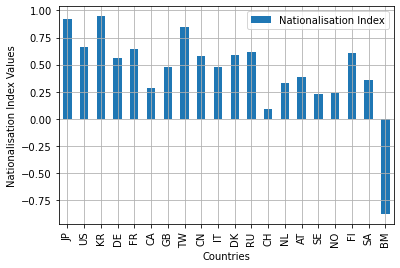

In [227]:
Nc_df.head(20).sort_values(['Aggregated Degrees'], ascending = [False]).plot.bar(y='Nationalisation Index',grid = True, xlabel = 'Countries', ylabel = 'Nationalisation Index Values')

In [24]:
NC.head(55).sort_values(['Sum L'], ascending = [False])

,index,Country,IL Sum,EL Sum,Sum L,Nationalization index
4,13,JP,87203,3305,90508,0.926968
8,41,US,69673,11460,81133,0.717501
0,0,KR,35325,928,36253,0.948804
3,10,DE,24829,6223,31052,0.599188
10,54,FR,11597,2307,13904,0.668153
7,40,CA,5725,3133,8858,0.292617
11,64,GB,6358,1804,8162,0.557951
14,226,TW,6944,459,7403,0.875996
9,46,CN,4625,1217,5842,0.583362
5,26,IT,2511,910,3421,0.467992


In [2]:
# Use the Gephi output as input

Delin = pd.read_csv('SNA FC + FCV TIS R1.csv')

In [3]:
IxA = pd.read_excel('IXA_FGephi.xlsx')
IxI = pd.read_excel('IXI_FGephi.xlsx')

In [4]:
IxA = IxA.rename(columns= {'Source':'SourceI','Target':'TargetA'})
IxI =IxI.rename(columns= {'Source':'SourceI','Target':'TargetI'})

NameError: name 'IxA' is not defined

In [5]:
Delin.set_index('Id').drop(columns = ['Label','timeset']).sort_values(['betweenesscentrality'], ascending = [False]).head(50).to_excel('Sorted_Centrality.xlsx')

In [3]:
US_Df = Delin[Delin['country'] == 'US'].sort_values(['betweenesscentrality'], ascending = [False])

In [5]:
KR_Df = Delin[Delin['country'] == 'KR'].sort_values(['betweenesscentrality'], ascending = [False])

In [3]:
DE_Df = Delin[Delin['country'] == 'DE'].sort_values(['betweenesscentrality'], ascending = [False])

In [14]:
US_Df.head(50).to_excel('US_Map.xlsx')

In [6]:
KR_Df.head(50).to_excel('KR_Map.xlsx')

In [7]:
DE_Df.head(50).to_excel('DE_Map.xlsx')

In [5]:
def bar_modularity_country(mod,DF):
    y = DF[DF['modularity_class'] == mod]['country'].value_counts()/len(DF[DF['modularity_class'] == mod]['country'])*100
    x = DF[DF['modularity_class'] == mod]['country'].unique()
    mpt.bar(x,y)
    mpt.ylabel('% of actors in subsystem with residency')
    mpt.xlabel('Residency')
    mpt.title('Actor Residency Decompsition for Subsystem '+ str(mod))
    mpt.show()
    

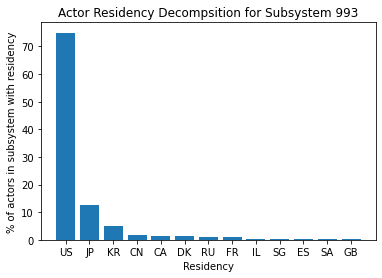

In [72]:
bar_modularity_country(993,Delin)

In [6]:
def bar_modularity_country_2x2(mod,DF):
    mpt.figure(figsize=(18,10))
    mpt.subplot(2,2,1) #SP #1
    y = DF[DF['modularity_class'] == mod[0]]['country'].value_counts()/len(DF[DF['modularity_class'] == mod[0]]['country'])*100
    x = DF[DF['modularity_class'] == mod[0]]['country'].unique()
    mpt.bar(x,y)
    mpt.ylabel('% of actors in subsystem with residency')
    mpt.xlabel('Residency')
    mpt.title('Actor Residency Decompsition for Subsystem #'+ str(mod[0]))
    mpt.subplot(2,2,2) #SP #2
    y = DF[DF['modularity_class'] == mod[1]]['country'].value_counts()/len(DF[DF['modularity_class'] == mod[1]]['country'])*100
    x = DF[DF['modularity_class'] == mod[1]]['country'].unique()
    mpt.bar(x,y)
    mpt.ylabel('% of actors in subsystem with residency')
    mpt.xlabel('Residency')
    mpt.title('Actor Residency Decompsition for Subsystem #'+ str(mod[1]))
    mpt.subplot(2,2,3) #SP #3
    y = DF[DF['modularity_class'] == mod[2]]['country'].value_counts()/len(DF[DF['modularity_class'] == mod[2]]['country'])*100
    x = DF[DF['modularity_class'] == mod[2]]['country'].unique()
    mpt.bar(x,y)
    mpt.ylabel('% of actors in subsystem with residency')
    mpt.xlabel('Residency')
    mpt.title('Actor Residency Decompsition for Subsystem #'+ str(mod[2]))
    mpt.subplot(2,2,4) #SP #4
    y = DF[DF['modularity_class'] == mod[3]]['country'].value_counts()/len(DF[DF['modularity_class'] == mod[3]]['country'])*100
    x = DF[DF['modularity_class'] == mod[3]]['country'].unique()
    mpt.bar(x,y)
    mpt.ylabel('% of actors in subsystem with residency')
    mpt.xlabel('Residency')
    mpt.title('Actor Residency Decompsition for Subsystem #'+ str(mod[3]))
    mpt.show()
    

In [10]:
SubSL = [2151,2153,2150,3]

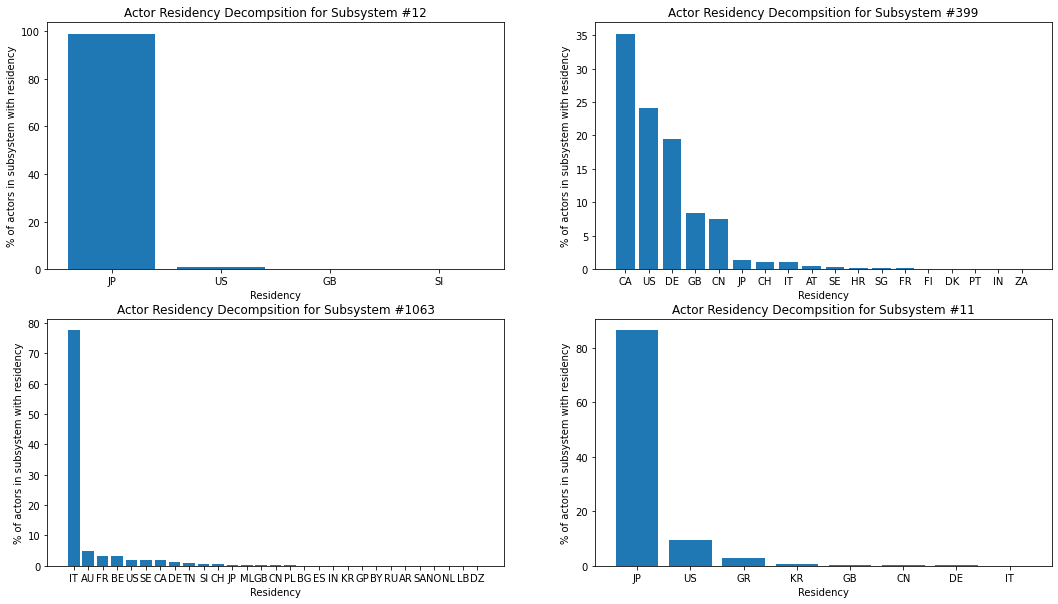

In [11]:
SubSL = [12,399,1063,11]
bar_modularity_country_2x2(SubSL,Delin) #Japanese

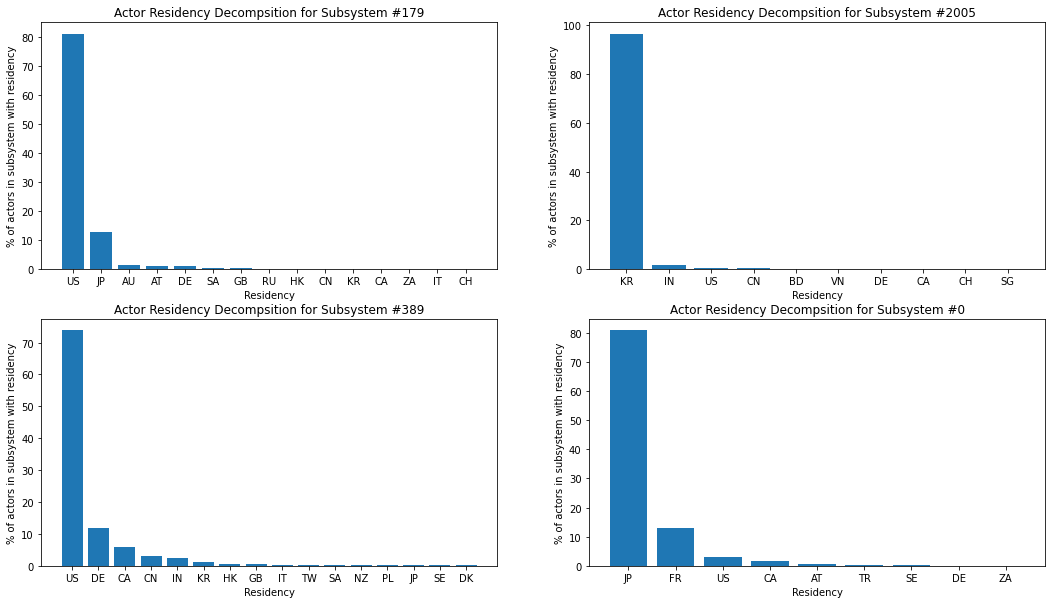

In [20]:
SubSL1 = [179,2005,389,0] 
bar_modularity_country_2x2(SubSL1,Delin)

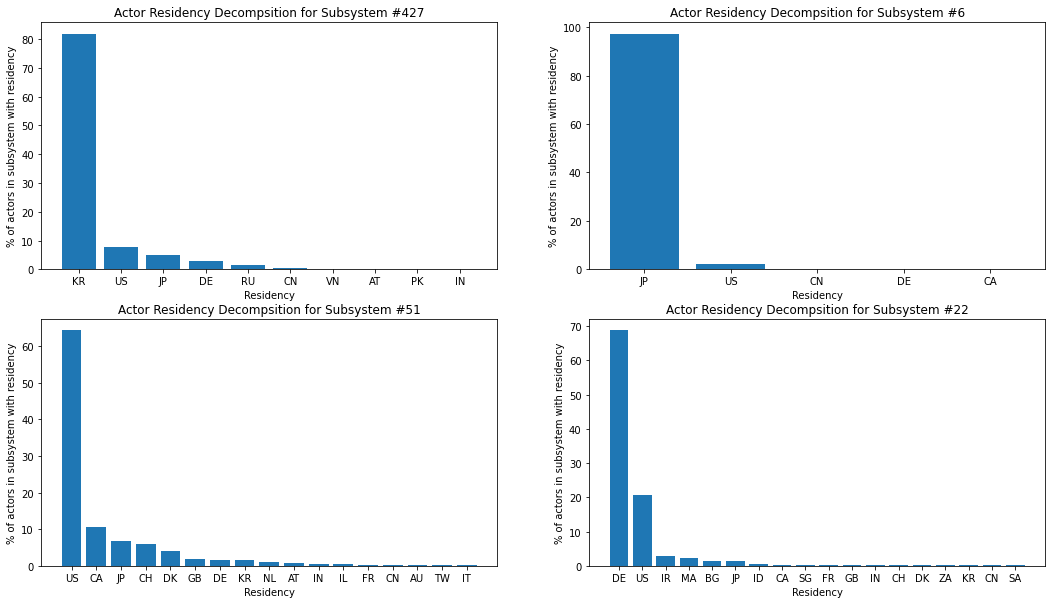

In [21]:
SubSL2 = [427,6,51 ,22]
bar_modularity_country_2x2(SubSL2,Delin)

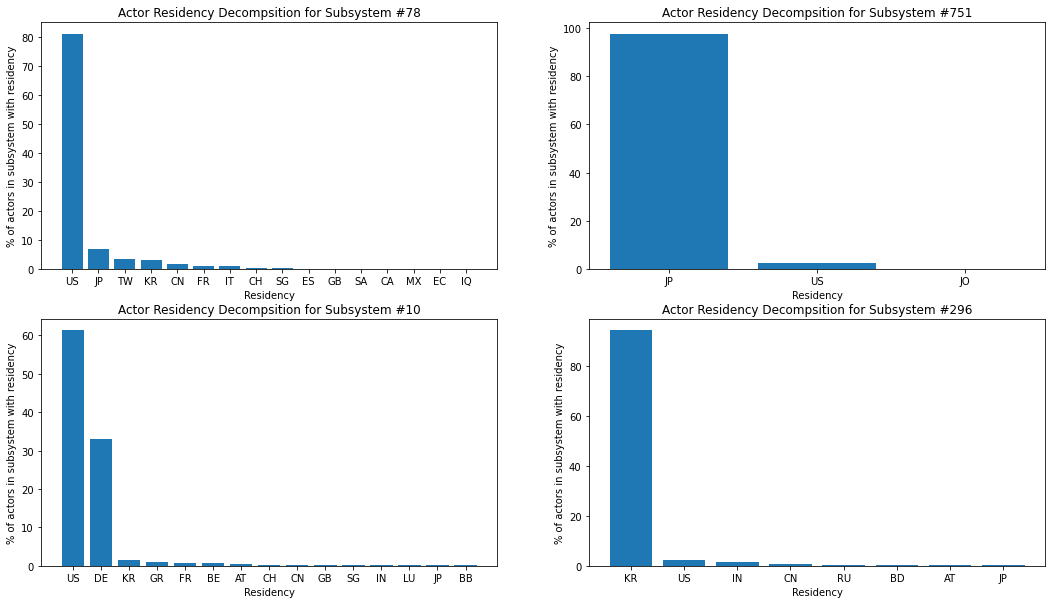

In [22]:
SubSL2 = [78,751,10,296]
bar_modularity_country_2x2(SubSL2,Delin)

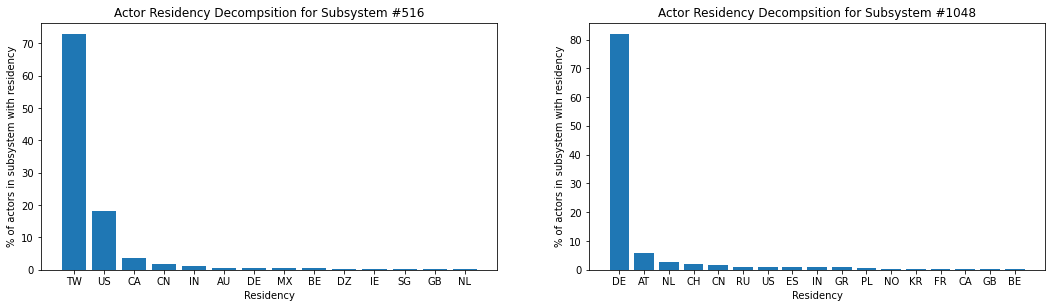

In [23]:
SubSL3 = [516,1048]
bar_modularity_country_1x2(SubSL3,Delin)

In [11]:
def bar_modularity_country_1x2(mod,DF):
    mpt.figure(figsize=(18,10))
    mpt.subplot(2,2,1) #SP #1
    y = DF[DF['modularity_class'] == mod[0]]['country'].value_counts()/len(DF[DF['modularity_class'] == mod[0]]['country'])*100
    x = DF[DF['modularity_class'] == mod[0]]['country'].unique()
    mpt.bar(x,y)
    mpt.ylabel('% of actors in subsystem with residency')
    mpt.xlabel('Residency')
    mpt.title('Actor Residency Decompsition for Subsystem #'+ str(mod[0]))
    mpt.subplot(2,2,2) #SP #2
    y = DF[DF['modularity_class'] == mod[1]]['country'].value_counts()/len(DF[DF['modularity_class'] == mod[1]]['country'])*100
    x = DF[DF['modularity_class'] == mod[1]]['country'].unique()
    mpt.bar(x,y)
    mpt.ylabel('% of actors in subsystem with residency')
    mpt.xlabel('Residency')
    mpt.title('Actor Residency Decompsition for Subsystem #'+ str(mod[1]))
    mpt.show()
    

In [24]:
def NNSS_network(Nodes, IxA,IxI):
    for i in IxA.index:
        A1 = IxA.loc[i,IxA.columns[0]]
        A2 = IxA.loc[i,IxA.columns[1]]
        IxA.at[i,'Source'] = Nodes.loc[A1,'modularity_class']
        IxA.at[i,'Target'] = Nodes.loc[A2,'modularity_class']
    for i in IxI.index:
        A1 = IxI.loc[i,IxI.columns[0]]
        A2 = IxI.loc[i,IxI.columns[1]]
        IxI.at[i,'Source'] = Nodes.loc[A1,'modularity_class']
        IxI.at[i,'Target'] = Nodes.loc[A2,'modularity_class']
    return IxA, IxI
IxA_M, IxI_M = NNSS_network(Delin2.set_index('Id'), IxA, IxI)
    

In [25]:
IxA_M.to_excel('Master/IxA_M.xlsx')
IxI_M.to_excel('Master/IxI_M.xlsx')

In [14]:
IxA_M.head()

,SourceI,TargetA,Inventor_R,Applicant_R,Patent_J+NR,IL,EL,Source,Target
0,SONG SEONG MIN,LG CHEMICAL LTD,KR,KR,TW 95101098,1,0,1323.0,1323.0
1,MOON GO YOUNG,LG CHEMICAL LTD,KR,KR,TW 95101098,1,0,1323.0,1323.0
2,LEE WON HO,LG CHEMICAL LTD,KR,KR,TW 95101098,1,0,1323.0,1323.0
3,CHUNG HA CHULL,LG CHEMICAL LTD,KR,KR,TW 95101098,1,0,1323.0,1323.0
4,PARK KYOUNG IL,LG CHEMICAL LTD,KR,KR,TW 95101098,1,0,1323.0,1323.0


In [57]:
IxA_cleanwL.index

RangeIndex(start=0, stop=287641, step=1)

In [62]:
Delin.set_index('Id').head(5)

,Label,timeset,country,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,modularity_class
Id,,,,,,,,
SONG SEONG MIN,SONG SEONG MIN,NaN,KR,15,0.169707,0.183106,0.000056,45
MOON GO YOUNG,MOON GO YOUNG,NaN,KR,15,0.174990,0.188542,0.000011,45
LEE WON HO,LEE WON HO,NaN,KR,14,0.190697,0.209366,0.001653,45
CHUNG HA CHULL,CHUNG HA CHULL,NaN,KR,14,0.186839,0.203107,0.000504,45
PARK KYOUNG IL,PARK KYOUNG IL,NaN,KR,15,0.168227,0.181255,0.000000,45


In [35]:
Delin[Delin['country'] =='KR'].sort_values(['betweenesscentrality'], ascending = [False]).head(40)

,Id,Label,timeset,country,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,modularity_class
40974,SAMSUNG SDI CO LTD,SAMSUNG SDI CO LTD,NaN,KR,13,0.222809,0.253220,0.032694,427
40954,LG CHEMICAL LTD,LG CHEMICAL LTD,NaN,KR,15,0.190111,0.213440,0.029578,296
41101,SAMSUNG ELECTRONICS CO LTD,SAMSUNG ELECTRONICS CO LTD,NaN,KR,13,0.217272,0.242472,0.026246,427
41018,HYUNDAI MOTOR CO LTD,HYUNDAI MOTOR CO LTD,NaN,KR,14,0.207598,0.240615,0.024011,2005
1713,SONG MIN KYU,SONG MIN KYU,NaN,KR,14,0.216312,0.245865,0.020187,427
41153,KOREAN INSTITUTE OF SCIENCE AND TECH,KOREAN INSTITUTE OF SCIENCE AND TECH,NaN,KR,15,0.194633,0.219651,0.009879,217
41231,KOREA INSITUTE OF ENERGY RES,KOREA INSITUTE OF ENERGY RES,NaN,KR,15,0.178506,0.199056,0.008138,343
1775,SHIN CHONG KYU,SHIN CHONG KYU,NaN,KR,14,0.195517,0.214129,0.007252,296
20067,KIM KI HYUN,KIM KI HYUN,NaN,KR,14,0.202967,0.224775,0.007230,427
2528,CHO KYU TAEK,CHO KYU TAEK,NaN,KR,13,0.210040,0.231102,0.006225,2005


In [36]:
Delin[Delin['country'] =='DE'].sort_values(['betweenesscentrality'], ascending = [False]).head(40)

,Id,Label,timeset,country,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,modularity_class
42350,AUDI AG,AUDI AG,NaN,DE,14,0.221604,0.247783,0.021508,179
41178,BOSCH GMBH ROBERT,BOSCH GMBH ROBERT,NaN,DE,14,0.210677,0.234912,0.020382,94
41012,DAIMLER AG,DAIMLER AG,NaN,DE,14,0.209772,0.234936,0.014644,399
41043,SIEMENS AG,SIEMENS AG,NaN,DE,14,0.188635,0.209612,0.013765,97
41028,FORSCHUNGSZENTRUM JÜLICH GMBH,FORSCHUNGSZENTRUM JÜLICH GMBH,NaN,DE,14,0.192452,0.214030,0.013549,1048
41009,FRAUNHOFER GES FORSCHUNG,FORSCHUNGSZENTRUM JÜLICH GMBH,NaN,DE,14,0.191511,0.212194,0.011517,1048
41152,BASF SE,BASF SE,NaN,DE,13,0.194745,0.211764,0.008391,22
41082,BAYERISCHE MOTOREN WERKE AG,BAYERISCHE MOTOREN WERKE AG,NaN,DE,14,0.196255,0.214793,0.008213,10
41133,VOLKSWAGEN AG,VOLKSWAGEN AG,NaN,DE,14,0.196089,0.214704,0.005488,179
5539,PEINECKE VOLKER,PEINECKE VOLKER,NaN,DE,14,0.199205,0.219996,0.004659,1048
